In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score, roc_curve

Load Dataset

In [2]:
train_feature = pd.read_csv('training_set_features.csv')
train_label = pd.read_csv('training_set_labels.csv')
test = pd.read_csv('test_set_features.csv')

In [3]:
train = train_feature.merge(train_label, how='inner',on='respondent_id')
train.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


EDA

In [4]:
len(train)

26707

In [5]:
train.isna().sum()

respondent_id                      0
h1n1_concern                      92
h1n1_knowledge                   116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
m

In [6]:
train.dtypes

respondent_id                    int64
h1n1_concern                   float64
h1n1_knowledge                 float64
behavioral_antiviral_meds      float64
behavioral_avoidance           float64
behavioral_face_mask           float64
behavioral_wash_hands          float64
behavioral_large_gatherings    float64
behavioral_outside_home        float64
behavioral_touch_face          float64
doctor_recc_h1n1               float64
doctor_recc_seasonal           float64
chronic_med_condition          float64
child_under_6_months           float64
health_worker                  float64
health_insurance               float64
opinion_h1n1_vacc_effective    float64
opinion_h1n1_risk              float64
opinion_h1n1_sick_from_vacc    float64
opinion_seas_vacc_effective    float64
opinion_seas_risk              float64
opinion_seas_sick_from_vacc    float64
age_group                       object
education                       object
race                            object
sex                      

In [7]:
oj_list=[]
cat_list=[]
for i in train.columns:
    if train[i].dtype == object:
        oj_list.append(i)
        train[i] = train[i].fillna('Unknown')
    elif i != 'respondent_id':
        cat_list.append(i)
        train[i] = train[i].fillna(-1)

In [8]:
for j in test.columns:
    if test[j].dtype == object:
        test[j] = test[j].fillna('Unknown')
    else:
        test[j] = test[j].fillna(-1)

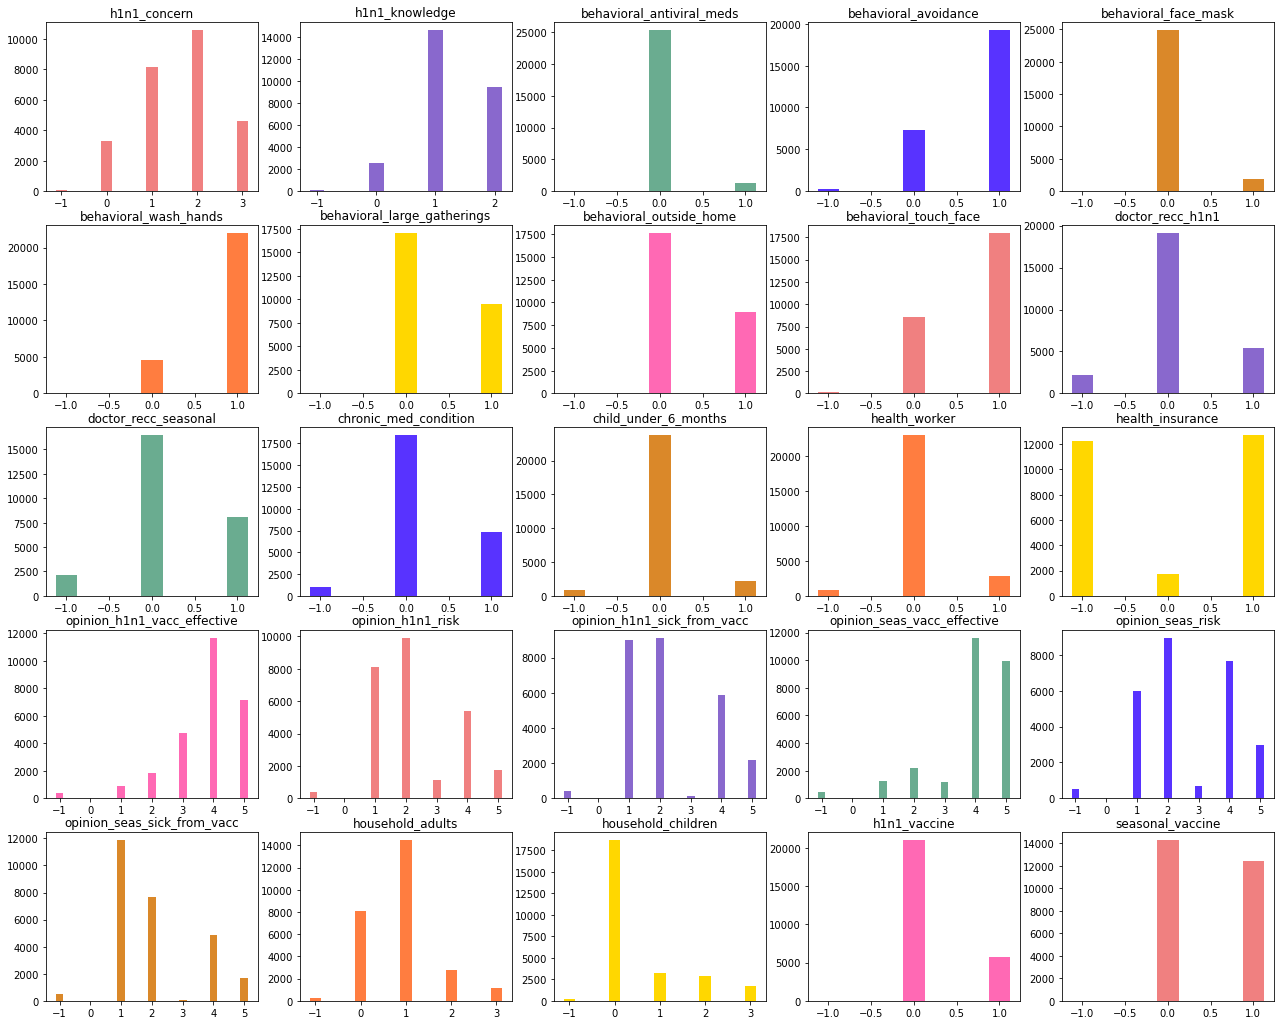

In [9]:
#cat_cols visualization
nrows = 5
ncols = int(len(cat_list)/nrows)
color_list = ["#F08080","#8968CD","#6aac90","#5833ff","#da8829","#FF7D40","#FFD700","#FF69B4"]
fig, axes = plt.subplots(nrows, ncols, figsize = (22,18))
axes = axes.flatten()
for count, p in enumerate(cat_list):
    plt.sca(axes[count])
    plt.title(p)
    bins = np.arange(-1,max(train[p]+0.5),0.25)-0.125
    plt.hist(train[p], bins=bins, color=color_list[count%len(color_list)])

Some Quick Observation:

    a. In the health_insurance column, the proportion of missing values is huge.
    b. Respondents are more willing to take the seasonal vaccine than the h1n1 vaccine.
    c. Most respondents do not take antiviral medications before.
    d. Most respondents do not have children.
    e. Most respondents in this dataset wash their hands but do not wear a face mask.
    f. Most respondents in this dataset are not health-related workers
    g. Most respondents in this dataset think the h1n1 vaccine does have a somewhat or great effect on h1n1. 
    h. Most respondents think the risk of getting sick with H1N1 flu without a vaccine is low.
    i. Most respondents think the seasonal flu vaccine does have a somewhat or great effect on flu.
    j. Different from (h), Only half of the respondents think the risk of getting sick with seasonal flu without a vaccine is low.
    k. Most respondents do not think they will get sick after taking the vaccine. In other words, those who took the vaccine believed in it.

<AxesSubplot:xlabel='sex', ylabel='count'>

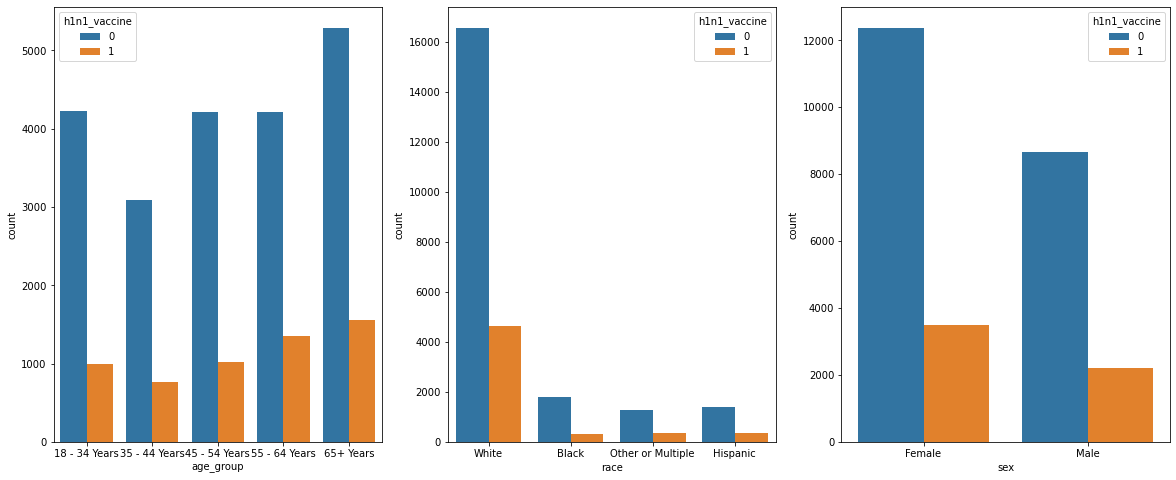

In [10]:
#Interested in age_group, race, and sex to vaccines.
fig, axes = plt.subplots(1, 3, figsize = (20,8))
sns.countplot(x='age_group', hue='h1n1_vaccine', data = train, order=['18 - 34 Years','35 - 44 Years','45 - 54 Years','55 - 64 Years','65+ Years'],ax=axes[0])
sns.countplot(x='race', hue='h1n1_vaccine', data = train,ax=axes[1])
sns.countplot(x='sex', hue='h1n1_vaccine', data = train,ax=axes[2])

Age_group:

    a. 65+ group is slightly more than the other groups. 
    b. 35-44 group is slightly less than the other group. 
    c. Age above 55 years seems more prefer to take the h1n1 vaccine.
    

Race:
    
    a. Most respondents in this dataset are white and extremely imbalanced.

Sex:
    
    a. Female is slightly more than male in this dataset. 
    b. However there is no big difference in h1n1 vaccine proportion.

<AxesSubplot:xlabel='sex', ylabel='count'>

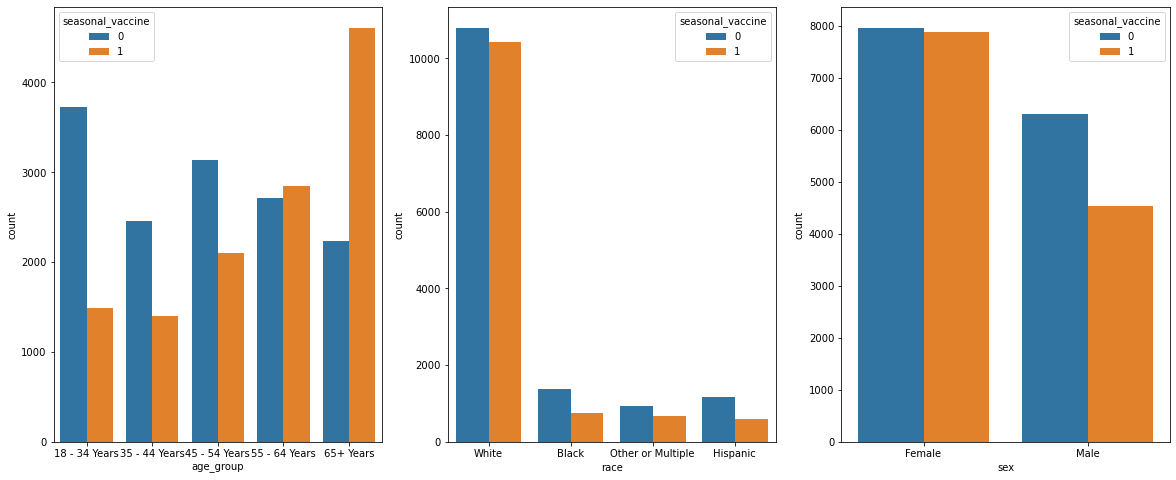

In [11]:
fig, axes = plt.subplots(1, 3, figsize = (20,8))
sns.countplot(x='age_group', hue='seasonal_vaccine', data = train, order=['18 - 34 Years','35 - 44 Years','45 - 54 Years','55 - 64 Years','65+ Years'],ax=axes[0])
sns.countplot(x='race', hue='seasonal_vaccine', data = train,ax=axes[1])
sns.countplot(x='sex', hue='seasonal_vaccine', data = train,ax=axes[2])

Age_group:

    a. There are more and more respondents taking a seasonal vaccine as their age increases.
    b. More than half of the respondents whose age is above 55 took the seasonal vaccine.
    c. Respondents are more willing to take the seasonal vaccine than the h1n1 vaccine in each age group.

Race:
    
    a. Most respondents in this dataset are white and extremely imbalanced.
    b. Respondents are more willing to take the seasonal vaccine than the h1n1 vaccine no matter their race.

Sex:
    
    a. Females are more willing to take the seasonal vaccine.
    b. Respondents are more willing to take the seasonal vaccine than the h1n1 vaccine no matter their sex.

Prepare the data for our model.

In [12]:
for i in oj_list:
    le = LabelEncoder()
    train[i]=le.fit_transform(train[i])
    test[i]=le.fit_transform(test[i])

In [13]:
for i in train.columns:
    train[i] = train[i].astype(int)

In [14]:
for j in test.columns:
    test[j] = test[j].astype(int)

In [15]:
X = train.drop(['respondent_id','h1n1_vaccine','seasonal_vaccine'],axis=1)
y1 = train['h1n1_vaccine']
y2 = train['seasonal_vaccine']

In [16]:
X_train, X_test, y1_train, y1_test, y2_train, y2_test = train_test_split(X, y1, y2, test_size=0.2, random_state = 42)
X_train, X_val, y1_train, y1_val, y2_train, y2_val = train_test_split(X_train, y1_train, y2_train, test_size=0.1, random_state = 42)

Modeling(catboost model + gridsearch)

In [19]:
from catboost import CatBoostClassifier, Pool

cat_model = CatBoostClassifier()

params = {'iterations': [400, 600, 1000],
        'learning_rate': [0.1, 0.05, 0.01],
        'max_depth': [4, 6],
        'l2_leaf_reg': [0.1, 0.5, 1, 3],
        'verbose':[100],
        'random_seed': [42],
        'loss_function':['Logloss'],
        'eval_metric':['AUC:hints=skip_train~false']}

scorer = make_scorer(roc_auc_score)

cat_grid = GridSearchCV(estimator=cat_model, param_grid=params, scoring=scorer, cv=5)

In [20]:
cat_grid.fit(X_train, y1_train, eval_set=(X_val,y1_val))
best_param_h1n1 = cat_grid.best_params_
best_param_h1n1

0:	learn: 0.8168097	test: 0.8180980	best: 0.8180980 (0)	total: 4.61ms	remaining: 1.84s
100:	learn: 0.8742953	test: 0.8661507	best: 0.8661507 (100)	total: 386ms	remaining: 1.14s
200:	learn: 0.8912585	test: 0.8682929	best: 0.8686956 (161)	total: 761ms	remaining: 754ms
300:	learn: 0.9023009	test: 0.8687706	best: 0.8689612 (287)	total: 1.14s	remaining: 375ms
399:	learn: 0.9110886	test: 0.8696574	best: 0.8701161 (386)	total: 1.51s	remaining: 0us

bestTest = 0.8701160758
bestIteration = 386

Shrink model to first 387 iterations.
0:	learn: 0.8181189	test: 0.8183279	best: 0.8183279 (0)	total: 3.1ms	remaining: 1.24s
100:	learn: 0.8749276	test: 0.8659932	best: 0.8661025 (98)	total: 377ms	remaining: 1.12s
200:	learn: 0.8915522	test: 0.8698366	best: 0.8698594 (196)	total: 751ms	remaining: 744ms
300:	learn: 0.9031551	test: 0.8701466	best: 0.8706916 (292)	total: 1.13s	remaining: 371ms
399:	learn: 0.9121139	test: 0.8688405	best: 0.8706916 (292)	total: 1.5s	remaining: 0us

bestTest = 0.8706916267
best

399:	learn: 0.9347201	test: 0.8679435	best: 0.8683907 (375)	total: 1.99s	remaining: 0us

bestTest = 0.8683906936
bestIteration = 375

Shrink model to first 376 iterations.
0:	learn: 0.8238541	test: 0.8164406	best: 0.8164406 (0)	total: 3.83ms	remaining: 1.53s
100:	learn: 0.8827959	test: 0.8647875	best: 0.8647875 (100)	total: 494ms	remaining: 1.46s
200:	learn: 0.9038630	test: 0.8679994	best: 0.8682560 (175)	total: 994ms	remaining: 984ms
300:	learn: 0.9217255	test: 0.8692153	best: 0.8692813 (295)	total: 1.51s	remaining: 499ms
399:	learn: 0.9354990	test: 0.8687591	best: 0.8696079 (342)	total: 2s	remaining: 0us

bestTest = 0.8696078631
bestIteration = 342

Shrink model to first 343 iterations.
0:	learn: 0.8223730	test: 0.8142006	best: 0.8142006 (0)	total: 3.55ms	remaining: 1.42s
100:	learn: 0.8843904	test: 0.8657848	best: 0.8657848 (100)	total: 492ms	remaining: 1.46s
200:	learn: 0.9041200	test: 0.8690247	best: 0.8692470 (197)	total: 986ms	remaining: 977ms
300:	learn: 0.9218975	test: 0.86940

100:	learn: 0.8760731	test: 0.8680794	best: 0.8680794 (100)	total: 356ms	remaining: 1.05s
200:	learn: 0.8926582	test: 0.8724627	best: 0.8724627 (200)	total: 746ms	remaining: 739ms
300:	learn: 0.9039073	test: 0.8740306	best: 0.8742466 (274)	total: 1.13s	remaining: 372ms
399:	learn: 0.9121639	test: 0.8753786	best: 0.8755120 (388)	total: 1.51s	remaining: 0us

bestTest = 0.8755120243
bestIteration = 388

Shrink model to first 389 iterations.
0:	learn: 0.8221412	test: 0.8183279	best: 0.8183279 (0)	total: 3.33ms	remaining: 1.33s
100:	learn: 0.8788329	test: 0.8662842	best: 0.8662842 (100)	total: 386ms	remaining: 1.14s
200:	learn: 0.8948828	test: 0.8689014	best: 0.8695189 (173)	total: 766ms	remaining: 758ms
300:	learn: 0.9058027	test: 0.8706268	best: 0.8706268 (300)	total: 1.16s	remaining: 381ms
399:	learn: 0.9143225	test: 0.8694338	best: 0.8710321 (311)	total: 1.54s	remaining: 0us

bestTest = 0.8710321292
bestIteration = 311

Shrink model to first 312 iterations.
0:	learn: 0.8210273	test: 0.8

100:	learn: 0.8860297	test: 0.8649730	best: 0.8649730 (100)	total: 504ms	remaining: 1.49s
200:	learn: 0.9056170	test: 0.8690425	best: 0.8690425 (200)	total: 1.04s	remaining: 1.03s
300:	learn: 0.9218199	test: 0.8701085	best: 0.8702241 (297)	total: 1.53s	remaining: 504ms
399:	learn: 0.9345077	test: 0.8708238	best: 0.8709622 (394)	total: 2.02s	remaining: 0us

bestTest = 0.87096225
bestIteration = 394

Shrink model to first 395 iterations.
0:	learn: 0.8274643	test: 0.8160988	best: 0.8160988 (0)	total: 3.28ms	remaining: 1.31s
100:	learn: 0.8869543	test: 0.8640683	best: 0.8640683 (100)	total: 487ms	remaining: 1.44s
200:	learn: 0.9050628	test: 0.8691670	best: 0.8691670 (200)	total: 975ms	remaining: 966ms
300:	learn: 0.9224037	test: 0.8692115	best: 0.8700144 (259)	total: 1.46s	remaining: 482ms
399:	learn: 0.9347271	test: 0.8663324	best: 0.8700144 (259)	total: 1.95s	remaining: 0us

bestTest = 0.8700144332
bestIteration = 259

Shrink model to first 260 iterations.
0:	learn: 0.8168097	test: 0.818

200:	learn: 0.8949340	test: 0.8713891	best: 0.8714387 (196)	total: 808ms	remaining: 800ms
300:	learn: 0.9059980	test: 0.8703575	best: 0.8714387 (196)	total: 1.23s	remaining: 405ms
399:	learn: 0.9147590	test: 0.8696396	best: 0.8714387 (196)	total: 1.73s	remaining: 0us

bestTest = 0.8714386994
bestIteration = 196

Shrink model to first 197 iterations.
0:	learn: 0.8225157	test: 0.8169056	best: 0.8169056 (0)	total: 3.6ms	remaining: 1.44s
100:	learn: 0.8975276	test: 0.8696206	best: 0.8696206 (100)	total: 486ms	remaining: 1.44s
200:	learn: 0.9292105	test: 0.8692419	best: 0.8709699 (129)	total: 984ms	remaining: 975ms
300:	learn: 0.9485204	test: 0.8683221	best: 0.8709699 (129)	total: 1.47s	remaining: 485ms
399:	learn: 0.9623576	test: 0.8639756	best: 0.8709699 (129)	total: 1.99s	remaining: 0us

bestTest = 0.8709698732
bestIteration = 129

Shrink model to first 130 iterations.
0:	learn: 0.8237931	test: 0.8161941	best: 0.8161941 (0)	total: 3.44ms	remaining: 1.37s
100:	learn: 0.8990952	test: 0.869

100:	learn: 0.8441414	test: 0.8426421	best: 0.8426421 (100)	total: 387ms	remaining: 1.14s
200:	learn: 0.8503872	test: 0.8489681	best: 0.8489782 (196)	total: 770ms	remaining: 762ms
300:	learn: 0.8560852	test: 0.8542865	best: 0.8543107 (299)	total: 1.28s	remaining: 421ms
399:	learn: 0.8601785	test: 0.8575861	best: 0.8575861 (399)	total: 1.65s	remaining: 0us

bestTest = 0.8575860912
bestIteration = 399

0:	learn: 0.8181189	test: 0.8183279	best: 0.8183279 (0)	total: 3.45ms	remaining: 1.38s
100:	learn: 0.8440731	test: 0.8426281	best: 0.8426281 (100)	total: 383ms	remaining: 1.13s
200:	learn: 0.8504507	test: 0.8502272	best: 0.8502475 (199)	total: 817ms	remaining: 809ms
300:	learn: 0.8559784	test: 0.8551035	best: 0.8551035 (300)	total: 1.19s	remaining: 392ms
399:	learn: 0.8602703	test: 0.8583166	best: 0.8583166 (399)	total: 1.58s	remaining: 0us

bestTest = 0.858316647
bestIteration = 399

0:	learn: 0.8159710	test: 0.8180980	best: 0.8180980 (0)	total: 3.01ms	remaining: 1.2s
100:	learn: 0.844082

300:	learn: 0.9454289	test: 0.8695863	best: 0.8721172 (143)	total: 1.49s	remaining: 489ms
399:	learn: 0.9580313	test: 0.8685101	best: 0.8721172 (143)	total: 1.97s	remaining: 0us

bestTest = 0.8721171634
bestIteration = 143

Shrink model to first 144 iterations.
0:	learn: 0.8222238	test: 0.8146326	best: 0.8146326 (0)	total: 4.28ms	remaining: 1.71s
100:	learn: 0.8977003	test: 0.8668699	best: 0.8669791 (91)	total: 514ms	remaining: 1.52s
200:	learn: 0.9272022	test: 0.8680261	best: 0.8693931 (142)	total: 1.07s	remaining: 1.06s
300:	learn: 0.9455150	test: 0.8667530	best: 0.8693931 (142)	total: 1.51s	remaining: 497ms
399:	learn: 0.9581910	test: 0.8654126	best: 0.8693931 (142)	total: 1.99s	remaining: 0us

bestTest = 0.8693931432
bestIteration = 142

Shrink model to first 143 iterations.
0:	learn: 0.8278055	test: 0.8166280	best: 0.8166280 (0)	total: 3.79ms	remaining: 1.51s
100:	learn: 0.9021041	test: 0.8684618	best: 0.8685673 (96)	total: 515ms	remaining: 1.52s
200:	learn: 0.9293829	test: 0.8716

200:	learn: 0.8510489	test: 0.8502526	best: 0.8502526 (200)	total: 782ms	remaining: 774ms
300:	learn: 0.8574562	test: 0.8550997	best: 0.8550997 (300)	total: 1.16s	remaining: 381ms
399:	learn: 0.8616209	test: 0.8586292	best: 0.8586292 (399)	total: 1.53s	remaining: 0us

bestTest = 0.8586291978
bestIteration = 399

0:	learn: 0.8221412	test: 0.8183279	best: 0.8183279 (0)	total: 2.41ms	remaining: 961ms
100:	learn: 0.8492165	test: 0.8422991	best: 0.8422991 (100)	total: 378ms	remaining: 1.12s
200:	learn: 0.8563807	test: 0.8493988	best: 0.8494534 (199)	total: 757ms	remaining: 749ms
300:	learn: 0.8612796	test: 0.8544098	best: 0.8544098 (300)	total: 1.14s	remaining: 374ms
399:	learn: 0.8653368	test: 0.8576522	best: 0.8576522 (399)	total: 1.54s	remaining: 0us

bestTest = 0.8576521589
bestIteration = 399

0:	learn: 0.8210273	test: 0.8179760	best: 0.8179760 (0)	total: 3.21ms	remaining: 1.28s
100:	learn: 0.8498879	test: 0.8432151	best: 0.8432151 (100)	total: 446ms	remaining: 1.32s
200:	learn: 0.8552

200:	learn: 0.9355769	test: 0.8674797	best: 0.8696434 (170)	total: 982ms	remaining: 1.95s
300:	learn: 0.9544823	test: 0.8626237	best: 0.8696434 (170)	total: 1.51s	remaining: 1.5s
400:	learn: 0.9675223	test: 0.8600141	best: 0.8696434 (170)	total: 1.99s	remaining: 987ms
500:	learn: 0.9766954	test: 0.8587207	best: 0.8696434 (170)	total: 2.45s	remaining: 484ms
599:	learn: 0.9830743	test: 0.8551314	best: 0.8696434 (170)	total: 2.93s	remaining: 0us

bestTest = 0.869643438
bestIteration = 170

Shrink model to first 171 iterations.
0:	learn: 0.8223730	test: 0.8142006	best: 0.8142006 (0)	total: 3.86ms	remaining: 2.31s
100:	learn: 0.9029870	test: 0.8700157	best: 0.8700157 (100)	total: 477ms	remaining: 2.35s
200:	learn: 0.9345263	test: 0.8690399	best: 0.8708403 (140)	total: 969ms	remaining: 1.92s
300:	learn: 0.9537065	test: 0.8692242	best: 0.8708403 (140)	total: 1.47s	remaining: 1.47s
400:	learn: 0.9662674	test: 0.8638930	best: 0.8708403 (140)	total: 1.96s	remaining: 974ms
500:	learn: 0.9767239	t

100:	learn: 0.8880475	test: 0.8659119	best: 0.8659119 (100)	total: 497ms	remaining: 2.46s
200:	learn: 0.9077289	test: 0.8696727	best: 0.8696727 (200)	total: 993ms	remaining: 1.97s
300:	learn: 0.9247385	test: 0.8698251	best: 0.8707208 (247)	total: 1.55s	remaining: 1.54s
400:	learn: 0.9375867	test: 0.8698696	best: 0.8707208 (247)	total: 2.06s	remaining: 1.02s
500:	learn: 0.9474325	test: 0.8693652	best: 0.8707208 (247)	total: 2.55s	remaining: 504ms
599:	learn: 0.9558632	test: 0.8686473	best: 0.8707208 (247)	total: 3.05s	remaining: 0us

bestTest = 0.8707208489
bestIteration = 247

Shrink model to first 248 iterations.
0:	learn: 0.8274780	test: 0.8161229	best: 0.8161229 (0)	total: 3.27ms	remaining: 1.96s
100:	learn: 0.8877752	test: 0.8645245	best: 0.8645245 (100)	total: 523ms	remaining: 2.58s
200:	learn: 0.9067079	test: 0.8674861	best: 0.8676792 (198)	total: 1.02s	remaining: 2.03s
300:	learn: 0.9248055	test: 0.8665383	best: 0.8679587 (222)	total: 1.55s	remaining: 1.54s
400:	learn: 0.9375299

200:	learn: 0.8910013	test: 0.8676271	best: 0.8691416 (164)	total: 756ms	remaining: 1.5s
300:	learn: 0.9018872	test: 0.8687515	best: 0.8691416 (164)	total: 1.12s	remaining: 1.11s
400:	learn: 0.9109432	test: 0.8685038	best: 0.8691416 (164)	total: 1.49s	remaining: 737ms
500:	learn: 0.9186875	test: 0.8687884	best: 0.8694910 (463)	total: 1.85s	remaining: 366ms
599:	learn: 0.9248944	test: 0.8691479	best: 0.8699611 (549)	total: 2.22s	remaining: 0us

bestTest = 0.8699610709
bestIteration = 549

Shrink model to first 550 iterations.
0:	learn: 0.8181189	test: 0.8183279	best: 0.8183279 (0)	total: 3.25ms	remaining: 1.95s
100:	learn: 0.8746602	test: 0.8661990	best: 0.8661990 (100)	total: 361ms	remaining: 1.78s
200:	learn: 0.8910167	test: 0.8695405	best: 0.8695405 (200)	total: 731ms	remaining: 1.45s
300:	learn: 0.9018979	test: 0.8698925	best: 0.8702228 (289)	total: 1.1s	remaining: 1.09s
400:	learn: 0.9106083	test: 0.8682382	best: 0.8702228 (289)	total: 1.47s	remaining: 729ms
500:	learn: 0.9182073	t

100:	learn: 0.8653325	test: 0.8612147	best: 0.8612147 (100)	total: 370ms	remaining: 1.83s
200:	learn: 0.8761656	test: 0.8682319	best: 0.8682319 (200)	total: 744ms	remaining: 1.48s
300:	learn: 0.8852994	test: 0.8709279	best: 0.8710207 (299)	total: 1.11s	remaining: 1.1s
400:	learn: 0.8926174	test: 0.8729240	best: 0.8730002 (396)	total: 1.47s	remaining: 731ms
500:	learn: 0.8984645	test: 0.8738692	best: 0.8738692 (500)	total: 1.84s	remaining: 363ms
599:	learn: 0.9036160	test: 0.8743927	best: 0.8743952 (597)	total: 2.21s	remaining: 0us

bestTest = 0.8743952269
bestIteration = 597

Shrink model to first 598 iterations.
0:	learn: 0.8221412	test: 0.8183279	best: 0.8183279 (0)	total: 3.72ms	remaining: 2.23s
100:	learn: 0.8687708	test: 0.8598273	best: 0.8598273 (100)	total: 367ms	remaining: 1.81s
200:	learn: 0.8794609	test: 0.8654736	best: 0.8655727 (199)	total: 738ms	remaining: 1.46s
300:	learn: 0.8884364	test: 0.8684949	best: 0.8684949 (300)	total: 1.1s	remaining: 1.1s
400:	learn: 0.8950065	te

100:	learn: 0.8491986	test: 0.8417915	best: 0.8417915 (100)	total: 397ms	remaining: 1.96s
200:	learn: 0.8551722	test: 0.8484497	best: 0.8484497 (200)	total: 800ms	remaining: 1.59s
300:	learn: 0.8610849	test: 0.8542992	best: 0.8542992 (300)	total: 1.18s	remaining: 1.18s
400:	learn: 0.8654342	test: 0.8574171	best: 0.8574171 (400)	total: 1.63s	remaining: 807ms
500:	learn: 0.8687062	test: 0.8597739	best: 0.8597739 (500)	total: 2.03s	remaining: 400ms
599:	learn: 0.8714345	test: 0.8618500	best: 0.8618500 (599)	total: 2.39s	remaining: 0us

bestTest = 0.8618499959
bestIteration = 599

0:	learn: 0.8225644	test: 0.8171038	best: 0.8171038 (0)	total: 4.4ms	remaining: 2.64s
100:	learn: 0.8530839	test: 0.8471792	best: 0.8471792 (100)	total: 450ms	remaining: 2.23s
200:	learn: 0.8634637	test: 0.8551543	best: 0.8551543 (200)	total: 909ms	remaining: 1.8s
300:	learn: 0.8706817	test: 0.8595897	best: 0.8595897 (300)	total: 1.37s	remaining: 1.36s
400:	learn: 0.8762805	test: 0.8625590	best: 0.8625590 (400)	t

100:	learn: 0.8990952	test: 0.8694846	best: 0.8697209 (93)	total: 468ms	remaining: 2.31s
200:	learn: 0.9300049	test: 0.8685305	best: 0.8700144 (116)	total: 918ms	remaining: 1.82s
300:	learn: 0.9490250	test: 0.8677186	best: 0.8700144 (116)	total: 1.38s	remaining: 1.38s
400:	learn: 0.9621337	test: 0.8644813	best: 0.8700144 (116)	total: 1.84s	remaining: 915ms
500:	learn: 0.9710666	test: 0.8626492	best: 0.8700144 (116)	total: 2.31s	remaining: 456ms
599:	learn: 0.9783291	test: 0.8610305	best: 0.8700144 (116)	total: 2.8s	remaining: 0us

bestTest = 0.8700144332
bestIteration = 116

Shrink model to first 117 iterations.
0:	learn: 0.8223265	test: 0.8141472	best: 0.8141472 (0)	total: 5.24ms	remaining: 3.14s
100:	learn: 0.9013435	test: 0.8690742	best: 0.8697794 (93)	total: 458ms	remaining: 2.26s
200:	learn: 0.9311625	test: 0.8709826	best: 0.8716839 (155)	total: 910ms	remaining: 1.81s
300:	learn: 0.9497865	test: 0.8687299	best: 0.8716839 (155)	total: 1.38s	remaining: 1.37s
400:	learn: 0.9625904	te

599:	learn: 0.9496649	test: 0.8711516	best: 0.8721934 (458)	total: 2.74s	remaining: 0us

bestTest = 0.8721933953
bestIteration = 458

Shrink model to first 459 iterations.
0:	learn: 0.8279228	test: 0.8169189	best: 0.8169189 (0)	total: 4.1ms	remaining: 2.45s
100:	learn: 0.8865150	test: 0.8657150	best: 0.8657150 (100)	total: 461ms	remaining: 2.28s
200:	learn: 0.9046937	test: 0.8692724	best: 0.8692839 (199)	total: 925ms	remaining: 1.83s
300:	learn: 0.9207336	test: 0.8701567	best: 0.8701567 (300)	total: 1.38s	remaining: 1.37s
400:	learn: 0.9327785	test: 0.8695697	best: 0.8701898 (306)	total: 1.84s	remaining: 912ms
500:	learn: 0.9426063	test: 0.8694262	best: 0.8701898 (306)	total: 2.29s	remaining: 452ms
599:	learn: 0.9509139	test: 0.8683564	best: 0.8701898 (306)	total: 2.74s	remaining: 0us

bestTest = 0.8701897666
bestIteration = 306

Shrink model to first 307 iterations.
0:	learn: 0.8274182	test: 0.8159768	best: 0.8159768 (0)	total: 3.54ms	remaining: 2.12s
100:	learn: 0.8860891	test: 0.863

500:	learn: 0.8861571	test: 0.8643974	best: 0.8643974 (500)	total: 2.34s	remaining: 463ms
599:	learn: 0.8902101	test: 0.8657696	best: 0.8657696 (599)	total: 2.8s	remaining: 0us

bestTest = 0.8657695865
bestIteration = 599

0:	learn: 0.8168097	test: 0.8180980	best: 0.8180980 (0)	total: 2.76ms	remaining: 1.65s
100:	learn: 0.8732619	test: 0.8665853	best: 0.8665853 (100)	total: 393ms	remaining: 1.94s
200:	learn: 0.8891292	test: 0.8706065	best: 0.8706065 (200)	total: 780ms	remaining: 1.55s
300:	learn: 0.9004928	test: 0.8706548	best: 0.8712570 (281)	total: 1.17s	remaining: 1.16s
400:	learn: 0.9093924	test: 0.8704693	best: 0.8712570 (281)	total: 1.55s	remaining: 768ms
500:	learn: 0.9172962	test: 0.8702685	best: 0.8712570 (281)	total: 1.93s	remaining: 381ms
599:	learn: 0.9237563	test: 0.8712456	best: 0.8714921 (579)	total: 2.3s	remaining: 0us

bestTest = 0.8714920617
bestIteration = 579

Shrink model to first 580 iterations.
0:	learn: 0.8181189	test: 0.8183279	best: 0.8183279 (0)	total: 2.82ms

300:	learn: 0.8830310	test: 0.8693995	best: 0.8694084 (298)	total: 1.14s	remaining: 1.13s
400:	learn: 0.8898921	test: 0.8698277	best: 0.8703803 (385)	total: 1.51s	remaining: 752ms
500:	learn: 0.8957027	test: 0.8699547	best: 0.8703803 (385)	total: 1.89s	remaining: 374ms
599:	learn: 0.9009476	test: 0.8694618	best: 0.8703803 (385)	total: 2.27s	remaining: 0us

bestTest = 0.8703803464
bestIteration = 385

Shrink model to first 386 iterations.
0:	learn: 0.8159710	test: 0.8180980	best: 0.8180980 (0)	total: 2.73ms	remaining: 1.64s
100:	learn: 0.8647323	test: 0.8611906	best: 0.8611906 (100)	total: 379ms	remaining: 1.87s
200:	learn: 0.8757571	test: 0.8669868	best: 0.8669868 (200)	total: 757ms	remaining: 1.5s
300:	learn: 0.8850240	test: 0.8706942	best: 0.8708250 (295)	total: 1.14s	remaining: 1.13s
400:	learn: 0.8918930	test: 0.8720892	best: 0.8721400 (399)	total: 1.52s	remaining: 753ms
500:	learn: 0.8974457	test: 0.8734817	best: 0.8735084 (485)	total: 1.89s	remaining: 374ms
599:	learn: 0.9021391	

100:	learn: 0.8492165	test: 0.8422991	best: 0.8422991 (100)	total: 368ms	remaining: 1.82s
200:	learn: 0.8563807	test: 0.8493988	best: 0.8494534 (199)	total: 747ms	remaining: 1.48s
300:	learn: 0.8612796	test: 0.8544098	best: 0.8544098 (300)	total: 1.12s	remaining: 1.12s
400:	learn: 0.8653684	test: 0.8576903	best: 0.8576903 (400)	total: 1.5s	remaining: 742ms
500:	learn: 0.8685809	test: 0.8599544	best: 0.8599544 (500)	total: 1.87s	remaining: 369ms
599:	learn: 0.8711112	test: 0.8617966	best: 0.8617966 (599)	total: 2.23s	remaining: 0us

bestTest = 0.8617966336
bestIteration = 599

0:	learn: 0.8210273	test: 0.8179760	best: 0.8179760 (0)	total: 3.05ms	remaining: 1.82s
100:	learn: 0.8498879	test: 0.8432151	best: 0.8432151 (100)	total: 368ms	remaining: 1.82s
200:	learn: 0.8552469	test: 0.8490316	best: 0.8490316 (200)	total: 740ms	remaining: 1.47s
300:	learn: 0.8612610	test: 0.8542166	best: 0.8542166 (300)	total: 1.11s	remaining: 1.1s
400:	learn: 0.8654347	test: 0.8571694	best: 0.8571694 (400)	t

300:	learn: 0.9066568	test: 0.8677491	best: 0.8687236 (203)	total: 1.13s	remaining: 2.61s
400:	learn: 0.9154231	test: 0.8681201	best: 0.8687236 (203)	total: 1.5s	remaining: 2.24s
500:	learn: 0.9222276	test: 0.8690641	best: 0.8692661 (494)	total: 1.87s	remaining: 1.86s
600:	learn: 0.9285804	test: 0.8689383	best: 0.8694973 (554)	total: 2.23s	remaining: 1.48s
700:	learn: 0.9340172	test: 0.8683297	best: 0.8694973 (554)	total: 2.59s	remaining: 1.1s
800:	learn: 0.9384937	test: 0.8682382	best: 0.8694973 (554)	total: 2.94s	remaining: 732ms
900:	learn: 0.9428777	test: 0.8657061	best: 0.8694973 (554)	total: 3.31s	remaining: 363ms
999:	learn: 0.9469531	test: 0.8654291	best: 0.8694973 (554)	total: 3.66s	remaining: 0us

bestTest = 0.8694973268
bestIteration = 554

Shrink model to first 555 iterations.
0:	learn: 0.8210273	test: 0.8179760	best: 0.8179760 (0)	total: 2.94ms	remaining: 2.94s
100:	learn: 0.8795447	test: 0.8664747	best: 0.8664747 (100)	total: 364ms	remaining: 3.24s
200:	learn: 0.8957641	t

100:	learn: 0.8630745	test: 0.8610051	best: 0.8610165 (99)	total: 360ms	remaining: 3.21s
200:	learn: 0.8744969	test: 0.8678520	best: 0.8678558 (199)	total: 718ms	remaining: 2.85s
300:	learn: 0.8836950	test: 0.8694376	best: 0.8695113 (299)	total: 1.08s	remaining: 2.5s
400:	learn: 0.8909297	test: 0.8708009	best: 0.8709114 (383)	total: 1.43s	remaining: 2.14s
500:	learn: 0.8971026	test: 0.8714044	best: 0.8717042 (452)	total: 1.79s	remaining: 1.79s
600:	learn: 0.9021251	test: 0.8713447	best: 0.8717042 (452)	total: 2.15s	remaining: 1.43s
700:	learn: 0.9065830	test: 0.8709635	best: 0.8717042 (452)	total: 2.52s	remaining: 1.07s
800:	learn: 0.9109062	test: 0.8698543	best: 0.8717042 (452)	total: 2.88s	remaining: 716ms
900:	learn: 0.9151208	test: 0.8688227	best: 0.8717042 (452)	total: 3.25s	remaining: 357ms
999:	learn: 0.9185603	test: 0.8679651	best: 0.8717042 (452)	total: 3.61s	remaining: 0us

bestTest = 0.8717042405
bestIteration = 452

Shrink model to first 453 iterations.
0:	learn: 0.8159710	

999:	learn: 0.9774543	test: 0.8629770	best: 0.8707208 (247)	total: 4.75s	remaining: 0us

bestTest = 0.8707208489
bestIteration = 247

Shrink model to first 248 iterations.
0:	learn: 0.8274780	test: 0.8161229	best: 0.8161229 (0)	total: 3.15ms	remaining: 3.14s
100:	learn: 0.8877752	test: 0.8645245	best: 0.8645245 (100)	total: 456ms	remaining: 4.06s
200:	learn: 0.9067079	test: 0.8674861	best: 0.8676792 (198)	total: 956ms	remaining: 3.8s
300:	learn: 0.9248055	test: 0.8665383	best: 0.8679587 (222)	total: 1.48s	remaining: 3.43s
400:	learn: 0.9375299	test: 0.8645041	best: 0.8679587 (222)	total: 1.94s	remaining: 2.9s
500:	learn: 0.9482519	test: 0.8636681	best: 0.8679587 (222)	total: 2.43s	remaining: 2.42s
600:	learn: 0.9564647	test: 0.8649425	best: 0.8679587 (222)	total: 2.89s	remaining: 1.92s
700:	learn: 0.9635541	test: 0.8651203	best: 0.8679587 (222)	total: 3.35s	remaining: 1.43s
800:	learn: 0.9692735	test: 0.8636999	best: 0.8679587 (222)	total: 3.82s	remaining: 949ms
900:	learn: 0.9738993	t

800:	learn: 0.8959129	test: 0.8682243	best: 0.8682433 (799)	total: 3.78s	remaining: 940ms
900:	learn: 0.8996366	test: 0.8686296	best: 0.8686677 (897)	total: 4.25s	remaining: 467ms
999:	learn: 0.9035777	test: 0.8694732	best: 0.8695304 (997)	total: 4.72s	remaining: 0us

bestTest = 0.8695303606
bestIteration = 997

Shrink model to first 998 iterations.
0:	learn: 0.8223730	test: 0.8142006	best: 0.8142006 (0)	total: 4.56ms	remaining: 4.55s
100:	learn: 0.8547282	test: 0.8489948	best: 0.8489948 (100)	total: 465ms	remaining: 4.14s
200:	learn: 0.8657725	test: 0.8562076	best: 0.8562076 (200)	total: 933ms	remaining: 3.71s
300:	learn: 0.8736704	test: 0.8608666	best: 0.8609022 (297)	total: 1.38s	remaining: 3.21s
400:	learn: 0.8795807	test: 0.8636846	best: 0.8636846 (400)	total: 1.84s	remaining: 2.75s
500:	learn: 0.8847991	test: 0.8654926	best: 0.8654977 (499)	total: 2.27s	remaining: 2.26s
600:	learn: 0.8895328	test: 0.8673768	best: 0.8673844 (599)	total: 2.72s	remaining: 1.8s
700:	learn: 0.8935124	

500:	learn: 0.9228197	test: 0.8669601	best: 0.8696803 (323)	total: 1.86s	remaining: 1.85s
600:	learn: 0.9294913	test: 0.8667365	best: 0.8696803 (323)	total: 2.26s	remaining: 1.5s
700:	learn: 0.9350646	test: 0.8661050	best: 0.8696803 (323)	total: 2.64s	remaining: 1.13s
800:	learn: 0.9396291	test: 0.8658687	best: 0.8696803 (323)	total: 3.02s	remaining: 752ms
900:	learn: 0.9441475	test: 0.8655739	best: 0.8696803 (323)	total: 3.4s	remaining: 374ms
999:	learn: 0.9476928	test: 0.8643784	best: 0.8696803 (323)	total: 3.77s	remaining: 0us

bestTest = 0.8696802834
bestIteration = 323

Shrink model to first 324 iterations.
0:	learn: 0.8225644	test: 0.8171038	best: 0.8171038 (0)	total: 3.76ms	remaining: 3.76s
100:	learn: 0.8993715	test: 0.8676347	best: 0.8676652 (97)	total: 471ms	remaining: 4.19s
200:	learn: 0.9315173	test: 0.8665776	best: 0.8683373 (116)	total: 960ms	remaining: 3.82s
300:	learn: 0.9513703	test: 0.8647875	best: 0.8683373 (116)	total: 1.43s	remaining: 3.33s
400:	learn: 0.9643579	te

200:	learn: 0.8761656	test: 0.8682319	best: 0.8682319 (200)	total: 808ms	remaining: 3.21s
300:	learn: 0.8852994	test: 0.8709279	best: 0.8710207 (299)	total: 1.21s	remaining: 2.82s
400:	learn: 0.8926174	test: 0.8729240	best: 0.8730002 (396)	total: 1.62s	remaining: 2.42s
500:	learn: 0.8984645	test: 0.8738692	best: 0.8738692 (500)	total: 2.05s	remaining: 2.04s
600:	learn: 0.9036499	test: 0.8744194	best: 0.8744194 (600)	total: 2.44s	remaining: 1.62s
700:	learn: 0.9081564	test: 0.8742135	best: 0.8746951 (632)	total: 3s	remaining: 1.28s
800:	learn: 0.9123447	test: 0.8750750	best: 0.8752528 (792)	total: 3.45s	remaining: 856ms
900:	learn: 0.9161336	test: 0.8751842	best: 0.8754320 (865)	total: 3.89s	remaining: 427ms
999:	learn: 0.9196553	test: 0.8753240	best: 0.8754320 (865)	total: 4.36s	remaining: 0us

bestTest = 0.8754319808
bestIteration = 865

Shrink model to first 866 iterations.
0:	learn: 0.8221412	test: 0.8183279	best: 0.8183279 (0)	total: 3.38ms	remaining: 3.37s
100:	learn: 0.8687708	te

100:	learn: 0.8443954	test: 0.8430099	best: 0.8430099 (100)	total: 395ms	remaining: 3.51s
200:	learn: 0.8508149	test: 0.8496224	best: 0.8496465 (198)	total: 777ms	remaining: 3.09s
300:	learn: 0.8562959	test: 0.8552165	best: 0.8552165 (300)	total: 1.13s	remaining: 2.63s
400:	learn: 0.8608168	test: 0.8584272	best: 0.8584373 (399)	total: 1.49s	remaining: 2.23s
500:	learn: 0.8636828	test: 0.8605896	best: 0.8605896 (500)	total: 1.86s	remaining: 1.85s
600:	learn: 0.8662203	test: 0.8623798	best: 0.8623798 (600)	total: 2.22s	remaining: 1.47s
700:	learn: 0.8683971	test: 0.8636846	best: 0.8636872 (697)	total: 2.58s	remaining: 1.1s
800:	learn: 0.8704366	test: 0.8648599	best: 0.8648624 (796)	total: 2.94s	remaining: 730ms
900:	learn: 0.8724383	test: 0.8661571	best: 0.8661571 (900)	total: 3.3s	remaining: 363ms
999:	learn: 0.8741777	test: 0.8668127	best: 0.8668622 (998)	total: 3.67s	remaining: 0us

bestTest = 0.8668622439
bestIteration = 998

Shrink model to first 999 iterations.
0:	learn: 0.8181189	

999:	learn: 0.9027970	test: 0.8707958	best: 0.8708009 (998)	total: 4.73s	remaining: 0us

bestTest = 0.8708008924
bestIteration = 998

Shrink model to first 999 iterations.
0:	learn: 0.8279699	test: 0.8171069	best: 0.8171069 (0)	total: 3.91ms	remaining: 3.9s
100:	learn: 0.8590908	test: 0.8472910	best: 0.8473354 (98)	total: 480ms	remaining: 4.27s
200:	learn: 0.8692121	test: 0.8553779	best: 0.8553779 (200)	total: 964ms	remaining: 3.83s
300:	learn: 0.8763074	test: 0.8599493	best: 0.8599493 (300)	total: 1.46s	remaining: 3.39s
400:	learn: 0.8820367	test: 0.8627648	best: 0.8627648 (400)	total: 1.94s	remaining: 2.9s
500:	learn: 0.8866317	test: 0.8642411	best: 0.8642411 (500)	total: 2.42s	remaining: 2.41s
600:	learn: 0.8910013	test: 0.8662486	best: 0.8662486 (600)	total: 2.91s	remaining: 1.93s
700:	learn: 0.8947249	test: 0.8675547	best: 0.8675547 (700)	total: 3.38s	remaining: 1.44s
800:	learn: 0.8983529	test: 0.8686969	best: 0.8687096 (799)	total: 3.85s	remaining: 957ms
900:	learn: 0.9019533	te

700:	learn: 0.9851280	test: 0.8570093	best: 0.8709699 (129)	total: 3.43s	remaining: 1.46s
800:	learn: 0.9889213	test: 0.8559827	best: 0.8709699 (129)	total: 3.9s	remaining: 968ms
900:	learn: 0.9921653	test: 0.8521419	best: 0.8709699 (129)	total: 4.38s	remaining: 482ms
999:	learn: 0.9944102	test: 0.8502577	best: 0.8709699 (129)	total: 4.85s	remaining: 0us

bestTest = 0.8709698732
bestIteration = 129

Shrink model to first 130 iterations.
0:	learn: 0.8237931	test: 0.8161941	best: 0.8161941 (0)	total: 3.34ms	remaining: 3.34s
100:	learn: 0.8990952	test: 0.8694846	best: 0.8697209 (93)	total: 490ms	remaining: 4.36s
200:	learn: 0.9300049	test: 0.8685305	best: 0.8700144 (116)	total: 957ms	remaining: 3.8s
300:	learn: 0.9490250	test: 0.8677186	best: 0.8700144 (116)	total: 1.43s	remaining: 3.31s
400:	learn: 0.9621337	test: 0.8644813	best: 0.8700144 (116)	total: 1.9s	remaining: 2.84s
500:	learn: 0.9710666	test: 0.8626492	best: 0.8700144 (116)	total: 2.38s	remaining: 2.37s
600:	learn: 0.9784156	tes

400:	learn: 0.8945031	test: 0.8696345	best: 0.8698709 (375)	total: 1.56s	remaining: 2.33s
500:	learn: 0.9004577	test: 0.8692737	best: 0.8699306 (420)	total: 1.96s	remaining: 1.95s
600:	learn: 0.9055233	test: 0.8702685	best: 0.8702927 (598)	total: 2.36s	remaining: 1.57s
700:	learn: 0.9098268	test: 0.8708174	best: 0.8709381 (697)	total: 2.76s	remaining: 1.18s
800:	learn: 0.9137042	test: 0.8706192	best: 0.8709381 (697)	total: 3.16s	remaining: 785ms
900:	learn: 0.9174531	test: 0.8705785	best: 0.8709381 (697)	total: 3.56s	remaining: 391ms
999:	learn: 0.9208175	test: 0.8702724	best: 0.8709381 (697)	total: 3.95s	remaining: 0us

bestTest = 0.8709381099
bestIteration = 697

Shrink model to first 698 iterations.
0:	learn: 0.8210273	test: 0.8179760	best: 0.8179760 (0)	total: 3.12ms	remaining: 3.12s
100:	learn: 0.8685254	test: 0.8599544	best: 0.8599544 (100)	total: 397ms	remaining: 3.53s
200:	learn: 0.8792763	test: 0.8673692	best: 0.8673692 (200)	total: 790ms	remaining: 3.14s
300:	learn: 0.8882446

100:	learn: 0.8440731	test: 0.8426281	best: 0.8426281 (100)	total: 364ms	remaining: 3.24s
200:	learn: 0.8504507	test: 0.8502272	best: 0.8502475 (199)	total: 739ms	remaining: 2.94s
300:	learn: 0.8559784	test: 0.8551035	best: 0.8551035 (300)	total: 1.1s	remaining: 2.57s
400:	learn: 0.8602985	test: 0.8583471	best: 0.8583471 (400)	total: 1.47s	remaining: 2.2s
500:	learn: 0.8637625	test: 0.8611410	best: 0.8611410 (500)	total: 1.85s	remaining: 1.84s
600:	learn: 0.8662779	test: 0.8627762	best: 0.8627902 (598)	total: 2.23s	remaining: 1.48s
700:	learn: 0.8684501	test: 0.8641179	best: 0.8641179 (700)	total: 2.61s	remaining: 1.11s
800:	learn: 0.8706019	test: 0.8656591	best: 0.8656629 (799)	total: 3.01s	remaining: 748ms
900:	learn: 0.8725842	test: 0.8667022	best: 0.8667022 (900)	total: 3.39s	remaining: 373ms
999:	learn: 0.8744647	test: 0.8674632	best: 0.8674632 (999)	total: 3.77s	remaining: 0us

bestTest = 0.8674632054
bestIteration = 999

0:	learn: 0.8159710	test: 0.8180980	best: 0.8180980 (0)	to

100:	learn: 0.8594340	test: 0.8484688	best: 0.8485424 (99)	total: 451ms	remaining: 4.02s
200:	learn: 0.8684935	test: 0.8551060	best: 0.8551060 (200)	total: 901ms	remaining: 3.58s
300:	learn: 0.8757847	test: 0.8595287	best: 0.8595287 (300)	total: 1.35s	remaining: 3.13s
400:	learn: 0.8814460	test: 0.8621549	best: 0.8621549 (400)	total: 1.79s	remaining: 2.68s
500:	learn: 0.8861571	test: 0.8643974	best: 0.8643974 (500)	total: 2.24s	remaining: 2.23s
600:	learn: 0.8902454	test: 0.8657594	best: 0.8657696 (599)	total: 2.72s	remaining: 1.8s
700:	learn: 0.8939809	test: 0.8669588	best: 0.8669588 (700)	total: 3.19s	remaining: 1.36s
800:	learn: 0.8973896	test: 0.8680197	best: 0.8680197 (800)	total: 3.66s	remaining: 910ms
900:	learn: 0.9008228	test: 0.8687172	best: 0.8687274 (899)	total: 4.12s	remaining: 452ms
999:	learn: 0.9042412	test: 0.8691505	best: 0.8691644 (988)	total: 4.57s	remaining: 0us

bestTest = 0.8691644475
bestIteration = 988

Shrink model to first 989 iterations.
0:	learn: 0.8168097	

999:	learn: 0.9920036	test: 0.8547058	best: 0.8721172 (143)	total: 4.9s	remaining: 0us

bestTest = 0.8721171634
bestIteration = 143

Shrink model to first 144 iterations.
0:	learn: 0.8222238	test: 0.8146326	best: 0.8146326 (0)	total: 4.71ms	remaining: 4.7s
100:	learn: 0.8977003	test: 0.8668699	best: 0.8669791 (91)	total: 537ms	remaining: 4.78s
200:	learn: 0.9272022	test: 0.8680261	best: 0.8693931 (142)	total: 1.03s	remaining: 4.09s
300:	learn: 0.9455150	test: 0.8667530	best: 0.8693931 (142)	total: 1.51s	remaining: 3.52s
400:	learn: 0.9582728	test: 0.8654278	best: 0.8693931 (142)	total: 1.99s	remaining: 2.97s
500:	learn: 0.9679670	test: 0.8627267	best: 0.8693931 (142)	total: 2.51s	remaining: 2.5s
600:	learn: 0.9759926	test: 0.8597485	best: 0.8693931 (142)	total: 3.03s	remaining: 2.01s
700:	learn: 0.9819027	test: 0.8584183	best: 0.8693931 (142)	total: 3.54s	remaining: 1.51s
800:	learn: 0.9863750	test: 0.8575620	best: 0.8693931 (142)	total: 4.08s	remaining: 1.01s
900:	learn: 0.9897816	tes

700:	learn: 0.9100556	test: 0.8695901	best: 0.8709889 (362)	total: 2.85s	remaining: 1.22s
800:	learn: 0.9141586	test: 0.8697794	best: 0.8709889 (362)	total: 3.25s	remaining: 808ms
900:	learn: 0.9180776	test: 0.8692254	best: 0.8709889 (362)	total: 3.62s	remaining: 398ms
999:	learn: 0.9213983	test: 0.8690946	best: 0.8709889 (362)	total: 4s	remaining: 0us

bestTest = 0.8709889311
bestIteration = 362

Shrink model to first 363 iterations.
0:	learn: 0.8224205	test: 0.8165651	best: 0.8165651 (0)	total: 3.49ms	remaining: 3.49s
100:	learn: 0.8803387	test: 0.8654748	best: 0.8654748 (100)	total: 490ms	remaining: 4.37s
200:	learn: 0.8972953	test: 0.8693741	best: 0.8695494 (198)	total: 947ms	remaining: 3.76s
300:	learn: 0.9140399	test: 0.8700132	best: 0.8703626 (234)	total: 1.42s	remaining: 3.3s
400:	learn: 0.9269165	test: 0.8693563	best: 0.8703626 (234)	total: 1.89s	remaining: 2.82s
500:	learn: 0.9370788	test: 0.8693055	best: 0.8703626 (234)	total: 2.35s	remaining: 2.35s
600:	learn: 0.9458687	tes

400:	learn: 0.8616772	test: 0.8587156	best: 0.8587156 (400)	total: 1.5s	remaining: 2.24s
500:	learn: 0.8648911	test: 0.8609365	best: 0.8609365 (500)	total: 1.87s	remaining: 1.86s
600:	learn: 0.8675033	test: 0.8628690	best: 0.8628690 (600)	total: 2.24s	remaining: 1.49s
700:	learn: 0.8696186	test: 0.8644355	best: 0.8644520 (699)	total: 2.62s	remaining: 1.12s
800:	learn: 0.8717123	test: 0.8656578	best: 0.8656578 (800)	total: 3.01s	remaining: 748ms
900:	learn: 0.8736915	test: 0.8666361	best: 0.8666361 (900)	total: 3.39s	remaining: 373ms
999:	learn: 0.8756149	test: 0.8675547	best: 0.8675547 (999)	total: 3.77s	remaining: 0us

bestTest = 0.8675546837
bestIteration = 999

0:	learn: 0.8221412	test: 0.8183279	best: 0.8183279 (0)	total: 3ms	remaining: 3s
100:	learn: 0.8492165	test: 0.8422991	best: 0.8422991 (100)	total: 377ms	remaining: 3.36s
200:	learn: 0.8563807	test: 0.8493988	best: 0.8494534 (199)	total: 779ms	remaining: 3.09s
300:	learn: 0.8612796	test: 0.8544098	best: 0.8544098 (300)	total:

200:	learn: 0.8884559	test: 0.8705887	best: 0.8705887 (200)	total: 939ms	remaining: 1.86s
300:	learn: 0.8982192	test: 0.8693080	best: 0.8709000 (225)	total: 1.32s	remaining: 1.31s
400:	learn: 0.9061535	test: 0.8685139	best: 0.8709000 (225)	total: 1.75s	remaining: 867ms
500:	learn: 0.9124096	test: 0.8680616	best: 0.8709000 (225)	total: 2.17s	remaining: 428ms
599:	learn: 0.9178560	test: 0.8678494	best: 0.8709000 (225)	total: 2.58s	remaining: 0us

bestTest = 0.8708999939
bestIteration = 225

Shrink model to first 226 iterations.


{'eval_metric': 'AUC:hints=skip_train~false',
 'iterations': 600,
 'l2_leaf_reg': 0.1,
 'learning_rate': 0.1,
 'loss_function': 'Logloss',
 'max_depth': 4,
 'random_seed': 42,
 'verbose': 100}

In [21]:
h1n1_model = CatBoostClassifier(iterations=best_param_h1n1['iterations'], 
                                learning_rate=best_param_h1n1['learning_rate'], 
                                max_depth=best_param_h1n1['max_depth'],
                                l2_leaf_reg=best_param_h1n1['l2_leaf_reg'],
                                verbose=100,
                                cat_features=X_train.columns.to_list(),
                                early_stopping_rounds=200,
                                loss_function='Logloss',
                                eval_metric='AUC:hints=skip_train~false')

In [22]:
h1n1_model.fit(X_train, y1_train, eval_set=(X_val,y1_val),verbose=10,use_best_model = True,plot = True)
preds_proba_h1n1 = h1n1_model.predict_proba(X_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8062182	test: 0.8015359	best: 0.8015359 (0)	total: 22.7ms	remaining: 13.6s
10:	learn: 0.8445699	test: 0.8432742	best: 0.8432742 (10)	total: 214ms	remaining: 11.4s
20:	learn: 0.8526220	test: 0.8503123	best: 0.8503123 (20)	total: 421ms	remaining: 11.6s
30:	learn: 0.8578221	test: 0.8558448	best: 0.8558448 (30)	total: 643ms	remaining: 11.8s
40:	learn: 0.8608412	test: 0.8588725	best: 0.8588725 (40)	total: 861ms	remaining: 11.7s
50:	learn: 0.8636185	test: 0.8609536	best: 0.8609536 (50)	total: 1.17s	remaining: 12.6s
60:	learn: 0.8661407	test: 0.8631612	best: 0.8631612 (60)	total: 1.42s	remaining: 12.6s
70:	learn: 0.8680802	test: 0.8645893	best: 0.8645893 (70)	total: 1.65s	remaining: 12.3s
80:	learn: 0.8694411	test: 0.8654265	best: 0.8654265 (80)	total: 1.87s	remaining: 12s
90:	learn: 0.8705266	test: 0.8663972	best: 0.8663972 (90)	total: 2.11s	remaining: 11.8s
100:	learn: 0.8714573	test: 0.8668559	best: 0.8668559 (100)	total: 2.34s	remaining: 11.6s
110:	learn: 0.8728859	test: 0.867

In [23]:
h1n1_proba = preds_proba_h1n1[:,1].reshape(-1,1)

In [24]:
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(
        f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}"
    )

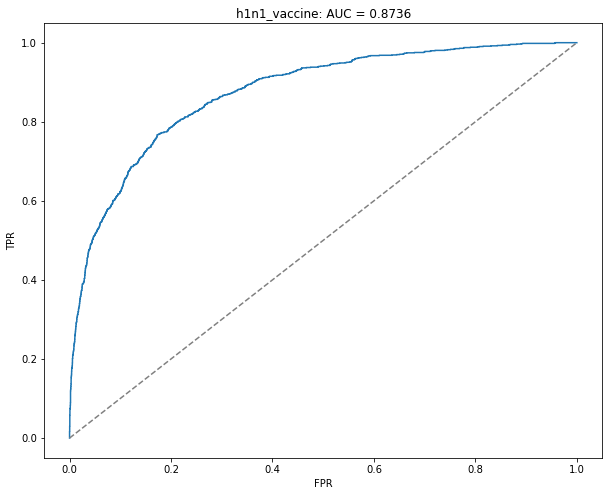

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_roc(
    y1_test, 
    h1n1_proba, 
    'h1n1_vaccine',
    ax=ax
)

In [26]:
cat_grid.fit(X_train, y2_train, eval_set=(X_val,y2_val),verbose=10,use_best_model = True,plot = True)
best_param_sea = cat_grid.best_params_
best_param_sea

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 4.71ms	remaining: 1.88s
10:	learn: 0.8329899	test: 0.8377077	best: 0.8377077 (10)	total: 41.3ms	remaining: 1.46s
20:	learn: 0.8438581	test: 0.8465006	best: 0.8465006 (20)	total: 83ms	remaining: 1.5s
30:	learn: 0.8496793	test: 0.8509781	best: 0.8509781 (30)	total: 127ms	remaining: 1.51s
40:	learn: 0.8533419	test: 0.8537239	best: 0.8537239 (40)	total: 169ms	remaining: 1.48s
50:	learn: 0.8560630	test: 0.8553089	best: 0.8553089 (50)	total: 213ms	remaining: 1.46s
60:	learn: 0.8580614	test: 0.8564522	best: 0.8564522 (60)	total: 257ms	remaining: 1.43s
70:	learn: 0.8600689	test: 0.8570625	best: 0.8570625 (70)	total: 299ms	remaining: 1.39s
80:	learn: 0.8612427	test: 0.8575116	best: 0.8575116 (80)	total: 340ms	remaining: 1.34s
90:	learn: 0.8625288	test: 0.8578807	best: 0.8580248 (89)	total: 380ms	remaining: 1.29s
100:	learn: 0.8645787	test: 0.8590266	best: 0.8590266 (100)	total: 421ms	remaining: 1.25s
110:	learn: 0.8664966	test: 0.85

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 3.27ms	remaining: 1.31s
10:	learn: 0.8377419	test: 0.8373896	best: 0.8373896 (10)	total: 42.4ms	remaining: 1.5s
20:	learn: 0.8475540	test: 0.8458648	best: 0.8458648 (20)	total: 79.3ms	remaining: 1.43s
30:	learn: 0.8526523	test: 0.8497460	best: 0.8497460 (30)	total: 121ms	remaining: 1.43s
40:	learn: 0.8564053	test: 0.8530139	best: 0.8530139 (40)	total: 163ms	remaining: 1.43s
50:	learn: 0.8591350	test: 0.8552706	best: 0.8552706 (50)	total: 204ms	remaining: 1.4s
60:	learn: 0.8611084	test: 0.8561143	best: 0.8561143 (60)	total: 249ms	remaining: 1.38s
70:	learn: 0.8629594	test: 0.8573411	best: 0.8573411 (70)	total: 287ms	remaining: 1.33s
80:	learn: 0.8647983	test: 0.8576583	best: 0.8576583 (80)	total: 330ms	remaining: 1.3s
90:	learn: 0.8663722	test: 0.8579510	best: 0.8579510 (90)	total: 372ms	remaining: 1.26s
100:	learn: 0.8684467	test: 0.8584176	best: 0.8586988 (97)	total: 415ms	remaining: 1.23s
110:	learn: 0.8699530	test: 0.858

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 3.27ms	remaining: 1.3s
10:	learn: 0.8367435	test: 0.8377187	best: 0.8377187 (10)	total: 81.5ms	remaining: 2.88s
20:	learn: 0.8462607	test: 0.8452830	best: 0.8452830 (20)	total: 149ms	remaining: 2.68s
30:	learn: 0.8522934	test: 0.8517242	best: 0.8517242 (30)	total: 187ms	remaining: 2.22s
40:	learn: 0.8558889	test: 0.8545803	best: 0.8545803 (40)	total: 225ms	remaining: 1.97s
50:	learn: 0.8594115	test: 0.8571231	best: 0.8571231 (50)	total: 264ms	remaining: 1.8s
60:	learn: 0.8617590	test: 0.8579075	best: 0.8579075 (60)	total: 306ms	remaining: 1.7s
70:	learn: 0.8633998	test: 0.8582401	best: 0.8584510 (64)	total: 345ms	remaining: 1.6s
80:	learn: 0.8652250	test: 0.8590170	best: 0.8591690 (79)	total: 384ms	remaining: 1.51s
90:	learn: 0.8666579	test: 0.8595574	best: 0.8595574 (90)	total: 420ms	remaining: 1.43s
100:	learn: 0.8684481	test: 0.8603448	best: 0.8603818 (98)	total: 457ms	remaining: 1.35s
110:	learn: 0.8700671	test: 0.86030

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 4.18ms	remaining: 1.67s
10:	learn: 0.8368996	test: 0.8373303	best: 0.8373303 (10)	total: 40.7ms	remaining: 1.44s
20:	learn: 0.8473565	test: 0.8464193	best: 0.8464193 (20)	total: 84.4ms	remaining: 1.52s
30:	learn: 0.8527086	test: 0.8511156	best: 0.8511156 (30)	total: 127ms	remaining: 1.51s
40:	learn: 0.8560917	test: 0.8535921	best: 0.8535921 (40)	total: 166ms	remaining: 1.45s
50:	learn: 0.8587898	test: 0.8551827	best: 0.8551827 (50)	total: 203ms	remaining: 1.39s
60:	learn: 0.8605531	test: 0.8567628	best: 0.8567628 (60)	total: 242ms	remaining: 1.34s
70:	learn: 0.8624443	test: 0.8576100	best: 0.8576100 (70)	total: 280ms	remaining: 1.3s
80:	learn: 0.8639701	test: 0.8584220	best: 0.8584220 (80)	total: 315ms	remaining: 1.24s
90:	learn: 0.8658654	test: 0.8587885	best: 0.8588245 (87)	total: 355ms	remaining: 1.2s
100:	learn: 0.8672721	test: 0.8587973	best: 0.8589941 (98)	total: 394ms	remaining: 1.17s
110:	learn: 0.8688558	test: 0.85

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 3.46ms	remaining: 1.38s
10:	learn: 0.8347192	test: 0.8380773	best: 0.8380773 (10)	total: 38.6ms	remaining: 1.36s
20:	learn: 0.8463808	test: 0.8464615	best: 0.8464615 (20)	total: 74.5ms	remaining: 1.34s
30:	learn: 0.8514333	test: 0.8505796	best: 0.8505796 (30)	total: 112ms	remaining: 1.33s
40:	learn: 0.8554030	test: 0.8537059	best: 0.8537059 (40)	total: 150ms	remaining: 1.31s
50:	learn: 0.8587816	test: 0.8564658	best: 0.8564658 (50)	total: 190ms	remaining: 1.3s
60:	learn: 0.8605357	test: 0.8580046	best: 0.8580046 (60)	total: 230ms	remaining: 1.28s
70:	learn: 0.8625520	test: 0.8586294	best: 0.8586294 (70)	total: 270ms	remaining: 1.25s
80:	learn: 0.8641606	test: 0.8594678	best: 0.8594678 (80)	total: 309ms	remaining: 1.22s
90:	learn: 0.8658642	test: 0.8600997	best: 0.8601700 (89)	total: 346ms	remaining: 1.17s
100:	learn: 0.8672820	test: 0.8603853	best: 0.8606252 (97)	total: 384ms	remaining: 1.14s
110:	learn: 0.8688258	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150717	test: 0.8162407	best: 0.8162407 (0)	total: 3.94ms	remaining: 1.57s
10:	learn: 0.8471077	test: 0.8464400	best: 0.8464400 (10)	total: 48.2ms	remaining: 1.7s
20:	learn: 0.8547189	test: 0.8512584	best: 0.8512584 (20)	total: 98.1ms	remaining: 1.77s
30:	learn: 0.8618495	test: 0.8558480	best: 0.8558480 (30)	total: 150ms	remaining: 1.78s
40:	learn: 0.8667931	test: 0.8572558	best: 0.8572558 (40)	total: 197ms	remaining: 1.73s
50:	learn: 0.8704067	test: 0.8577779	best: 0.8583174 (48)	total: 247ms	remaining: 1.69s
60:	learn: 0.8739761	test: 0.8584484	best: 0.8584484 (60)	total: 294ms	remaining: 1.63s
70:	learn: 0.8773875	test: 0.8591532	best: 0.8591532 (70)	total: 342ms	remaining: 1.58s
80:	learn: 0.8806330	test: 0.8593026	best: 0.8593826 (77)	total: 391ms	remaining: 1.54s
90:	learn: 0.8839751	test: 0.8602060	best: 0.8602060 (90)	total: 436ms	remaining: 1.48s
100:	learn: 0.8871478	test: 0.8603861	best: 0.8606217 (98)	total: 481ms	remaining: 1.42s
110:	learn: 0.8906307	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185513	test: 0.8141958	best: 0.8141958 (0)	total: 4.45ms	remaining: 1.78s
10:	learn: 0.8470837	test: 0.8437693	best: 0.8437693 (10)	total: 49.5ms	remaining: 1.75s
20:	learn: 0.8584704	test: 0.8504895	best: 0.8504895 (20)	total: 97.6ms	remaining: 1.76s
30:	learn: 0.8646295	test: 0.8535860	best: 0.8535860 (30)	total: 146ms	remaining: 1.74s
40:	learn: 0.8700888	test: 0.8554912	best: 0.8554912 (40)	total: 195ms	remaining: 1.7s
50:	learn: 0.8737730	test: 0.8558252	best: 0.8562215 (46)	total: 245ms	remaining: 1.68s
60:	learn: 0.8772691	test: 0.8564755	best: 0.8564755 (60)	total: 294ms	remaining: 1.63s
70:	learn: 0.8802413	test: 0.8576487	best: 0.8576724 (68)	total: 339ms	remaining: 1.57s
80:	learn: 0.8830254	test: 0.8580020	best: 0.8580020 (80)	total: 382ms	remaining: 1.51s
90:	learn: 0.8861466	test: 0.8588641	best: 0.8589642 (89)	total: 426ms	remaining: 1.45s
100:	learn: 0.8890274	test: 0.8587999	best: 0.8589642 (89)	total: 472ms	remaining: 1.4s
110:	learn: 0.8924005	test: 0.85

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8167110	test: 0.8152081	best: 0.8152081 (0)	total: 4.07ms	remaining: 1.62s
10:	learn: 0.8490717	test: 0.8464962	best: 0.8464962 (10)	total: 48ms	remaining: 1.7s
20:	learn: 0.8586972	test: 0.8523174	best: 0.8523174 (20)	total: 92.2ms	remaining: 1.66s
30:	learn: 0.8640092	test: 0.8535271	best: 0.8537494 (27)	total: 141ms	remaining: 1.68s
40:	learn: 0.8688286	test: 0.8563006	best: 0.8563006 (40)	total: 188ms	remaining: 1.65s
50:	learn: 0.8732729	test: 0.8572945	best: 0.8574852 (49)	total: 234ms	remaining: 1.6s
60:	learn: 0.8768397	test: 0.8572980	best: 0.8578798 (55)	total: 279ms	remaining: 1.55s
70:	learn: 0.8801775	test: 0.8576214	best: 0.8578798 (55)	total: 322ms	remaining: 1.49s
80:	learn: 0.8832635	test: 0.8572866	best: 0.8578798 (55)	total: 371ms	remaining: 1.46s
90:	learn: 0.8867012	test: 0.8578903	best: 0.8581232 (87)	total: 416ms	remaining: 1.41s
100:	learn: 0.8900429	test: 0.8568252	best: 0.8581232 (87)	total: 461ms	remaining: 1.36s
110:	learn: 0.8929881	test: 0.8564

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172781	test: 0.8133407	best: 0.8133407 (0)	total: 4.25ms	remaining: 1.7s
10:	learn: 0.8492868	test: 0.8448454	best: 0.8448454 (10)	total: 47.5ms	remaining: 1.68s
20:	learn: 0.8580880	test: 0.8502469	best: 0.8502469 (20)	total: 92.1ms	remaining: 1.66s
30:	learn: 0.8648639	test: 0.8536176	best: 0.8536176 (30)	total: 136ms	remaining: 1.61s
40:	learn: 0.8697126	test: 0.8554165	best: 0.8554165 (40)	total: 181ms	remaining: 1.59s
50:	learn: 0.8734000	test: 0.8563893	best: 0.8564386 (49)	total: 227ms	remaining: 1.55s
60:	learn: 0.8766567	test: 0.8574668	best: 0.8577260 (57)	total: 270ms	remaining: 1.5s
70:	learn: 0.8798678	test: 0.8582401	best: 0.8582445 (69)	total: 315ms	remaining: 1.46s
80:	learn: 0.8829078	test: 0.8583921	best: 0.8584581 (79)	total: 362ms	remaining: 1.43s
90:	learn: 0.8859500	test: 0.8591259	best: 0.8592613 (84)	total: 409ms	remaining: 1.39s
100:	learn: 0.8889586	test: 0.8589475	best: 0.8593008 (94)	total: 457ms	remaining: 1.35s
110:	learn: 0.8921750	test: 0.85

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177705	test: 0.8138355	best: 0.8138355 (0)	total: 3.97ms	remaining: 1.58s
10:	learn: 0.8488345	test: 0.8449904	best: 0.8449904 (10)	total: 47.3ms	remaining: 1.67s
20:	learn: 0.8578313	test: 0.8513230	best: 0.8513230 (20)	total: 93.8ms	remaining: 1.69s
30:	learn: 0.8643790	test: 0.8541783	best: 0.8541783 (30)	total: 138ms	remaining: 1.64s
40:	learn: 0.8696889	test: 0.8558990	best: 0.8558990 (40)	total: 183ms	remaining: 1.6s
50:	learn: 0.8733555	test: 0.8571996	best: 0.8571996 (50)	total: 227ms	remaining: 1.55s
60:	learn: 0.8767913	test: 0.8579114	best: 0.8579519 (59)	total: 272ms	remaining: 1.51s
70:	learn: 0.8796203	test: 0.8584923	best: 0.8584923 (70)	total: 319ms	remaining: 1.48s
80:	learn: 0.8823739	test: 0.8584554	best: 0.8586742 (71)	total: 366ms	remaining: 1.44s
90:	learn: 0.8854377	test: 0.8582586	best: 0.8593079 (84)	total: 409ms	remaining: 1.39s
100:	learn: 0.8885673	test: 0.8581935	best: 0.8593079 (84)	total: 455ms	remaining: 1.35s
110:	learn: 0.8920593	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 3.28ms	remaining: 1.31s
10:	learn: 0.8243947	test: 0.8297923	best: 0.8297923 (10)	total: 40.3ms	remaining: 1.42s
20:	learn: 0.8336765	test: 0.8371831	best: 0.8371831 (20)	total: 78.6ms	remaining: 1.42s
30:	learn: 0.8388956	test: 0.8420561	best: 0.8420561 (30)	total: 118ms	remaining: 1.4s
40:	learn: 0.8434939	test: 0.8451046	best: 0.8451046 (40)	total: 155ms	remaining: 1.36s
50:	learn: 0.8474445	test: 0.8482723	best: 0.8482723 (50)	total: 192ms	remaining: 1.32s
60:	learn: 0.8496132	test: 0.8507197	best: 0.8507197 (60)	total: 230ms	remaining: 1.28s
70:	learn: 0.8516328	test: 0.8525055	best: 0.8525055 (70)	total: 267ms	remaining: 1.24s
80:	learn: 0.8534581	test: 0.8534594	best: 0.8534594 (80)	total: 305ms	remaining: 1.2s
90:	learn: 0.8547320	test: 0.8542653	best: 0.8542653 (90)	total: 345ms	remaining: 1.17s
100:	learn: 0.8558247	test: 0.8547864	best: 0.8547864 (100)	total: 386ms	remaining: 1.14s
110:	learn: 0.8568308	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 3.53ms	remaining: 1.41s
10:	learn: 0.8315082	test: 0.8329222	best: 0.8329222 (10)	total: 37.5ms	remaining: 1.33s
20:	learn: 0.8373467	test: 0.8377521	best: 0.8377521 (20)	total: 77ms	remaining: 1.39s
30:	learn: 0.8422977	test: 0.8417160	best: 0.8417160 (30)	total: 115ms	remaining: 1.37s
40:	learn: 0.8469478	test: 0.8454979	best: 0.8454979 (40)	total: 155ms	remaining: 1.35s
50:	learn: 0.8498999	test: 0.8483355	best: 0.8483355 (50)	total: 192ms	remaining: 1.31s
60:	learn: 0.8530454	test: 0.8504218	best: 0.8504218 (60)	total: 231ms	remaining: 1.28s
70:	learn: 0.8551331	test: 0.8520902	best: 0.8520902 (70)	total: 269ms	remaining: 1.25s
80:	learn: 0.8569777	test: 0.8537556	best: 0.8537556 (80)	total: 308ms	remaining: 1.21s
90:	learn: 0.8584576	test: 0.8547640	best: 0.8547640 (90)	total: 346ms	remaining: 1.17s
100:	learn: 0.8595486	test: 0.8555334	best: 0.8555334 (100)	total: 381ms	remaining: 1.13s
110:	learn: 0.8606279	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 2.78ms	remaining: 1.11s
10:	learn: 0.8255093	test: 0.8285976	best: 0.8285976 (10)	total: 36.6ms	remaining: 1.3s
20:	learn: 0.8357347	test: 0.8366400	best: 0.8366400 (20)	total: 73.2ms	remaining: 1.32s
30:	learn: 0.8423626	test: 0.8423149	best: 0.8423149 (30)	total: 110ms	remaining: 1.31s
40:	learn: 0.8469228	test: 0.8454012	best: 0.8454012 (40)	total: 147ms	remaining: 1.28s
50:	learn: 0.8503395	test: 0.8486963	best: 0.8486963 (50)	total: 187ms	remaining: 1.28s
60:	learn: 0.8525532	test: 0.8506758	best: 0.8506758 (60)	total: 227ms	remaining: 1.26s
70:	learn: 0.8545046	test: 0.8521355	best: 0.8521355 (70)	total: 266ms	remaining: 1.23s
80:	learn: 0.8562495	test: 0.8533715	best: 0.8533715 (80)	total: 303ms	remaining: 1.19s
90:	learn: 0.8579044	test: 0.8549323	best: 0.8549323 (90)	total: 341ms	remaining: 1.16s
100:	learn: 0.8592510	test: 0.8558085	best: 0.8558295 (99)	total: 378ms	remaining: 1.12s
110:	learn: 0.8602320	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 2.94ms	remaining: 1.17s
10:	learn: 0.8252416	test: 0.8281419	best: 0.8281419 (10)	total: 38.3ms	remaining: 1.35s
20:	learn: 0.8351451	test: 0.8369304	best: 0.8369304 (20)	total: 77.9ms	remaining: 1.41s
30:	learn: 0.8412331	test: 0.8414664	best: 0.8414664 (30)	total: 117ms	remaining: 1.39s
40:	learn: 0.8466358	test: 0.8456991	best: 0.8456991 (40)	total: 155ms	remaining: 1.35s
50:	learn: 0.8502420	test: 0.8488123	best: 0.8488123 (50)	total: 192ms	remaining: 1.31s
60:	learn: 0.8530962	test: 0.8510172	best: 0.8510172 (60)	total: 230ms	remaining: 1.28s
70:	learn: 0.8549696	test: 0.8525973	best: 0.8525973 (70)	total: 266ms	remaining: 1.23s
80:	learn: 0.8568086	test: 0.8539937	best: 0.8539937 (80)	total: 305ms	remaining: 1.2s
90:	learn: 0.8581494	test: 0.8548180	best: 0.8548180 (90)	total: 347ms	remaining: 1.18s
100:	learn: 0.8594851	test: 0.8558717	best: 0.8558717 (100)	total: 388ms	remaining: 1.15s
110:	learn: 0.8606109	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 2.81ms	remaining: 1.12s
10:	learn: 0.8283939	test: 0.8308557	best: 0.8310209 (9)	total: 37.4ms	remaining: 1.32s
20:	learn: 0.8364330	test: 0.8383730	best: 0.8383730 (20)	total: 74.5ms	remaining: 1.34s
30:	learn: 0.8423667	test: 0.8429256	best: 0.8429256 (30)	total: 112ms	remaining: 1.34s
40:	learn: 0.8467244	test: 0.8463420	best: 0.8463420 (40)	total: 151ms	remaining: 1.32s
50:	learn: 0.8497666	test: 0.8493822	best: 0.8493822 (50)	total: 191ms	remaining: 1.31s
60:	learn: 0.8521299	test: 0.8509961	best: 0.8509961 (60)	total: 232ms	remaining: 1.29s
70:	learn: 0.8544735	test: 0.8530543	best: 0.8530543 (70)	total: 275ms	remaining: 1.27s
80:	learn: 0.8562192	test: 0.8546585	best: 0.8546585 (80)	total: 316ms	remaining: 1.24s
90:	learn: 0.8576349	test: 0.8551406	best: 0.8551599 (89)	total: 357ms	remaining: 1.21s
100:	learn: 0.8592323	test: 0.8562057	best: 0.8562233 (99)	total: 399ms	remaining: 1.18s
110:	learn: 0.8601612	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150717	test: 0.8162407	best: 0.8162407 (0)	total: 4.25ms	remaining: 1.7s
10:	learn: 0.8383835	test: 0.8396578	best: 0.8396578 (10)	total: 50.5ms	remaining: 1.79s
20:	learn: 0.8454555	test: 0.8452632	best: 0.8452632 (20)	total: 96.1ms	remaining: 1.73s
30:	learn: 0.8509855	test: 0.8492306	best: 0.8492306 (30)	total: 140ms	remaining: 1.67s
40:	learn: 0.8549805	test: 0.8515252	best: 0.8515252 (40)	total: 185ms	remaining: 1.62s
50:	learn: 0.8588754	test: 0.8532784	best: 0.8532784 (50)	total: 230ms	remaining: 1.57s
60:	learn: 0.8622007	test: 0.8556845	best: 0.8556845 (60)	total: 274ms	remaining: 1.52s
70:	learn: 0.8646313	test: 0.8570810	best: 0.8570810 (70)	total: 322ms	remaining: 1.49s
80:	learn: 0.8670988	test: 0.8577242	best: 0.8577849 (78)	total: 367ms	remaining: 1.44s
90:	learn: 0.8696183	test: 0.8580063	best: 0.8580380 (89)	total: 412ms	remaining: 1.4s
100:	learn: 0.8717790	test: 0.8590688	best: 0.8590688 (100)	total: 458ms	remaining: 1.35s
110:	learn: 0.8738268	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185513	test: 0.8141958	best: 0.8141958 (0)	total: 4.08ms	remaining: 1.63s
10:	learn: 0.8425690	test: 0.8405638	best: 0.8405638 (10)	total: 51.9ms	remaining: 1.83s
20:	learn: 0.8477668	test: 0.8443765	best: 0.8443765 (20)	total: 99.6ms	remaining: 1.8s
30:	learn: 0.8539117	test: 0.8489428	best: 0.8489428 (30)	total: 147ms	remaining: 1.75s
40:	learn: 0.8584110	test: 0.8516486	best: 0.8516486 (40)	total: 196ms	remaining: 1.72s
50:	learn: 0.8619262	test: 0.8534221	best: 0.8534221 (50)	total: 243ms	remaining: 1.67s
60:	learn: 0.8646067	test: 0.8544569	best: 0.8544569 (60)	total: 305ms	remaining: 1.69s
70:	learn: 0.8672215	test: 0.8559543	best: 0.8559543 (70)	total: 356ms	remaining: 1.65s
80:	learn: 0.8693446	test: 0.8563656	best: 0.8563656 (80)	total: 400ms	remaining: 1.58s
90:	learn: 0.8712434	test: 0.8566196	best: 0.8566196 (90)	total: 451ms	remaining: 1.53s
100:	learn: 0.8733007	test: 0.8573253	best: 0.8573332 (99)	total: 498ms	remaining: 1.47s
110:	learn: 0.8752298	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8167110	test: 0.8152081	best: 0.8152081 (0)	total: 5.08ms	remaining: 2.03s
10:	learn: 0.8391743	test: 0.8395242	best: 0.8395242 (10)	total: 50.8ms	remaining: 1.8s
20:	learn: 0.8479504	test: 0.8444780	best: 0.8444780 (20)	total: 100ms	remaining: 1.81s
30:	learn: 0.8541043	test: 0.8488677	best: 0.8488677 (30)	total: 149ms	remaining: 1.77s
40:	learn: 0.8587526	test: 0.8516429	best: 0.8516429 (40)	total: 198ms	remaining: 1.73s
50:	learn: 0.8620664	test: 0.8535728	best: 0.8535728 (50)	total: 248ms	remaining: 1.7s
60:	learn: 0.8654833	test: 0.8552926	best: 0.8552926 (60)	total: 296ms	remaining: 1.64s
70:	learn: 0.8680447	test: 0.8563138	best: 0.8563138 (70)	total: 344ms	remaining: 1.59s
80:	learn: 0.8703460	test: 0.8572805	best: 0.8572805 (80)	total: 394ms	remaining: 1.55s
90:	learn: 0.8725463	test: 0.8576249	best: 0.8576249 (90)	total: 445ms	remaining: 1.51s
100:	learn: 0.8743248	test: 0.8580617	best: 0.8582129 (99)	total: 492ms	remaining: 1.46s
110:	learn: 0.8761727	test: 0.858

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172781	test: 0.8133407	best: 0.8133407 (0)	total: 4.96ms	remaining: 1.98s
10:	learn: 0.8416022	test: 0.8411162	best: 0.8411162 (10)	total: 48.3ms	remaining: 1.71s
20:	learn: 0.8489256	test: 0.8453265	best: 0.8453265 (20)	total: 98.3ms	remaining: 1.77s
30:	learn: 0.8542547	test: 0.8492513	best: 0.8492513 (30)	total: 147ms	remaining: 1.75s
40:	learn: 0.8587149	test: 0.8515731	best: 0.8515731 (40)	total: 199ms	remaining: 1.74s
50:	learn: 0.8621549	test: 0.8533408	best: 0.8533408 (50)	total: 249ms	remaining: 1.7s
60:	learn: 0.8653943	test: 0.8553752	best: 0.8553752 (60)	total: 302ms	remaining: 1.68s
70:	learn: 0.8677315	test: 0.8564667	best: 0.8564667 (70)	total: 354ms	remaining: 1.64s
80:	learn: 0.8696422	test: 0.8570089	best: 0.8570089 (80)	total: 405ms	remaining: 1.59s
90:	learn: 0.8715496	test: 0.8577366	best: 0.8578086 (89)	total: 453ms	remaining: 1.54s
100:	learn: 0.8735320	test: 0.8581821	best: 0.8581821 (100)	total: 507ms	remaining: 1.5s
110:	learn: 0.8753993	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177705	test: 0.8138355	best: 0.8138355 (0)	total: 3.63ms	remaining: 1.45s
10:	learn: 0.8414199	test: 0.8410098	best: 0.8410098 (10)	total: 47.5ms	remaining: 1.68s
20:	learn: 0.8472670	test: 0.8446226	best: 0.8446903 (19)	total: 93.8ms	remaining: 1.69s
30:	learn: 0.8527925	test: 0.8483685	best: 0.8483685 (30)	total: 143ms	remaining: 1.7s
40:	learn: 0.8566986	test: 0.8514272	best: 0.8514272 (40)	total: 192ms	remaining: 1.68s
50:	learn: 0.8604905	test: 0.8531536	best: 0.8531536 (50)	total: 244ms	remaining: 1.67s
60:	learn: 0.8638136	test: 0.8548822	best: 0.8548822 (60)	total: 293ms	remaining: 1.63s
70:	learn: 0.8667249	test: 0.8563296	best: 0.8563296 (70)	total: 341ms	remaining: 1.58s
80:	learn: 0.8689418	test: 0.8573024	best: 0.8573024 (80)	total: 389ms	remaining: 1.53s
90:	learn: 0.8710393	test: 0.8575353	best: 0.8576952 (87)	total: 436ms	remaining: 1.48s
100:	learn: 0.8730978	test: 0.8579132	best: 0.8579132 (100)	total: 486ms	remaining: 1.44s
110:	learn: 0.8750580	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 3.36ms	remaining: 1.34s
10:	learn: 0.8203897	test: 0.8266642	best: 0.8271436 (8)	total: 38.2ms	remaining: 1.35s
20:	learn: 0.8225761	test: 0.8294241	best: 0.8294241 (20)	total: 74.7ms	remaining: 1.35s
30:	learn: 0.8240706	test: 0.8304791	best: 0.8304791 (30)	total: 111ms	remaining: 1.32s
40:	learn: 0.8242250	test: 0.8308254	best: 0.8308799 (36)	total: 150ms	remaining: 1.31s
50:	learn: 0.8254444	test: 0.8318347	best: 0.8318347 (47)	total: 228ms	remaining: 1.56s
60:	learn: 0.8264514	test: 0.8328862	best: 0.8328862 (60)	total: 274ms	remaining: 1.52s
70:	learn: 0.8284714	test: 0.8345805	best: 0.8345805 (70)	total: 313ms	remaining: 1.45s
80:	learn: 0.8301156	test: 0.8357396	best: 0.8358064 (79)	total: 350ms	remaining: 1.38s
90:	learn: 0.8315127	test: 0.8364567	best: 0.8364567 (90)	total: 387ms	remaining: 1.31s
100:	learn: 0.8329185	test: 0.8373285	best: 0.8373285 (100)	total: 424ms	remaining: 1.26s
110:	learn: 0.8344533	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 3.19ms	remaining: 1.27s
10:	learn: 0.8238069	test: 0.8262292	best: 0.8262292 (10)	total: 39.2ms	remaining: 1.39s
20:	learn: 0.8248950	test: 0.8273871	best: 0.8276841 (19)	total: 76.4ms	remaining: 1.38s
30:	learn: 0.8251062	test: 0.8275386	best: 0.8276841 (19)	total: 112ms	remaining: 1.34s
40:	learn: 0.8273722	test: 0.8296346	best: 0.8296346 (40)	total: 149ms	remaining: 1.3s
50:	learn: 0.8288134	test: 0.8312428	best: 0.8312428 (50)	total: 185ms	remaining: 1.27s
60:	learn: 0.8299308	test: 0.8321989	best: 0.8322754 (59)	total: 221ms	remaining: 1.23s
70:	learn: 0.8314196	test: 0.8335259	best: 0.8335259 (70)	total: 257ms	remaining: 1.19s
80:	learn: 0.8328459	test: 0.8349553	best: 0.8349553 (80)	total: 297ms	remaining: 1.17s
90:	learn: 0.8341870	test: 0.8363223	best: 0.8363223 (90)	total: 334ms	remaining: 1.13s
100:	learn: 0.8358215	test: 0.8376752	best: 0.8376752 (100)	total: 374ms	remaining: 1.11s
110:	learn: 0.8372123	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 3.26ms	remaining: 1.3s
10:	learn: 0.8229352	test: 0.8273141	best: 0.8273141 (10)	total: 37.8ms	remaining: 1.34s
20:	learn: 0.8251622	test: 0.8289386	best: 0.8289386 (20)	total: 74.6ms	remaining: 1.35s
30:	learn: 0.8258978	test: 0.8293094	best: 0.8293094 (30)	total: 113ms	remaining: 1.34s
40:	learn: 0.8268875	test: 0.8303671	best: 0.8303671 (40)	total: 151ms	remaining: 1.32s
50:	learn: 0.8275032	test: 0.8311655	best: 0.8311655 (50)	total: 188ms	remaining: 1.28s
60:	learn: 0.8291573	test: 0.8323365	best: 0.8324498 (59)	total: 225ms	remaining: 1.25s
70:	learn: 0.8301332	test: 0.8333401	best: 0.8333401 (70)	total: 265ms	remaining: 1.23s
80:	learn: 0.8318842	test: 0.8348143	best: 0.8348143 (80)	total: 303ms	remaining: 1.19s
90:	learn: 0.8338315	test: 0.8359593	best: 0.8359593 (90)	total: 341ms	remaining: 1.16s
100:	learn: 0.8358035	test: 0.8374630	best: 0.8374630 (100)	total: 377ms	remaining: 1.11s
110:	learn: 0.8372228	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 3.22ms	remaining: 1.29s
10:	learn: 0.8249684	test: 0.8280919	best: 0.8280919 (10)	total: 39.2ms	remaining: 1.39s
20:	learn: 0.8257694	test: 0.8291034	best: 0.8291034 (20)	total: 75.9ms	remaining: 1.37s
30:	learn: 0.8260412	test: 0.8290990	best: 0.8292633 (23)	total: 112ms	remaining: 1.33s
40:	learn: 0.8268477	test: 0.8302963	best: 0.8302963 (40)	total: 149ms	remaining: 1.3s
50:	learn: 0.8280869	test: 0.8314651	best: 0.8314651 (50)	total: 188ms	remaining: 1.28s
60:	learn: 0.8289977	test: 0.8324125	best: 0.8324125 (60)	total: 226ms	remaining: 1.25s
70:	learn: 0.8303612	test: 0.8332280	best: 0.8333537 (69)	total: 266ms	remaining: 1.23s
80:	learn: 0.8313405	test: 0.8344403	best: 0.8344403 (80)	total: 305ms	remaining: 1.2s
90:	learn: 0.8328898	test: 0.8354294	best: 0.8354294 (90)	total: 342ms	remaining: 1.16s
100:	learn: 0.8352576	test: 0.8371145	best: 0.8371145 (100)	total: 379ms	remaining: 1.12s
110:	learn: 0.8366677	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 2.81ms	remaining: 1.12s
10:	learn: 0.8234109	test: 0.8277597	best: 0.8278010 (9)	total: 39.2ms	remaining: 1.39s
20:	learn: 0.8236976	test: 0.8283691	best: 0.8286341 (18)	total: 74.6ms	remaining: 1.35s
30:	learn: 0.8248495	test: 0.8290366	best: 0.8290717 (29)	total: 111ms	remaining: 1.32s
40:	learn: 0.8268800	test: 0.8308139	best: 0.8308139 (40)	total: 148ms	remaining: 1.3s
50:	learn: 0.8284724	test: 0.8324942	best: 0.8326568 (49)	total: 185ms	remaining: 1.26s
60:	learn: 0.8284528	test: 0.8324815	best: 0.8328818 (54)	total: 224ms	remaining: 1.24s
70:	learn: 0.8300888	test: 0.8336015	best: 0.8336015 (70)	total: 261ms	remaining: 1.21s
80:	learn: 0.8316359	test: 0.8349553	best: 0.8349553 (80)	total: 301ms	remaining: 1.19s
90:	learn: 0.8334999	test: 0.8365284	best: 0.8365284 (90)	total: 340ms	remaining: 1.15s
100:	learn: 0.8350595	test: 0.8377279	best: 0.8377279 (100)	total: 379ms	remaining: 1.12s
110:	learn: 0.8370447	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150717	test: 0.8162407	best: 0.8162407 (0)	total: 3.84ms	remaining: 1.53s
10:	learn: 0.8333426	test: 0.8366540	best: 0.8366984 (9)	total: 47.8ms	remaining: 1.69s
20:	learn: 0.8355161	test: 0.8373799	best: 0.8380127 (16)	total: 91.7ms	remaining: 1.66s
30:	learn: 0.8369993	test: 0.8390501	best: 0.8390501 (30)	total: 134ms	remaining: 1.6s
40:	learn: 0.8379657	test: 0.8402145	best: 0.8402145 (40)	total: 177ms	remaining: 1.55s
50:	learn: 0.8388469	test: 0.8407207	best: 0.8407207 (50)	total: 222ms	remaining: 1.52s
60:	learn: 0.8400788	test: 0.8415244	best: 0.8415244 (60)	total: 265ms	remaining: 1.47s
70:	learn: 0.8411176	test: 0.8422924	best: 0.8422924 (69)	total: 308ms	remaining: 1.43s
80:	learn: 0.8425527	test: 0.8433918	best: 0.8433918 (80)	total: 354ms	remaining: 1.39s
90:	learn: 0.8436198	test: 0.8442601	best: 0.8442601 (90)	total: 398ms	remaining: 1.35s
100:	learn: 0.8448977	test: 0.8451354	best: 0.8451354 (100)	total: 441ms	remaining: 1.31s
110:	learn: 0.8462639	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185513	test: 0.8141958	best: 0.8141958 (0)	total: 4.12ms	remaining: 1.64s
10:	learn: 0.8355566	test: 0.8355547	best: 0.8361439 (5)	total: 45ms	remaining: 1.59s
20:	learn: 0.8379698	test: 0.8369335	best: 0.8369977 (17)	total: 88ms	remaining: 1.59s
30:	learn: 0.8378659	test: 0.8369036	best: 0.8369977 (17)	total: 135ms	remaining: 1.6s
40:	learn: 0.8386540	test: 0.8378716	best: 0.8379129 (38)	total: 178ms	remaining: 1.55s
50:	learn: 0.8402635	test: 0.8391916	best: 0.8391916 (50)	total: 223ms	remaining: 1.53s
60:	learn: 0.8421814	test: 0.8406636	best: 0.8406636 (60)	total: 268ms	remaining: 1.49s
70:	learn: 0.8436242	test: 0.8417603	best: 0.8417603 (70)	total: 312ms	remaining: 1.45s
80:	learn: 0.8451939	test: 0.8430750	best: 0.8430750 (80)	total: 359ms	remaining: 1.41s
90:	learn: 0.8469356	test: 0.8441419	best: 0.8441419 (90)	total: 404ms	remaining: 1.37s
100:	learn: 0.8483661	test: 0.8451402	best: 0.8451402 (100)	total: 451ms	remaining: 1.34s
110:	learn: 0.8495867	test: 0.84580

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8167110	test: 0.8152081	best: 0.8152081 (0)	total: 4.03ms	remaining: 1.61s
10:	learn: 0.8361746	test: 0.8357761	best: 0.8362753 (9)	total: 47.4ms	remaining: 1.68s
20:	learn: 0.8378524	test: 0.8370227	best: 0.8370227 (20)	total: 92.5ms	remaining: 1.67s
30:	learn: 0.8397299	test: 0.8383967	best: 0.8383967 (30)	total: 138ms	remaining: 1.64s
40:	learn: 0.8415913	test: 0.8396442	best: 0.8398771 (39)	total: 182ms	remaining: 1.59s
50:	learn: 0.8428896	test: 0.8407585	best: 0.8407585 (50)	total: 227ms	remaining: 1.55s
60:	learn: 0.8441200	test: 0.8414800	best: 0.8414800 (60)	total: 275ms	remaining: 1.53s
70:	learn: 0.8451000	test: 0.8424225	best: 0.8424225 (70)	total: 336ms	remaining: 1.55s
80:	learn: 0.8465834	test: 0.8434780	best: 0.8434780 (80)	total: 396ms	remaining: 1.56s
90:	learn: 0.8476082	test: 0.8442056	best: 0.8442056 (90)	total: 442ms	remaining: 1.5s
100:	learn: 0.8492295	test: 0.8452839	best: 0.8452839 (100)	total: 490ms	remaining: 1.45s
110:	learn: 0.8504368	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172781	test: 0.8133407	best: 0.8133407 (0)	total: 4.22ms	remaining: 1.68s
10:	learn: 0.8359173	test: 0.8364836	best: 0.8364915 (6)	total: 48.4ms	remaining: 1.71s
20:	learn: 0.8365387	test: 0.8374454	best: 0.8381282 (12)	total: 90.7ms	remaining: 1.64s
30:	learn: 0.8377628	test: 0.8381638	best: 0.8384099 (28)	total: 134ms	remaining: 1.6s
40:	learn: 0.8396179	test: 0.8397272	best: 0.8397659 (38)	total: 180ms	remaining: 1.57s
50:	learn: 0.8406933	test: 0.8400726	best: 0.8400726 (50)	total: 223ms	remaining: 1.52s
60:	learn: 0.8422630	test: 0.8412607	best: 0.8412607 (60)	total: 266ms	remaining: 1.48s
70:	learn: 0.8439139	test: 0.8423311	best: 0.8423504 (69)	total: 311ms	remaining: 1.44s
80:	learn: 0.8457840	test: 0.8434024	best: 0.8434024 (80)	total: 353ms	remaining: 1.39s
90:	learn: 0.8470059	test: 0.8442469	best: 0.8442469 (90)	total: 397ms	remaining: 1.35s
100:	learn: 0.8482561	test: 0.8449482	best: 0.8449482 (100)	total: 443ms	remaining: 1.31s
110:	learn: 0.8498061	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177705	test: 0.8138355	best: 0.8138355 (0)	total: 4.14ms	remaining: 1.65s
10:	learn: 0.8351694	test: 0.8359339	best: 0.8361922 (4)	total: 48.6ms	remaining: 1.72s
20:	learn: 0.8370607	test: 0.8372455	best: 0.8373276 (17)	total: 93.9ms	remaining: 1.69s
30:	learn: 0.8377124	test: 0.8382297	best: 0.8382297 (30)	total: 141ms	remaining: 1.67s
40:	learn: 0.8388159	test: 0.8389209	best: 0.8389209 (40)	total: 185ms	remaining: 1.62s
50:	learn: 0.8399235	test: 0.8399733	best: 0.8399733 (50)	total: 231ms	remaining: 1.58s
60:	learn: 0.8415968	test: 0.8412159	best: 0.8412159 (60)	total: 276ms	remaining: 1.53s
70:	learn: 0.8434142	test: 0.8424085	best: 0.8424085 (70)	total: 323ms	remaining: 1.5s
80:	learn: 0.8446558	test: 0.8432793	best: 0.8432793 (80)	total: 370ms	remaining: 1.46s
90:	learn: 0.8462419	test: 0.8443348	best: 0.8443348 (90)	total: 415ms	remaining: 1.41s
100:	learn: 0.8477511	test: 0.8454438	best: 0.8454438 (100)	total: 460ms	remaining: 1.36s
110:	learn: 0.8489731	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 3.76ms	remaining: 1.5s
10:	learn: 0.8332876	test: 0.8367933	best: 0.8367933 (10)	total: 47.5ms	remaining: 1.68s
20:	learn: 0.8438471	test: 0.8459461	best: 0.8459461 (20)	total: 91.8ms	remaining: 1.66s
30:	learn: 0.8501413	test: 0.8522765	best: 0.8522765 (30)	total: 136ms	remaining: 1.61s
40:	learn: 0.8538955	test: 0.8553840	best: 0.8553840 (40)	total: 176ms	remaining: 1.54s
50:	learn: 0.8564895	test: 0.8572339	best: 0.8572339 (50)	total: 217ms	remaining: 1.49s
60:	learn: 0.8583426	test: 0.8579984	best: 0.8579984 (60)	total: 258ms	remaining: 1.43s
70:	learn: 0.8601666	test: 0.8588614	best: 0.8588614 (70)	total: 299ms	remaining: 1.39s
80:	learn: 0.8615617	test: 0.8594529	best: 0.8595135 (79)	total: 346ms	remaining: 1.36s
90:	learn: 0.8629559	test: 0.8598105	best: 0.8598105 (90)	total: 390ms	remaining: 1.32s
100:	learn: 0.8643329	test: 0.8603027	best: 0.8603027 (100)	total: 437ms	remaining: 1.29s
110:	learn: 0.8663614	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 3.37ms	remaining: 1.34s
10:	learn: 0.8343533	test: 0.8353082	best: 0.8353082 (10)	total: 38.6ms	remaining: 1.36s
20:	learn: 0.8460543	test: 0.8455040	best: 0.8455040 (20)	total: 78.1ms	remaining: 1.41s
30:	learn: 0.8522628	test: 0.8510818	best: 0.8510818 (30)	total: 119ms	remaining: 1.42s
40:	learn: 0.8564348	test: 0.8538843	best: 0.8538843 (40)	total: 158ms	remaining: 1.38s
50:	learn: 0.8590934	test: 0.8558348	best: 0.8558348 (50)	total: 198ms	remaining: 1.35s
60:	learn: 0.8610137	test: 0.8568085	best: 0.8568085 (60)	total: 236ms	remaining: 1.31s
70:	learn: 0.8624453	test: 0.8581180	best: 0.8581180 (70)	total: 281ms	remaining: 1.3s
80:	learn: 0.8639712	test: 0.8578631	best: 0.8581180 (70)	total: 323ms	remaining: 1.27s
90:	learn: 0.8658555	test: 0.8586821	best: 0.8586821 (90)	total: 360ms	remaining: 1.22s
100:	learn: 0.8672338	test: 0.8593922	best: 0.8593931 (98)	total: 399ms	remaining: 1.18s
110:	learn: 0.8688243	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 3.09ms	remaining: 1.23s
10:	learn: 0.8367036	test: 0.8382956	best: 0.8382956 (10)	total: 38.5ms	remaining: 1.36s
20:	learn: 0.8476267	test: 0.8467932	best: 0.8467932 (20)	total: 77.3ms	remaining: 1.4s
30:	learn: 0.8528710	test: 0.8518639	best: 0.8518639 (30)	total: 116ms	remaining: 1.38s
40:	learn: 0.8561752	test: 0.8541625	best: 0.8541625 (40)	total: 154ms	remaining: 1.35s
50:	learn: 0.8590467	test: 0.8560541	best: 0.8560541 (50)	total: 193ms	remaining: 1.32s
60:	learn: 0.8608182	test: 0.8574320	best: 0.8574320 (60)	total: 230ms	remaining: 1.28s
70:	learn: 0.8625083	test: 0.8578807	best: 0.8579062 (69)	total: 266ms	remaining: 1.23s
80:	learn: 0.8641031	test: 0.8585987	best: 0.8585987 (80)	total: 304ms	remaining: 1.2s
90:	learn: 0.8656905	test: 0.8596119	best: 0.8596119 (90)	total: 343ms	remaining: 1.16s
100:	learn: 0.8673377	test: 0.8599819	best: 0.8599819 (100)	total: 381ms	remaining: 1.13s
110:	learn: 0.8690731	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 3.83ms	remaining: 1.53s
10:	learn: 0.8358269	test: 0.8376128	best: 0.8376128 (10)	total: 39.5ms	remaining: 1.4s
20:	learn: 0.8468701	test: 0.8472739	best: 0.8472739 (20)	total: 76.8ms	remaining: 1.39s
30:	learn: 0.8527692	test: 0.8524426	best: 0.8524426 (30)	total: 114ms	remaining: 1.36s
40:	learn: 0.8565868	test: 0.8546884	best: 0.8546884 (40)	total: 151ms	remaining: 1.32s
50:	learn: 0.8590742	test: 0.8570102	best: 0.8570102 (50)	total: 190ms	remaining: 1.3s
60:	learn: 0.8606147	test: 0.8573262	best: 0.8575037 (54)	total: 228ms	remaining: 1.27s
70:	learn: 0.8628170	test: 0.8585547	best: 0.8585547 (70)	total: 265ms	remaining: 1.23s
80:	learn: 0.8647032	test: 0.8586953	best: 0.8587938 (71)	total: 303ms	remaining: 1.19s
90:	learn: 0.8662015	test: 0.8590794	best: 0.8591629 (87)	total: 341ms	remaining: 1.16s
100:	learn: 0.8676081	test: 0.8595196	best: 0.8595583 (99)	total: 380ms	remaining: 1.12s
110:	learn: 0.8693173	test: 0.86

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 3.14ms	remaining: 1.25s
10:	learn: 0.8362519	test: 0.8386006	best: 0.8386006 (10)	total: 38.2ms	remaining: 1.35s
20:	learn: 0.8471327	test: 0.8469176	best: 0.8469176 (20)	total: 75.8ms	remaining: 1.37s
30:	learn: 0.8526321	test: 0.8511947	best: 0.8511947 (30)	total: 113ms	remaining: 1.35s
40:	learn: 0.8561998	test: 0.8535174	best: 0.8535174 (40)	total: 150ms	remaining: 1.31s
50:	learn: 0.8583337	test: 0.8551028	best: 0.8551028 (50)	total: 195ms	remaining: 1.33s
60:	learn: 0.8603554	test: 0.8566301	best: 0.8566301 (60)	total: 235ms	remaining: 1.3s
70:	learn: 0.8624814	test: 0.8576979	best: 0.8577295 (69)	total: 282ms	remaining: 1.31s
80:	learn: 0.8637197	test: 0.8582076	best: 0.8582076 (80)	total: 319ms	remaining: 1.26s
90:	learn: 0.8653474	test: 0.8589845	best: 0.8589845 (90)	total: 356ms	remaining: 1.21s
100:	learn: 0.8672007	test: 0.8588184	best: 0.8590978 (92)	total: 394ms	remaining: 1.16s
110:	learn: 0.8687109	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150717	test: 0.8162407	best: 0.8162407 (0)	total: 4.24ms	remaining: 1.69s
10:	learn: 0.8465772	test: 0.8455396	best: 0.8455396 (10)	total: 48.4ms	remaining: 1.71s
20:	learn: 0.8541832	test: 0.8505980	best: 0.8505980 (20)	total: 92.1ms	remaining: 1.66s
30:	learn: 0.8611603	test: 0.8552654	best: 0.8552654 (30)	total: 138ms	remaining: 1.64s
40:	learn: 0.8655088	test: 0.8569799	best: 0.8569878 (39)	total: 186ms	remaining: 1.63s
50:	learn: 0.8684802	test: 0.8569351	best: 0.8574501 (43)	total: 233ms	remaining: 1.59s
60:	learn: 0.8717354	test: 0.8582120	best: 0.8583552 (59)	total: 278ms	remaining: 1.54s
70:	learn: 0.8751289	test: 0.8584642	best: 0.8585292 (69)	total: 324ms	remaining: 1.5s
80:	learn: 0.8783173	test: 0.8589475	best: 0.8589475 (80)	total: 370ms	remaining: 1.46s
90:	learn: 0.8814514	test: 0.8590688	best: 0.8592868 (85)	total: 416ms	remaining: 1.41s
100:	learn: 0.8849072	test: 0.8594994	best: 0.8594994 (100)	total: 463ms	remaining: 1.37s
110:	learn: 0.8883524	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185513	test: 0.8141958	best: 0.8141958 (0)	total: 4.39ms	remaining: 1.75s
10:	learn: 0.8476596	test: 0.8437205	best: 0.8437205 (10)	total: 52.9ms	remaining: 1.87s
20:	learn: 0.8578843	test: 0.8502030	best: 0.8502030 (20)	total: 103ms	remaining: 1.85s
30:	learn: 0.8652595	test: 0.8543066	best: 0.8543066 (30)	total: 148ms	remaining: 1.76s
40:	learn: 0.8700321	test: 0.8566047	best: 0.8566047 (40)	total: 193ms	remaining: 1.69s
50:	learn: 0.8733996	test: 0.8570326	best: 0.8573385 (46)	total: 239ms	remaining: 1.64s
60:	learn: 0.8761217	test: 0.8574826	best: 0.8575125 (59)	total: 285ms	remaining: 1.58s
70:	learn: 0.8790638	test: 0.8581795	best: 0.8583482 (67)	total: 333ms	remaining: 1.54s
80:	learn: 0.8816133	test: 0.8585073	best: 0.8585073 (80)	total: 377ms	remaining: 1.49s
90:	learn: 0.8842951	test: 0.8593281	best: 0.8593281 (90)	total: 423ms	remaining: 1.44s
100:	learn: 0.8870377	test: 0.8599195	best: 0.8600390 (95)	total: 470ms	remaining: 1.39s
110:	learn: 0.8903694	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8167110	test: 0.8152081	best: 0.8152081 (0)	total: 5.36ms	remaining: 2.14s
10:	learn: 0.8472421	test: 0.8439754	best: 0.8439754 (10)	total: 50.7ms	remaining: 1.79s
20:	learn: 0.8588455	test: 0.8512387	best: 0.8512387 (20)	total: 99.5ms	remaining: 1.79s
30:	learn: 0.8643348	test: 0.8554398	best: 0.8554398 (30)	total: 144ms	remaining: 1.71s
40:	learn: 0.8688247	test: 0.8581443	best: 0.8582920 (39)	total: 187ms	remaining: 1.64s
50:	learn: 0.8723250	test: 0.8593896	best: 0.8594195 (49)	total: 233ms	remaining: 1.6s
60:	learn: 0.8759109	test: 0.8597490	best: 0.8599801 (56)	total: 280ms	remaining: 1.56s
70:	learn: 0.8788204	test: 0.8604371	best: 0.8604371 (70)	total: 327ms	remaining: 1.52s
80:	learn: 0.8821051	test: 0.8611041	best: 0.8611041 (80)	total: 388ms	remaining: 1.53s
90:	learn: 0.8850599	test: 0.8616824	best: 0.8616824 (90)	total: 436ms	remaining: 1.48s
100:	learn: 0.8881295	test: 0.8612236	best: 0.8617123 (91)	total: 497ms	remaining: 1.47s
110:	learn: 0.8911267	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172781	test: 0.8133407	best: 0.8133407 (0)	total: 3.86ms	remaining: 1.54s
10:	learn: 0.8501558	test: 0.8461355	best: 0.8461355 (10)	total: 50.9ms	remaining: 1.8s
20:	learn: 0.8583383	test: 0.8532186	best: 0.8532186 (20)	total: 103ms	remaining: 1.86s
30:	learn: 0.8636521	test: 0.8553440	best: 0.8553440 (30)	total: 151ms	remaining: 1.8s
40:	learn: 0.8677804	test: 0.8566903	best: 0.8566903 (40)	total: 199ms	remaining: 1.74s
50:	learn: 0.8714669	test: 0.8587261	best: 0.8587261 (50)	total: 248ms	remaining: 1.7s
60:	learn: 0.8748092	test: 0.8590152	best: 0.8594353 (59)	total: 296ms	remaining: 1.64s
70:	learn: 0.8778249	test: 0.8583939	best: 0.8594353 (59)	total: 346ms	remaining: 1.6s
80:	learn: 0.8807517	test: 0.8590776	best: 0.8594353 (59)	total: 394ms	remaining: 1.55s
90:	learn: 0.8834575	test: 0.8599687	best: 0.8599687 (90)	total: 441ms	remaining: 1.5s
100:	learn: 0.8867787	test: 0.8602174	best: 0.8603967 (99)	total: 490ms	remaining: 1.45s
110:	learn: 0.8900314	test: 0.860540

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177705	test: 0.8138355	best: 0.8138355 (0)	total: 4.19ms	remaining: 1.67s
10:	learn: 0.8475666	test: 0.8449790	best: 0.8449790 (10)	total: 47.5ms	remaining: 1.68s
20:	learn: 0.8564525	test: 0.8510805	best: 0.8510805 (20)	total: 96.5ms	remaining: 1.74s
30:	learn: 0.8625875	test: 0.8547310	best: 0.8547310 (30)	total: 144ms	remaining: 1.71s
40:	learn: 0.8683271	test: 0.8576109	best: 0.8576706 (38)	total: 192ms	remaining: 1.68s
50:	learn: 0.8721203	test: 0.8591699	best: 0.8591699 (50)	total: 239ms	remaining: 1.64s
60:	learn: 0.8752036	test: 0.8599257	best: 0.8599257 (60)	total: 290ms	remaining: 1.61s
70:	learn: 0.8778856	test: 0.8603035	best: 0.8603035 (70)	total: 339ms	remaining: 1.57s
80:	learn: 0.8810601	test: 0.8606876	best: 0.8606981 (79)	total: 391ms	remaining: 1.54s
90:	learn: 0.8845031	test: 0.8612149	best: 0.8614108 (89)	total: 440ms	remaining: 1.5s
100:	learn: 0.8872934	test: 0.8614592	best: 0.8615550 (98)	total: 488ms	remaining: 1.44s
110:	learn: 0.8903534	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 3.82ms	remaining: 1.52s
10:	learn: 0.8260994	test: 0.8325663	best: 0.8327377 (9)	total: 39.2ms	remaining: 1.39s
20:	learn: 0.8340751	test: 0.8382315	best: 0.8382315 (20)	total: 78.7ms	remaining: 1.42s
30:	learn: 0.8392240	test: 0.8426470	best: 0.8426470 (30)	total: 117ms	remaining: 1.39s
40:	learn: 0.8438290	test: 0.8465221	best: 0.8465221 (40)	total: 156ms	remaining: 1.36s
50:	learn: 0.8470082	test: 0.8493985	best: 0.8493985 (50)	total: 193ms	remaining: 1.32s
60:	learn: 0.8494654	test: 0.8512747	best: 0.8512747 (60)	total: 233ms	remaining: 1.29s
70:	learn: 0.8514906	test: 0.8529207	best: 0.8529207 (70)	total: 270ms	remaining: 1.25s
80:	learn: 0.8529412	test: 0.8537969	best: 0.8537969 (80)	total: 306ms	remaining: 1.21s
90:	learn: 0.8543025	test: 0.8550114	best: 0.8550114 (90)	total: 348ms	remaining: 1.18s
100:	learn: 0.8554418	test: 0.8561688	best: 0.8561688 (100)	total: 419ms	remaining: 1.24s
110:	learn: 0.8564333	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 2.99ms	remaining: 1.19s
10:	learn: 0.8301652	test: 0.8315587	best: 0.8315587 (10)	total: 39.4ms	remaining: 1.39s
20:	learn: 0.8347098	test: 0.8364330	best: 0.8364330 (20)	total: 78.8ms	remaining: 1.42s
30:	learn: 0.8424795	test: 0.8426624	best: 0.8426624 (30)	total: 116ms	remaining: 1.39s
40:	learn: 0.8466526	test: 0.8462958	best: 0.8462958 (40)	total: 165ms	remaining: 1.44s
50:	learn: 0.8503791	test: 0.8493826	best: 0.8493826 (50)	total: 205ms	remaining: 1.4s
60:	learn: 0.8526053	test: 0.8512708	best: 0.8512708 (60)	total: 242ms	remaining: 1.34s
70:	learn: 0.8546792	test: 0.8529748	best: 0.8529748 (70)	total: 281ms	remaining: 1.3s
80:	learn: 0.8562567	test: 0.8541897	best: 0.8541897 (80)	total: 319ms	remaining: 1.26s
90:	learn: 0.8576587	test: 0.8551138	best: 0.8551138 (90)	total: 356ms	remaining: 1.21s
100:	learn: 0.8585443	test: 0.8556854	best: 0.8556854 (100)	total: 394ms	remaining: 1.17s
110:	learn: 0.8595075	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 2.95ms	remaining: 1.18s
10:	learn: 0.8249551	test: 0.8280708	best: 0.8280708 (10)	total: 36.5ms	remaining: 1.29s
20:	learn: 0.8344529	test: 0.8369208	best: 0.8369208 (20)	total: 74.8ms	remaining: 1.35s
30:	learn: 0.8422514	test: 0.8425754	best: 0.8425754 (30)	total: 126ms	remaining: 1.5s
40:	learn: 0.8464678	test: 0.8461117	best: 0.8461117 (40)	total: 173ms	remaining: 1.52s
50:	learn: 0.8493933	test: 0.8484283	best: 0.8484283 (50)	total: 213ms	remaining: 1.46s
60:	learn: 0.8518720	test: 0.8511200	best: 0.8511200 (60)	total: 252ms	remaining: 1.4s
70:	learn: 0.8542095	test: 0.8527915	best: 0.8527915 (70)	total: 291ms	remaining: 1.35s
80:	learn: 0.8560109	test: 0.8539032	best: 0.8539234 (79)	total: 329ms	remaining: 1.29s
90:	learn: 0.8573119	test: 0.8548128	best: 0.8548128 (90)	total: 367ms	remaining: 1.25s
100:	learn: 0.8587569	test: 0.8557584	best: 0.8557584 (100)	total: 409ms	remaining: 1.21s
110:	learn: 0.8600121	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 2.53ms	remaining: 1.01s
10:	learn: 0.8281989	test: 0.8314212	best: 0.8314212 (10)	total: 36.4ms	remaining: 1.29s
20:	learn: 0.8357726	test: 0.8372942	best: 0.8372942 (20)	total: 73ms	remaining: 1.32s
30:	learn: 0.8417483	test: 0.8419994	best: 0.8419994 (30)	total: 110ms	remaining: 1.31s
40:	learn: 0.8467585	test: 0.8463806	best: 0.8464149 (39)	total: 150ms	remaining: 1.31s
50:	learn: 0.8499232	test: 0.8489582	best: 0.8489582 (50)	total: 187ms	remaining: 1.28s
60:	learn: 0.8526396	test: 0.8512813	best: 0.8512813 (60)	total: 228ms	remaining: 1.27s
70:	learn: 0.8547161	test: 0.8530407	best: 0.8530407 (70)	total: 264ms	remaining: 1.22s
80:	learn: 0.8563074	test: 0.8539674	best: 0.8539674 (80)	total: 301ms	remaining: 1.18s
90:	learn: 0.8576371	test: 0.8549340	best: 0.8549340 (90)	total: 339ms	remaining: 1.15s
100:	learn: 0.8588623	test: 0.8558871	best: 0.8558871 (100)	total: 389ms	remaining: 1.15s
110:	learn: 0.8597883	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 2.47ms	remaining: 987ms
10:	learn: 0.8264467	test: 0.8309405	best: 0.8309405 (10)	total: 37.4ms	remaining: 1.32s
20:	learn: 0.8370717	test: 0.8389569	best: 0.8389569 (20)	total: 73.5ms	remaining: 1.32s
30:	learn: 0.8428710	test: 0.8433105	best: 0.8433105 (30)	total: 110ms	remaining: 1.31s
40:	learn: 0.8465052	test: 0.8460572	best: 0.8460572 (40)	total: 147ms	remaining: 1.28s
50:	learn: 0.8497369	test: 0.8492794	best: 0.8492794 (50)	total: 184ms	remaining: 1.26s
60:	learn: 0.8521001	test: 0.8510774	best: 0.8510774 (60)	total: 221ms	remaining: 1.23s
70:	learn: 0.8541135	test: 0.8526421	best: 0.8526421 (70)	total: 259ms	remaining: 1.2s
80:	learn: 0.8553274	test: 0.8536563	best: 0.8536563 (80)	total: 297ms	remaining: 1.17s
90:	learn: 0.8567259	test: 0.8548734	best: 0.8548734 (90)	total: 335ms	remaining: 1.14s
100:	learn: 0.8578218	test: 0.8554833	best: 0.8554833 (100)	total: 373ms	remaining: 1.1s
110:	learn: 0.8591798	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150717	test: 0.8162407	best: 0.8162407 (0)	total: 3.88ms	remaining: 1.55s
10:	learn: 0.8362795	test: 0.8398801	best: 0.8398801 (10)	total: 44.5ms	remaining: 1.57s
20:	learn: 0.8449725	test: 0.8461544	best: 0.8461544 (20)	total: 90.6ms	remaining: 1.64s
30:	learn: 0.8507491	test: 0.8495914	best: 0.8495914 (30)	total: 135ms	remaining: 1.6s
40:	learn: 0.8545338	test: 0.8520735	best: 0.8520735 (40)	total: 185ms	remaining: 1.62s
50:	learn: 0.8580429	test: 0.8547785	best: 0.8547785 (50)	total: 231ms	remaining: 1.58s
60:	learn: 0.8607734	test: 0.8558884	best: 0.8559807 (59)	total: 277ms	remaining: 1.54s
70:	learn: 0.8636467	test: 0.8573121	best: 0.8573121 (70)	total: 324ms	remaining: 1.5s
80:	learn: 0.8660809	test: 0.8580318	best: 0.8580318 (80)	total: 370ms	remaining: 1.46s
90:	learn: 0.8680275	test: 0.8585776	best: 0.8585776 (90)	total: 418ms	remaining: 1.42s
100:	learn: 0.8697528	test: 0.8592147	best: 0.8592472 (99)	total: 465ms	remaining: 1.38s
110:	learn: 0.8717372	test: 0.86

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185513	test: 0.8141958	best: 0.8141958 (0)	total: 4ms	remaining: 1.59s
10:	learn: 0.8407440	test: 0.8398327	best: 0.8402545 (8)	total: 47.5ms	remaining: 1.68s
20:	learn: 0.8477993	test: 0.8452703	best: 0.8452703 (20)	total: 95.5ms	remaining: 1.72s
30:	learn: 0.8524959	test: 0.8493936	best: 0.8493936 (30)	total: 144ms	remaining: 1.71s
40:	learn: 0.8569101	test: 0.8518468	best: 0.8518468 (40)	total: 191ms	remaining: 1.67s
50:	learn: 0.8604314	test: 0.8536677	best: 0.8536677 (50)	total: 238ms	remaining: 1.63s
60:	learn: 0.8632689	test: 0.8548400	best: 0.8548400 (60)	total: 285ms	remaining: 1.58s
70:	learn: 0.8656906	test: 0.8560036	best: 0.8560036 (70)	total: 332ms	remaining: 1.54s
80:	learn: 0.8676397	test: 0.8569078	best: 0.8569078 (80)	total: 379ms	remaining: 1.49s
90:	learn: 0.8694950	test: 0.8570379	best: 0.8570379 (90)	total: 427ms	remaining: 1.45s
100:	learn: 0.8714538	test: 0.8577989	best: 0.8577989 (100)	total: 473ms	remaining: 1.4s
110:	learn: 0.8732887	test: 0.8582

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8167110	test: 0.8152081	best: 0.8152081 (0)	total: 5.13ms	remaining: 2.05s
10:	learn: 0.8419643	test: 0.8402242	best: 0.8402242 (10)	total: 60.7ms	remaining: 2.15s
20:	learn: 0.8491532	test: 0.8451815	best: 0.8451815 (20)	total: 110ms	remaining: 1.98s
30:	learn: 0.8542645	test: 0.8483342	best: 0.8483342 (30)	total: 157ms	remaining: 1.87s
40:	learn: 0.8585472	test: 0.8510357	best: 0.8510357 (40)	total: 206ms	remaining: 1.8s
50:	learn: 0.8613364	test: 0.8527660	best: 0.8527660 (50)	total: 254ms	remaining: 1.74s
60:	learn: 0.8643907	test: 0.8540552	best: 0.8541045 (59)	total: 301ms	remaining: 1.67s
70:	learn: 0.8667376	test: 0.8551494	best: 0.8551494 (70)	total: 349ms	remaining: 1.62s
80:	learn: 0.8689136	test: 0.8556406	best: 0.8556406 (80)	total: 421ms	remaining: 1.66s
90:	learn: 0.8706345	test: 0.8566161	best: 0.8566161 (90)	total: 475ms	remaining: 1.61s
100:	learn: 0.8726648	test: 0.8572172	best: 0.8572172 (100)	total: 536ms	remaining: 1.58s
110:	learn: 0.8746142	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172781	test: 0.8133407	best: 0.8133407 (0)	total: 3.65ms	remaining: 1.46s
10:	learn: 0.8408294	test: 0.8403687	best: 0.8403687 (10)	total: 50.6ms	remaining: 1.79s
20:	learn: 0.8468282	test: 0.8437289	best: 0.8437289 (20)	total: 101ms	remaining: 1.83s
30:	learn: 0.8536362	test: 0.8491498	best: 0.8491498 (30)	total: 152ms	remaining: 1.81s
40:	learn: 0.8581122	test: 0.8520516	best: 0.8520516 (40)	total: 200ms	remaining: 1.75s
50:	learn: 0.8618394	test: 0.8539867	best: 0.8539867 (50)	total: 248ms	remaining: 1.69s
60:	learn: 0.8649147	test: 0.8557759	best: 0.8557759 (60)	total: 294ms	remaining: 1.63s
70:	learn: 0.8670009	test: 0.8569852	best: 0.8569852 (70)	total: 342ms	remaining: 1.59s
80:	learn: 0.8690178	test: 0.8578745	best: 0.8578745 (80)	total: 391ms	remaining: 1.54s
90:	learn: 0.8710049	test: 0.8587612	best: 0.8587788 (88)	total: 441ms	remaining: 1.5s
100:	learn: 0.8731459	test: 0.8596154	best: 0.8596154 (100)	total: 491ms	remaining: 1.45s
110:	learn: 0.8748929	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177705	test: 0.8138355	best: 0.8138355 (0)	total: 4ms	remaining: 1.59s
10:	learn: 0.8416393	test: 0.8410423	best: 0.8410423 (10)	total: 49.1ms	remaining: 1.74s
20:	learn: 0.8484717	test: 0.8460265	best: 0.8460265 (20)	total: 97.4ms	remaining: 1.76s
30:	learn: 0.8539699	test: 0.8502355	best: 0.8502355 (30)	total: 144ms	remaining: 1.72s
40:	learn: 0.8579207	test: 0.8521236	best: 0.8521236 (40)	total: 191ms	remaining: 1.68s
50:	learn: 0.8612932	test: 0.8538962	best: 0.8538962 (50)	total: 241ms	remaining: 1.65s
60:	learn: 0.8638601	test: 0.8557223	best: 0.8557223 (60)	total: 289ms	remaining: 1.6s
70:	learn: 0.8662615	test: 0.8569237	best: 0.8569237 (70)	total: 335ms	remaining: 1.55s
80:	learn: 0.8683808	test: 0.8574588	best: 0.8574588 (80)	total: 384ms	remaining: 1.51s
90:	learn: 0.8699810	test: 0.8577752	best: 0.8577752 (90)	total: 430ms	remaining: 1.46s
100:	learn: 0.8719262	test: 0.8582665	best: 0.8582665 (100)	total: 477ms	remaining: 1.41s
110:	learn: 0.8734675	test: 0.859

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 4.38ms	remaining: 1.75s
10:	learn: 0.8214398	test: 0.8269520	best: 0.8269520 (10)	total: 39.9ms	remaining: 1.41s
20:	learn: 0.8210813	test: 0.8272359	best: 0.8275325 (16)	total: 76.4ms	remaining: 1.38s
30:	learn: 0.8232462	test: 0.8289636	best: 0.8289636 (30)	total: 113ms	remaining: 1.35s
40:	learn: 0.8249529	test: 0.8306725	best: 0.8306725 (40)	total: 153ms	remaining: 1.34s
50:	learn: 0.8259228	test: 0.8315209	best: 0.8315209 (50)	total: 189ms	remaining: 1.29s
60:	learn: 0.8263149	test: 0.8319696	best: 0.8320065 (58)	total: 226ms	remaining: 1.26s
70:	learn: 0.8280850	test: 0.8334020	best: 0.8334020 (70)	total: 263ms	remaining: 1.22s
80:	learn: 0.8300332	test: 0.8353811	best: 0.8353811 (80)	total: 301ms	remaining: 1.19s
90:	learn: 0.8314538	test: 0.8364528	best: 0.8364528 (90)	total: 338ms	remaining: 1.15s
100:	learn: 0.8327574	test: 0.8375030	best: 0.8375030 (100)	total: 376ms	remaining: 1.11s
110:	learn: 0.8344217	test: 0

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 4.71ms	remaining: 1.88s
10:	learn: 0.8247183	test: 0.8256734	best: 0.8262156 (9)	total: 42.8ms	remaining: 1.51s
20:	learn: 0.8254186	test: 0.8269468	best: 0.8269468 (20)	total: 78.7ms	remaining: 1.42s
30:	learn: 0.8263873	test: 0.8285378	best: 0.8285378 (30)	total: 115ms	remaining: 1.37s
40:	learn: 0.8271236	test: 0.8294153	best: 0.8294153 (40)	total: 151ms	remaining: 1.32s
50:	learn: 0.8284509	test: 0.8311237	best: 0.8311237 (50)	total: 188ms	remaining: 1.29s
60:	learn: 0.8295153	test: 0.8318953	best: 0.8318953 (60)	total: 226ms	remaining: 1.26s
70:	learn: 0.8310227	test: 0.8333023	best: 0.8333032 (69)	total: 266ms	remaining: 1.23s
80:	learn: 0.8326911	test: 0.8348015	best: 0.8348015 (80)	total: 301ms	remaining: 1.19s
90:	learn: 0.8344507	test: 0.8359712	best: 0.8359712 (90)	total: 338ms	remaining: 1.15s
100:	learn: 0.8357833	test: 0.8370020	best: 0.8370020 (100)	total: 375ms	remaining: 1.11s
110:	learn: 0.8368719	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 3.32ms	remaining: 1.32s
10:	learn: 0.8198011	test: 0.8235722	best: 0.8237233 (2)	total: 38.2ms	remaining: 1.35s
20:	learn: 0.8240662	test: 0.8270883	best: 0.8270883 (20)	total: 72.9ms	remaining: 1.31s
30:	learn: 0.8260413	test: 0.8289579	best: 0.8290001 (28)	total: 109ms	remaining: 1.29s
40:	learn: 0.8275384	test: 0.8304093	best: 0.8305921 (34)	total: 145ms	remaining: 1.27s
50:	learn: 0.8282856	test: 0.8309414	best: 0.8310943 (48)	total: 184ms	remaining: 1.25s
60:	learn: 0.8299507	test: 0.8324019	best: 0.8324019 (60)	total: 226ms	remaining: 1.26s
70:	learn: 0.8319229	test: 0.8343415	best: 0.8343415 (70)	total: 266ms	remaining: 1.23s
80:	learn: 0.8331653	test: 0.8352879	best: 0.8352879 (80)	total: 303ms	remaining: 1.19s
90:	learn: 0.8347271	test: 0.8363117	best: 0.8363706 (89)	total: 341ms	remaining: 1.16s
100:	learn: 0.8360730	test: 0.8374204	best: 0.8374204 (100)	total: 379ms	remaining: 1.12s
110:	learn: 0.8373856	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 3.41ms	remaining: 1.36s
10:	learn: 0.8210007	test: 0.8246258	best: 0.8248218 (5)	total: 40.8ms	remaining: 1.44s
20:	learn: 0.8250472	test: 0.8284675	best: 0.8291433 (19)	total: 78.6ms	remaining: 1.42s
30:	learn: 0.8259134	test: 0.8298394	best: 0.8298394 (30)	total: 116ms	remaining: 1.38s
40:	learn: 0.8279201	test: 0.8317789	best: 0.8317789 (40)	total: 152ms	remaining: 1.33s
50:	learn: 0.8276864	test: 0.8319116	best: 0.8319907 (47)	total: 192ms	remaining: 1.31s
60:	learn: 0.8301990	test: 0.8337241	best: 0.8338322 (59)	total: 230ms	remaining: 1.28s
70:	learn: 0.8319076	test: 0.8350660	best: 0.8350660 (70)	total: 269ms	remaining: 1.25s
80:	learn: 0.8335108	test: 0.8360565	best: 0.8361448 (79)	total: 305ms	remaining: 1.2s
90:	learn: 0.8348456	test: 0.8369322	best: 0.8369322 (90)	total: 343ms	remaining: 1.17s
100:	learn: 0.8360435	test: 0.8378593	best: 0.8378593 (100)	total: 382ms	remaining: 1.13s
110:	learn: 0.8374479	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 2.92ms	remaining: 1.16s
10:	learn: 0.8247051	test: 0.8286569	best: 0.8286569 (10)	total: 52.5ms	remaining: 1.86s
20:	learn: 0.8252036	test: 0.8293824	best: 0.8295959 (16)	total: 89.7ms	remaining: 1.62s
30:	learn: 0.8261687	test: 0.8302875	best: 0.8302875 (30)	total: 141ms	remaining: 1.68s
40:	learn: 0.8262893	test: 0.8303693	best: 0.8303693 (40)	total: 218ms	remaining: 1.91s
50:	learn: 0.8268778	test: 0.8308394	best: 0.8310433 (48)	total: 256ms	remaining: 1.75s
60:	learn: 0.8288935	test: 0.8324367	best: 0.8324551 (58)	total: 293ms	remaining: 1.63s
70:	learn: 0.8306163	test: 0.8342523	best: 0.8342523 (70)	total: 331ms	remaining: 1.53s
80:	learn: 0.8319259	test: 0.8353402	best: 0.8353402 (80)	total: 370ms	remaining: 1.46s
90:	learn: 0.8329004	test: 0.8362414	best: 0.8362414 (90)	total: 409ms	remaining: 1.39s
100:	learn: 0.8344686	test: 0.8372661	best: 0.8372661 (100)	total: 452ms	remaining: 1.34s
110:	learn: 0.8359426	test: 0

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150717	test: 0.8162407	best: 0.8162407 (0)	total: 3.75ms	remaining: 1.49s
10:	learn: 0.8336445	test: 0.8370271	best: 0.8370271 (10)	total: 47.8ms	remaining: 1.69s
20:	learn: 0.8363110	test: 0.8388141	best: 0.8388141 (20)	total: 96.5ms	remaining: 1.74s
30:	learn: 0.8370953	test: 0.8393072	best: 0.8395488 (25)	total: 141ms	remaining: 1.68s
40:	learn: 0.8375518	test: 0.8395602	best: 0.8396793 (38)	total: 188ms	remaining: 1.65s
50:	learn: 0.8387950	test: 0.8401121	best: 0.8401631 (49)	total: 234ms	remaining: 1.6s
60:	learn: 0.8396842	test: 0.8409408	best: 0.8409417 (59)	total: 279ms	remaining: 1.55s
70:	learn: 0.8404637	test: 0.8412792	best: 0.8412792 (70)	total: 325ms	remaining: 1.5s
80:	learn: 0.8419219	test: 0.8424559	best: 0.8424858 (79)	total: 372ms	remaining: 1.46s
90:	learn: 0.8432030	test: 0.8433857	best: 0.8433857 (90)	total: 422ms	remaining: 1.43s
100:	learn: 0.8448767	test: 0.8447303	best: 0.8447303 (100)	total: 469ms	remaining: 1.39s
110:	learn: 0.8461420	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185513	test: 0.8141958	best: 0.8141958 (0)	total: 4.5ms	remaining: 1.79s
10:	learn: 0.8357441	test: 0.8353007	best: 0.8354448 (9)	total: 48.5ms	remaining: 1.72s
20:	learn: 0.8369580	test: 0.8355670	best: 0.8361435 (13)	total: 93.7ms	remaining: 1.69s
30:	learn: 0.8382417	test: 0.8364963	best: 0.8365837 (25)	total: 138ms	remaining: 1.64s
40:	learn: 0.8400207	test: 0.8381515	best: 0.8381515 (40)	total: 184ms	remaining: 1.61s
50:	learn: 0.8414356	test: 0.8394820	best: 0.8394820 (50)	total: 229ms	remaining: 1.57s
60:	learn: 0.8427241	test: 0.8409742	best: 0.8409778 (58)	total: 275ms	remaining: 1.53s
70:	learn: 0.8440366	test: 0.8419260	best: 0.8419277 (69)	total: 321ms	remaining: 1.49s
80:	learn: 0.8454792	test: 0.8430131	best: 0.8430219 (79)	total: 366ms	remaining: 1.44s
90:	learn: 0.8467759	test: 0.8440492	best: 0.8440492 (90)	total: 412ms	remaining: 1.4s
100:	learn: 0.8480786	test: 0.8447144	best: 0.8447144 (100)	total: 458ms	remaining: 1.36s
110:	learn: 0.8497393	test: 0.84

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8167110	test: 0.8152081	best: 0.8152081 (0)	total: 3.98ms	remaining: 1.59s
10:	learn: 0.8344136	test: 0.8358398	best: 0.8358398 (10)	total: 46.9ms	remaining: 1.66s
20:	learn: 0.8368386	test: 0.8370912	best: 0.8371862 (19)	total: 91.6ms	remaining: 1.65s
30:	learn: 0.8388578	test: 0.8389596	best: 0.8389666 (29)	total: 138ms	remaining: 1.64s
40:	learn: 0.8404780	test: 0.8399065	best: 0.8399065 (40)	total: 182ms	remaining: 1.59s
50:	learn: 0.8420650	test: 0.8408306	best: 0.8408306 (50)	total: 229ms	remaining: 1.56s
60:	learn: 0.8430811	test: 0.8418280	best: 0.8418280 (60)	total: 275ms	remaining: 1.53s
70:	learn: 0.8443071	test: 0.8428430	best: 0.8428430 (70)	total: 321ms	remaining: 1.49s
80:	learn: 0.8456259	test: 0.8434279	best: 0.8434516 (79)	total: 367ms	remaining: 1.45s
90:	learn: 0.8470398	test: 0.8443822	best: 0.8443822 (90)	total: 438ms	remaining: 1.49s
100:	learn: 0.8484017	test: 0.8451073	best: 0.8451073 (100)	total: 514ms	remaining: 1.52s
110:	learn: 0.8497557	test: 0

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172781	test: 0.8133407	best: 0.8133407 (0)	total: 3.85ms	remaining: 1.54s
10:	learn: 0.8342165	test: 0.8351473	best: 0.8359642 (8)	total: 48.2ms	remaining: 1.71s
20:	learn: 0.8359448	test: 0.8353350	best: 0.8359642 (8)	total: 95ms	remaining: 1.72s
30:	learn: 0.8378488	test: 0.8374828	best: 0.8376559 (26)	total: 141ms	remaining: 1.68s
40:	learn: 0.8394811	test: 0.8386718	best: 0.8386718 (40)	total: 185ms	remaining: 1.62s
50:	learn: 0.8399031	test: 0.8389833	best: 0.8389833 (50)	total: 230ms	remaining: 1.57s
60:	learn: 0.8417162	test: 0.8403626	best: 0.8403626 (60)	total: 278ms	remaining: 1.54s
70:	learn: 0.8434687	test: 0.8414602	best: 0.8415042 (69)	total: 324ms	remaining: 1.5s
80:	learn: 0.8453439	test: 0.8430342	best: 0.8430342 (80)	total: 371ms	remaining: 1.46s
90:	learn: 0.8465847	test: 0.8434006	best: 0.8434243 (88)	total: 418ms	remaining: 1.42s
100:	learn: 0.8481855	test: 0.8445852	best: 0.8445852 (100)	total: 465ms	remaining: 1.38s
110:	learn: 0.8494317	test: 0.8455

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177705	test: 0.8138355	best: 0.8138355 (0)	total: 4.22ms	remaining: 1.68s
10:	learn: 0.8366840	test: 0.8372007	best: 0.8373953 (8)	total: 49.2ms	remaining: 1.74s
20:	learn: 0.8383113	test: 0.8379327	best: 0.8379327 (20)	total: 97.4ms	remaining: 1.76s
30:	learn: 0.8385076	test: 0.8382240	best: 0.8384552 (27)	total: 144ms	remaining: 1.72s
40:	learn: 0.8395572	test: 0.8392030	best: 0.8392118 (38)	total: 191ms	remaining: 1.67s
50:	learn: 0.8406937	test: 0.8402145	best: 0.8402145 (50)	total: 238ms	remaining: 1.63s
60:	learn: 0.8416991	test: 0.8410300	best: 0.8410300 (60)	total: 283ms	remaining: 1.57s
70:	learn: 0.8433820	test: 0.8422643	best: 0.8422643 (70)	total: 333ms	remaining: 1.54s
80:	learn: 0.8447294	test: 0.8430394	best: 0.8430394 (80)	total: 381ms	remaining: 1.5s
90:	learn: 0.8462158	test: 0.8440905	best: 0.8440905 (90)	total: 434ms	remaining: 1.48s
100:	learn: 0.8473886	test: 0.8449807	best: 0.8449807 (100)	total: 486ms	remaining: 1.44s
110:	learn: 0.8483890	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 3.32ms	remaining: 1.32s
10:	learn: 0.8358325	test: 0.8392346	best: 0.8392346 (10)	total: 39.6ms	remaining: 1.4s
20:	learn: 0.8445496	test: 0.8468025	best: 0.8468025 (20)	total: 79.3ms	remaining: 1.43s
30:	learn: 0.8496666	test: 0.8514417	best: 0.8514417 (30)	total: 116ms	remaining: 1.39s
40:	learn: 0.8534067	test: 0.8545368	best: 0.8545368 (40)	total: 157ms	remaining: 1.38s
50:	learn: 0.8556531	test: 0.8562518	best: 0.8563160 (49)	total: 197ms	remaining: 1.35s
60:	learn: 0.8578349	test: 0.8572998	best: 0.8574044 (59)	total: 236ms	remaining: 1.31s
70:	learn: 0.8600046	test: 0.8579932	best: 0.8583737 (68)	total: 272ms	remaining: 1.26s
80:	learn: 0.8619370	test: 0.8588597	best: 0.8588597 (80)	total: 311ms	remaining: 1.23s
90:	learn: 0.8635402	test: 0.8598123	best: 0.8598510 (89)	total: 349ms	remaining: 1.18s
100:	learn: 0.8652992	test: 0.8606885	best: 0.8607834 (97)	total: 387ms	remaining: 1.15s
110:	learn: 0.8670647	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 3.44ms	remaining: 1.37s
10:	learn: 0.8370861	test: 0.8375957	best: 0.8375957 (10)	total: 41.5ms	remaining: 1.47s
20:	learn: 0.8466814	test: 0.8453437	best: 0.8453437 (20)	total: 80.3ms	remaining: 1.45s
30:	learn: 0.8536364	test: 0.8510946	best: 0.8510946 (30)	total: 118ms	remaining: 1.41s
40:	learn: 0.8567883	test: 0.8535464	best: 0.8535464 (40)	total: 156ms	remaining: 1.37s
50:	learn: 0.8590815	test: 0.8552368	best: 0.8552368 (50)	total: 192ms	remaining: 1.31s
60:	learn: 0.8608784	test: 0.8562813	best: 0.8562813 (60)	total: 231ms	remaining: 1.28s
70:	learn: 0.8624070	test: 0.8569052	best: 0.8569052 (70)	total: 269ms	remaining: 1.24s
80:	learn: 0.8638596	test: 0.8574773	best: 0.8574773 (80)	total: 305ms	remaining: 1.2s
90:	learn: 0.8660221	test: 0.8577515	best: 0.8577559 (87)	total: 343ms	remaining: 1.17s
100:	learn: 0.8675106	test: 0.8585451	best: 0.8586356 (99)	total: 381ms	remaining: 1.13s
110:	learn: 0.8692631	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 3.21ms	remaining: 1.28s
10:	learn: 0.8372790	test: 0.8386032	best: 0.8386032 (10)	total: 38.6ms	remaining: 1.36s
20:	learn: 0.8472610	test: 0.8461482	best: 0.8461482 (20)	total: 74.8ms	remaining: 1.35s
30:	learn: 0.8524368	test: 0.8509452	best: 0.8509452 (30)	total: 112ms	remaining: 1.33s
40:	learn: 0.8566656	test: 0.8540895	best: 0.8540895 (40)	total: 150ms	remaining: 1.31s
50:	learn: 0.8590389	test: 0.8561894	best: 0.8561894 (50)	total: 189ms	remaining: 1.29s
60:	learn: 0.8607604	test: 0.8569790	best: 0.8569790 (60)	total: 228ms	remaining: 1.26s
70:	learn: 0.8628205	test: 0.8575212	best: 0.8576276 (68)	total: 267ms	remaining: 1.24s
80:	learn: 0.8644210	test: 0.8584000	best: 0.8584000 (80)	total: 304ms	remaining: 1.2s
90:	learn: 0.8660757	test: 0.8591286	best: 0.8592525 (89)	total: 342ms	remaining: 1.16s
100:	learn: 0.8675859	test: 0.8592657	best: 0.8592657 (100)	total: 380ms	remaining: 1.12s
110:	learn: 0.8692988	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 4.29ms	remaining: 1.71s
10:	learn: 0.8376621	test: 0.8389442	best: 0.8389442 (10)	total: 40.1ms	remaining: 1.42s
20:	learn: 0.8476547	test: 0.8463820	best: 0.8463820 (20)	total: 77.9ms	remaining: 1.41s
30:	learn: 0.8537111	test: 0.8518349	best: 0.8518349 (30)	total: 114ms	remaining: 1.36s
40:	learn: 0.8573681	test: 0.8544881	best: 0.8545162 (39)	total: 153ms	remaining: 1.34s
50:	learn: 0.8597396	test: 0.8561200	best: 0.8561200 (50)	total: 192ms	remaining: 1.31s
60:	learn: 0.8613793	test: 0.8562351	best: 0.8564583 (56)	total: 229ms	remaining: 1.27s
70:	learn: 0.8628971	test: 0.8568296	best: 0.8568296 (70)	total: 268ms	remaining: 1.24s
80:	learn: 0.8648619	test: 0.8580881	best: 0.8580881 (80)	total: 306ms	remaining: 1.21s
90:	learn: 0.8662535	test: 0.8583737	best: 0.8584756 (88)	total: 342ms	remaining: 1.16s
100:	learn: 0.8676515	test: 0.8583974	best: 0.8585486 (97)	total: 382ms	remaining: 1.13s
110:	learn: 0.8692321	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 2.7ms	remaining: 1.08s
10:	learn: 0.8368545	test: 0.8395624	best: 0.8395624 (10)	total: 49.7ms	remaining: 1.76s
20:	learn: 0.8471122	test: 0.8473016	best: 0.8473016 (20)	total: 115ms	remaining: 2.08s
30:	learn: 0.8519401	test: 0.8510322	best: 0.8510322 (30)	total: 160ms	remaining: 1.91s
40:	learn: 0.8555805	test: 0.8535152	best: 0.8535152 (40)	total: 199ms	remaining: 1.74s
50:	learn: 0.8584477	test: 0.8551111	best: 0.8551753 (47)	total: 237ms	remaining: 1.62s
60:	learn: 0.8603211	test: 0.8567171	best: 0.8567171 (60)	total: 275ms	remaining: 1.53s
70:	learn: 0.8621437	test: 0.8574606	best: 0.8574676 (69)	total: 316ms	remaining: 1.47s
80:	learn: 0.8641968	test: 0.8583254	best: 0.8583254 (80)	total: 356ms	remaining: 1.4s
90:	learn: 0.8655082	test: 0.8584598	best: 0.8584598 (90)	total: 394ms	remaining: 1.34s
100:	learn: 0.8673534	test: 0.8585899	best: 0.8586364 (98)	total: 435ms	remaining: 1.29s
110:	learn: 0.8691039	test: 0.859

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150543	test: 0.8162109	best: 0.8162109 (0)	total: 4.3ms	remaining: 1.71s
10:	learn: 0.8460627	test: 0.8463376	best: 0.8463376 (10)	total: 48.6ms	remaining: 1.72s
20:	learn: 0.8550027	test: 0.8519268	best: 0.8519268 (20)	total: 97ms	remaining: 1.75s
30:	learn: 0.8607201	test: 0.8555457	best: 0.8555457 (30)	total: 144ms	remaining: 1.72s
40:	learn: 0.8658761	test: 0.8572866	best: 0.8572866 (40)	total: 191ms	remaining: 1.68s
50:	learn: 0.8693377	test: 0.8581698	best: 0.8581698 (50)	total: 239ms	remaining: 1.63s
60:	learn: 0.8726590	test: 0.8588087	best: 0.8588122 (59)	total: 288ms	remaining: 1.6s
70:	learn: 0.8760923	test: 0.8594476	best: 0.8594476 (70)	total: 335ms	remaining: 1.55s
80:	learn: 0.8788749	test: 0.8587727	best: 0.8594476 (70)	total: 383ms	remaining: 1.51s
90:	learn: 0.8813895	test: 0.8593017	best: 0.8594476 (70)	total: 431ms	remaining: 1.46s
100:	learn: 0.8848964	test: 0.8594968	best: 0.8596014 (98)	total: 482ms	remaining: 1.43s
110:	learn: 0.8884555	test: 0.8603

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185365	test: 0.8142924	best: 0.8142924 (0)	total: 4.13ms	remaining: 1.65s
10:	learn: 0.8483459	test: 0.8446191	best: 0.8446191 (10)	total: 49.8ms	remaining: 1.76s
20:	learn: 0.8587111	test: 0.8510598	best: 0.8510598 (20)	total: 96.9ms	remaining: 1.75s
30:	learn: 0.8646760	test: 0.8540983	best: 0.8540983 (30)	total: 146ms	remaining: 1.74s
40:	learn: 0.8687524	test: 0.8564781	best: 0.8564781 (40)	total: 195ms	remaining: 1.71s
50:	learn: 0.8724282	test: 0.8580969	best: 0.8583087 (48)	total: 244ms	remaining: 1.67s
60:	learn: 0.8758887	test: 0.8587524	best: 0.8587524 (60)	total: 295ms	remaining: 1.64s
70:	learn: 0.8789713	test: 0.8596119	best: 0.8596119 (70)	total: 342ms	remaining: 1.59s
80:	learn: 0.8816616	test: 0.8603404	best: 0.8603404 (80)	total: 391ms	remaining: 1.54s
90:	learn: 0.8844976	test: 0.8606085	best: 0.8608765 (83)	total: 437ms	remaining: 1.48s
100:	learn: 0.8877700	test: 0.8608783	best: 0.8608897 (97)	total: 488ms	remaining: 1.44s
110:	learn: 0.8905270	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8166997	test: 0.8152925	best: 0.8152925 (0)	total: 4.14ms	remaining: 1.65s
10:	learn: 0.8489154	test: 0.8457193	best: 0.8457193 (10)	total: 52.9ms	remaining: 1.87s
20:	learn: 0.8587824	test: 0.8528232	best: 0.8528232 (20)	total: 102ms	remaining: 1.84s
30:	learn: 0.8639834	test: 0.8559240	best: 0.8559240 (30)	total: 149ms	remaining: 1.77s
40:	learn: 0.8684475	test: 0.8583992	best: 0.8583992 (40)	total: 194ms	remaining: 1.7s
50:	learn: 0.8722399	test: 0.8590504	best: 0.8591567 (45)	total: 242ms	remaining: 1.66s
60:	learn: 0.8755241	test: 0.8598220	best: 0.8599160 (59)	total: 293ms	remaining: 1.63s
70:	learn: 0.8786935	test: 0.8608089	best: 0.8608739 (69)	total: 340ms	remaining: 1.57s
80:	learn: 0.8814000	test: 0.8614240	best: 0.8615462 (78)	total: 388ms	remaining: 1.53s
90:	learn: 0.8839750	test: 0.8611085	best: 0.8615462 (78)	total: 438ms	remaining: 1.49s
100:	learn: 0.8866789	test: 0.8604978	best: 0.8615462 (78)	total: 492ms	remaining: 1.46s
110:	learn: 0.8899325	test: 0.86

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172654	test: 0.8134251	best: 0.8134251 (0)	total: 3.93ms	remaining: 1.57s
10:	learn: 0.8492560	test: 0.8458701	best: 0.8458701 (10)	total: 50.2ms	remaining: 1.77s
20:	learn: 0.8588719	test: 0.8538228	best: 0.8538228 (20)	total: 97.4ms	remaining: 1.76s
30:	learn: 0.8642084	test: 0.8567997	best: 0.8567997 (30)	total: 147ms	remaining: 1.75s
40:	learn: 0.8684745	test: 0.8585582	best: 0.8585582 (40)	total: 197ms	remaining: 1.72s
50:	learn: 0.8718741	test: 0.8589994	best: 0.8590864 (49)	total: 247ms	remaining: 1.69s
60:	learn: 0.8752824	test: 0.8597103	best: 0.8597103 (60)	total: 294ms	remaining: 1.64s
70:	learn: 0.8780942	test: 0.8605601	best: 0.8605601 (70)	total: 343ms	remaining: 1.59s
80:	learn: 0.8812440	test: 0.8607122	best: 0.8608607 (78)	total: 393ms	remaining: 1.55s
90:	learn: 0.8839572	test: 0.8615857	best: 0.8615857 (90)	total: 443ms	remaining: 1.5s
100:	learn: 0.8866924	test: 0.8618827	best: 0.8619267 (94)	total: 495ms	remaining: 1.47s
110:	learn: 0.8898049	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177577	test: 0.8139119	best: 0.8139119 (0)	total: 4.16ms	remaining: 1.66s
10:	learn: 0.8485581	test: 0.8466039	best: 0.8466039 (10)	total: 48.4ms	remaining: 1.71s
20:	learn: 0.8567905	test: 0.8500958	best: 0.8500958 (20)	total: 97.3ms	remaining: 1.76s
30:	learn: 0.8628642	test: 0.8532889	best: 0.8533197 (29)	total: 146ms	remaining: 1.74s
40:	learn: 0.8682215	test: 0.8558621	best: 0.8558621 (40)	total: 195ms	remaining: 1.7s
50:	learn: 0.8717915	test: 0.8568208	best: 0.8569210 (49)	total: 242ms	remaining: 1.66s
60:	learn: 0.8751300	test: 0.8577779	best: 0.8577779 (60)	total: 291ms	remaining: 1.62s
70:	learn: 0.8781367	test: 0.8586321	best: 0.8586321 (70)	total: 337ms	remaining: 1.56s
80:	learn: 0.8805836	test: 0.8590917	best: 0.8590917 (80)	total: 382ms	remaining: 1.5s
90:	learn: 0.8833203	test: 0.8598553	best: 0.8598553 (90)	total: 434ms	remaining: 1.47s
100:	learn: 0.8863087	test: 0.8593061	best: 0.8598553 (90)	total: 479ms	remaining: 1.42s
110:	learn: 0.8888829	test: 0.85

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 2.92ms	remaining: 1.16s
10:	learn: 0.8247964	test: 0.8303781	best: 0.8306505 (9)	total: 36.2ms	remaining: 1.28s
20:	learn: 0.8337948	test: 0.8377618	best: 0.8377618 (20)	total: 71.9ms	remaining: 1.3s
30:	learn: 0.8395971	test: 0.8427701	best: 0.8427701 (30)	total: 107ms	remaining: 1.28s
40:	learn: 0.8443849	test: 0.8459566	best: 0.8459566 (40)	total: 144ms	remaining: 1.26s
50:	learn: 0.8469953	test: 0.8485421	best: 0.8485421 (50)	total: 182ms	remaining: 1.25s
60:	learn: 0.8496862	test: 0.8510831	best: 0.8510831 (60)	total: 221ms	remaining: 1.23s
70:	learn: 0.8516468	test: 0.8525103	best: 0.8525103 (70)	total: 260ms	remaining: 1.21s
80:	learn: 0.8532475	test: 0.8542266	best: 0.8542266 (80)	total: 298ms	remaining: 1.17s
90:	learn: 0.8543372	test: 0.8550395	best: 0.8550395 (90)	total: 336ms	remaining: 1.14s
100:	learn: 0.8556286	test: 0.8559253	best: 0.8559253 (100)	total: 377ms	remaining: 1.11s
110:	learn: 0.8566352	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 3.18ms	remaining: 1.27s
10:	learn: 0.8254310	test: 0.8288252	best: 0.8289333 (9)	total: 38.5ms	remaining: 1.36s
20:	learn: 0.8351554	test: 0.8364049	best: 0.8364879 (19)	total: 74.5ms	remaining: 1.34s
30:	learn: 0.8424150	test: 0.8422182	best: 0.8422182 (30)	total: 113ms	remaining: 1.34s
40:	learn: 0.8467113	test: 0.8464848	best: 0.8464848 (40)	total: 151ms	remaining: 1.32s
50:	learn: 0.8501494	test: 0.8493018	best: 0.8493018 (50)	total: 188ms	remaining: 1.28s
60:	learn: 0.8527869	test: 0.8515599	best: 0.8515599 (60)	total: 223ms	remaining: 1.24s
70:	learn: 0.8544722	test: 0.8527792	best: 0.8527819 (69)	total: 259ms	remaining: 1.2s
80:	learn: 0.8561063	test: 0.8541343	best: 0.8541343 (80)	total: 297ms	remaining: 1.17s
90:	learn: 0.8578000	test: 0.8552895	best: 0.8552895 (90)	total: 333ms	remaining: 1.13s
100:	learn: 0.8590160	test: 0.8561345	best: 0.8561345 (100)	total: 370ms	remaining: 1.09s
110:	learn: 0.8600934	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 3.22ms	remaining: 1.28s
10:	learn: 0.8256520	test: 0.8284908	best: 0.8290559 (9)	total: 40ms	remaining: 1.42s
20:	learn: 0.8356247	test: 0.8361360	best: 0.8361360 (20)	total: 82.9ms	remaining: 1.5s
30:	learn: 0.8423378	test: 0.8412893	best: 0.8412893 (30)	total: 122ms	remaining: 1.45s
40:	learn: 0.8470163	test: 0.8453973	best: 0.8453973 (40)	total: 159ms	remaining: 1.39s
50:	learn: 0.8498760	test: 0.8485060	best: 0.8485060 (50)	total: 198ms	remaining: 1.36s
60:	learn: 0.8521591	test: 0.8504623	best: 0.8504623 (60)	total: 237ms	remaining: 1.32s
70:	learn: 0.8540904	test: 0.8522001	best: 0.8522001 (70)	total: 274ms	remaining: 1.27s
80:	learn: 0.8557587	test: 0.8534515	best: 0.8534515 (80)	total: 314ms	remaining: 1.24s
90:	learn: 0.8570418	test: 0.8544823	best: 0.8544823 (90)	total: 351ms	remaining: 1.19s
100:	learn: 0.8582631	test: 0.8553102	best: 0.8553102 (100)	total: 390ms	remaining: 1.15s
110:	learn: 0.8592495	test: 0.855

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 3.07ms	remaining: 1.22s
10:	learn: 0.8268640	test: 0.8298108	best: 0.8298108 (10)	total: 38.6ms	remaining: 1.37s
20:	learn: 0.8367680	test: 0.8384235	best: 0.8384235 (20)	total: 76.3ms	remaining: 1.38s
30:	learn: 0.8423534	test: 0.8426541	best: 0.8426541 (30)	total: 115ms	remaining: 1.37s
40:	learn: 0.8473986	test: 0.8474638	best: 0.8474638 (40)	total: 153ms	remaining: 1.34s
50:	learn: 0.8503371	test: 0.8498286	best: 0.8498286 (50)	total: 194ms	remaining: 1.32s
60:	learn: 0.8525373	test: 0.8514650	best: 0.8514650 (60)	total: 233ms	remaining: 1.29s
70:	learn: 0.8546417	test: 0.8530864	best: 0.8530864 (70)	total: 271ms	remaining: 1.25s
80:	learn: 0.8562091	test: 0.8543026	best: 0.8543026 (80)	total: 308ms	remaining: 1.21s
90:	learn: 0.8577854	test: 0.8552443	best: 0.8552443 (90)	total: 346ms	remaining: 1.18s
100:	learn: 0.8589613	test: 0.8560932	best: 0.8561002 (96)	total: 386ms	remaining: 1.14s
110:	learn: 0.8601187	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 3.78ms	remaining: 1.51s
10:	learn: 0.8259519	test: 0.8302594	best: 0.8302594 (10)	total: 41.8ms	remaining: 1.48s
20:	learn: 0.8346915	test: 0.8375794	best: 0.8375794 (20)	total: 81.9ms	remaining: 1.48s
30:	learn: 0.8425301	test: 0.8434678	best: 0.8434678 (30)	total: 129ms	remaining: 1.53s
40:	learn: 0.8466370	test: 0.8469571	best: 0.8469571 (40)	total: 171ms	remaining: 1.5s
50:	learn: 0.8495097	test: 0.8492535	best: 0.8492535 (50)	total: 214ms	remaining: 1.46s
60:	learn: 0.8519724	test: 0.8516829	best: 0.8516829 (60)	total: 252ms	remaining: 1.4s
70:	learn: 0.8539678	test: 0.8533882	best: 0.8533882 (70)	total: 293ms	remaining: 1.36s
80:	learn: 0.8555835	test: 0.8547952	best: 0.8547952 (80)	total: 333ms	remaining: 1.31s
90:	learn: 0.8568748	test: 0.8556995	best: 0.8557092 (88)	total: 370ms	remaining: 1.25s
100:	learn: 0.8581420	test: 0.8564219	best: 0.8564219 (100)	total: 407ms	remaining: 1.2s
110:	learn: 0.8595384	test: 0.85

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150543	test: 0.8162109	best: 0.8162109 (0)	total: 4.24ms	remaining: 1.69s
10:	learn: 0.8383620	test: 0.8404878	best: 0.8404878 (10)	total: 49ms	remaining: 1.73s
20:	learn: 0.8450373	test: 0.8458222	best: 0.8458222 (20)	total: 95.9ms	remaining: 1.73s
30:	learn: 0.8506113	test: 0.8500325	best: 0.8500325 (30)	total: 149ms	remaining: 1.77s
40:	learn: 0.8553047	test: 0.8523820	best: 0.8523820 (40)	total: 197ms	remaining: 1.73s
50:	learn: 0.8588599	test: 0.8547794	best: 0.8547794 (50)	total: 248ms	remaining: 1.7s
60:	learn: 0.8619405	test: 0.8559201	best: 0.8561099 (58)	total: 296ms	remaining: 1.64s
70:	learn: 0.8642669	test: 0.8570933	best: 0.8570933 (70)	total: 346ms	remaining: 1.6s
80:	learn: 0.8666128	test: 0.8579659	best: 0.8580125 (79)	total: 400ms	remaining: 1.58s
90:	learn: 0.8685944	test: 0.8584194	best: 0.8584194 (90)	total: 449ms	remaining: 1.52s
100:	learn: 0.8703853	test: 0.8586865	best: 0.8587226 (99)	total: 499ms	remaining: 1.48s
110:	learn: 0.8721050	test: 0.8591

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185365	test: 0.8142924	best: 0.8142924 (0)	total: 3.89ms	remaining: 1.55s
10:	learn: 0.8414304	test: 0.8399474	best: 0.8399474 (10)	total: 53.7ms	remaining: 1.9s
20:	learn: 0.8490722	test: 0.8460142	best: 0.8460142 (20)	total: 104ms	remaining: 1.88s
30:	learn: 0.8539835	test: 0.8502469	best: 0.8502469 (30)	total: 158ms	remaining: 1.88s
40:	learn: 0.8574660	test: 0.8526821	best: 0.8526821 (40)	total: 207ms	remaining: 1.81s
50:	learn: 0.8605928	test: 0.8546379	best: 0.8546379 (50)	total: 257ms	remaining: 1.76s
60:	learn: 0.8630058	test: 0.8556925	best: 0.8556925 (60)	total: 305ms	remaining: 1.7s
70:	learn: 0.8656896	test: 0.8572040	best: 0.8572040 (70)	total: 359ms	remaining: 1.66s
80:	learn: 0.8677553	test: 0.8581742	best: 0.8581742 (80)	total: 406ms	remaining: 1.6s
90:	learn: 0.8697568	test: 0.8589888	best: 0.8589888 (90)	total: 454ms	remaining: 1.54s
100:	learn: 0.8720421	test: 0.8591303	best: 0.8592507 (98)	total: 502ms	remaining: 1.49s
110:	learn: 0.8737104	test: 0.8597

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8166997	test: 0.8152925	best: 0.8152925 (0)	total: 4.7ms	remaining: 1.87s
10:	learn: 0.8432541	test: 0.8419581	best: 0.8419581 (10)	total: 53.4ms	remaining: 1.89s
20:	learn: 0.8495216	test: 0.8459557	best: 0.8459557 (20)	total: 99.2ms	remaining: 1.79s
30:	learn: 0.8538854	test: 0.8486207	best: 0.8486207 (30)	total: 146ms	remaining: 1.73s
40:	learn: 0.8580239	test: 0.8512470	best: 0.8512470 (40)	total: 194ms	remaining: 1.7s
50:	learn: 0.8611255	test: 0.8531202	best: 0.8531202 (50)	total: 246ms	remaining: 1.68s
60:	learn: 0.8636733	test: 0.8547829	best: 0.8547829 (60)	total: 293ms	remaining: 1.63s
70:	learn: 0.8659946	test: 0.8564315	best: 0.8564315 (70)	total: 339ms	remaining: 1.57s
80:	learn: 0.8679022	test: 0.8569650	best: 0.8569650 (80)	total: 387ms	remaining: 1.52s
90:	learn: 0.8699858	test: 0.8575678	best: 0.8575678 (90)	total: 445ms	remaining: 1.51s
100:	learn: 0.8719192	test: 0.8583500	best: 0.8583939 (98)	total: 499ms	remaining: 1.48s
110:	learn: 0.8735492	test: 0.85

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172654	test: 0.8134251	best: 0.8134251 (0)	total: 4.72ms	remaining: 1.88s
10:	learn: 0.8407472	test: 0.8400207	best: 0.8400207 (10)	total: 49.4ms	remaining: 1.75s
20:	learn: 0.8480278	test: 0.8450321	best: 0.8450321 (20)	total: 94.3ms	remaining: 1.7s
30:	learn: 0.8537988	test: 0.8496463	best: 0.8496463 (30)	total: 140ms	remaining: 1.67s
40:	learn: 0.8584992	test: 0.8521953	best: 0.8521953 (40)	total: 187ms	remaining: 1.64s
50:	learn: 0.8618921	test: 0.8546388	best: 0.8546388 (50)	total: 234ms	remaining: 1.6s
60:	learn: 0.8642366	test: 0.8563287	best: 0.8563287 (60)	total: 278ms	remaining: 1.55s
70:	learn: 0.8664584	test: 0.8576662	best: 0.8576662 (70)	total: 323ms	remaining: 1.5s
80:	learn: 0.8684252	test: 0.8582155	best: 0.8582155 (80)	total: 367ms	remaining: 1.44s
90:	learn: 0.8708602	test: 0.8593289	best: 0.8593289 (90)	total: 414ms	remaining: 1.4s
100:	learn: 0.8724839	test: 0.8596778	best: 0.8596778 (100)	total: 462ms	remaining: 1.37s
110:	learn: 0.8741420	test: 0.860

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177577	test: 0.8139119	best: 0.8139119 (0)	total: 4.84ms	remaining: 1.93s
10:	learn: 0.8405131	test: 0.8406319	best: 0.8406319 (10)	total: 48.8ms	remaining: 1.73s
20:	learn: 0.8465647	test: 0.8448164	best: 0.8448164 (20)	total: 92.9ms	remaining: 1.68s
30:	learn: 0.8529973	test: 0.8496762	best: 0.8497605 (29)	total: 138ms	remaining: 1.64s
40:	learn: 0.8568678	test: 0.8520243	best: 0.8520243 (40)	total: 185ms	remaining: 1.62s
50:	learn: 0.8605957	test: 0.8543277	best: 0.8543277 (50)	total: 231ms	remaining: 1.58s
60:	learn: 0.8638457	test: 0.8556265	best: 0.8556265 (60)	total: 278ms	remaining: 1.54s
70:	learn: 0.8660299	test: 0.8566943	best: 0.8566943 (70)	total: 328ms	remaining: 1.52s
80:	learn: 0.8682066	test: 0.8573973	best: 0.8573973 (80)	total: 375ms	remaining: 1.48s
90:	learn: 0.8699371	test: 0.8581487	best: 0.8581487 (90)	total: 421ms	remaining: 1.43s
100:	learn: 0.8719756	test: 0.8589695	best: 0.8589695 (100)	total: 468ms	remaining: 1.39s
110:	learn: 0.8737293	test: 0

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 2.97ms	remaining: 1.19s
10:	learn: 0.8209452	test: 0.8279135	best: 0.8280079 (8)	total: 37.6ms	remaining: 1.33s
20:	learn: 0.8226210	test: 0.8280290	best: 0.8280290 (20)	total: 73.7ms	remaining: 1.33s
30:	learn: 0.8241095	test: 0.8300191	best: 0.8300191 (30)	total: 109ms	remaining: 1.3s
40:	learn: 0.8259893	test: 0.8319524	best: 0.8319524 (40)	total: 145ms	remaining: 1.27s
50:	learn: 0.8262017	test: 0.8325289	best: 0.8326313 (47)	total: 181ms	remaining: 1.24s
60:	learn: 0.8279467	test: 0.8339183	best: 0.8339183 (60)	total: 218ms	remaining: 1.21s
70:	learn: 0.8289825	test: 0.8344482	best: 0.8344482 (70)	total: 255ms	remaining: 1.18s
80:	learn: 0.8300933	test: 0.8355410	best: 0.8355410 (80)	total: 294ms	remaining: 1.16s
90:	learn: 0.8318737	test: 0.8370833	best: 0.8370833 (90)	total: 330ms	remaining: 1.12s
100:	learn: 0.8333846	test: 0.8380166	best: 0.8380166 (100)	total: 368ms	remaining: 1.09s
110:	learn: 0.8348688	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 3.24ms	remaining: 1.29s
10:	learn: 0.8239692	test: 0.8266133	best: 0.8269753 (9)	total: 35.9ms	remaining: 1.27s
20:	learn: 0.8250681	test: 0.8268712	best: 0.8273058 (18)	total: 72.7ms	remaining: 1.31s
30:	learn: 0.8254997	test: 0.8275742	best: 0.8275742 (30)	total: 110ms	remaining: 1.3s
40:	learn: 0.8266290	test: 0.8287914	best: 0.8288191 (38)	total: 144ms	remaining: 1.26s
50:	learn: 0.8278577	test: 0.8303675	best: 0.8305600 (49)	total: 181ms	remaining: 1.24s
60:	learn: 0.8292236	test: 0.8317802	best: 0.8318206 (59)	total: 221ms	remaining: 1.23s
70:	learn: 0.8306436	test: 0.8331766	best: 0.8331766 (70)	total: 259ms	remaining: 1.2s
80:	learn: 0.8323974	test: 0.8346064	best: 0.8346064 (80)	total: 297ms	remaining: 1.17s
90:	learn: 0.8342703	test: 0.8359229	best: 0.8359229 (90)	total: 334ms	remaining: 1.13s
100:	learn: 0.8357959	test: 0.8374067	best: 0.8374067 (100)	total: 374ms	remaining: 1.1s
110:	learn: 0.8372846	test: 0.838

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 3.22ms	remaining: 1.28s
10:	learn: 0.8237903	test: 0.8282905	best: 0.8282905 (10)	total: 35.7ms	remaining: 1.26s
20:	learn: 0.8260418	test: 0.8294641	best: 0.8295164 (19)	total: 71ms	remaining: 1.28s
30:	learn: 0.8263417	test: 0.8300977	best: 0.8300977 (30)	total: 108ms	remaining: 1.29s
40:	learn: 0.8266052	test: 0.8301610	best: 0.8301610 (40)	total: 145ms	remaining: 1.27s
50:	learn: 0.8276298	test: 0.8312736	best: 0.8312736 (50)	total: 181ms	remaining: 1.24s
60:	learn: 0.8296569	test: 0.8325364	best: 0.8325364 (60)	total: 218ms	remaining: 1.21s
70:	learn: 0.8308521	test: 0.8339403	best: 0.8339781 (68)	total: 255ms	remaining: 1.18s
80:	learn: 0.8324002	test: 0.8352357	best: 0.8352357 (80)	total: 293ms	remaining: 1.15s
90:	learn: 0.8341750	test: 0.8364792	best: 0.8364792 (90)	total: 332ms	remaining: 1.13s
100:	learn: 0.8357031	test: 0.8374300	best: 0.8374300 (100)	total: 368ms	remaining: 1.09s
110:	learn: 0.8372002	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 3.37ms	remaining: 1.34s
10:	learn: 0.8230297	test: 0.8264353	best: 0.8266295 (9)	total: 36.2ms	remaining: 1.28s
20:	learn: 0.8241208	test: 0.8272952	best: 0.8272952 (20)	total: 71.8ms	remaining: 1.29s
30:	learn: 0.8246095	test: 0.8276634	best: 0.8278335 (26)	total: 107ms	remaining: 1.28s
40:	learn: 0.8266105	test: 0.8292844	best: 0.8295032 (39)	total: 147ms	remaining: 1.29s
50:	learn: 0.8282206	test: 0.8309985	best: 0.8310068 (49)	total: 183ms	remaining: 1.25s
60:	learn: 0.8299689	test: 0.8326884	best: 0.8326884 (60)	total: 221ms	remaining: 1.23s
70:	learn: 0.8312582	test: 0.8341314	best: 0.8341631 (69)	total: 259ms	remaining: 1.2s
80:	learn: 0.8329373	test: 0.8354198	best: 0.8354198 (80)	total: 296ms	remaining: 1.16s
90:	learn: 0.8340069	test: 0.8363153	best: 0.8363153 (90)	total: 334ms	remaining: 1.13s
100:	learn: 0.8357878	test: 0.8377060	best: 0.8377060 (100)	total: 372ms	remaining: 1.1s
110:	learn: 0.8372289	test: 0.83

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 4.09ms	remaining: 1.63s
10:	learn: 0.8233950	test: 0.8269696	best: 0.8283261 (5)	total: 40.9ms	remaining: 1.45s
20:	learn: 0.8233278	test: 0.8265803	best: 0.8283261 (5)	total: 94.7ms	remaining: 1.71s
30:	learn: 0.8261474	test: 0.8300560	best: 0.8300560 (30)	total: 139ms	remaining: 1.65s
40:	learn: 0.8276302	test: 0.8310917	best: 0.8310917 (40)	total: 177ms	remaining: 1.55s
50:	learn: 0.8279947	test: 0.8319379	best: 0.8321453 (49)	total: 214ms	remaining: 1.46s
60:	learn: 0.8289666	test: 0.8326019	best: 0.8326019 (60)	total: 252ms	remaining: 1.4s
70:	learn: 0.8306245	test: 0.8338111	best: 0.8338111 (70)	total: 293ms	remaining: 1.36s
80:	learn: 0.8323169	test: 0.8355019	best: 0.8355019 (80)	total: 330ms	remaining: 1.3s
90:	learn: 0.8337317	test: 0.8366962	best: 0.8366962 (90)	total: 367ms	remaining: 1.25s
100:	learn: 0.8351399	test: 0.8375680	best: 0.8376445 (99)	total: 413ms	remaining: 1.22s
110:	learn: 0.8366051	test: 0.8388

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150543	test: 0.8162109	best: 0.8162109 (0)	total: 3.88ms	remaining: 1.55s
10:	learn: 0.8321000	test: 0.8352910	best: 0.8360055 (6)	total: 47.9ms	remaining: 1.69s
20:	learn: 0.8333800	test: 0.8363254	best: 0.8368232 (13)	total: 94.1ms	remaining: 1.7s
30:	learn: 0.8356675	test: 0.8375996	best: 0.8375996 (30)	total: 140ms	remaining: 1.67s
40:	learn: 0.8377887	test: 0.8394574	best: 0.8394574 (40)	total: 185ms	remaining: 1.62s
50:	learn: 0.8386087	test: 0.8400128	best: 0.8400128 (50)	total: 233ms	remaining: 1.59s
60:	learn: 0.8396931	test: 0.8411386	best: 0.8411386 (60)	total: 278ms	remaining: 1.54s
70:	learn: 0.8405079	test: 0.8420262	best: 0.8420262 (70)	total: 325ms	remaining: 1.51s
80:	learn: 0.8421333	test: 0.8433268	best: 0.8433268 (80)	total: 374ms	remaining: 1.47s
90:	learn: 0.8435670	test: 0.8446740	best: 0.8446740 (90)	total: 422ms	remaining: 1.43s
100:	learn: 0.8447630	test: 0.8454755	best: 0.8454755 (100)	total: 472ms	remaining: 1.4s
110:	learn: 0.8459103	test: 0.84

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185365	test: 0.8142924	best: 0.8142924 (0)	total: 4.41ms	remaining: 1.76s
10:	learn: 0.8354034	test: 0.8350924	best: 0.8355810 (7)	total: 48.1ms	remaining: 1.7s
20:	learn: 0.8376058	test: 0.8370047	best: 0.8370047 (20)	total: 91.5ms	remaining: 1.65s
30:	learn: 0.8394118	test: 0.8388036	best: 0.8388264 (29)	total: 136ms	remaining: 1.62s
40:	learn: 0.8394198	test: 0.8388686	best: 0.8388686 (40)	total: 182ms	remaining: 1.6s
50:	learn: 0.8405353	test: 0.8398037	best: 0.8398590 (49)	total: 228ms	remaining: 1.56s
60:	learn: 0.8421820	test: 0.8411553	best: 0.8411553 (60)	total: 276ms	remaining: 1.53s
70:	learn: 0.8431954	test: 0.8416369	best: 0.8417239 (69)	total: 321ms	remaining: 1.49s
80:	learn: 0.8443661	test: 0.8427547	best: 0.8427547 (80)	total: 373ms	remaining: 1.47s
90:	learn: 0.8458110	test: 0.8436739	best: 0.8436739 (90)	total: 420ms	remaining: 1.42s
100:	learn: 0.8476725	test: 0.8448041	best: 0.8448041 (100)	total: 467ms	remaining: 1.38s
110:	learn: 0.8489417	test: 0.84

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8166997	test: 0.8152925	best: 0.8152925 (0)	total: 3.17ms	remaining: 1.26s
10:	learn: 0.8363850	test: 0.8370187	best: 0.8371022 (8)	total: 52.3ms	remaining: 1.85s
20:	learn: 0.8377905	test: 0.8379476	best: 0.8379476 (20)	total: 103ms	remaining: 1.87s
30:	learn: 0.8390575	test: 0.8388511	best: 0.8390584 (29)	total: 154ms	remaining: 1.84s
40:	learn: 0.8402028	test: 0.8399948	best: 0.8399948 (40)	total: 200ms	remaining: 1.75s
50:	learn: 0.8416915	test: 0.8410138	best: 0.8410138 (50)	total: 250ms	remaining: 1.71s
60:	learn: 0.8422488	test: 0.8414198	best: 0.8414216 (56)	total: 297ms	remaining: 1.65s
70:	learn: 0.8436992	test: 0.8421844	best: 0.8421844 (70)	total: 371ms	remaining: 1.72s
80:	learn: 0.8449250	test: 0.8431449	best: 0.8431449 (80)	total: 421ms	remaining: 1.66s
90:	learn: 0.8463988	test: 0.8445088	best: 0.8445088 (90)	total: 471ms	remaining: 1.6s
100:	learn: 0.8479351	test: 0.8452725	best: 0.8452725 (100)	total: 521ms	remaining: 1.54s
110:	learn: 0.8491285	test: 0.84

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172654	test: 0.8134251	best: 0.8134251 (0)	total: 4.5ms	remaining: 1.79s
10:	learn: 0.8364299	test: 0.8366198	best: 0.8366198 (10)	total: 51.6ms	remaining: 1.82s
20:	learn: 0.8360715	test: 0.8367283	best: 0.8374124 (13)	total: 101ms	remaining: 1.82s
30:	learn: 0.8382094	test: 0.8382601	best: 0.8383225 (28)	total: 151ms	remaining: 1.8s
40:	learn: 0.8393380	test: 0.8392311	best: 0.8392311 (40)	total: 200ms	remaining: 1.75s
50:	learn: 0.8405561	test: 0.8401750	best: 0.8402084 (49)	total: 251ms	remaining: 1.72s
60:	learn: 0.8417481	test: 0.8409633	best: 0.8409633 (60)	total: 302ms	remaining: 1.68s
70:	learn: 0.8436315	test: 0.8424704	best: 0.8424704 (70)	total: 356ms	remaining: 1.65s
80:	learn: 0.8450990	test: 0.8434696	best: 0.8434696 (80)	total: 410ms	remaining: 1.61s
90:	learn: 0.8466405	test: 0.8443625	best: 0.8443625 (90)	total: 464ms	remaining: 1.58s
100:	learn: 0.8480739	test: 0.8450572	best: 0.8450572 (100)	total: 512ms	remaining: 1.51s
110:	learn: 0.8493539	test: 0.84

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177577	test: 0.8139119	best: 0.8139119 (0)	total: 4.52ms	remaining: 1.8s
10:	learn: 0.8362656	test: 0.8362546	best: 0.8362546 (10)	total: 47.8ms	remaining: 1.69s
20:	learn: 0.8368250	test: 0.8371620	best: 0.8371620 (20)	total: 93.6ms	remaining: 1.69s
30:	learn: 0.8376979	test: 0.8380535	best: 0.8380535 (30)	total: 140ms	remaining: 1.67s
40:	learn: 0.8396422	test: 0.8397795	best: 0.8398709 (39)	total: 187ms	remaining: 1.63s
50:	learn: 0.8407646	test: 0.8409070	best: 0.8409070 (50)	total: 235ms	remaining: 1.61s
60:	learn: 0.8418061	test: 0.8414440	best: 0.8414440 (60)	total: 281ms	remaining: 1.56s
70:	learn: 0.8427597	test: 0.8419950	best: 0.8420152 (69)	total: 328ms	remaining: 1.52s
80:	learn: 0.8441146	test: 0.8428566	best: 0.8428566 (80)	total: 374ms	remaining: 1.47s
90:	learn: 0.8455374	test: 0.8439921	best: 0.8439921 (90)	total: 420ms	remaining: 1.43s
100:	learn: 0.8467937	test: 0.8446529	best: 0.8446529 (100)	total: 466ms	remaining: 1.38s
110:	learn: 0.8482266	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 3.04ms	remaining: 1.21s
10:	learn: 0.8340095	test: 0.8381357	best: 0.8381357 (10)	total: 40.4ms	remaining: 1.43s
20:	learn: 0.8441418	test: 0.8463033	best: 0.8463033 (20)	total: 82ms	remaining: 1.48s
30:	learn: 0.8494767	test: 0.8513151	best: 0.8513151 (30)	total: 120ms	remaining: 1.43s
40:	learn: 0.8529057	test: 0.8541537	best: 0.8541537 (40)	total: 165ms	remaining: 1.44s
50:	learn: 0.8558435	test: 0.8555496	best: 0.8555496 (50)	total: 209ms	remaining: 1.43s
60:	learn: 0.8583489	test: 0.8572646	best: 0.8572646 (60)	total: 250ms	remaining: 1.39s
70:	learn: 0.8599782	test: 0.8579035	best: 0.8579035 (70)	total: 288ms	remaining: 1.33s
80:	learn: 0.8614367	test: 0.8587296	best: 0.8587296 (80)	total: 329ms	remaining: 1.3s
90:	learn: 0.8628449	test: 0.8594502	best: 0.8594616 (88)	total: 368ms	remaining: 1.25s
100:	learn: 0.8643821	test: 0.8604477	best: 0.8604477 (100)	total: 408ms	remaining: 1.21s
110:	learn: 0.8661337	test: 0.86

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 3.36ms	remaining: 1.34s
10:	learn: 0.8367432	test: 0.8380729	best: 0.8380729 (10)	total: 39.4ms	remaining: 1.39s
20:	learn: 0.8469590	test: 0.8459206	best: 0.8459206 (19)	total: 81.6ms	remaining: 1.47s
30:	learn: 0.8526333	test: 0.8515089	best: 0.8515089 (30)	total: 120ms	remaining: 1.43s
40:	learn: 0.8561853	test: 0.8543655	best: 0.8543655 (40)	total: 160ms	remaining: 1.4s
50:	learn: 0.8584717	test: 0.8563748	best: 0.8563748 (50)	total: 201ms	remaining: 1.37s
60:	learn: 0.8601513	test: 0.8569483	best: 0.8570111 (58)	total: 239ms	remaining: 1.33s
70:	learn: 0.8619963	test: 0.8580784	best: 0.8580784 (70)	total: 279ms	remaining: 1.29s
80:	learn: 0.8635522	test: 0.8589888	best: 0.8591330 (79)	total: 317ms	remaining: 1.25s
90:	learn: 0.8655561	test: 0.8597332	best: 0.8597332 (90)	total: 358ms	remaining: 1.22s
100:	learn: 0.8672177	test: 0.8600830	best: 0.8600830 (100)	total: 398ms	remaining: 1.18s
110:	learn: 0.8687212	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 3.49ms	remaining: 1.39s
10:	learn: 0.8364817	test: 0.8376585	best: 0.8376585 (10)	total: 40.3ms	remaining: 1.43s
20:	learn: 0.8473874	test: 0.8454526	best: 0.8454526 (20)	total: 79.9ms	remaining: 1.44s
30:	learn: 0.8520215	test: 0.8502390	best: 0.8502390 (30)	total: 121ms	remaining: 1.44s
40:	learn: 0.8559712	test: 0.8531365	best: 0.8531365 (40)	total: 161ms	remaining: 1.41s
50:	learn: 0.8581462	test: 0.8546717	best: 0.8546717 (50)	total: 202ms	remaining: 1.38s
60:	learn: 0.8606993	test: 0.8563274	best: 0.8563274 (60)	total: 243ms	remaining: 1.35s
70:	learn: 0.8621634	test: 0.8569447	best: 0.8569447 (70)	total: 283ms	remaining: 1.31s
80:	learn: 0.8635586	test: 0.8571231	best: 0.8571231 (80)	total: 322ms	remaining: 1.27s
90:	learn: 0.8650169	test: 0.8574879	best: 0.8574879 (90)	total: 361ms	remaining: 1.22s
100:	learn: 0.8668768	test: 0.8581566	best: 0.8581566 (100)	total: 400ms	remaining: 1.18s
110:	learn: 0.8688417	test: 0

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 3.28ms	remaining: 1.31s
10:	learn: 0.8358268	test: 0.8382284	best: 0.8382284 (10)	total: 40ms	remaining: 1.41s
20:	learn: 0.8479032	test: 0.8473034	best: 0.8473034 (20)	total: 79.8ms	remaining: 1.44s
30:	learn: 0.8535537	test: 0.8518929	best: 0.8518929 (30)	total: 118ms	remaining: 1.41s
40:	learn: 0.8567190	test: 0.8533557	best: 0.8533557 (40)	total: 158ms	remaining: 1.38s
50:	learn: 0.8588339	test: 0.8556951	best: 0.8556951 (50)	total: 197ms	remaining: 1.34s
60:	learn: 0.8605222	test: 0.8563278	best: 0.8563278 (60)	total: 235ms	remaining: 1.3s
70:	learn: 0.8623715	test: 0.8576258	best: 0.8576258 (70)	total: 275ms	remaining: 1.27s
80:	learn: 0.8635540	test: 0.8582814	best: 0.8582814 (80)	total: 312ms	remaining: 1.23s
90:	learn: 0.8652330	test: 0.8591980	best: 0.8591980 (90)	total: 352ms	remaining: 1.19s
100:	learn: 0.8668022	test: 0.8599309	best: 0.8599309 (100)	total: 394ms	remaining: 1.17s
110:	learn: 0.8686912	test: 0.86

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 4.94ms	remaining: 1.97s
10:	learn: 0.8362307	test: 0.8379349	best: 0.8379349 (10)	total: 43ms	remaining: 1.52s
20:	learn: 0.8470992	test: 0.8472094	best: 0.8472094 (20)	total: 82.5ms	remaining: 1.49s
30:	learn: 0.8516441	test: 0.8509693	best: 0.8509693 (30)	total: 122ms	remaining: 1.45s
40:	learn: 0.8552123	test: 0.8536150	best: 0.8536150 (40)	total: 163ms	remaining: 1.43s
50:	learn: 0.8574942	test: 0.8549877	best: 0.8549877 (50)	total: 203ms	remaining: 1.39s
60:	learn: 0.8597665	test: 0.8562848	best: 0.8562848 (60)	total: 243ms	remaining: 1.35s
70:	learn: 0.8612016	test: 0.8570766	best: 0.8570766 (70)	total: 283ms	remaining: 1.31s
80:	learn: 0.8627455	test: 0.8583658	best: 0.8583658 (80)	total: 322ms	remaining: 1.27s
90:	learn: 0.8641738	test: 0.8584115	best: 0.8585240 (84)	total: 361ms	remaining: 1.22s
100:	learn: 0.8660769	test: 0.8591602	best: 0.8591602 (100)	total: 399ms	remaining: 1.18s
110:	learn: 0.8678268	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8149543	test: 0.8160940	best: 0.8160940 (0)	total: 4.22ms	remaining: 1.68s
10:	learn: 0.8458026	test: 0.8475727	best: 0.8475727 (10)	total: 49.3ms	remaining: 1.74s
20:	learn: 0.8549988	test: 0.8528544	best: 0.8528544 (20)	total: 99.2ms	remaining: 1.79s
30:	learn: 0.8609775	test: 0.8555791	best: 0.8555791 (30)	total: 146ms	remaining: 1.73s
40:	learn: 0.8648401	test: 0.8575775	best: 0.8575775 (40)	total: 191ms	remaining: 1.67s
50:	learn: 0.8685384	test: 0.8586654	best: 0.8588157 (48)	total: 235ms	remaining: 1.61s
60:	learn: 0.8716088	test: 0.8591356	best: 0.8593694 (59)	total: 281ms	remaining: 1.56s
70:	learn: 0.8752608	test: 0.8601937	best: 0.8601937 (70)	total: 329ms	remaining: 1.52s
80:	learn: 0.8778982	test: 0.8604002	best: 0.8605944 (75)	total: 377ms	remaining: 1.49s
90:	learn: 0.8805686	test: 0.8603062	best: 0.8605944 (75)	total: 430ms	remaining: 1.46s
100:	learn: 0.8834518	test: 0.8610786	best: 0.8610786 (100)	total: 476ms	remaining: 1.41s
110:	learn: 0.8864735	test: 0

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8184414	test: 0.8147406	best: 0.8147406 (0)	total: 4.13ms	remaining: 1.65s
10:	learn: 0.8485667	test: 0.8451323	best: 0.8451323 (10)	total: 47.2ms	remaining: 1.67s
20:	learn: 0.8575123	test: 0.8505901	best: 0.8505901 (20)	total: 92.7ms	remaining: 1.67s
30:	learn: 0.8628573	test: 0.8540122	best: 0.8540122 (30)	total: 143ms	remaining: 1.7s
40:	learn: 0.8681293	test: 0.8564509	best: 0.8564509 (40)	total: 193ms	remaining: 1.69s
50:	learn: 0.8721206	test: 0.8578974	best: 0.8578974 (50)	total: 246ms	remaining: 1.68s
60:	learn: 0.8755421	test: 0.8583517	best: 0.8584844 (56)	total: 295ms	remaining: 1.64s
70:	learn: 0.8780170	test: 0.8591180	best: 0.8591180 (70)	total: 341ms	remaining: 1.58s
80:	learn: 0.8807343	test: 0.8591892	best: 0.8592542 (71)	total: 389ms	remaining: 1.53s
90:	learn: 0.8837924	test: 0.8593377	best: 0.8593377 (90)	total: 441ms	remaining: 1.5s
100:	learn: 0.8869058	test: 0.8595750	best: 0.8596928 (98)	total: 490ms	remaining: 1.45s
110:	learn: 0.8893617	test: 0.86

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8166261	test: 0.8156361	best: 0.8156361 (0)	total: 3.73ms	remaining: 1.49s
10:	learn: 0.8494082	test: 0.8453388	best: 0.8453388 (10)	total: 51ms	remaining: 1.8s
20:	learn: 0.8576127	test: 0.8507685	best: 0.8507685 (20)	total: 99.2ms	remaining: 1.79s
30:	learn: 0.8640174	test: 0.8543382	best: 0.8543382 (30)	total: 150ms	remaining: 1.78s
40:	learn: 0.8677145	test: 0.8566670	best: 0.8566670 (40)	total: 200ms	remaining: 1.75s
50:	learn: 0.8720824	test: 0.8573648	best: 0.8575696 (47)	total: 251ms	remaining: 1.72s
60:	learn: 0.8750539	test: 0.8577076	best: 0.8578921 (56)	total: 297ms	remaining: 1.65s
70:	learn: 0.8783226	test: 0.8580670	best: 0.8581891 (69)	total: 347ms	remaining: 1.61s
80:	learn: 0.8808491	test: 0.8586619	best: 0.8586619 (80)	total: 394ms	remaining: 1.55s
90:	learn: 0.8835131	test: 0.8587577	best: 0.8591119 (83)	total: 444ms	remaining: 1.51s
100:	learn: 0.8864694	test: 0.8594942	best: 0.8594942 (100)	total: 504ms	remaining: 1.49s
110:	learn: 0.8890065	test: 0.85

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8171526	test: 0.8141641	best: 0.8141641 (0)	total: 3.75ms	remaining: 1.5s
10:	learn: 0.8480564	test: 0.8439978	best: 0.8439978 (10)	total: 49.3ms	remaining: 1.74s
20:	learn: 0.8577411	test: 0.8505159	best: 0.8505159 (20)	total: 99.5ms	remaining: 1.79s
30:	learn: 0.8636983	test: 0.8540649	best: 0.8540649 (30)	total: 150ms	remaining: 1.78s
40:	learn: 0.8682365	test: 0.8563059	best: 0.8563059 (40)	total: 197ms	remaining: 1.72s
50:	learn: 0.8716310	test: 0.8568173	best: 0.8571768 (48)	total: 244ms	remaining: 1.67s
60:	learn: 0.8746706	test: 0.8580318	best: 0.8580318 (60)	total: 293ms	remaining: 1.63s
70:	learn: 0.8775832	test: 0.8580775	best: 0.8582999 (64)	total: 342ms	remaining: 1.58s
80:	learn: 0.8799047	test: 0.8583359	best: 0.8583561 (75)	total: 387ms	remaining: 1.52s
90:	learn: 0.8830101	test: 0.8589713	best: 0.8590082 (87)	total: 434ms	remaining: 1.47s
100:	learn: 0.8859574	test: 0.8595768	best: 0.8595768 (100)	total: 482ms	remaining: 1.43s
110:	learn: 0.8886070	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8176736	test: 0.8144884	best: 0.8144884 (0)	total: 3.32ms	remaining: 1.32s
10:	learn: 0.8468712	test: 0.8446309	best: 0.8446309 (10)	total: 50.9ms	remaining: 1.8s
20:	learn: 0.8567878	test: 0.8521337	best: 0.8521337 (20)	total: 100ms	remaining: 1.81s
30:	learn: 0.8631770	test: 0.8561358	best: 0.8561358 (30)	total: 148ms	remaining: 1.76s
40:	learn: 0.8678509	test: 0.8583043	best: 0.8583043 (40)	total: 196ms	remaining: 1.71s
50:	learn: 0.8711300	test: 0.8586074	best: 0.8587006 (46)	total: 243ms	remaining: 1.67s
60:	learn: 0.8745972	test: 0.8593957	best: 0.8593957 (60)	total: 292ms	remaining: 1.63s
70:	learn: 0.8772756	test: 0.8597710	best: 0.8599397 (68)	total: 340ms	remaining: 1.58s
80:	learn: 0.8797215	test: 0.8602473	best: 0.8602473 (80)	total: 387ms	remaining: 1.52s
90:	learn: 0.8822650	test: 0.8608642	best: 0.8612078 (85)	total: 435ms	remaining: 1.48s
100:	learn: 0.8849196	test: 0.8609908	best: 0.8612078 (85)	total: 484ms	remaining: 1.43s
110:	learn: 0.8879413	test: 0.86

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 3.61ms	remaining: 1.44s
10:	learn: 0.8255632	test: 0.8315271	best: 0.8315271 (10)	total: 37.8ms	remaining: 1.34s
20:	learn: 0.8349092	test: 0.8377587	best: 0.8377587 (20)	total: 76.6ms	remaining: 1.38s
30:	learn: 0.8396236	test: 0.8425385	best: 0.8425385 (30)	total: 119ms	remaining: 1.41s
40:	learn: 0.8439158	test: 0.8459281	best: 0.8459281 (40)	total: 157ms	remaining: 1.37s
50:	learn: 0.8466271	test: 0.8482173	best: 0.8482173 (50)	total: 196ms	remaining: 1.34s
60:	learn: 0.8492038	test: 0.8506165	best: 0.8506165 (60)	total: 235ms	remaining: 1.31s
70:	learn: 0.8508589	test: 0.8524097	best: 0.8524097 (70)	total: 276ms	remaining: 1.28s
80:	learn: 0.8524122	test: 0.8539906	best: 0.8539906 (80)	total: 314ms	remaining: 1.24s
90:	learn: 0.8544496	test: 0.8552601	best: 0.8552601 (90)	total: 353ms	remaining: 1.2s
100:	learn: 0.8556574	test: 0.8563146	best: 0.8563146 (100)	total: 392ms	remaining: 1.16s
110:	learn: 0.8566894	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 3.73ms	remaining: 1.49s
10:	learn: 0.8289648	test: 0.8312898	best: 0.8312898 (10)	total: 39ms	remaining: 1.38s
20:	learn: 0.8369423	test: 0.8379916	best: 0.8379916 (20)	total: 76.7ms	remaining: 1.38s
30:	learn: 0.8419193	test: 0.8426238	best: 0.8426238 (30)	total: 115ms	remaining: 1.37s
40:	learn: 0.8461900	test: 0.8456293	best: 0.8456293 (40)	total: 153ms	remaining: 1.34s
50:	learn: 0.8498810	test: 0.8488848	best: 0.8488848 (50)	total: 194ms	remaining: 1.32s
60:	learn: 0.8523892	test: 0.8512312	best: 0.8512312 (60)	total: 233ms	remaining: 1.29s
70:	learn: 0.8546976	test: 0.8531874	best: 0.8531874 (70)	total: 272ms	remaining: 1.26s
80:	learn: 0.8562489	test: 0.8543567	best: 0.8543567 (80)	total: 310ms	remaining: 1.22s
90:	learn: 0.8572222	test: 0.8550395	best: 0.8550395 (90)	total: 349ms	remaining: 1.18s
100:	learn: 0.8583412	test: 0.8555756	best: 0.8555756 (100)	total: 388ms	remaining: 1.15s
110:	learn: 0.8594323	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 4.28ms	remaining: 1.71s
10:	learn: 0.8275986	test: 0.8311624	best: 0.8311624 (10)	total: 41.5ms	remaining: 1.47s
20:	learn: 0.8358924	test: 0.8374032	best: 0.8374032 (20)	total: 78ms	remaining: 1.41s
30:	learn: 0.8418366	test: 0.8432670	best: 0.8432670 (30)	total: 116ms	remaining: 1.38s
40:	learn: 0.8472908	test: 0.8474699	best: 0.8474699 (40)	total: 155ms	remaining: 1.36s
50:	learn: 0.8498894	test: 0.8496661	best: 0.8496661 (50)	total: 192ms	remaining: 1.31s
60:	learn: 0.8527214	test: 0.8519861	best: 0.8519861 (60)	total: 236ms	remaining: 1.31s
70:	learn: 0.8546552	test: 0.8536242	best: 0.8536242 (70)	total: 274ms	remaining: 1.27s
80:	learn: 0.8563519	test: 0.8549367	best: 0.8549367 (80)	total: 313ms	remaining: 1.23s
90:	learn: 0.8578092	test: 0.8559464	best: 0.8559464 (90)	total: 353ms	remaining: 1.2s
100:	learn: 0.8590181	test: 0.8564570	best: 0.8564570 (100)	total: 392ms	remaining: 1.16s
110:	learn: 0.8598298	test: 0.85

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 3.43ms	remaining: 1.37s
10:	learn: 0.8268661	test: 0.8314854	best: 0.8314854 (10)	total: 38.1ms	remaining: 1.35s
20:	learn: 0.8353690	test: 0.8365855	best: 0.8365855 (20)	total: 78.4ms	remaining: 1.42s
30:	learn: 0.8416603	test: 0.8424172	best: 0.8424172 (30)	total: 117ms	remaining: 1.39s
40:	learn: 0.8468373	test: 0.8467295	best: 0.8467295 (40)	total: 156ms	remaining: 1.37s
50:	learn: 0.8498007	test: 0.8494024	best: 0.8494024 (50)	total: 194ms	remaining: 1.32s
60:	learn: 0.8525473	test: 0.8516561	best: 0.8516561 (60)	total: 230ms	remaining: 1.28s
70:	learn: 0.8548114	test: 0.8529440	best: 0.8529440 (70)	total: 270ms	remaining: 1.25s
80:	learn: 0.8566071	test: 0.8544529	best: 0.8544529 (80)	total: 311ms	remaining: 1.22s
90:	learn: 0.8583217	test: 0.8555110	best: 0.8555110 (90)	total: 350ms	remaining: 1.19s
100:	learn: 0.8593178	test: 0.8563371	best: 0.8563371 (100)	total: 390ms	remaining: 1.15s
110:	learn: 0.8601727	test: 0

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 3.34ms	remaining: 1.33s
10:	learn: 0.8295184	test: 0.8331894	best: 0.8331894 (10)	total: 38.5ms	remaining: 1.36s
20:	learn: 0.8360873	test: 0.8382451	best: 0.8382451 (20)	total: 77.2ms	remaining: 1.39s
30:	learn: 0.8419640	test: 0.8427222	best: 0.8427222 (30)	total: 118ms	remaining: 1.41s
40:	learn: 0.8462674	test: 0.8463297	best: 0.8463297 (40)	total: 157ms	remaining: 1.37s
50:	learn: 0.8491341	test: 0.8486967	best: 0.8486967 (50)	total: 196ms	remaining: 1.34s
60:	learn: 0.8516593	test: 0.8509702	best: 0.8509702 (60)	total: 237ms	remaining: 1.31s
70:	learn: 0.8533923	test: 0.8524536	best: 0.8524536 (70)	total: 277ms	remaining: 1.28s
80:	learn: 0.8548911	test: 0.8537833	best: 0.8537833 (80)	total: 316ms	remaining: 1.25s
90:	learn: 0.8564629	test: 0.8547952	best: 0.8547952 (90)	total: 362ms	remaining: 1.23s
100:	learn: 0.8575816	test: 0.8554640	best: 0.8554640 (100)	total: 402ms	remaining: 1.19s
110:	learn: 0.8587035	test: 0

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8149543	test: 0.8160940	best: 0.8160940 (0)	total: 4.39ms	remaining: 1.75s
10:	learn: 0.8381822	test: 0.8401275	best: 0.8403819 (9)	total: 55.6ms	remaining: 1.97s
20:	learn: 0.8447775	test: 0.8452285	best: 0.8452285 (20)	total: 106ms	remaining: 1.91s
30:	learn: 0.8506465	test: 0.8492983	best: 0.8492983 (30)	total: 163ms	remaining: 1.94s
40:	learn: 0.8548909	test: 0.8524980	best: 0.8524980 (40)	total: 217ms	remaining: 1.9s
50:	learn: 0.8582568	test: 0.8547003	best: 0.8547003 (50)	total: 266ms	remaining: 1.82s
60:	learn: 0.8607513	test: 0.8557074	best: 0.8557074 (60)	total: 316ms	remaining: 1.76s
70:	learn: 0.8627692	test: 0.8568024	best: 0.8568024 (70)	total: 368ms	remaining: 1.71s
80:	learn: 0.8651701	test: 0.8575239	best: 0.8576478 (79)	total: 419ms	remaining: 1.65s
90:	learn: 0.8670611	test: 0.8579501	best: 0.8580380 (88)	total: 468ms	remaining: 1.59s
100:	learn: 0.8688938	test: 0.8586110	best: 0.8586110 (100)	total: 517ms	remaining: 1.53s
110:	learn: 0.8706022	test: 0.85

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8184414	test: 0.8147406	best: 0.8147406 (0)	total: 4.68ms	remaining: 1.87s
10:	learn: 0.8415569	test: 0.8390633	best: 0.8390633 (10)	total: 49ms	remaining: 1.73s
20:	learn: 0.8485561	test: 0.8451160	best: 0.8451160 (20)	total: 95.7ms	remaining: 1.73s
30:	learn: 0.8541328	test: 0.8497016	best: 0.8497016 (30)	total: 146ms	remaining: 1.74s
40:	learn: 0.8579279	test: 0.8523244	best: 0.8523244 (40)	total: 193ms	remaining: 1.69s
50:	learn: 0.8611224	test: 0.8542301	best: 0.8542301 (50)	total: 238ms	remaining: 1.63s
60:	learn: 0.8637215	test: 0.8553822	best: 0.8553822 (60)	total: 284ms	remaining: 1.58s
70:	learn: 0.8660660	test: 0.8564500	best: 0.8564500 (70)	total: 334ms	remaining: 1.55s
80:	learn: 0.8679147	test: 0.8574149	best: 0.8574149 (80)	total: 381ms	remaining: 1.5s
90:	learn: 0.8698795	test: 0.8581417	best: 0.8581417 (90)	total: 431ms	remaining: 1.46s
100:	learn: 0.8716538	test: 0.8588017	best: 0.8588017 (100)	total: 480ms	remaining: 1.42s
110:	learn: 0.8733855	test: 0.85

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8166261	test: 0.8156361	best: 0.8156361 (0)	total: 3.7ms	remaining: 1.48s
10:	learn: 0.8411677	test: 0.8387992	best: 0.8387992 (10)	total: 50.1ms	remaining: 1.77s
20:	learn: 0.8481580	test: 0.8451600	best: 0.8451600 (20)	total: 95.7ms	remaining: 1.73s
30:	learn: 0.8531733	test: 0.8487104	best: 0.8487104 (30)	total: 146ms	remaining: 1.74s
40:	learn: 0.8575855	test: 0.8520722	best: 0.8520722 (40)	total: 193ms	remaining: 1.69s
50:	learn: 0.8606818	test: 0.8539436	best: 0.8539436 (50)	total: 244ms	remaining: 1.67s
60:	learn: 0.8634574	test: 0.8553559	best: 0.8553559 (60)	total: 304ms	remaining: 1.69s
70:	learn: 0.8659518	test: 0.8568542	best: 0.8568542 (70)	total: 355ms	remaining: 1.64s
80:	learn: 0.8679582	test: 0.8573771	best: 0.8573771 (80)	total: 402ms	remaining: 1.58s
90:	learn: 0.8700456	test: 0.8579334	best: 0.8579334 (90)	total: 451ms	remaining: 1.53s
100:	learn: 0.8718444	test: 0.8584238	best: 0.8584528 (99)	total: 501ms	remaining: 1.48s
110:	learn: 0.8733697	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8171526	test: 0.8141641	best: 0.8141641 (0)	total: 4.44ms	remaining: 1.77s
10:	learn: 0.8422190	test: 0.8405726	best: 0.8405726 (10)	total: 52.2ms	remaining: 1.85s
20:	learn: 0.8488899	test: 0.8459812	best: 0.8459812 (20)	total: 104ms	remaining: 1.87s
30:	learn: 0.8536508	test: 0.8490878	best: 0.8490878 (30)	total: 155ms	remaining: 1.84s
40:	learn: 0.8580933	test: 0.8517554	best: 0.8517554 (40)	total: 204ms	remaining: 1.78s
50:	learn: 0.8611994	test: 0.8533302	best: 0.8533548 (49)	total: 253ms	remaining: 1.73s
60:	learn: 0.8642974	test: 0.8551441	best: 0.8551441 (60)	total: 303ms	remaining: 1.68s
70:	learn: 0.8663410	test: 0.8560185	best: 0.8560185 (70)	total: 352ms	remaining: 1.63s
80:	learn: 0.8680598	test: 0.8566460	best: 0.8566460 (80)	total: 403ms	remaining: 1.59s
90:	learn: 0.8699634	test: 0.8575836	best: 0.8575836 (90)	total: 451ms	remaining: 1.53s
100:	learn: 0.8717264	test: 0.8582550	best: 0.8582550 (100)	total: 500ms	remaining: 1.48s
110:	learn: 0.8732456	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8176736	test: 0.8144884	best: 0.8144884 (0)	total: 4.28ms	remaining: 1.71s
10:	learn: 0.8435686	test: 0.8417041	best: 0.8417041 (10)	total: 50.8ms	remaining: 1.8s
20:	learn: 0.8487793	test: 0.8458582	best: 0.8458582 (20)	total: 98.6ms	remaining: 1.78s
30:	learn: 0.8524217	test: 0.8482727	best: 0.8483228 (29)	total: 146ms	remaining: 1.73s
40:	learn: 0.8575979	test: 0.8520634	best: 0.8520634 (40)	total: 194ms	remaining: 1.7s
50:	learn: 0.8610257	test: 0.8541726	best: 0.8541726 (50)	total: 245ms	remaining: 1.68s
60:	learn: 0.8637196	test: 0.8550659	best: 0.8550738 (57)	total: 292ms	remaining: 1.62s
70:	learn: 0.8659564	test: 0.8566530	best: 0.8566530 (70)	total: 340ms	remaining: 1.58s
80:	learn: 0.8679565	test: 0.8575186	best: 0.8575186 (80)	total: 390ms	remaining: 1.53s
90:	learn: 0.8699583	test: 0.8582603	best: 0.8582603 (90)	total: 440ms	remaining: 1.49s
100:	learn: 0.8716192	test: 0.8583834	best: 0.8583834 (100)	total: 485ms	remaining: 1.44s
110:	learn: 0.8732320	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 2.82ms	remaining: 1.12s
10:	learn: 0.8218927	test: 0.8283858	best: 0.8284842 (8)	total: 39ms	remaining: 1.38s
20:	learn: 0.8243222	test: 0.8297708	best: 0.8301030 (19)	total: 77.8ms	remaining: 1.4s
30:	learn: 0.8259729	test: 0.8313913	best: 0.8313913 (30)	total: 120ms	remaining: 1.43s
40:	learn: 0.8263160	test: 0.8322310	best: 0.8322310 (40)	total: 158ms	remaining: 1.38s
50:	learn: 0.8270835	test: 0.8329046	best: 0.8329574 (48)	total: 195ms	remaining: 1.33s
60:	learn: 0.8280028	test: 0.8331876	best: 0.8331876 (60)	total: 234ms	remaining: 1.3s
70:	learn: 0.8291144	test: 0.8344513	best: 0.8345190 (69)	total: 272ms	remaining: 1.26s
80:	learn: 0.8306129	test: 0.8355837	best: 0.8355837 (80)	total: 312ms	remaining: 1.23s
90:	learn: 0.8320323	test: 0.8365653	best: 0.8365653 (90)	total: 351ms	remaining: 1.19s
100:	learn: 0.8333698	test: 0.8375838	best: 0.8375838 (100)	total: 390ms	remaining: 1.15s
110:	learn: 0.8348353	test: 0.8387

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 3.57ms	remaining: 1.43s
10:	learn: 0.8221518	test: 0.8235959	best: 0.8247651 (5)	total: 38.8ms	remaining: 1.37s
20:	learn: 0.8264374	test: 0.8284227	best: 0.8284227 (20)	total: 75.9ms	remaining: 1.37s
30:	learn: 0.8268675	test: 0.8291609	best: 0.8293006 (24)	total: 112ms	remaining: 1.33s
40:	learn: 0.8282143	test: 0.8308157	best: 0.8308157 (40)	total: 148ms	remaining: 1.29s
50:	learn: 0.8287533	test: 0.8313245	best: 0.8315908 (47)	total: 183ms	remaining: 1.25s
60:	learn: 0.8295703	test: 0.8322692	best: 0.8324353 (59)	total: 224ms	remaining: 1.25s
70:	learn: 0.8308681	test: 0.8332913	best: 0.8332913 (70)	total: 262ms	remaining: 1.22s
80:	learn: 0.8321971	test: 0.8347747	best: 0.8348143 (79)	total: 309ms	remaining: 1.22s
90:	learn: 0.8336411	test: 0.8356179	best: 0.8356882 (89)	total: 346ms	remaining: 1.17s
100:	learn: 0.8355362	test: 0.8369168	best: 0.8369168 (100)	total: 383ms	remaining: 1.13s
110:	learn: 0.8371859	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 2.82ms	remaining: 1.12s
10:	learn: 0.8228807	test: 0.8275316	best: 0.8275316 (10)	total: 38.4ms	remaining: 1.36s
20:	learn: 0.8249968	test: 0.8281863	best: 0.8281894 (15)	total: 75.1ms	remaining: 1.35s
30:	learn: 0.8260976	test: 0.8290998	best: 0.8290998 (30)	total: 113ms	remaining: 1.35s
40:	learn: 0.8266057	test: 0.8303600	best: 0.8304774 (39)	total: 149ms	remaining: 1.31s
50:	learn: 0.8281621	test: 0.8317951	best: 0.8318233 (49)	total: 186ms	remaining: 1.27s
60:	learn: 0.8300815	test: 0.8330602	best: 0.8330602 (60)	total: 224ms	remaining: 1.24s
70:	learn: 0.8310947	test: 0.8339442	best: 0.8339442 (70)	total: 261ms	remaining: 1.21s
80:	learn: 0.8328081	test: 0.8354742	best: 0.8354742 (80)	total: 299ms	remaining: 1.18s
90:	learn: 0.8346533	test: 0.8368786	best: 0.8368786 (90)	total: 342ms	remaining: 1.16s
100:	learn: 0.8363518	test: 0.8380201	best: 0.8380201 (100)	total: 381ms	remaining: 1.13s
110:	learn: 0.8378793	test: 0

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 2.87ms	remaining: 1.15s
10:	learn: 0.8238824	test: 0.8280505	best: 0.8280505 (10)	total: 38.4ms	remaining: 1.36s
20:	learn: 0.8248032	test: 0.8290511	best: 0.8290511 (20)	total: 79.4ms	remaining: 1.43s
30:	learn: 0.8253912	test: 0.8294452	best: 0.8294496 (29)	total: 127ms	remaining: 1.51s
40:	learn: 0.8260344	test: 0.8302186	best: 0.8302186 (40)	total: 163ms	remaining: 1.43s
50:	learn: 0.8269742	test: 0.8311101	best: 0.8311101 (50)	total: 208ms	remaining: 1.42s
60:	learn: 0.8287035	test: 0.8325448	best: 0.8325799 (59)	total: 245ms	remaining: 1.36s
70:	learn: 0.8296575	test: 0.8332970	best: 0.8332970 (70)	total: 283ms	remaining: 1.31s
80:	learn: 0.8311447	test: 0.8344649	best: 0.8344649 (80)	total: 322ms	remaining: 1.27s
90:	learn: 0.8331001	test: 0.8358209	best: 0.8358209 (90)	total: 362ms	remaining: 1.23s
100:	learn: 0.8343585	test: 0.8368579	best: 0.8368579 (100)	total: 401ms	remaining: 1.19s
110:	learn: 0.8362321	test: 0

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 3.27ms	remaining: 1.3s
10:	learn: 0.8244047	test: 0.8279345	best: 0.8285018 (4)	total: 39.8ms	remaining: 1.41s
20:	learn: 0.8240379	test: 0.8276419	best: 0.8285018 (4)	total: 76.8ms	remaining: 1.39s
30:	learn: 0.8253398	test: 0.8292822	best: 0.8292822 (30)	total: 116ms	remaining: 1.38s
40:	learn: 0.8277178	test: 0.8316655	best: 0.8316655 (40)	total: 153ms	remaining: 1.34s
50:	learn: 0.8279415	test: 0.8318408	best: 0.8318408 (50)	total: 194ms	remaining: 1.33s
60:	learn: 0.8291474	test: 0.8328435	best: 0.8328435 (60)	total: 233ms	remaining: 1.3s
70:	learn: 0.8302571	test: 0.8342769	best: 0.8343226 (69)	total: 272ms	remaining: 1.26s
80:	learn: 0.8321599	test: 0.8353793	best: 0.8353793 (80)	total: 312ms	remaining: 1.23s
90:	learn: 0.8333809	test: 0.8362037	best: 0.8362037 (90)	total: 351ms	remaining: 1.19s
100:	learn: 0.8350886	test: 0.8373044	best: 0.8373044 (100)	total: 390ms	remaining: 1.15s
110:	learn: 0.8371158	test: 0.838

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8149543	test: 0.8160940	best: 0.8160940 (0)	total: 3.97ms	remaining: 1.58s
10:	learn: 0.8332763	test: 0.8372464	best: 0.8372464 (10)	total: 45.6ms	remaining: 1.61s
20:	learn: 0.8368419	test: 0.8398744	best: 0.8398744 (20)	total: 93.4ms	remaining: 1.69s
30:	learn: 0.8371303	test: 0.8397628	best: 0.8399245 (23)	total: 141ms	remaining: 1.68s
40:	learn: 0.8378579	test: 0.8401877	best: 0.8403173 (38)	total: 186ms	remaining: 1.63s
50:	learn: 0.8388484	test: 0.8408424	best: 0.8408424 (50)	total: 231ms	remaining: 1.58s
60:	learn: 0.8403739	test: 0.8420499	best: 0.8420499 (60)	total: 277ms	remaining: 1.54s
70:	learn: 0.8412373	test: 0.8428004	best: 0.8428004 (70)	total: 324ms	remaining: 1.5s
80:	learn: 0.8426858	test: 0.8439015	best: 0.8439015 (80)	total: 371ms	remaining: 1.46s
90:	learn: 0.8437893	test: 0.8446406	best: 0.8446406 (90)	total: 418ms	remaining: 1.42s
100:	learn: 0.8448215	test: 0.8454517	best: 0.8454517 (100)	total: 465ms	remaining: 1.38s
110:	learn: 0.8464245	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8184414	test: 0.8147406	best: 0.8147406 (0)	total: 4.7ms	remaining: 1.88s
10:	learn: 0.8362492	test: 0.8358407	best: 0.8359273 (8)	total: 50.6ms	remaining: 1.79s
20:	learn: 0.8382235	test: 0.8372942	best: 0.8372942 (20)	total: 95.5ms	remaining: 1.72s
30:	learn: 0.8384838	test: 0.8375280	best: 0.8376260 (27)	total: 144ms	remaining: 1.72s
40:	learn: 0.8392853	test: 0.8382785	best: 0.8382882 (37)	total: 190ms	remaining: 1.67s
50:	learn: 0.8404342	test: 0.8393608	best: 0.8393608 (50)	total: 237ms	remaining: 1.62s
60:	learn: 0.8417463	test: 0.8405533	best: 0.8405533 (60)	total: 283ms	remaining: 1.57s
70:	learn: 0.8429767	test: 0.8417652	best: 0.8417652 (70)	total: 329ms	remaining: 1.52s
80:	learn: 0.8449582	test: 0.8434744	best: 0.8434744 (80)	total: 377ms	remaining: 1.48s
90:	learn: 0.8463655	test: 0.8443251	best: 0.8443655 (89)	total: 423ms	remaining: 1.44s
100:	learn: 0.8474949	test: 0.8452145	best: 0.8452145 (100)	total: 470ms	remaining: 1.39s
110:	learn: 0.8488408	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8166261	test: 0.8156361	best: 0.8156361 (0)	total: 2.91ms	remaining: 1.16s
10:	learn: 0.8375175	test: 0.8371932	best: 0.8372411 (8)	total: 48.1ms	remaining: 1.7s
20:	learn: 0.8371221	test: 0.8372841	best: 0.8379951 (12)	total: 92.6ms	remaining: 1.67s
30:	learn: 0.8397664	test: 0.8390826	best: 0.8390826 (30)	total: 142ms	remaining: 1.69s
40:	learn: 0.8410080	test: 0.8402694	best: 0.8402694 (40)	total: 188ms	remaining: 1.64s
50:	learn: 0.8417404	test: 0.8408521	best: 0.8408521 (50)	total: 235ms	remaining: 1.61s
60:	learn: 0.8431497	test: 0.8419638	best: 0.8420569 (59)	total: 282ms	remaining: 1.56s
70:	learn: 0.8447190	test: 0.8431765	best: 0.8431765 (70)	total: 332ms	remaining: 1.54s
80:	learn: 0.8456634	test: 0.8436774	best: 0.8436774 (80)	total: 384ms	remaining: 1.51s
90:	learn: 0.8470740	test: 0.8444991	best: 0.8444991 (90)	total: 430ms	remaining: 1.46s
100:	learn: 0.8483482	test: 0.8453709	best: 0.8453709 (100)	total: 479ms	remaining: 1.42s
110:	learn: 0.8495412	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8171526	test: 0.8141641	best: 0.8141641 (0)	total: 3.97ms	remaining: 1.58s
10:	learn: 0.8363516	test: 0.8374349	best: 0.8374349 (10)	total: 52.4ms	remaining: 1.85s
20:	learn: 0.8364579	test: 0.8373637	best: 0.8377183 (15)	total: 99ms	remaining: 1.79s
30:	learn: 0.8375212	test: 0.8375900	best: 0.8377402 (29)	total: 148ms	remaining: 1.76s
40:	learn: 0.8398017	test: 0.8397039	best: 0.8397039 (40)	total: 195ms	remaining: 1.7s
50:	learn: 0.8412673	test: 0.8405810	best: 0.8407163 (49)	total: 244ms	remaining: 1.67s
60:	learn: 0.8422890	test: 0.8412357	best: 0.8413912 (59)	total: 292ms	remaining: 1.62s
70:	learn: 0.8435415	test: 0.8423289	best: 0.8423289 (70)	total: 339ms	remaining: 1.57s
80:	learn: 0.8450976	test: 0.8435711	best: 0.8435711 (80)	total: 389ms	remaining: 1.53s
90:	learn: 0.8465292	test: 0.8447100	best: 0.8447100 (90)	total: 435ms	remaining: 1.48s
100:	learn: 0.8477941	test: 0.8455194	best: 0.8455194 (100)	total: 485ms	remaining: 1.43s
110:	learn: 0.8493240	test: 0.84

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8176736	test: 0.8144884	best: 0.8144884 (0)	total: 4.54ms	remaining: 1.81s
10:	learn: 0.8372982	test: 0.8373123	best: 0.8373123 (10)	total: 53.2ms	remaining: 1.88s
20:	learn: 0.8376782	test: 0.8381603	best: 0.8385351 (15)	total: 99.8ms	remaining: 1.8s
30:	learn: 0.8386894	test: 0.8392100	best: 0.8392100 (30)	total: 145ms	remaining: 1.73s
40:	learn: 0.8400562	test: 0.8403433	best: 0.8406227 (38)	total: 192ms	remaining: 1.68s
50:	learn: 0.8413780	test: 0.8414611	best: 0.8414611 (50)	total: 237ms	remaining: 1.62s
60:	learn: 0.8422676	test: 0.8420429	best: 0.8421422 (59)	total: 283ms	remaining: 1.57s
70:	learn: 0.8432875	test: 0.8426361	best: 0.8426361 (70)	total: 333ms	remaining: 1.54s
80:	learn: 0.8449493	test: 0.8438611	best: 0.8438611 (80)	total: 378ms	remaining: 1.49s
90:	learn: 0.8465382	test: 0.8448515	best: 0.8448515 (90)	total: 425ms	remaining: 1.44s
100:	learn: 0.8479193	test: 0.8456266	best: 0.8456266 (100)	total: 472ms	remaining: 1.4s
110:	learn: 0.8490325	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 3.08ms	remaining: 1.84s
10:	learn: 0.8329899	test: 0.8377077	best: 0.8377077 (10)	total: 41.9ms	remaining: 2.24s
20:	learn: 0.8438581	test: 0.8465006	best: 0.8465006 (20)	total: 116ms	remaining: 3.19s
30:	learn: 0.8496793	test: 0.8509781	best: 0.8509781 (30)	total: 154ms	remaining: 2.83s
40:	learn: 0.8533419	test: 0.8537239	best: 0.8537239 (40)	total: 192ms	remaining: 2.62s
50:	learn: 0.8560630	test: 0.8553089	best: 0.8553089 (50)	total: 229ms	remaining: 2.46s
60:	learn: 0.8580614	test: 0.8564522	best: 0.8564522 (60)	total: 267ms	remaining: 2.36s
70:	learn: 0.8600689	test: 0.8570625	best: 0.8570625 (70)	total: 309ms	remaining: 2.3s
80:	learn: 0.8612427	test: 0.8575116	best: 0.8575116 (80)	total: 345ms	remaining: 2.21s
90:	learn: 0.8625288	test: 0.8578807	best: 0.8580248 (89)	total: 383ms	remaining: 2.14s
100:	learn: 0.8645787	test: 0.8590266	best: 0.8590266 (100)	total: 421ms	remaining: 2.08s
110:	learn: 0.8664966	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 2.95ms	remaining: 1.77s
10:	learn: 0.8377419	test: 0.8373896	best: 0.8373896 (10)	total: 38.1ms	remaining: 2.04s
20:	learn: 0.8475540	test: 0.8458648	best: 0.8458648 (20)	total: 74.5ms	remaining: 2.05s
30:	learn: 0.8526523	test: 0.8497460	best: 0.8497460 (30)	total: 113ms	remaining: 2.08s
40:	learn: 0.8564053	test: 0.8530139	best: 0.8530139 (40)	total: 152ms	remaining: 2.07s
50:	learn: 0.8591350	test: 0.8552706	best: 0.8552706 (50)	total: 190ms	remaining: 2.04s
60:	learn: 0.8611084	test: 0.8561143	best: 0.8561143 (60)	total: 230ms	remaining: 2.03s
70:	learn: 0.8629594	test: 0.8573411	best: 0.8573411 (70)	total: 271ms	remaining: 2.02s
80:	learn: 0.8647983	test: 0.8576583	best: 0.8576583 (80)	total: 309ms	remaining: 1.98s
90:	learn: 0.8663722	test: 0.8579510	best: 0.8579510 (90)	total: 346ms	remaining: 1.94s
100:	learn: 0.8684467	test: 0.8584176	best: 0.8586988 (97)	total: 389ms	remaining: 1.92s
110:	learn: 0.8699530	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 2.69ms	remaining: 1.61s
10:	learn: 0.8367435	test: 0.8377187	best: 0.8377187 (10)	total: 40.8ms	remaining: 2.18s
20:	learn: 0.8462607	test: 0.8452830	best: 0.8452830 (20)	total: 80ms	remaining: 2.21s
30:	learn: 0.8522934	test: 0.8517242	best: 0.8517242 (30)	total: 124ms	remaining: 2.27s
40:	learn: 0.8558889	test: 0.8545803	best: 0.8545803 (40)	total: 162ms	remaining: 2.21s
50:	learn: 0.8594115	test: 0.8571231	best: 0.8571231 (50)	total: 201ms	remaining: 2.16s
60:	learn: 0.8617590	test: 0.8579075	best: 0.8579075 (60)	total: 249ms	remaining: 2.2s
70:	learn: 0.8633998	test: 0.8582401	best: 0.8584510 (64)	total: 286ms	remaining: 2.13s
80:	learn: 0.8652250	test: 0.8590170	best: 0.8591690 (79)	total: 325ms	remaining: 2.08s
90:	learn: 0.8666579	test: 0.8595574	best: 0.8595574 (90)	total: 362ms	remaining: 2.03s
100:	learn: 0.8684481	test: 0.8603448	best: 0.8603818 (98)	total: 401ms	remaining: 1.98s
110:	learn: 0.8700671	test: 0.860

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 3.45ms	remaining: 2.07s
10:	learn: 0.8368996	test: 0.8373303	best: 0.8373303 (10)	total: 39.6ms	remaining: 2.12s
20:	learn: 0.8473565	test: 0.8464193	best: 0.8464193 (20)	total: 78.7ms	remaining: 2.17s
30:	learn: 0.8527086	test: 0.8511156	best: 0.8511156 (30)	total: 119ms	remaining: 2.17s
40:	learn: 0.8560917	test: 0.8535921	best: 0.8535921 (40)	total: 160ms	remaining: 2.17s
50:	learn: 0.8587898	test: 0.8551827	best: 0.8551827 (50)	total: 198ms	remaining: 2.13s
60:	learn: 0.8605531	test: 0.8567628	best: 0.8567628 (60)	total: 238ms	remaining: 2.1s
70:	learn: 0.8624443	test: 0.8576100	best: 0.8576100 (70)	total: 276ms	remaining: 2.06s
80:	learn: 0.8639701	test: 0.8584220	best: 0.8584220 (80)	total: 312ms	remaining: 2s
90:	learn: 0.8658654	test: 0.8587885	best: 0.8588245 (87)	total: 351ms	remaining: 1.96s
100:	learn: 0.8672721	test: 0.8587973	best: 0.8589941 (98)	total: 390ms	remaining: 1.93s
110:	learn: 0.8688558	test: 0.8591

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 4.06ms	remaining: 2.43s
10:	learn: 0.8347192	test: 0.8380773	best: 0.8380773 (10)	total: 43.5ms	remaining: 2.33s
20:	learn: 0.8463808	test: 0.8464615	best: 0.8464615 (20)	total: 81.4ms	remaining: 2.24s
30:	learn: 0.8514333	test: 0.8505796	best: 0.8505796 (30)	total: 119ms	remaining: 2.19s
40:	learn: 0.8554030	test: 0.8537059	best: 0.8537059 (40)	total: 160ms	remaining: 2.19s
50:	learn: 0.8587816	test: 0.8564658	best: 0.8564658 (50)	total: 200ms	remaining: 2.16s
60:	learn: 0.8605357	test: 0.8580046	best: 0.8580046 (60)	total: 238ms	remaining: 2.1s
70:	learn: 0.8625520	test: 0.8586294	best: 0.8586294 (70)	total: 281ms	remaining: 2.1s
80:	learn: 0.8641606	test: 0.8594678	best: 0.8594678 (80)	total: 323ms	remaining: 2.07s
90:	learn: 0.8658642	test: 0.8600997	best: 0.8601700 (89)	total: 362ms	remaining: 2.02s
100:	learn: 0.8672820	test: 0.8603853	best: 0.8606252 (97)	total: 398ms	remaining: 1.97s
110:	learn: 0.8688258	test: 0.86

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150717	test: 0.8162407	best: 0.8162407 (0)	total: 5.64ms	remaining: 3.38s
10:	learn: 0.8471077	test: 0.8464400	best: 0.8464400 (10)	total: 53.8ms	remaining: 2.88s
20:	learn: 0.8547189	test: 0.8512584	best: 0.8512584 (20)	total: 98.5ms	remaining: 2.71s
30:	learn: 0.8618495	test: 0.8558480	best: 0.8558480 (30)	total: 147ms	remaining: 2.69s
40:	learn: 0.8667931	test: 0.8572558	best: 0.8572558 (40)	total: 193ms	remaining: 2.63s
50:	learn: 0.8704067	test: 0.8577779	best: 0.8583174 (48)	total: 241ms	remaining: 2.6s
60:	learn: 0.8739761	test: 0.8584484	best: 0.8584484 (60)	total: 288ms	remaining: 2.55s
70:	learn: 0.8773875	test: 0.8591532	best: 0.8591532 (70)	total: 332ms	remaining: 2.48s
80:	learn: 0.8806330	test: 0.8593026	best: 0.8593826 (77)	total: 382ms	remaining: 2.45s
90:	learn: 0.8839751	test: 0.8602060	best: 0.8602060 (90)	total: 425ms	remaining: 2.38s
100:	learn: 0.8871478	test: 0.8603861	best: 0.8606217 (98)	total: 471ms	remaining: 2.33s
110:	learn: 0.8906307	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185513	test: 0.8141958	best: 0.8141958 (0)	total: 4.08ms	remaining: 2.44s
10:	learn: 0.8470837	test: 0.8437693	best: 0.8437693 (10)	total: 53.7ms	remaining: 2.88s
20:	learn: 0.8584704	test: 0.8504895	best: 0.8504895 (20)	total: 115ms	remaining: 3.18s
30:	learn: 0.8646295	test: 0.8535860	best: 0.8535860 (30)	total: 172ms	remaining: 3.16s
40:	learn: 0.8700888	test: 0.8554912	best: 0.8554912 (40)	total: 219ms	remaining: 2.98s
50:	learn: 0.8737730	test: 0.8558252	best: 0.8562215 (46)	total: 295ms	remaining: 3.17s
60:	learn: 0.8772691	test: 0.8564755	best: 0.8564755 (60)	total: 349ms	remaining: 3.08s
70:	learn: 0.8802413	test: 0.8576487	best: 0.8576724 (68)	total: 400ms	remaining: 2.98s
80:	learn: 0.8830254	test: 0.8580020	best: 0.8580020 (80)	total: 451ms	remaining: 2.89s
90:	learn: 0.8861466	test: 0.8588641	best: 0.8589642 (89)	total: 500ms	remaining: 2.79s
100:	learn: 0.8890274	test: 0.8587999	best: 0.8589642 (89)	total: 551ms	remaining: 2.72s
110:	learn: 0.8924005	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8167110	test: 0.8152081	best: 0.8152081 (0)	total: 4.17ms	remaining: 2.5s
10:	learn: 0.8490717	test: 0.8464962	best: 0.8464962 (10)	total: 65.8ms	remaining: 3.53s
20:	learn: 0.8586972	test: 0.8523174	best: 0.8523174 (20)	total: 110ms	remaining: 3.04s
30:	learn: 0.8640092	test: 0.8535271	best: 0.8537494 (27)	total: 155ms	remaining: 2.85s
40:	learn: 0.8688286	test: 0.8563006	best: 0.8563006 (40)	total: 205ms	remaining: 2.79s
50:	learn: 0.8732729	test: 0.8572945	best: 0.8574852 (49)	total: 252ms	remaining: 2.71s
60:	learn: 0.8768397	test: 0.8572980	best: 0.8578798 (55)	total: 299ms	remaining: 2.64s
70:	learn: 0.8801775	test: 0.8576214	best: 0.8578798 (55)	total: 348ms	remaining: 2.59s
80:	learn: 0.8832635	test: 0.8572866	best: 0.8578798 (55)	total: 397ms	remaining: 2.54s
90:	learn: 0.8867012	test: 0.8578903	best: 0.8581232 (87)	total: 443ms	remaining: 2.48s
100:	learn: 0.8900429	test: 0.8568252	best: 0.8581232 (87)	total: 490ms	remaining: 2.42s
110:	learn: 0.8929881	test: 0.85

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172781	test: 0.8133407	best: 0.8133407 (0)	total: 4.16ms	remaining: 2.49s
10:	learn: 0.8492868	test: 0.8448454	best: 0.8448454 (10)	total: 52.7ms	remaining: 2.82s
20:	learn: 0.8580880	test: 0.8502469	best: 0.8502469 (20)	total: 103ms	remaining: 2.85s
30:	learn: 0.8648639	test: 0.8536176	best: 0.8536176 (30)	total: 153ms	remaining: 2.81s
40:	learn: 0.8697126	test: 0.8554165	best: 0.8554165 (40)	total: 203ms	remaining: 2.77s
50:	learn: 0.8734000	test: 0.8563893	best: 0.8564386 (49)	total: 250ms	remaining: 2.69s
60:	learn: 0.8766567	test: 0.8574668	best: 0.8577260 (57)	total: 297ms	remaining: 2.63s
70:	learn: 0.8798678	test: 0.8582401	best: 0.8582445 (69)	total: 343ms	remaining: 2.55s
80:	learn: 0.8829078	test: 0.8583921	best: 0.8584581 (79)	total: 389ms	remaining: 2.49s
90:	learn: 0.8859500	test: 0.8591259	best: 0.8592613 (84)	total: 438ms	remaining: 2.45s
100:	learn: 0.8889586	test: 0.8589475	best: 0.8593008 (94)	total: 486ms	remaining: 2.4s
110:	learn: 0.8921750	test: 0.85

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177705	test: 0.8138355	best: 0.8138355 (0)	total: 4.59ms	remaining: 2.75s
10:	learn: 0.8488345	test: 0.8449904	best: 0.8449904 (10)	total: 49.4ms	remaining: 2.65s
20:	learn: 0.8578313	test: 0.8513230	best: 0.8513230 (20)	total: 98.3ms	remaining: 2.71s
30:	learn: 0.8643790	test: 0.8541783	best: 0.8541783 (30)	total: 148ms	remaining: 2.71s
40:	learn: 0.8696889	test: 0.8558990	best: 0.8558990 (40)	total: 205ms	remaining: 2.79s
50:	learn: 0.8733555	test: 0.8571996	best: 0.8571996 (50)	total: 256ms	remaining: 2.75s
60:	learn: 0.8767913	test: 0.8579114	best: 0.8579519 (59)	total: 304ms	remaining: 2.69s
70:	learn: 0.8796203	test: 0.8584923	best: 0.8584923 (70)	total: 352ms	remaining: 2.62s
80:	learn: 0.8823739	test: 0.8584554	best: 0.8586742 (71)	total: 402ms	remaining: 2.58s
90:	learn: 0.8854377	test: 0.8582586	best: 0.8593079 (84)	total: 450ms	remaining: 2.52s
100:	learn: 0.8885673	test: 0.8581935	best: 0.8593079 (84)	total: 513ms	remaining: 2.54s
110:	learn: 0.8920593	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 3.67ms	remaining: 2.19s
10:	learn: 0.8243947	test: 0.8297923	best: 0.8297923 (10)	total: 41.3ms	remaining: 2.21s
20:	learn: 0.8336765	test: 0.8371831	best: 0.8371831 (20)	total: 79.2ms	remaining: 2.18s
30:	learn: 0.8388956	test: 0.8420561	best: 0.8420561 (30)	total: 118ms	remaining: 2.16s
40:	learn: 0.8434939	test: 0.8451046	best: 0.8451046 (40)	total: 160ms	remaining: 2.18s
50:	learn: 0.8474445	test: 0.8482723	best: 0.8482723 (50)	total: 199ms	remaining: 2.14s
60:	learn: 0.8496132	test: 0.8507197	best: 0.8507197 (60)	total: 238ms	remaining: 2.1s
70:	learn: 0.8516328	test: 0.8525055	best: 0.8525055 (70)	total: 277ms	remaining: 2.07s
80:	learn: 0.8534581	test: 0.8534594	best: 0.8534594 (80)	total: 317ms	remaining: 2.03s
90:	learn: 0.8547320	test: 0.8542653	best: 0.8542653 (90)	total: 357ms	remaining: 2s
100:	learn: 0.8558247	test: 0.8547864	best: 0.8547864 (100)	total: 400ms	remaining: 1.98s
110:	learn: 0.8568308	test: 0.855

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 5.64ms	remaining: 3.38s
10:	learn: 0.8315082	test: 0.8329222	best: 0.8329222 (10)	total: 51.7ms	remaining: 2.77s
20:	learn: 0.8373467	test: 0.8377521	best: 0.8377521 (20)	total: 95.4ms	remaining: 2.63s
30:	learn: 0.8422977	test: 0.8417160	best: 0.8417160 (30)	total: 138ms	remaining: 2.53s
40:	learn: 0.8469478	test: 0.8454979	best: 0.8454979 (40)	total: 180ms	remaining: 2.45s
50:	learn: 0.8498999	test: 0.8483355	best: 0.8483355 (50)	total: 220ms	remaining: 2.37s
60:	learn: 0.8530454	test: 0.8504218	best: 0.8504218 (60)	total: 264ms	remaining: 2.33s
70:	learn: 0.8551331	test: 0.8520902	best: 0.8520902 (70)	total: 312ms	remaining: 2.32s
80:	learn: 0.8569777	test: 0.8537556	best: 0.8537556 (80)	total: 353ms	remaining: 2.26s
90:	learn: 0.8584576	test: 0.8547640	best: 0.8547640 (90)	total: 397ms	remaining: 2.22s
100:	learn: 0.8595486	test: 0.8555334	best: 0.8555334 (100)	total: 440ms	remaining: 2.17s
110:	learn: 0.8606279	test: 0

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 4.01ms	remaining: 2.4s
10:	learn: 0.8255093	test: 0.8285976	best: 0.8285976 (10)	total: 39.2ms	remaining: 2.1s
20:	learn: 0.8357347	test: 0.8366400	best: 0.8366400 (20)	total: 76.1ms	remaining: 2.1s
30:	learn: 0.8423626	test: 0.8423149	best: 0.8423149 (30)	total: 114ms	remaining: 2.08s
40:	learn: 0.8469228	test: 0.8454012	best: 0.8454012 (40)	total: 148ms	remaining: 2.02s
50:	learn: 0.8503395	test: 0.8486963	best: 0.8486963 (50)	total: 186ms	remaining: 2s
60:	learn: 0.8525532	test: 0.8506758	best: 0.8506758 (60)	total: 224ms	remaining: 1.98s
70:	learn: 0.8545046	test: 0.8521355	best: 0.8521355 (70)	total: 260ms	remaining: 1.94s
80:	learn: 0.8562495	test: 0.8533715	best: 0.8533715 (80)	total: 295ms	remaining: 1.89s
90:	learn: 0.8579044	test: 0.8549323	best: 0.8549323 (90)	total: 331ms	remaining: 1.85s
100:	learn: 0.8592510	test: 0.8558085	best: 0.8558295 (99)	total: 368ms	remaining: 1.82s
110:	learn: 0.8602320	test: 0.856425

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 3.58ms	remaining: 2.14s
10:	learn: 0.8252416	test: 0.8281419	best: 0.8281419 (10)	total: 37.4ms	remaining: 2s
20:	learn: 0.8351451	test: 0.8369304	best: 0.8369304 (20)	total: 73.9ms	remaining: 2.04s
30:	learn: 0.8412331	test: 0.8414664	best: 0.8414664 (30)	total: 111ms	remaining: 2.03s
40:	learn: 0.8466358	test: 0.8456991	best: 0.8456991 (40)	total: 148ms	remaining: 2.02s
50:	learn: 0.8502420	test: 0.8488123	best: 0.8488123 (50)	total: 191ms	remaining: 2.06s
60:	learn: 0.8530962	test: 0.8510172	best: 0.8510172 (60)	total: 229ms	remaining: 2.02s
70:	learn: 0.8549696	test: 0.8525973	best: 0.8525973 (70)	total: 264ms	remaining: 1.97s
80:	learn: 0.8568086	test: 0.8539937	best: 0.8539937 (80)	total: 313ms	remaining: 2s
90:	learn: 0.8581494	test: 0.8548180	best: 0.8548180 (90)	total: 360ms	remaining: 2.02s
100:	learn: 0.8594851	test: 0.8558717	best: 0.8558717 (100)	total: 398ms	remaining: 1.97s
110:	learn: 0.8606109	test: 0.85649

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 3.11ms	remaining: 1.86s
10:	learn: 0.8283939	test: 0.8308557	best: 0.8310209 (9)	total: 37.3ms	remaining: 2s
20:	learn: 0.8364330	test: 0.8383730	best: 0.8383730 (20)	total: 82.1ms	remaining: 2.26s
30:	learn: 0.8423667	test: 0.8429256	best: 0.8429256 (30)	total: 124ms	remaining: 2.27s
40:	learn: 0.8467244	test: 0.8463420	best: 0.8463420 (40)	total: 162ms	remaining: 2.2s
50:	learn: 0.8497666	test: 0.8493822	best: 0.8493822 (50)	total: 200ms	remaining: 2.15s
60:	learn: 0.8521299	test: 0.8509961	best: 0.8509961 (60)	total: 238ms	remaining: 2.1s
70:	learn: 0.8544735	test: 0.8530543	best: 0.8530543 (70)	total: 275ms	remaining: 2.05s
80:	learn: 0.8562192	test: 0.8546585	best: 0.8546585 (80)	total: 313ms	remaining: 2s
90:	learn: 0.8576349	test: 0.8551406	best: 0.8551599 (89)	total: 349ms	remaining: 1.95s
100:	learn: 0.8592323	test: 0.8562057	best: 0.8562233 (99)	total: 384ms	remaining: 1.9s
110:	learn: 0.8601612	test: 0.8566038	be

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150717	test: 0.8162407	best: 0.8162407 (0)	total: 4.2ms	remaining: 2.52s
10:	learn: 0.8383835	test: 0.8396578	best: 0.8396578 (10)	total: 81.5ms	remaining: 4.36s
20:	learn: 0.8454555	test: 0.8452632	best: 0.8452632 (20)	total: 127ms	remaining: 3.5s
30:	learn: 0.8509855	test: 0.8492306	best: 0.8492306 (30)	total: 172ms	remaining: 3.15s
40:	learn: 0.8549805	test: 0.8515252	best: 0.8515252 (40)	total: 219ms	remaining: 2.98s
50:	learn: 0.8588754	test: 0.8532784	best: 0.8532784 (50)	total: 265ms	remaining: 2.86s
60:	learn: 0.8622007	test: 0.8556845	best: 0.8556845 (60)	total: 311ms	remaining: 2.75s
70:	learn: 0.8646313	test: 0.8570810	best: 0.8570810 (70)	total: 359ms	remaining: 2.68s
80:	learn: 0.8670988	test: 0.8577242	best: 0.8577849 (78)	total: 406ms	remaining: 2.6s
90:	learn: 0.8696183	test: 0.8580063	best: 0.8580380 (89)	total: 457ms	remaining: 2.56s
100:	learn: 0.8717790	test: 0.8590688	best: 0.8590688 (100)	total: 516ms	remaining: 2.55s
110:	learn: 0.8738268	test: 0.859

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185513	test: 0.8141958	best: 0.8141958 (0)	total: 4.59ms	remaining: 2.75s
10:	learn: 0.8425690	test: 0.8405638	best: 0.8405638 (10)	total: 49.7ms	remaining: 2.66s
20:	learn: 0.8477668	test: 0.8443765	best: 0.8443765 (20)	total: 97.6ms	remaining: 2.69s
30:	learn: 0.8539117	test: 0.8489428	best: 0.8489428 (30)	total: 146ms	remaining: 2.69s
40:	learn: 0.8584110	test: 0.8516486	best: 0.8516486 (40)	total: 193ms	remaining: 2.64s
50:	learn: 0.8619262	test: 0.8534221	best: 0.8534221 (50)	total: 241ms	remaining: 2.59s
60:	learn: 0.8646067	test: 0.8544569	best: 0.8544569 (60)	total: 288ms	remaining: 2.54s
70:	learn: 0.8672215	test: 0.8559543	best: 0.8559543 (70)	total: 335ms	remaining: 2.5s
80:	learn: 0.8693446	test: 0.8563656	best: 0.8563656 (80)	total: 381ms	remaining: 2.44s
90:	learn: 0.8712434	test: 0.8566196	best: 0.8566196 (90)	total: 432ms	remaining: 2.41s
100:	learn: 0.8733007	test: 0.8573253	best: 0.8573332 (99)	total: 477ms	remaining: 2.36s
110:	learn: 0.8752298	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8167110	test: 0.8152081	best: 0.8152081 (0)	total: 3.88ms	remaining: 2.33s
10:	learn: 0.8391743	test: 0.8395242	best: 0.8395242 (10)	total: 46.4ms	remaining: 2.48s
20:	learn: 0.8479504	test: 0.8444780	best: 0.8444780 (20)	total: 94.4ms	remaining: 2.6s
30:	learn: 0.8541043	test: 0.8488677	best: 0.8488677 (30)	total: 143ms	remaining: 2.63s
40:	learn: 0.8587526	test: 0.8516429	best: 0.8516429 (40)	total: 188ms	remaining: 2.56s
50:	learn: 0.8620664	test: 0.8535728	best: 0.8535728 (50)	total: 234ms	remaining: 2.52s
60:	learn: 0.8654833	test: 0.8552926	best: 0.8552926 (60)	total: 282ms	remaining: 2.49s
70:	learn: 0.8680447	test: 0.8563138	best: 0.8563138 (70)	total: 330ms	remaining: 2.46s
80:	learn: 0.8703460	test: 0.8572805	best: 0.8572805 (80)	total: 389ms	remaining: 2.49s
90:	learn: 0.8725463	test: 0.8576249	best: 0.8576249 (90)	total: 447ms	remaining: 2.5s
100:	learn: 0.8743248	test: 0.8580617	best: 0.8582129 (99)	total: 502ms	remaining: 2.48s
110:	learn: 0.8761727	test: 0.85

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172781	test: 0.8133407	best: 0.8133407 (0)	total: 4.09ms	remaining: 2.45s
10:	learn: 0.8416022	test: 0.8411162	best: 0.8411162 (10)	total: 50.3ms	remaining: 2.69s
20:	learn: 0.8489256	test: 0.8453265	best: 0.8453265 (20)	total: 105ms	remaining: 2.9s
30:	learn: 0.8542547	test: 0.8492513	best: 0.8492513 (30)	total: 158ms	remaining: 2.89s
40:	learn: 0.8587149	test: 0.8515731	best: 0.8515731 (40)	total: 209ms	remaining: 2.84s
50:	learn: 0.8621549	test: 0.8533408	best: 0.8533408 (50)	total: 261ms	remaining: 2.8s
60:	learn: 0.8653943	test: 0.8553752	best: 0.8553752 (60)	total: 361ms	remaining: 3.19s
70:	learn: 0.8677315	test: 0.8564667	best: 0.8564667 (70)	total: 422ms	remaining: 3.14s
80:	learn: 0.8696422	test: 0.8570089	best: 0.8570089 (80)	total: 473ms	remaining: 3.03s
90:	learn: 0.8715496	test: 0.8577366	best: 0.8578086 (89)	total: 523ms	remaining: 2.92s
100:	learn: 0.8735320	test: 0.8581821	best: 0.8581821 (100)	total: 571ms	remaining: 2.82s
110:	learn: 0.8753993	test: 0.85

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177705	test: 0.8138355	best: 0.8138355 (0)	total: 3.96ms	remaining: 2.38s
10:	learn: 0.8414199	test: 0.8410098	best: 0.8410098 (10)	total: 49.9ms	remaining: 2.67s
20:	learn: 0.8472670	test: 0.8446226	best: 0.8446903 (19)	total: 93.6ms	remaining: 2.58s
30:	learn: 0.8527925	test: 0.8483685	best: 0.8483685 (30)	total: 142ms	remaining: 2.61s
40:	learn: 0.8566986	test: 0.8514272	best: 0.8514272 (40)	total: 191ms	remaining: 2.6s
50:	learn: 0.8604905	test: 0.8531536	best: 0.8531536 (50)	total: 239ms	remaining: 2.57s
60:	learn: 0.8638136	test: 0.8548822	best: 0.8548822 (60)	total: 290ms	remaining: 2.56s
70:	learn: 0.8667249	test: 0.8563296	best: 0.8563296 (70)	total: 338ms	remaining: 2.52s
80:	learn: 0.8689418	test: 0.8573024	best: 0.8573024 (80)	total: 384ms	remaining: 2.46s
90:	learn: 0.8710393	test: 0.8575353	best: 0.8576952 (87)	total: 431ms	remaining: 2.41s
100:	learn: 0.8730978	test: 0.8579132	best: 0.8579132 (100)	total: 478ms	remaining: 2.36s
110:	learn: 0.8750580	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 3.27ms	remaining: 1.96s
10:	learn: 0.8203897	test: 0.8266642	best: 0.8271436 (8)	total: 37.7ms	remaining: 2.02s
20:	learn: 0.8225761	test: 0.8294241	best: 0.8294241 (20)	total: 73.8ms	remaining: 2.04s
30:	learn: 0.8240706	test: 0.8304791	best: 0.8304791 (30)	total: 111ms	remaining: 2.04s
40:	learn: 0.8242250	test: 0.8308254	best: 0.8308799 (36)	total: 149ms	remaining: 2.03s
50:	learn: 0.8254444	test: 0.8318347	best: 0.8318347 (47)	total: 185ms	remaining: 2s
60:	learn: 0.8264514	test: 0.8328862	best: 0.8328862 (60)	total: 225ms	remaining: 1.99s
70:	learn: 0.8284714	test: 0.8345805	best: 0.8345805 (70)	total: 261ms	remaining: 1.94s
80:	learn: 0.8301156	test: 0.8357396	best: 0.8358064 (79)	total: 300ms	remaining: 1.92s
90:	learn: 0.8315127	test: 0.8364567	best: 0.8364567 (90)	total: 338ms	remaining: 1.89s
100:	learn: 0.8329185	test: 0.8373285	best: 0.8373285 (100)	total: 376ms	remaining: 1.86s
110:	learn: 0.8344533	test: 0.838

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 4.02ms	remaining: 2.4s
10:	learn: 0.8238069	test: 0.8262292	best: 0.8262292 (10)	total: 42.4ms	remaining: 2.27s
20:	learn: 0.8248950	test: 0.8273871	best: 0.8276841 (19)	total: 79.6ms	remaining: 2.19s
30:	learn: 0.8251062	test: 0.8275386	best: 0.8276841 (19)	total: 133ms	remaining: 2.44s
40:	learn: 0.8273722	test: 0.8296346	best: 0.8296346 (40)	total: 173ms	remaining: 2.35s
50:	learn: 0.8288134	test: 0.8312428	best: 0.8312428 (50)	total: 214ms	remaining: 2.3s
60:	learn: 0.8299308	test: 0.8321989	best: 0.8322754 (59)	total: 255ms	remaining: 2.25s
70:	learn: 0.8314196	test: 0.8335259	best: 0.8335259 (70)	total: 293ms	remaining: 2.19s
80:	learn: 0.8328459	test: 0.8349553	best: 0.8349553 (80)	total: 329ms	remaining: 2.11s
90:	learn: 0.8341870	test: 0.8363223	best: 0.8363223 (90)	total: 365ms	remaining: 2.04s
100:	learn: 0.8358215	test: 0.8376752	best: 0.8376752 (100)	total: 402ms	remaining: 1.99s
110:	learn: 0.8372123	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 3.35ms	remaining: 2s
10:	learn: 0.8229352	test: 0.8273141	best: 0.8273141 (10)	total: 39.6ms	remaining: 2.12s
20:	learn: 0.8251622	test: 0.8289386	best: 0.8289386 (20)	total: 73.4ms	remaining: 2.02s
30:	learn: 0.8258978	test: 0.8293094	best: 0.8293094 (30)	total: 109ms	remaining: 2s
40:	learn: 0.8268875	test: 0.8303671	best: 0.8303671 (40)	total: 147ms	remaining: 2s
50:	learn: 0.8275032	test: 0.8311655	best: 0.8311655 (50)	total: 190ms	remaining: 2.04s
60:	learn: 0.8291573	test: 0.8323365	best: 0.8324498 (59)	total: 229ms	remaining: 2.02s
70:	learn: 0.8301332	test: 0.8333401	best: 0.8333401 (70)	total: 266ms	remaining: 1.98s
80:	learn: 0.8318842	test: 0.8348143	best: 0.8348143 (80)	total: 302ms	remaining: 1.93s
90:	learn: 0.8338315	test: 0.8359593	best: 0.8359593 (90)	total: 338ms	remaining: 1.89s
100:	learn: 0.8358035	test: 0.8374630	best: 0.8374630 (100)	total: 375ms	remaining: 1.85s
110:	learn: 0.8372228	test: 0.8384077	

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 2.84ms	remaining: 1.7s
10:	learn: 0.8249684	test: 0.8280919	best: 0.8280919 (10)	total: 38ms	remaining: 2.03s
20:	learn: 0.8257694	test: 0.8291034	best: 0.8291034 (20)	total: 74.9ms	remaining: 2.06s
30:	learn: 0.8260412	test: 0.8290990	best: 0.8292633 (23)	total: 112ms	remaining: 2.05s
40:	learn: 0.8268477	test: 0.8302963	best: 0.8302963 (40)	total: 147ms	remaining: 2.01s
50:	learn: 0.8280869	test: 0.8314651	best: 0.8314651 (50)	total: 184ms	remaining: 1.98s
60:	learn: 0.8289977	test: 0.8324125	best: 0.8324125 (60)	total: 222ms	remaining: 1.96s
70:	learn: 0.8303612	test: 0.8332280	best: 0.8333537 (69)	total: 259ms	remaining: 1.93s
80:	learn: 0.8313405	test: 0.8344403	best: 0.8344403 (80)	total: 296ms	remaining: 1.9s
90:	learn: 0.8328898	test: 0.8354294	best: 0.8354294 (90)	total: 334ms	remaining: 1.87s
100:	learn: 0.8352576	test: 0.8371145	best: 0.8371145 (100)	total: 370ms	remaining: 1.82s
110:	learn: 0.8366677	test: 0.838

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 5.95ms	remaining: 3.56s
10:	learn: 0.8234109	test: 0.8277597	best: 0.8278010 (9)	total: 43.9ms	remaining: 2.35s
20:	learn: 0.8236976	test: 0.8283691	best: 0.8286341 (18)	total: 80.6ms	remaining: 2.22s
30:	learn: 0.8248495	test: 0.8290366	best: 0.8290717 (29)	total: 114ms	remaining: 2.1s
40:	learn: 0.8268800	test: 0.8308139	best: 0.8308139 (40)	total: 150ms	remaining: 2.04s
50:	learn: 0.8284724	test: 0.8324942	best: 0.8326568 (49)	total: 187ms	remaining: 2.01s
60:	learn: 0.8284528	test: 0.8324815	best: 0.8328818 (54)	total: 225ms	remaining: 1.99s
70:	learn: 0.8300888	test: 0.8336015	best: 0.8336015 (70)	total: 263ms	remaining: 1.96s
80:	learn: 0.8316359	test: 0.8349553	best: 0.8349553 (80)	total: 304ms	remaining: 1.95s
90:	learn: 0.8334999	test: 0.8365284	best: 0.8365284 (90)	total: 340ms	remaining: 1.9s
100:	learn: 0.8350595	test: 0.8377279	best: 0.8377279 (100)	total: 378ms	remaining: 1.86s
110:	learn: 0.8370447	test: 0.83

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150717	test: 0.8162407	best: 0.8162407 (0)	total: 4.41ms	remaining: 2.64s
10:	learn: 0.8333426	test: 0.8366540	best: 0.8366984 (9)	total: 47.1ms	remaining: 2.52s
20:	learn: 0.8355161	test: 0.8373799	best: 0.8380127 (16)	total: 90.3ms	remaining: 2.49s
30:	learn: 0.8369993	test: 0.8390501	best: 0.8390501 (30)	total: 134ms	remaining: 2.46s
40:	learn: 0.8379657	test: 0.8402145	best: 0.8402145 (40)	total: 178ms	remaining: 2.42s
50:	learn: 0.8388469	test: 0.8407207	best: 0.8407207 (50)	total: 221ms	remaining: 2.38s
60:	learn: 0.8400788	test: 0.8415244	best: 0.8415244 (60)	total: 265ms	remaining: 2.34s
70:	learn: 0.8411176	test: 0.8422924	best: 0.8422924 (69)	total: 309ms	remaining: 2.3s
80:	learn: 0.8425527	test: 0.8433918	best: 0.8433918 (80)	total: 353ms	remaining: 2.26s
90:	learn: 0.8436198	test: 0.8442601	best: 0.8442601 (90)	total: 399ms	remaining: 2.23s
100:	learn: 0.8448977	test: 0.8451354	best: 0.8451354 (100)	total: 443ms	remaining: 2.19s
110:	learn: 0.8462639	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185513	test: 0.8141958	best: 0.8141958 (0)	total: 4.32ms	remaining: 2.58s
10:	learn: 0.8355566	test: 0.8355547	best: 0.8361439 (5)	total: 50.2ms	remaining: 2.69s
20:	learn: 0.8379698	test: 0.8369335	best: 0.8369977 (17)	total: 95.9ms	remaining: 2.64s
30:	learn: 0.8378659	test: 0.8369036	best: 0.8369977 (17)	total: 141ms	remaining: 2.59s
40:	learn: 0.8386540	test: 0.8378716	best: 0.8379129 (38)	total: 186ms	remaining: 2.54s
50:	learn: 0.8402635	test: 0.8391916	best: 0.8391916 (50)	total: 231ms	remaining: 2.49s
60:	learn: 0.8421814	test: 0.8406636	best: 0.8406636 (60)	total: 276ms	remaining: 2.44s
70:	learn: 0.8436242	test: 0.8417603	best: 0.8417603 (70)	total: 320ms	remaining: 2.38s
80:	learn: 0.8451939	test: 0.8430750	best: 0.8430750 (80)	total: 368ms	remaining: 2.36s
90:	learn: 0.8469356	test: 0.8441419	best: 0.8441419 (90)	total: 413ms	remaining: 2.31s
100:	learn: 0.8483661	test: 0.8451402	best: 0.8451402 (100)	total: 461ms	remaining: 2.27s
110:	learn: 0.8495867	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8167110	test: 0.8152081	best: 0.8152081 (0)	total: 4.57ms	remaining: 2.74s
10:	learn: 0.8361746	test: 0.8357761	best: 0.8362753 (9)	total: 52.8ms	remaining: 2.83s
20:	learn: 0.8378524	test: 0.8370227	best: 0.8370227 (20)	total: 100ms	remaining: 2.76s
30:	learn: 0.8397299	test: 0.8383967	best: 0.8383967 (30)	total: 148ms	remaining: 2.72s
40:	learn: 0.8415913	test: 0.8396442	best: 0.8398771 (39)	total: 198ms	remaining: 2.69s
50:	learn: 0.8428896	test: 0.8407585	best: 0.8407585 (50)	total: 246ms	remaining: 2.65s
60:	learn: 0.8441200	test: 0.8414800	best: 0.8414800 (60)	total: 292ms	remaining: 2.58s
70:	learn: 0.8451000	test: 0.8424225	best: 0.8424225 (70)	total: 340ms	remaining: 2.54s
80:	learn: 0.8465834	test: 0.8434780	best: 0.8434780 (80)	total: 391ms	remaining: 2.5s
90:	learn: 0.8476082	test: 0.8442056	best: 0.8442056 (90)	total: 443ms	remaining: 2.48s
100:	learn: 0.8492295	test: 0.8452839	best: 0.8452839 (100)	total: 499ms	remaining: 2.46s
110:	learn: 0.8504368	test: 0.84

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172781	test: 0.8133407	best: 0.8133407 (0)	total: 3.86ms	remaining: 2.31s
10:	learn: 0.8359173	test: 0.8364836	best: 0.8364915 (6)	total: 48.7ms	remaining: 2.61s
20:	learn: 0.8365387	test: 0.8374454	best: 0.8381282 (12)	total: 93.4ms	remaining: 2.58s
30:	learn: 0.8377628	test: 0.8381638	best: 0.8384099 (28)	total: 139ms	remaining: 2.54s
40:	learn: 0.8396179	test: 0.8397272	best: 0.8397659 (38)	total: 183ms	remaining: 2.49s
50:	learn: 0.8406933	test: 0.8400726	best: 0.8400726 (50)	total: 227ms	remaining: 2.45s
60:	learn: 0.8422630	test: 0.8412607	best: 0.8412607 (60)	total: 273ms	remaining: 2.42s
70:	learn: 0.8439139	test: 0.8423311	best: 0.8423504 (69)	total: 320ms	remaining: 2.38s
80:	learn: 0.8457840	test: 0.8434024	best: 0.8434024 (80)	total: 366ms	remaining: 2.34s
90:	learn: 0.8470059	test: 0.8442469	best: 0.8442469 (90)	total: 412ms	remaining: 2.31s
100:	learn: 0.8482561	test: 0.8449482	best: 0.8449482 (100)	total: 458ms	remaining: 2.26s
110:	learn: 0.8498061	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177705	test: 0.8138355	best: 0.8138355 (0)	total: 4.56ms	remaining: 2.73s
10:	learn: 0.8351694	test: 0.8359339	best: 0.8361922 (4)	total: 49.7ms	remaining: 2.66s
20:	learn: 0.8370607	test: 0.8372455	best: 0.8373276 (17)	total: 96.4ms	remaining: 2.66s
30:	learn: 0.8377124	test: 0.8382297	best: 0.8382297 (30)	total: 140ms	remaining: 2.56s
40:	learn: 0.8388159	test: 0.8389209	best: 0.8389209 (40)	total: 184ms	remaining: 2.5s
50:	learn: 0.8399235	test: 0.8399733	best: 0.8399733 (50)	total: 231ms	remaining: 2.48s
60:	learn: 0.8415968	test: 0.8412159	best: 0.8412159 (60)	total: 278ms	remaining: 2.45s
70:	learn: 0.8434142	test: 0.8424085	best: 0.8424085 (70)	total: 323ms	remaining: 2.4s
80:	learn: 0.8446558	test: 0.8432793	best: 0.8432793 (80)	total: 365ms	remaining: 2.34s
90:	learn: 0.8462419	test: 0.8443348	best: 0.8443348 (90)	total: 411ms	remaining: 2.3s
100:	learn: 0.8477511	test: 0.8454438	best: 0.8454438 (100)	total: 453ms	remaining: 2.24s
110:	learn: 0.8489731	test: 0.846

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 3.14ms	remaining: 1.88s
10:	learn: 0.8332876	test: 0.8367933	best: 0.8367933 (10)	total: 38ms	remaining: 2.03s
20:	learn: 0.8438471	test: 0.8459461	best: 0.8459461 (20)	total: 74ms	remaining: 2.04s
30:	learn: 0.8501413	test: 0.8522765	best: 0.8522765 (30)	total: 110ms	remaining: 2.02s
40:	learn: 0.8538955	test: 0.8553840	best: 0.8553840 (40)	total: 147ms	remaining: 2.01s
50:	learn: 0.8564895	test: 0.8572339	best: 0.8572339 (50)	total: 185ms	remaining: 1.99s
60:	learn: 0.8583426	test: 0.8579984	best: 0.8579984 (60)	total: 223ms	remaining: 1.97s
70:	learn: 0.8601666	test: 0.8588614	best: 0.8588614 (70)	total: 259ms	remaining: 1.93s
80:	learn: 0.8615617	test: 0.8594529	best: 0.8595135 (79)	total: 296ms	remaining: 1.89s
90:	learn: 0.8629559	test: 0.8598105	best: 0.8598105 (90)	total: 331ms	remaining: 1.85s
100:	learn: 0.8643329	test: 0.8603027	best: 0.8603027 (100)	total: 368ms	remaining: 1.82s
110:	learn: 0.8663614	test: 0.860

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 3.49ms	remaining: 2.09s
10:	learn: 0.8343533	test: 0.8353082	best: 0.8353082 (10)	total: 39.3ms	remaining: 2.1s
20:	learn: 0.8460543	test: 0.8455040	best: 0.8455040 (20)	total: 77.8ms	remaining: 2.14s
30:	learn: 0.8522628	test: 0.8510818	best: 0.8510818 (30)	total: 116ms	remaining: 2.13s
40:	learn: 0.8564348	test: 0.8538843	best: 0.8538843 (40)	total: 154ms	remaining: 2.09s
50:	learn: 0.8590934	test: 0.8558348	best: 0.8558348 (50)	total: 192ms	remaining: 2.06s
60:	learn: 0.8610137	test: 0.8568085	best: 0.8568085 (60)	total: 229ms	remaining: 2.02s
70:	learn: 0.8624453	test: 0.8581180	best: 0.8581180 (70)	total: 266ms	remaining: 1.98s
80:	learn: 0.8639712	test: 0.8578631	best: 0.8581180 (70)	total: 304ms	remaining: 1.95s
90:	learn: 0.8658555	test: 0.8586821	best: 0.8586821 (90)	total: 340ms	remaining: 1.9s
100:	learn: 0.8672338	test: 0.8593922	best: 0.8593931 (98)	total: 375ms	remaining: 1.85s
110:	learn: 0.8688243	test: 0.86

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 3.43ms	remaining: 2.06s
10:	learn: 0.8367036	test: 0.8382956	best: 0.8382956 (10)	total: 39.1ms	remaining: 2.09s
20:	learn: 0.8476267	test: 0.8467932	best: 0.8467932 (20)	total: 76.9ms	remaining: 2.12s
30:	learn: 0.8528710	test: 0.8518639	best: 0.8518639 (30)	total: 116ms	remaining: 2.12s
40:	learn: 0.8561752	test: 0.8541625	best: 0.8541625 (40)	total: 156ms	remaining: 2.12s
50:	learn: 0.8590467	test: 0.8560541	best: 0.8560541 (50)	total: 195ms	remaining: 2.09s
60:	learn: 0.8608182	test: 0.8574320	best: 0.8574320 (60)	total: 232ms	remaining: 2.05s
70:	learn: 0.8625083	test: 0.8578807	best: 0.8579062 (69)	total: 269ms	remaining: 2s
80:	learn: 0.8641031	test: 0.8585987	best: 0.8585987 (80)	total: 306ms	remaining: 1.96s
90:	learn: 0.8656905	test: 0.8596119	best: 0.8596119 (90)	total: 343ms	remaining: 1.92s
100:	learn: 0.8673377	test: 0.8599819	best: 0.8599819 (100)	total: 382ms	remaining: 1.89s
110:	learn: 0.8690731	test: 0.86

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 3.02ms	remaining: 1.81s
10:	learn: 0.8358269	test: 0.8376128	best: 0.8376128 (10)	total: 39.1ms	remaining: 2.09s
20:	learn: 0.8468701	test: 0.8472739	best: 0.8472739 (20)	total: 77.9ms	remaining: 2.15s
30:	learn: 0.8527692	test: 0.8524426	best: 0.8524426 (30)	total: 118ms	remaining: 2.16s
40:	learn: 0.8565868	test: 0.8546884	best: 0.8546884 (40)	total: 157ms	remaining: 2.15s
50:	learn: 0.8590742	test: 0.8570102	best: 0.8570102 (50)	total: 197ms	remaining: 2.12s
60:	learn: 0.8606147	test: 0.8573262	best: 0.8575037 (54)	total: 235ms	remaining: 2.08s
70:	learn: 0.8628170	test: 0.8585547	best: 0.8585547 (70)	total: 274ms	remaining: 2.04s
80:	learn: 0.8647032	test: 0.8586953	best: 0.8587938 (71)	total: 315ms	remaining: 2.02s
90:	learn: 0.8662015	test: 0.8590794	best: 0.8591629 (87)	total: 354ms	remaining: 1.98s
100:	learn: 0.8676081	test: 0.8595196	best: 0.8595583 (99)	total: 392ms	remaining: 1.94s
110:	learn: 0.8693173	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 3.84ms	remaining: 2.3s
10:	learn: 0.8362519	test: 0.8386006	best: 0.8386006 (10)	total: 41.4ms	remaining: 2.22s
20:	learn: 0.8471327	test: 0.8469176	best: 0.8469176 (20)	total: 79.5ms	remaining: 2.19s
30:	learn: 0.8526321	test: 0.8511947	best: 0.8511947 (30)	total: 118ms	remaining: 2.16s
40:	learn: 0.8561998	test: 0.8535174	best: 0.8535174 (40)	total: 155ms	remaining: 2.12s
50:	learn: 0.8583337	test: 0.8551028	best: 0.8551028 (50)	total: 192ms	remaining: 2.07s
60:	learn: 0.8603554	test: 0.8566301	best: 0.8566301 (60)	total: 231ms	remaining: 2.04s
70:	learn: 0.8624814	test: 0.8576979	best: 0.8577295 (69)	total: 269ms	remaining: 2s
80:	learn: 0.8637197	test: 0.8582076	best: 0.8582076 (80)	total: 314ms	remaining: 2.01s
90:	learn: 0.8653474	test: 0.8589845	best: 0.8589845 (90)	total: 357ms	remaining: 2s
100:	learn: 0.8672007	test: 0.8588184	best: 0.8590978 (92)	total: 395ms	remaining: 1.95s
110:	learn: 0.8687109	test: 0.8592121

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150717	test: 0.8162407	best: 0.8162407 (0)	total: 4.24ms	remaining: 2.54s
10:	learn: 0.8465772	test: 0.8455396	best: 0.8455396 (10)	total: 48.1ms	remaining: 2.58s
20:	learn: 0.8541832	test: 0.8505980	best: 0.8505980 (20)	total: 94.7ms	remaining: 2.61s
30:	learn: 0.8611603	test: 0.8552654	best: 0.8552654 (30)	total: 138ms	remaining: 2.54s
40:	learn: 0.8655088	test: 0.8569799	best: 0.8569878 (39)	total: 185ms	remaining: 2.52s
50:	learn: 0.8684802	test: 0.8569351	best: 0.8574501 (43)	total: 233ms	remaining: 2.51s
60:	learn: 0.8717354	test: 0.8582120	best: 0.8583552 (59)	total: 278ms	remaining: 2.46s
70:	learn: 0.8751289	test: 0.8584642	best: 0.8585292 (69)	total: 328ms	remaining: 2.44s
80:	learn: 0.8783173	test: 0.8589475	best: 0.8589475 (80)	total: 373ms	remaining: 2.39s
90:	learn: 0.8814514	test: 0.8590688	best: 0.8592868 (85)	total: 418ms	remaining: 2.34s
100:	learn: 0.8849072	test: 0.8594994	best: 0.8594994 (100)	total: 464ms	remaining: 2.29s
110:	learn: 0.8883524	test: 0

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185513	test: 0.8141958	best: 0.8141958 (0)	total: 4.71ms	remaining: 2.82s
10:	learn: 0.8476596	test: 0.8437205	best: 0.8437205 (10)	total: 48.3ms	remaining: 2.58s
20:	learn: 0.8578843	test: 0.8502030	best: 0.8502030 (20)	total: 93.9ms	remaining: 2.59s
30:	learn: 0.8652595	test: 0.8543066	best: 0.8543066 (30)	total: 138ms	remaining: 2.54s
40:	learn: 0.8700321	test: 0.8566047	best: 0.8566047 (40)	total: 183ms	remaining: 2.49s
50:	learn: 0.8733996	test: 0.8570326	best: 0.8573385 (46)	total: 229ms	remaining: 2.46s
60:	learn: 0.8761217	test: 0.8574826	best: 0.8575125 (59)	total: 275ms	remaining: 2.43s
70:	learn: 0.8790638	test: 0.8581795	best: 0.8583482 (67)	total: 318ms	remaining: 2.37s
80:	learn: 0.8816133	test: 0.8585073	best: 0.8585073 (80)	total: 362ms	remaining: 2.32s
90:	learn: 0.8842951	test: 0.8593281	best: 0.8593281 (90)	total: 408ms	remaining: 2.28s
100:	learn: 0.8870377	test: 0.8599195	best: 0.8600390 (95)	total: 454ms	remaining: 2.24s
110:	learn: 0.8903694	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8167110	test: 0.8152081	best: 0.8152081 (0)	total: 4.76ms	remaining: 2.85s
10:	learn: 0.8472421	test: 0.8439754	best: 0.8439754 (10)	total: 50.7ms	remaining: 2.72s
20:	learn: 0.8588455	test: 0.8512387	best: 0.8512387 (20)	total: 98.8ms	remaining: 2.72s
30:	learn: 0.8643348	test: 0.8554398	best: 0.8554398 (30)	total: 146ms	remaining: 2.67s
40:	learn: 0.8688247	test: 0.8581443	best: 0.8582920 (39)	total: 194ms	remaining: 2.64s
50:	learn: 0.8723250	test: 0.8593896	best: 0.8594195 (49)	total: 241ms	remaining: 2.59s
60:	learn: 0.8759109	test: 0.8597490	best: 0.8599801 (56)	total: 288ms	remaining: 2.55s
70:	learn: 0.8788204	test: 0.8604371	best: 0.8604371 (70)	total: 336ms	remaining: 2.5s
80:	learn: 0.8821051	test: 0.8611041	best: 0.8611041 (80)	total: 385ms	remaining: 2.46s
90:	learn: 0.8850599	test: 0.8616824	best: 0.8616824 (90)	total: 431ms	remaining: 2.41s
100:	learn: 0.8881295	test: 0.8612236	best: 0.8617123 (91)	total: 488ms	remaining: 2.41s
110:	learn: 0.8911267	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172781	test: 0.8133407	best: 0.8133407 (0)	total: 4.66ms	remaining: 2.79s
10:	learn: 0.8501558	test: 0.8461355	best: 0.8461355 (10)	total: 50.8ms	remaining: 2.72s
20:	learn: 0.8583383	test: 0.8532186	best: 0.8532186 (20)	total: 98ms	remaining: 2.7s
30:	learn: 0.8636521	test: 0.8553440	best: 0.8553440 (30)	total: 151ms	remaining: 2.77s
40:	learn: 0.8677804	test: 0.8566903	best: 0.8566903 (40)	total: 203ms	remaining: 2.76s
50:	learn: 0.8714669	test: 0.8587261	best: 0.8587261 (50)	total: 254ms	remaining: 2.73s
60:	learn: 0.8748092	test: 0.8590152	best: 0.8594353 (59)	total: 305ms	remaining: 2.7s
70:	learn: 0.8778249	test: 0.8583939	best: 0.8594353 (59)	total: 353ms	remaining: 2.63s
80:	learn: 0.8807517	test: 0.8590776	best: 0.8594353 (59)	total: 400ms	remaining: 2.56s
90:	learn: 0.8834575	test: 0.8599687	best: 0.8599687 (90)	total: 447ms	remaining: 2.5s
100:	learn: 0.8867787	test: 0.8602174	best: 0.8603967 (99)	total: 495ms	remaining: 2.45s
110:	learn: 0.8900314	test: 0.86054

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177705	test: 0.8138355	best: 0.8138355 (0)	total: 3.69ms	remaining: 2.21s
10:	learn: 0.8475666	test: 0.8449790	best: 0.8449790 (10)	total: 52.2ms	remaining: 2.79s
20:	learn: 0.8564525	test: 0.8510805	best: 0.8510805 (20)	total: 101ms	remaining: 2.78s
30:	learn: 0.8625875	test: 0.8547310	best: 0.8547310 (30)	total: 150ms	remaining: 2.76s
40:	learn: 0.8683271	test: 0.8576109	best: 0.8576706 (38)	total: 199ms	remaining: 2.71s
50:	learn: 0.8721203	test: 0.8591699	best: 0.8591699 (50)	total: 247ms	remaining: 2.66s
60:	learn: 0.8752036	test: 0.8599257	best: 0.8599257 (60)	total: 296ms	remaining: 2.62s
70:	learn: 0.8778856	test: 0.8603035	best: 0.8603035 (70)	total: 343ms	remaining: 2.56s
80:	learn: 0.8810601	test: 0.8606876	best: 0.8606981 (79)	total: 392ms	remaining: 2.51s
90:	learn: 0.8845031	test: 0.8612149	best: 0.8614108 (89)	total: 441ms	remaining: 2.47s
100:	learn: 0.8872934	test: 0.8614592	best: 0.8615550 (98)	total: 490ms	remaining: 2.42s
110:	learn: 0.8903534	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 3.5ms	remaining: 2.1s
10:	learn: 0.8260994	test: 0.8325663	best: 0.8327377 (9)	total: 38.2ms	remaining: 2.04s
20:	learn: 0.8340751	test: 0.8382315	best: 0.8382315 (20)	total: 74.7ms	remaining: 2.06s
30:	learn: 0.8392240	test: 0.8426470	best: 0.8426470 (30)	total: 110ms	remaining: 2.02s
40:	learn: 0.8438290	test: 0.8465221	best: 0.8465221 (40)	total: 149ms	remaining: 2.04s
50:	learn: 0.8470082	test: 0.8493985	best: 0.8493985 (50)	total: 187ms	remaining: 2.01s
60:	learn: 0.8494654	test: 0.8512747	best: 0.8512747 (60)	total: 226ms	remaining: 2s
70:	learn: 0.8514906	test: 0.8529207	best: 0.8529207 (70)	total: 263ms	remaining: 1.96s
80:	learn: 0.8529412	test: 0.8537969	best: 0.8537969 (80)	total: 300ms	remaining: 1.92s
90:	learn: 0.8543025	test: 0.8550114	best: 0.8550114 (90)	total: 336ms	remaining: 1.88s
100:	learn: 0.8554418	test: 0.8561688	best: 0.8561688 (100)	total: 374ms	remaining: 1.85s
110:	learn: 0.8564333	test: 0.85672

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 3.59ms	remaining: 2.15s
10:	learn: 0.8301652	test: 0.8315587	best: 0.8315587 (10)	total: 36.5ms	remaining: 1.96s
20:	learn: 0.8347098	test: 0.8364330	best: 0.8364330 (20)	total: 73.5ms	remaining: 2.03s
30:	learn: 0.8424795	test: 0.8426624	best: 0.8426624 (30)	total: 111ms	remaining: 2.04s
40:	learn: 0.8466526	test: 0.8462958	best: 0.8462958 (40)	total: 148ms	remaining: 2.02s
50:	learn: 0.8503791	test: 0.8493826	best: 0.8493826 (50)	total: 185ms	remaining: 1.99s
60:	learn: 0.8526053	test: 0.8512708	best: 0.8512708 (60)	total: 222ms	remaining: 1.96s
70:	learn: 0.8546792	test: 0.8529748	best: 0.8529748 (70)	total: 259ms	remaining: 1.93s
80:	learn: 0.8562567	test: 0.8541897	best: 0.8541897 (80)	total: 295ms	remaining: 1.89s
90:	learn: 0.8576587	test: 0.8551138	best: 0.8551138 (90)	total: 332ms	remaining: 1.85s
100:	learn: 0.8585443	test: 0.8556854	best: 0.8556854 (100)	total: 368ms	remaining: 1.82s
110:	learn: 0.8595075	test: 0

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 3.81ms	remaining: 2.28s
10:	learn: 0.8249551	test: 0.8280708	best: 0.8280708 (10)	total: 40.4ms	remaining: 2.16s
20:	learn: 0.8344529	test: 0.8369208	best: 0.8369208 (20)	total: 78.9ms	remaining: 2.18s
30:	learn: 0.8422514	test: 0.8425754	best: 0.8425754 (30)	total: 117ms	remaining: 2.15s
40:	learn: 0.8464678	test: 0.8461117	best: 0.8461117 (40)	total: 155ms	remaining: 2.11s
50:	learn: 0.8493933	test: 0.8484283	best: 0.8484283 (50)	total: 195ms	remaining: 2.09s
60:	learn: 0.8518720	test: 0.8511200	best: 0.8511200 (60)	total: 233ms	remaining: 2.06s
70:	learn: 0.8542095	test: 0.8527915	best: 0.8527915 (70)	total: 271ms	remaining: 2.02s
80:	learn: 0.8560109	test: 0.8539032	best: 0.8539234 (79)	total: 309ms	remaining: 1.98s
90:	learn: 0.8573119	test: 0.8548128	best: 0.8548128 (90)	total: 348ms	remaining: 1.95s
100:	learn: 0.8587569	test: 0.8557584	best: 0.8557584 (100)	total: 386ms	remaining: 1.91s
110:	learn: 0.8600121	test: 0

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 3.6ms	remaining: 2.15s
10:	learn: 0.8281989	test: 0.8314212	best: 0.8314212 (10)	total: 39.1ms	remaining: 2.09s
20:	learn: 0.8357726	test: 0.8372942	best: 0.8372942 (20)	total: 78.7ms	remaining: 2.17s
30:	learn: 0.8417483	test: 0.8419994	best: 0.8419994 (30)	total: 116ms	remaining: 2.13s
40:	learn: 0.8467585	test: 0.8463806	best: 0.8464149 (39)	total: 153ms	remaining: 2.09s
50:	learn: 0.8499232	test: 0.8489582	best: 0.8489582 (50)	total: 190ms	remaining: 2.05s
60:	learn: 0.8526396	test: 0.8512813	best: 0.8512813 (60)	total: 230ms	remaining: 2.03s
70:	learn: 0.8547161	test: 0.8530407	best: 0.8530407 (70)	total: 268ms	remaining: 2s
80:	learn: 0.8563074	test: 0.8539674	best: 0.8539674 (80)	total: 305ms	remaining: 1.95s
90:	learn: 0.8576371	test: 0.8549340	best: 0.8549340 (90)	total: 342ms	remaining: 1.91s
100:	learn: 0.8588623	test: 0.8558871	best: 0.8558871 (100)	total: 379ms	remaining: 1.87s
110:	learn: 0.8597883	test: 0.856

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 3.27ms	remaining: 1.96s
10:	learn: 0.8264467	test: 0.8309405	best: 0.8309405 (10)	total: 40ms	remaining: 2.14s
20:	learn: 0.8370717	test: 0.8389569	best: 0.8389569 (20)	total: 76.9ms	remaining: 2.12s
30:	learn: 0.8428710	test: 0.8433105	best: 0.8433105 (30)	total: 113ms	remaining: 2.08s
40:	learn: 0.8465052	test: 0.8460572	best: 0.8460572 (40)	total: 149ms	remaining: 2.03s
50:	learn: 0.8497369	test: 0.8492794	best: 0.8492794 (50)	total: 186ms	remaining: 2s
60:	learn: 0.8521001	test: 0.8510774	best: 0.8510774 (60)	total: 224ms	remaining: 1.98s
70:	learn: 0.8541135	test: 0.8526421	best: 0.8526421 (70)	total: 262ms	remaining: 1.95s
80:	learn: 0.8553274	test: 0.8536563	best: 0.8536563 (80)	total: 298ms	remaining: 1.91s
90:	learn: 0.8567259	test: 0.8548734	best: 0.8548734 (90)	total: 336ms	remaining: 1.88s
100:	learn: 0.8578218	test: 0.8554833	best: 0.8554833 (100)	total: 375ms	remaining: 1.85s
110:	learn: 0.8591798	test: 0.8561

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150717	test: 0.8162407	best: 0.8162407 (0)	total: 3.73ms	remaining: 2.23s
10:	learn: 0.8362795	test: 0.8398801	best: 0.8398801 (10)	total: 46.4ms	remaining: 2.48s
20:	learn: 0.8449725	test: 0.8461544	best: 0.8461544 (20)	total: 93.9ms	remaining: 2.59s
30:	learn: 0.8507491	test: 0.8495914	best: 0.8495914 (30)	total: 141ms	remaining: 2.59s
40:	learn: 0.8545338	test: 0.8520735	best: 0.8520735 (40)	total: 189ms	remaining: 2.57s
50:	learn: 0.8580429	test: 0.8547785	best: 0.8547785 (50)	total: 237ms	remaining: 2.55s
60:	learn: 0.8607734	test: 0.8558884	best: 0.8559807 (59)	total: 284ms	remaining: 2.51s
70:	learn: 0.8636467	test: 0.8573121	best: 0.8573121 (70)	total: 332ms	remaining: 2.47s
80:	learn: 0.8660809	test: 0.8580318	best: 0.8580318 (80)	total: 380ms	remaining: 2.43s
90:	learn: 0.8680275	test: 0.8585776	best: 0.8585776 (90)	total: 426ms	remaining: 2.38s
100:	learn: 0.8697528	test: 0.8592147	best: 0.8592472 (99)	total: 473ms	remaining: 2.33s
110:	learn: 0.8717372	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185513	test: 0.8141958	best: 0.8141958 (0)	total: 4.27ms	remaining: 2.56s
10:	learn: 0.8407440	test: 0.8398327	best: 0.8402545 (8)	total: 46.9ms	remaining: 2.51s
20:	learn: 0.8477993	test: 0.8452703	best: 0.8452703 (20)	total: 93.4ms	remaining: 2.57s
30:	learn: 0.8524959	test: 0.8493936	best: 0.8493936 (30)	total: 140ms	remaining: 2.56s
40:	learn: 0.8569101	test: 0.8518468	best: 0.8518468 (40)	total: 183ms	remaining: 2.5s
50:	learn: 0.8604314	test: 0.8536677	best: 0.8536677 (50)	total: 229ms	remaining: 2.46s
60:	learn: 0.8632689	test: 0.8548400	best: 0.8548400 (60)	total: 274ms	remaining: 2.42s
70:	learn: 0.8656906	test: 0.8560036	best: 0.8560036 (70)	total: 319ms	remaining: 2.37s
80:	learn: 0.8676397	test: 0.8569078	best: 0.8569078 (80)	total: 363ms	remaining: 2.32s
90:	learn: 0.8694950	test: 0.8570379	best: 0.8570379 (90)	total: 407ms	remaining: 2.27s
100:	learn: 0.8714538	test: 0.8577989	best: 0.8577989 (100)	total: 451ms	remaining: 2.23s
110:	learn: 0.8732887	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8167110	test: 0.8152081	best: 0.8152081 (0)	total: 4.57ms	remaining: 2.73s
10:	learn: 0.8419643	test: 0.8402242	best: 0.8402242 (10)	total: 48.8ms	remaining: 2.61s
20:	learn: 0.8491532	test: 0.8451815	best: 0.8451815 (20)	total: 95ms	remaining: 2.62s
30:	learn: 0.8542645	test: 0.8483342	best: 0.8483342 (30)	total: 140ms	remaining: 2.56s
40:	learn: 0.8585472	test: 0.8510357	best: 0.8510357 (40)	total: 185ms	remaining: 2.53s
50:	learn: 0.8613364	test: 0.8527660	best: 0.8527660 (50)	total: 234ms	remaining: 2.52s
60:	learn: 0.8643907	test: 0.8540552	best: 0.8541045 (59)	total: 280ms	remaining: 2.47s
70:	learn: 0.8667376	test: 0.8551494	best: 0.8551494 (70)	total: 325ms	remaining: 2.42s
80:	learn: 0.8689136	test: 0.8556406	best: 0.8556406 (80)	total: 369ms	remaining: 2.36s
90:	learn: 0.8706345	test: 0.8566161	best: 0.8566161 (90)	total: 415ms	remaining: 2.32s
100:	learn: 0.8726648	test: 0.8572172	best: 0.8572172 (100)	total: 460ms	remaining: 2.27s
110:	learn: 0.8746142	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172781	test: 0.8133407	best: 0.8133407 (0)	total: 3.82ms	remaining: 2.29s
10:	learn: 0.8408294	test: 0.8403687	best: 0.8403687 (10)	total: 45.9ms	remaining: 2.46s
20:	learn: 0.8468282	test: 0.8437289	best: 0.8437289 (20)	total: 95.4ms	remaining: 2.63s
30:	learn: 0.8536362	test: 0.8491498	best: 0.8491498 (30)	total: 142ms	remaining: 2.61s
40:	learn: 0.8581122	test: 0.8520516	best: 0.8520516 (40)	total: 189ms	remaining: 2.58s
50:	learn: 0.8618394	test: 0.8539867	best: 0.8539867 (50)	total: 240ms	remaining: 2.58s
60:	learn: 0.8649147	test: 0.8557759	best: 0.8557759 (60)	total: 289ms	remaining: 2.55s
70:	learn: 0.8670009	test: 0.8569852	best: 0.8569852 (70)	total: 351ms	remaining: 2.61s
80:	learn: 0.8690178	test: 0.8578745	best: 0.8578745 (80)	total: 398ms	remaining: 2.55s
90:	learn: 0.8710049	test: 0.8587612	best: 0.8587788 (88)	total: 446ms	remaining: 2.5s
100:	learn: 0.8731459	test: 0.8596154	best: 0.8596154 (100)	total: 496ms	remaining: 2.45s
110:	learn: 0.8748929	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177705	test: 0.8138355	best: 0.8138355 (0)	total: 4.14ms	remaining: 2.48s
10:	learn: 0.8416393	test: 0.8410423	best: 0.8410423 (10)	total: 48.1ms	remaining: 2.57s
20:	learn: 0.8484717	test: 0.8460265	best: 0.8460265 (20)	total: 93.7ms	remaining: 2.58s
30:	learn: 0.8539699	test: 0.8502355	best: 0.8502355 (30)	total: 141ms	remaining: 2.58s
40:	learn: 0.8579207	test: 0.8521236	best: 0.8521236 (40)	total: 193ms	remaining: 2.63s
50:	learn: 0.8612932	test: 0.8538962	best: 0.8538962 (50)	total: 249ms	remaining: 2.68s
60:	learn: 0.8638601	test: 0.8557223	best: 0.8557223 (60)	total: 304ms	remaining: 2.68s
70:	learn: 0.8662615	test: 0.8569237	best: 0.8569237 (70)	total: 354ms	remaining: 2.64s
80:	learn: 0.8683808	test: 0.8574588	best: 0.8574588 (80)	total: 404ms	remaining: 2.59s
90:	learn: 0.8699810	test: 0.8577752	best: 0.8577752 (90)	total: 449ms	remaining: 2.51s
100:	learn: 0.8719262	test: 0.8582665	best: 0.8582665 (100)	total: 502ms	remaining: 2.48s
110:	learn: 0.8734675	test: 0

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 4.17ms	remaining: 2.5s
10:	learn: 0.8214398	test: 0.8269520	best: 0.8269520 (10)	total: 39.7ms	remaining: 2.12s
20:	learn: 0.8210813	test: 0.8272359	best: 0.8275325 (16)	total: 74.7ms	remaining: 2.06s
30:	learn: 0.8232462	test: 0.8289636	best: 0.8289636 (30)	total: 111ms	remaining: 2.03s
40:	learn: 0.8249529	test: 0.8306725	best: 0.8306725 (40)	total: 147ms	remaining: 2s
50:	learn: 0.8259228	test: 0.8315209	best: 0.8315209 (50)	total: 186ms	remaining: 2s
60:	learn: 0.8263149	test: 0.8319696	best: 0.8320065 (58)	total: 221ms	remaining: 1.95s
70:	learn: 0.8280850	test: 0.8334020	best: 0.8334020 (70)	total: 259ms	remaining: 1.93s
80:	learn: 0.8300332	test: 0.8353811	best: 0.8353811 (80)	total: 296ms	remaining: 1.9s
90:	learn: 0.8314538	test: 0.8364528	best: 0.8364528 (90)	total: 333ms	remaining: 1.86s
100:	learn: 0.8327574	test: 0.8375030	best: 0.8375030 (100)	total: 370ms	remaining: 1.83s
110:	learn: 0.8344217	test: 0.8387790

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 3.06ms	remaining: 1.84s
10:	learn: 0.8247183	test: 0.8256734	best: 0.8262156 (9)	total: 37.7ms	remaining: 2.02s
20:	learn: 0.8254186	test: 0.8269468	best: 0.8269468 (20)	total: 73.5ms	remaining: 2.03s
30:	learn: 0.8263873	test: 0.8285378	best: 0.8285378 (30)	total: 110ms	remaining: 2.01s
40:	learn: 0.8271236	test: 0.8294153	best: 0.8294153 (40)	total: 145ms	remaining: 1.98s
50:	learn: 0.8284509	test: 0.8311237	best: 0.8311237 (50)	total: 180ms	remaining: 1.94s
60:	learn: 0.8295153	test: 0.8318953	best: 0.8318953 (60)	total: 216ms	remaining: 1.91s
70:	learn: 0.8310227	test: 0.8333023	best: 0.8333032 (69)	total: 253ms	remaining: 1.88s
80:	learn: 0.8326911	test: 0.8348015	best: 0.8348015 (80)	total: 288ms	remaining: 1.84s
90:	learn: 0.8344507	test: 0.8359712	best: 0.8359712 (90)	total: 324ms	remaining: 1.81s
100:	learn: 0.8357833	test: 0.8370020	best: 0.8370020 (100)	total: 360ms	remaining: 1.78s
110:	learn: 0.8368719	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 2.51ms	remaining: 1.5s
10:	learn: 0.8198011	test: 0.8235722	best: 0.8237233 (2)	total: 38.1ms	remaining: 2.04s
20:	learn: 0.8240662	test: 0.8270883	best: 0.8270883 (20)	total: 71.1ms	remaining: 1.96s
30:	learn: 0.8260413	test: 0.8289579	best: 0.8290001 (28)	total: 105ms	remaining: 1.93s
40:	learn: 0.8275384	test: 0.8304093	best: 0.8305921 (34)	total: 141ms	remaining: 1.93s
50:	learn: 0.8282856	test: 0.8309414	best: 0.8310943 (48)	total: 177ms	remaining: 1.9s
60:	learn: 0.8299507	test: 0.8324019	best: 0.8324019 (60)	total: 213ms	remaining: 1.88s
70:	learn: 0.8319229	test: 0.8343415	best: 0.8343415 (70)	total: 250ms	remaining: 1.86s
80:	learn: 0.8331653	test: 0.8352879	best: 0.8352879 (80)	total: 287ms	remaining: 1.84s
90:	learn: 0.8347271	test: 0.8363117	best: 0.8363706 (89)	total: 322ms	remaining: 1.8s
100:	learn: 0.8360730	test: 0.8374204	best: 0.8374204 (100)	total: 359ms	remaining: 1.77s
110:	learn: 0.8373856	test: 0.838

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 3.42ms	remaining: 2.05s
10:	learn: 0.8210007	test: 0.8246258	best: 0.8248218 (5)	total: 40.4ms	remaining: 2.16s
20:	learn: 0.8250472	test: 0.8284675	best: 0.8291433 (19)	total: 77.2ms	remaining: 2.13s
30:	learn: 0.8259134	test: 0.8298394	best: 0.8298394 (30)	total: 119ms	remaining: 2.18s
40:	learn: 0.8279201	test: 0.8317789	best: 0.8317789 (40)	total: 158ms	remaining: 2.15s
50:	learn: 0.8276864	test: 0.8319116	best: 0.8319907 (47)	total: 197ms	remaining: 2.12s
60:	learn: 0.8301990	test: 0.8337241	best: 0.8338322 (59)	total: 235ms	remaining: 2.08s
70:	learn: 0.8319076	test: 0.8350660	best: 0.8350660 (70)	total: 274ms	remaining: 2.04s
80:	learn: 0.8335108	test: 0.8360565	best: 0.8361448 (79)	total: 312ms	remaining: 2s
90:	learn: 0.8348456	test: 0.8369322	best: 0.8369322 (90)	total: 351ms	remaining: 1.96s
100:	learn: 0.8360435	test: 0.8378593	best: 0.8378593 (100)	total: 389ms	remaining: 1.92s
110:	learn: 0.8374479	test: 0.838

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 3.53ms	remaining: 2.11s
10:	learn: 0.8247051	test: 0.8286569	best: 0.8286569 (10)	total: 38.2ms	remaining: 2.05s
20:	learn: 0.8252036	test: 0.8293824	best: 0.8295959 (16)	total: 74.3ms	remaining: 2.05s
30:	learn: 0.8261687	test: 0.8302875	best: 0.8302875 (30)	total: 112ms	remaining: 2.05s
40:	learn: 0.8262893	test: 0.8303693	best: 0.8303693 (40)	total: 148ms	remaining: 2.02s
50:	learn: 0.8268778	test: 0.8308394	best: 0.8310433 (48)	total: 186ms	remaining: 2s
60:	learn: 0.8288935	test: 0.8324367	best: 0.8324551 (58)	total: 222ms	remaining: 1.96s
70:	learn: 0.8306163	test: 0.8342523	best: 0.8342523 (70)	total: 260ms	remaining: 1.94s
80:	learn: 0.8319259	test: 0.8353402	best: 0.8353402 (80)	total: 296ms	remaining: 1.9s
90:	learn: 0.8329004	test: 0.8362414	best: 0.8362414 (90)	total: 335ms	remaining: 1.87s
100:	learn: 0.8344686	test: 0.8372661	best: 0.8372661 (100)	total: 374ms	remaining: 1.84s
110:	learn: 0.8359426	test: 0.838

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150717	test: 0.8162407	best: 0.8162407 (0)	total: 3.92ms	remaining: 2.35s
10:	learn: 0.8336445	test: 0.8370271	best: 0.8370271 (10)	total: 47.6ms	remaining: 2.55s
20:	learn: 0.8363110	test: 0.8388141	best: 0.8388141 (20)	total: 95.5ms	remaining: 2.63s
30:	learn: 0.8370953	test: 0.8393072	best: 0.8395488 (25)	total: 141ms	remaining: 2.6s
40:	learn: 0.8375518	test: 0.8395602	best: 0.8396793 (38)	total: 189ms	remaining: 2.58s
50:	learn: 0.8387950	test: 0.8401121	best: 0.8401631 (49)	total: 235ms	remaining: 2.53s
60:	learn: 0.8396842	test: 0.8409408	best: 0.8409417 (59)	total: 279ms	remaining: 2.47s
70:	learn: 0.8404637	test: 0.8412792	best: 0.8412792 (70)	total: 326ms	remaining: 2.43s
80:	learn: 0.8419219	test: 0.8424559	best: 0.8424858 (79)	total: 372ms	remaining: 2.38s
90:	learn: 0.8432030	test: 0.8433857	best: 0.8433857 (90)	total: 419ms	remaining: 2.34s
100:	learn: 0.8448767	test: 0.8447303	best: 0.8447303 (100)	total: 466ms	remaining: 2.3s
110:	learn: 0.8461420	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185513	test: 0.8141958	best: 0.8141958 (0)	total: 3.62ms	remaining: 2.17s
10:	learn: 0.8357441	test: 0.8353007	best: 0.8354448 (9)	total: 48.1ms	remaining: 2.57s
20:	learn: 0.8369580	test: 0.8355670	best: 0.8361435 (13)	total: 93.7ms	remaining: 2.58s
30:	learn: 0.8382417	test: 0.8364963	best: 0.8365837 (25)	total: 137ms	remaining: 2.52s
40:	learn: 0.8400207	test: 0.8381515	best: 0.8381515 (40)	total: 184ms	remaining: 2.51s
50:	learn: 0.8414356	test: 0.8394820	best: 0.8394820 (50)	total: 233ms	remaining: 2.51s
60:	learn: 0.8427241	test: 0.8409742	best: 0.8409778 (58)	total: 282ms	remaining: 2.49s
70:	learn: 0.8440366	test: 0.8419260	best: 0.8419277 (69)	total: 326ms	remaining: 2.43s
80:	learn: 0.8454792	test: 0.8430131	best: 0.8430219 (79)	total: 373ms	remaining: 2.39s
90:	learn: 0.8467759	test: 0.8440492	best: 0.8440492 (90)	total: 418ms	remaining: 2.34s
100:	learn: 0.8480786	test: 0.8447144	best: 0.8447144 (100)	total: 465ms	remaining: 2.3s
110:	learn: 0.8497393	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8167110	test: 0.8152081	best: 0.8152081 (0)	total: 27.5ms	remaining: 16.5s
10:	learn: 0.8344136	test: 0.8358398	best: 0.8358398 (10)	total: 188ms	remaining: 10s
20:	learn: 0.8368386	test: 0.8370912	best: 0.8371862 (19)	total: 290ms	remaining: 8s
30:	learn: 0.8388578	test: 0.8389596	best: 0.8389666 (29)	total: 369ms	remaining: 6.78s
40:	learn: 0.8404780	test: 0.8399065	best: 0.8399065 (40)	total: 448ms	remaining: 6.11s
50:	learn: 0.8420650	test: 0.8408306	best: 0.8408306 (50)	total: 514ms	remaining: 5.53s
60:	learn: 0.8430811	test: 0.8418280	best: 0.8418280 (60)	total: 593ms	remaining: 5.24s
70:	learn: 0.8443071	test: 0.8428430	best: 0.8428430 (70)	total: 669ms	remaining: 4.99s
80:	learn: 0.8456259	test: 0.8434279	best: 0.8434516 (79)	total: 746ms	remaining: 4.78s
90:	learn: 0.8470398	test: 0.8443822	best: 0.8443822 (90)	total: 812ms	remaining: 4.54s
100:	learn: 0.8484017	test: 0.8451073	best: 0.8451073 (100)	total: 877ms	remaining: 4.33s
110:	learn: 0.8497557	test: 0.846018

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172781	test: 0.8133407	best: 0.8133407 (0)	total: 3.72ms	remaining: 2.23s
10:	learn: 0.8342165	test: 0.8351473	best: 0.8359642 (8)	total: 46.6ms	remaining: 2.49s
20:	learn: 0.8359448	test: 0.8353350	best: 0.8359642 (8)	total: 89.9ms	remaining: 2.48s
30:	learn: 0.8378488	test: 0.8374828	best: 0.8376559 (26)	total: 134ms	remaining: 2.46s
40:	learn: 0.8394811	test: 0.8386718	best: 0.8386718 (40)	total: 176ms	remaining: 2.4s
50:	learn: 0.8399031	test: 0.8389833	best: 0.8389833 (50)	total: 220ms	remaining: 2.37s
60:	learn: 0.8417162	test: 0.8403626	best: 0.8403626 (60)	total: 263ms	remaining: 2.32s
70:	learn: 0.8434687	test: 0.8414602	best: 0.8415042 (69)	total: 307ms	remaining: 2.28s
80:	learn: 0.8453439	test: 0.8430342	best: 0.8430342 (80)	total: 351ms	remaining: 2.25s
90:	learn: 0.8465847	test: 0.8434006	best: 0.8434243 (88)	total: 397ms	remaining: 2.22s
100:	learn: 0.8481855	test: 0.8445852	best: 0.8445852 (100)	total: 442ms	remaining: 2.19s
110:	learn: 0.8494317	test: 0.84

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177705	test: 0.8138355	best: 0.8138355 (0)	total: 4.33ms	remaining: 2.6s
10:	learn: 0.8366840	test: 0.8372007	best: 0.8373953 (8)	total: 50.7ms	remaining: 2.71s
20:	learn: 0.8383113	test: 0.8379327	best: 0.8379327 (20)	total: 96.3ms	remaining: 2.65s
30:	learn: 0.8385076	test: 0.8382240	best: 0.8384552 (27)	total: 142ms	remaining: 2.6s
40:	learn: 0.8395572	test: 0.8392030	best: 0.8392118 (38)	total: 188ms	remaining: 2.56s
50:	learn: 0.8406937	test: 0.8402145	best: 0.8402145 (50)	total: 234ms	remaining: 2.52s
60:	learn: 0.8416991	test: 0.8410300	best: 0.8410300 (60)	total: 281ms	remaining: 2.48s
70:	learn: 0.8433820	test: 0.8422643	best: 0.8422643 (70)	total: 327ms	remaining: 2.43s
80:	learn: 0.8447294	test: 0.8430394	best: 0.8430394 (80)	total: 374ms	remaining: 2.39s
90:	learn: 0.8462158	test: 0.8440905	best: 0.8440905 (90)	total: 422ms	remaining: 2.36s
100:	learn: 0.8473886	test: 0.8449807	best: 0.8449807 (100)	total: 466ms	remaining: 2.3s
110:	learn: 0.8483890	test: 0.845

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 3.09ms	remaining: 1.85s
10:	learn: 0.8358325	test: 0.8392346	best: 0.8392346 (10)	total: 39.7ms	remaining: 2.13s
20:	learn: 0.8445496	test: 0.8468025	best: 0.8468025 (20)	total: 85.5ms	remaining: 2.36s
30:	learn: 0.8496666	test: 0.8514417	best: 0.8514417 (30)	total: 129ms	remaining: 2.37s
40:	learn: 0.8534067	test: 0.8545368	best: 0.8545368 (40)	total: 173ms	remaining: 2.36s
50:	learn: 0.8556531	test: 0.8562518	best: 0.8563160 (49)	total: 218ms	remaining: 2.35s
60:	learn: 0.8578349	test: 0.8572998	best: 0.8574044 (59)	total: 265ms	remaining: 2.34s
70:	learn: 0.8600046	test: 0.8579932	best: 0.8583737 (68)	total: 309ms	remaining: 2.3s
80:	learn: 0.8619370	test: 0.8588597	best: 0.8588597 (80)	total: 348ms	remaining: 2.23s
90:	learn: 0.8635402	test: 0.8598123	best: 0.8598510 (89)	total: 387ms	remaining: 2.17s
100:	learn: 0.8652992	test: 0.8606885	best: 0.8607834 (97)	total: 426ms	remaining: 2.11s
110:	learn: 0.8670647	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 3.27ms	remaining: 1.96s
10:	learn: 0.8370861	test: 0.8375957	best: 0.8375957 (10)	total: 39.3ms	remaining: 2.1s
20:	learn: 0.8466814	test: 0.8453437	best: 0.8453437 (20)	total: 77.8ms	remaining: 2.14s
30:	learn: 0.8536364	test: 0.8510946	best: 0.8510946 (30)	total: 117ms	remaining: 2.14s
40:	learn: 0.8567883	test: 0.8535464	best: 0.8535464 (40)	total: 154ms	remaining: 2.1s
50:	learn: 0.8590815	test: 0.8552368	best: 0.8552368 (50)	total: 192ms	remaining: 2.06s
60:	learn: 0.8608784	test: 0.8562813	best: 0.8562813 (60)	total: 229ms	remaining: 2.02s
70:	learn: 0.8624070	test: 0.8569052	best: 0.8569052 (70)	total: 269ms	remaining: 2s
80:	learn: 0.8638596	test: 0.8574773	best: 0.8574773 (80)	total: 308ms	remaining: 1.97s
90:	learn: 0.8660221	test: 0.8577515	best: 0.8577559 (87)	total: 347ms	remaining: 1.94s
100:	learn: 0.8675106	test: 0.8585451	best: 0.8586356 (99)	total: 385ms	remaining: 1.9s
110:	learn: 0.8692631	test: 0.859101

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 3.03ms	remaining: 1.81s
10:	learn: 0.8372790	test: 0.8386032	best: 0.8386032 (10)	total: 39.9ms	remaining: 2.13s
20:	learn: 0.8472610	test: 0.8461482	best: 0.8461482 (20)	total: 79.4ms	remaining: 2.19s
30:	learn: 0.8524368	test: 0.8509452	best: 0.8509452 (30)	total: 120ms	remaining: 2.2s
40:	learn: 0.8566656	test: 0.8540895	best: 0.8540895 (40)	total: 159ms	remaining: 2.17s
50:	learn: 0.8590389	test: 0.8561894	best: 0.8561894 (50)	total: 197ms	remaining: 2.12s
60:	learn: 0.8607604	test: 0.8569790	best: 0.8569790 (60)	total: 237ms	remaining: 2.1s
70:	learn: 0.8628205	test: 0.8575212	best: 0.8576276 (68)	total: 278ms	remaining: 2.07s
80:	learn: 0.8644210	test: 0.8584000	best: 0.8584000 (80)	total: 316ms	remaining: 2.02s
90:	learn: 0.8660757	test: 0.8591286	best: 0.8592525 (89)	total: 354ms	remaining: 1.98s
100:	learn: 0.8675859	test: 0.8592657	best: 0.8592657 (100)	total: 391ms	remaining: 1.93s
110:	learn: 0.8692988	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 4.09ms	remaining: 2.45s
10:	learn: 0.8376621	test: 0.8389442	best: 0.8389442 (10)	total: 40.3ms	remaining: 2.16s
20:	learn: 0.8476547	test: 0.8463820	best: 0.8463820 (20)	total: 78.4ms	remaining: 2.16s
30:	learn: 0.8537111	test: 0.8518349	best: 0.8518349 (30)	total: 116ms	remaining: 2.12s
40:	learn: 0.8573681	test: 0.8544881	best: 0.8545162 (39)	total: 153ms	remaining: 2.09s
50:	learn: 0.8597396	test: 0.8561200	best: 0.8561200 (50)	total: 192ms	remaining: 2.06s
60:	learn: 0.8613793	test: 0.8562351	best: 0.8564583 (56)	total: 231ms	remaining: 2.04s
70:	learn: 0.8628971	test: 0.8568296	best: 0.8568296 (70)	total: 268ms	remaining: 2s
80:	learn: 0.8648619	test: 0.8580881	best: 0.8580881 (80)	total: 304ms	remaining: 1.95s
90:	learn: 0.8662535	test: 0.8583737	best: 0.8584756 (88)	total: 342ms	remaining: 1.91s
100:	learn: 0.8676515	test: 0.8583974	best: 0.8585486 (97)	total: 379ms	remaining: 1.87s
110:	learn: 0.8692321	test: 0.858

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 3.53ms	remaining: 2.12s
10:	learn: 0.8368545	test: 0.8395624	best: 0.8395624 (10)	total: 37.8ms	remaining: 2.02s
20:	learn: 0.8471122	test: 0.8473016	best: 0.8473016 (20)	total: 73.4ms	remaining: 2.02s
30:	learn: 0.8519401	test: 0.8510322	best: 0.8510322 (30)	total: 110ms	remaining: 2.02s
40:	learn: 0.8555805	test: 0.8535152	best: 0.8535152 (40)	total: 147ms	remaining: 2.01s
50:	learn: 0.8584477	test: 0.8551111	best: 0.8551753 (47)	total: 187ms	remaining: 2.01s
60:	learn: 0.8603211	test: 0.8567171	best: 0.8567171 (60)	total: 227ms	remaining: 2s
70:	learn: 0.8621437	test: 0.8574606	best: 0.8574676 (69)	total: 261ms	remaining: 1.95s
80:	learn: 0.8641968	test: 0.8583254	best: 0.8583254 (80)	total: 298ms	remaining: 1.91s
90:	learn: 0.8655082	test: 0.8584598	best: 0.8584598 (90)	total: 337ms	remaining: 1.88s
100:	learn: 0.8673534	test: 0.8585899	best: 0.8586364 (98)	total: 376ms	remaining: 1.86s
110:	learn: 0.8691039	test: 0.859

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150543	test: 0.8162109	best: 0.8162109 (0)	total: 3.53ms	remaining: 2.11s
10:	learn: 0.8460627	test: 0.8463376	best: 0.8463376 (10)	total: 50.4ms	remaining: 2.7s
20:	learn: 0.8550027	test: 0.8519268	best: 0.8519268 (20)	total: 99.1ms	remaining: 2.73s
30:	learn: 0.8607201	test: 0.8555457	best: 0.8555457 (30)	total: 147ms	remaining: 2.69s
40:	learn: 0.8658761	test: 0.8572866	best: 0.8572866 (40)	total: 193ms	remaining: 2.63s
50:	learn: 0.8693377	test: 0.8581698	best: 0.8581698 (50)	total: 241ms	remaining: 2.6s
60:	learn: 0.8726590	test: 0.8588087	best: 0.8588122 (59)	total: 292ms	remaining: 2.58s
70:	learn: 0.8760923	test: 0.8594476	best: 0.8594476 (70)	total: 340ms	remaining: 2.53s
80:	learn: 0.8788749	test: 0.8587727	best: 0.8594476 (70)	total: 406ms	remaining: 2.6s
90:	learn: 0.8813895	test: 0.8593017	best: 0.8594476 (70)	total: 454ms	remaining: 2.54s
100:	learn: 0.8848964	test: 0.8594968	best: 0.8596014 (98)	total: 500ms	remaining: 2.47s
110:	learn: 0.8884555	test: 0.860

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185365	test: 0.8142924	best: 0.8142924 (0)	total: 3.23ms	remaining: 1.94s
10:	learn: 0.8483459	test: 0.8446191	best: 0.8446191 (10)	total: 47.6ms	remaining: 2.55s
20:	learn: 0.8587111	test: 0.8510598	best: 0.8510598 (20)	total: 94.9ms	remaining: 2.62s
30:	learn: 0.8646760	test: 0.8540983	best: 0.8540983 (30)	total: 143ms	remaining: 2.62s
40:	learn: 0.8687524	test: 0.8564781	best: 0.8564781 (40)	total: 189ms	remaining: 2.57s
50:	learn: 0.8724282	test: 0.8580969	best: 0.8583087 (48)	total: 237ms	remaining: 2.55s
60:	learn: 0.8758887	test: 0.8587524	best: 0.8587524 (60)	total: 284ms	remaining: 2.51s
70:	learn: 0.8789713	test: 0.8596119	best: 0.8596119 (70)	total: 331ms	remaining: 2.46s
80:	learn: 0.8816616	test: 0.8603404	best: 0.8603404 (80)	total: 377ms	remaining: 2.41s
90:	learn: 0.8844976	test: 0.8606085	best: 0.8608765 (83)	total: 423ms	remaining: 2.37s
100:	learn: 0.8877700	test: 0.8608783	best: 0.8608897 (97)	total: 471ms	remaining: 2.33s
110:	learn: 0.8905270	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8166997	test: 0.8152925	best: 0.8152925 (0)	total: 4.28ms	remaining: 2.56s
10:	learn: 0.8489154	test: 0.8457193	best: 0.8457193 (10)	total: 51.1ms	remaining: 2.73s
20:	learn: 0.8587824	test: 0.8528232	best: 0.8528232 (20)	total: 98.4ms	remaining: 2.71s
30:	learn: 0.8639834	test: 0.8559240	best: 0.8559240 (30)	total: 145ms	remaining: 2.66s
40:	learn: 0.8684475	test: 0.8583992	best: 0.8583992 (40)	total: 190ms	remaining: 2.6s
50:	learn: 0.8722399	test: 0.8590504	best: 0.8591567 (45)	total: 238ms	remaining: 2.57s
60:	learn: 0.8755241	test: 0.8598220	best: 0.8599160 (59)	total: 285ms	remaining: 2.51s
70:	learn: 0.8786935	test: 0.8608089	best: 0.8608739 (69)	total: 333ms	remaining: 2.48s
80:	learn: 0.8814000	test: 0.8614240	best: 0.8615462 (78)	total: 387ms	remaining: 2.48s
90:	learn: 0.8839750	test: 0.8611085	best: 0.8615462 (78)	total: 439ms	remaining: 2.46s
100:	learn: 0.8866789	test: 0.8604978	best: 0.8615462 (78)	total: 488ms	remaining: 2.41s
110:	learn: 0.8899325	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172654	test: 0.8134251	best: 0.8134251 (0)	total: 3.67ms	remaining: 2.2s
10:	learn: 0.8492560	test: 0.8458701	best: 0.8458701 (10)	total: 46.9ms	remaining: 2.51s
20:	learn: 0.8588719	test: 0.8538228	best: 0.8538228 (20)	total: 90.7ms	remaining: 2.5s
30:	learn: 0.8642084	test: 0.8567997	best: 0.8567997 (30)	total: 136ms	remaining: 2.5s
40:	learn: 0.8684745	test: 0.8585582	best: 0.8585582 (40)	total: 182ms	remaining: 2.48s
50:	learn: 0.8718741	test: 0.8589994	best: 0.8590864 (49)	total: 229ms	remaining: 2.46s
60:	learn: 0.8752824	test: 0.8597103	best: 0.8597103 (60)	total: 278ms	remaining: 2.45s
70:	learn: 0.8780942	test: 0.8605601	best: 0.8605601 (70)	total: 325ms	remaining: 2.42s
80:	learn: 0.8812440	test: 0.8607122	best: 0.8608607 (78)	total: 372ms	remaining: 2.38s
90:	learn: 0.8839572	test: 0.8615857	best: 0.8615857 (90)	total: 421ms	remaining: 2.36s
100:	learn: 0.8866924	test: 0.8618827	best: 0.8619267 (94)	total: 470ms	remaining: 2.32s
110:	learn: 0.8898049	test: 0.861

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177577	test: 0.8139119	best: 0.8139119 (0)	total: 3.87ms	remaining: 2.32s
10:	learn: 0.8485581	test: 0.8466039	best: 0.8466039 (10)	total: 49.7ms	remaining: 2.66s
20:	learn: 0.8567905	test: 0.8500958	best: 0.8500958 (20)	total: 97.5ms	remaining: 2.69s
30:	learn: 0.8628642	test: 0.8532889	best: 0.8533197 (29)	total: 145ms	remaining: 2.66s
40:	learn: 0.8682215	test: 0.8558621	best: 0.8558621 (40)	total: 191ms	remaining: 2.6s
50:	learn: 0.8717915	test: 0.8568208	best: 0.8569210 (49)	total: 235ms	remaining: 2.53s
60:	learn: 0.8751300	test: 0.8577779	best: 0.8577779 (60)	total: 281ms	remaining: 2.48s
70:	learn: 0.8781367	test: 0.8586321	best: 0.8586321 (70)	total: 324ms	remaining: 2.41s
80:	learn: 0.8805836	test: 0.8590917	best: 0.8590917 (80)	total: 369ms	remaining: 2.36s
90:	learn: 0.8833203	test: 0.8598553	best: 0.8598553 (90)	total: 415ms	remaining: 2.32s
100:	learn: 0.8863087	test: 0.8593061	best: 0.8598553 (90)	total: 460ms	remaining: 2.27s
110:	learn: 0.8888829	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 3.52ms	remaining: 2.11s
10:	learn: 0.8247964	test: 0.8303781	best: 0.8306505 (9)	total: 37.8ms	remaining: 2.02s
20:	learn: 0.8337948	test: 0.8377618	best: 0.8377618 (20)	total: 75.4ms	remaining: 2.08s
30:	learn: 0.8395971	test: 0.8427701	best: 0.8427701 (30)	total: 112ms	remaining: 2.05s
40:	learn: 0.8443849	test: 0.8459566	best: 0.8459566 (40)	total: 147ms	remaining: 2s
50:	learn: 0.8469953	test: 0.8485421	best: 0.8485421 (50)	total: 183ms	remaining: 1.97s
60:	learn: 0.8496862	test: 0.8510831	best: 0.8510831 (60)	total: 220ms	remaining: 1.95s
70:	learn: 0.8516468	test: 0.8525103	best: 0.8525103 (70)	total: 257ms	remaining: 1.92s
80:	learn: 0.8532475	test: 0.8542266	best: 0.8542266 (80)	total: 297ms	remaining: 1.9s
90:	learn: 0.8543372	test: 0.8550395	best: 0.8550395 (90)	total: 335ms	remaining: 1.87s
100:	learn: 0.8556286	test: 0.8559253	best: 0.8559253 (100)	total: 373ms	remaining: 1.84s
110:	learn: 0.8566352	test: 0.8565

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 3.24ms	remaining: 1.94s
10:	learn: 0.8254310	test: 0.8288252	best: 0.8289333 (9)	total: 41.2ms	remaining: 2.21s
20:	learn: 0.8351554	test: 0.8364049	best: 0.8364879 (19)	total: 80.8ms	remaining: 2.23s
30:	learn: 0.8424150	test: 0.8422182	best: 0.8422182 (30)	total: 118ms	remaining: 2.17s
40:	learn: 0.8467113	test: 0.8464848	best: 0.8464848 (40)	total: 157ms	remaining: 2.14s
50:	learn: 0.8501494	test: 0.8493018	best: 0.8493018 (50)	total: 197ms	remaining: 2.12s
60:	learn: 0.8527869	test: 0.8515599	best: 0.8515599 (60)	total: 239ms	remaining: 2.11s
70:	learn: 0.8544722	test: 0.8527792	best: 0.8527819 (69)	total: 281ms	remaining: 2.09s
80:	learn: 0.8561063	test: 0.8541343	best: 0.8541343 (80)	total: 322ms	remaining: 2.06s
90:	learn: 0.8578000	test: 0.8552895	best: 0.8552895 (90)	total: 365ms	remaining: 2.04s
100:	learn: 0.8590160	test: 0.8561345	best: 0.8561345 (100)	total: 406ms	remaining: 2.01s
110:	learn: 0.8600934	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 3.4ms	remaining: 2.04s
10:	learn: 0.8256520	test: 0.8284908	best: 0.8290559 (9)	total: 39ms	remaining: 2.09s
20:	learn: 0.8356247	test: 0.8361360	best: 0.8361360 (20)	total: 79.1ms	remaining: 2.18s
30:	learn: 0.8423378	test: 0.8412893	best: 0.8412893 (30)	total: 118ms	remaining: 2.16s
40:	learn: 0.8470163	test: 0.8453973	best: 0.8453973 (40)	total: 156ms	remaining: 2.12s
50:	learn: 0.8498760	test: 0.8485060	best: 0.8485060 (50)	total: 194ms	remaining: 2.08s
60:	learn: 0.8521591	test: 0.8504623	best: 0.8504623 (60)	total: 230ms	remaining: 2.03s
70:	learn: 0.8540904	test: 0.8522001	best: 0.8522001 (70)	total: 268ms	remaining: 2s
80:	learn: 0.8557587	test: 0.8534515	best: 0.8534515 (80)	total: 306ms	remaining: 1.96s
90:	learn: 0.8570418	test: 0.8544823	best: 0.8544823 (90)	total: 343ms	remaining: 1.92s
100:	learn: 0.8582631	test: 0.8553102	best: 0.8553102 (100)	total: 380ms	remaining: 1.88s
110:	learn: 0.8592495	test: 0.855913

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 3.18ms	remaining: 1.9s
10:	learn: 0.8268640	test: 0.8298108	best: 0.8298108 (10)	total: 40.4ms	remaining: 2.16s
20:	learn: 0.8367680	test: 0.8384235	best: 0.8384235 (20)	total: 78.6ms	remaining: 2.17s
30:	learn: 0.8423534	test: 0.8426541	best: 0.8426541 (30)	total: 119ms	remaining: 2.19s
40:	learn: 0.8473986	test: 0.8474638	best: 0.8474638 (40)	total: 156ms	remaining: 2.13s
50:	learn: 0.8503371	test: 0.8498286	best: 0.8498286 (50)	total: 193ms	remaining: 2.08s
60:	learn: 0.8525373	test: 0.8514650	best: 0.8514650 (60)	total: 230ms	remaining: 2.03s
70:	learn: 0.8546417	test: 0.8530864	best: 0.8530864 (70)	total: 267ms	remaining: 1.99s
80:	learn: 0.8562091	test: 0.8543026	best: 0.8543026 (80)	total: 305ms	remaining: 1.95s
90:	learn: 0.8577854	test: 0.8552443	best: 0.8552443 (90)	total: 344ms	remaining: 1.92s
100:	learn: 0.8589613	test: 0.8560932	best: 0.8561002 (96)	total: 382ms	remaining: 1.89s
110:	learn: 0.8601187	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 4.57ms	remaining: 2.74s
10:	learn: 0.8259519	test: 0.8302594	best: 0.8302594 (10)	total: 40.9ms	remaining: 2.19s
20:	learn: 0.8346915	test: 0.8375794	best: 0.8375794 (20)	total: 77.6ms	remaining: 2.14s
30:	learn: 0.8425301	test: 0.8434678	best: 0.8434678 (30)	total: 119ms	remaining: 2.18s
40:	learn: 0.8466370	test: 0.8469571	best: 0.8469571 (40)	total: 158ms	remaining: 2.15s
50:	learn: 0.8495097	test: 0.8492535	best: 0.8492535 (50)	total: 198ms	remaining: 2.13s
60:	learn: 0.8519724	test: 0.8516829	best: 0.8516829 (60)	total: 237ms	remaining: 2.1s
70:	learn: 0.8539678	test: 0.8533882	best: 0.8533882 (70)	total: 278ms	remaining: 2.07s
80:	learn: 0.8555835	test: 0.8547952	best: 0.8547952 (80)	total: 318ms	remaining: 2.04s
90:	learn: 0.8568748	test: 0.8556995	best: 0.8557092 (88)	total: 357ms	remaining: 2s
100:	learn: 0.8581420	test: 0.8564219	best: 0.8564219 (100)	total: 394ms	remaining: 1.95s
110:	learn: 0.8595384	test: 0.857

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150543	test: 0.8162109	best: 0.8162109 (0)	total: 3.53ms	remaining: 2.12s
10:	learn: 0.8383620	test: 0.8404878	best: 0.8404878 (10)	total: 49.6ms	remaining: 2.66s
20:	learn: 0.8450373	test: 0.8458222	best: 0.8458222 (20)	total: 95.3ms	remaining: 2.63s
30:	learn: 0.8506113	test: 0.8500325	best: 0.8500325 (30)	total: 141ms	remaining: 2.59s
40:	learn: 0.8553047	test: 0.8523820	best: 0.8523820 (40)	total: 186ms	remaining: 2.54s
50:	learn: 0.8588599	test: 0.8547794	best: 0.8547794 (50)	total: 232ms	remaining: 2.5s
60:	learn: 0.8619405	test: 0.8559201	best: 0.8561099 (58)	total: 276ms	remaining: 2.44s
70:	learn: 0.8642669	test: 0.8570933	best: 0.8570933 (70)	total: 321ms	remaining: 2.39s
80:	learn: 0.8666128	test: 0.8579659	best: 0.8580125 (79)	total: 365ms	remaining: 2.34s
90:	learn: 0.8685944	test: 0.8584194	best: 0.8584194 (90)	total: 408ms	remaining: 2.28s
100:	learn: 0.8703853	test: 0.8586865	best: 0.8587226 (99)	total: 453ms	remaining: 2.24s
110:	learn: 0.8721050	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185365	test: 0.8142924	best: 0.8142924 (0)	total: 4.16ms	remaining: 2.49s
10:	learn: 0.8414304	test: 0.8399474	best: 0.8399474 (10)	total: 46ms	remaining: 2.46s
20:	learn: 0.8490722	test: 0.8460142	best: 0.8460142 (20)	total: 92.5ms	remaining: 2.55s
30:	learn: 0.8539835	test: 0.8502469	best: 0.8502469 (30)	total: 139ms	remaining: 2.55s
40:	learn: 0.8574660	test: 0.8526821	best: 0.8526821 (40)	total: 185ms	remaining: 2.52s
50:	learn: 0.8605928	test: 0.8546379	best: 0.8546379 (50)	total: 229ms	remaining: 2.47s
60:	learn: 0.8630058	test: 0.8556925	best: 0.8556925 (60)	total: 276ms	remaining: 2.44s
70:	learn: 0.8656896	test: 0.8572040	best: 0.8572040 (70)	total: 323ms	remaining: 2.41s
80:	learn: 0.8677553	test: 0.8581742	best: 0.8581742 (80)	total: 367ms	remaining: 2.35s
90:	learn: 0.8697568	test: 0.8589888	best: 0.8589888 (90)	total: 411ms	remaining: 2.3s
100:	learn: 0.8720421	test: 0.8591303	best: 0.8592507 (98)	total: 457ms	remaining: 2.25s
110:	learn: 0.8737104	test: 0.859

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8166997	test: 0.8152925	best: 0.8152925 (0)	total: 3.93ms	remaining: 2.35s
10:	learn: 0.8432541	test: 0.8419581	best: 0.8419581 (10)	total: 47.8ms	remaining: 2.56s
20:	learn: 0.8495216	test: 0.8459557	best: 0.8459557 (20)	total: 95.5ms	remaining: 2.63s
30:	learn: 0.8538854	test: 0.8486207	best: 0.8486207 (30)	total: 143ms	remaining: 2.63s
40:	learn: 0.8580239	test: 0.8512470	best: 0.8512470 (40)	total: 193ms	remaining: 2.63s
50:	learn: 0.8611255	test: 0.8531202	best: 0.8531202 (50)	total: 241ms	remaining: 2.59s
60:	learn: 0.8636733	test: 0.8547829	best: 0.8547829 (60)	total: 289ms	remaining: 2.55s
70:	learn: 0.8659946	test: 0.8564315	best: 0.8564315 (70)	total: 336ms	remaining: 2.51s
80:	learn: 0.8679022	test: 0.8569650	best: 0.8569650 (80)	total: 383ms	remaining: 2.45s
90:	learn: 0.8699858	test: 0.8575678	best: 0.8575678 (90)	total: 430ms	remaining: 2.4s
100:	learn: 0.8719192	test: 0.8583500	best: 0.8583939 (98)	total: 477ms	remaining: 2.36s
110:	learn: 0.8735492	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172654	test: 0.8134251	best: 0.8134251 (0)	total: 4.43ms	remaining: 2.65s
10:	learn: 0.8407472	test: 0.8400207	best: 0.8400207 (10)	total: 49.8ms	remaining: 2.67s
20:	learn: 0.8480278	test: 0.8450321	best: 0.8450321 (20)	total: 96.9ms	remaining: 2.67s
30:	learn: 0.8537988	test: 0.8496463	best: 0.8496463 (30)	total: 142ms	remaining: 2.61s
40:	learn: 0.8584992	test: 0.8521953	best: 0.8521953 (40)	total: 188ms	remaining: 2.57s
50:	learn: 0.8618921	test: 0.8546388	best: 0.8546388 (50)	total: 236ms	remaining: 2.54s
60:	learn: 0.8642366	test: 0.8563287	best: 0.8563287 (60)	total: 283ms	remaining: 2.5s
70:	learn: 0.8664584	test: 0.8576662	best: 0.8576662 (70)	total: 331ms	remaining: 2.47s
80:	learn: 0.8684252	test: 0.8582155	best: 0.8582155 (80)	total: 378ms	remaining: 2.42s
90:	learn: 0.8708602	test: 0.8593289	best: 0.8593289 (90)	total: 426ms	remaining: 2.38s
100:	learn: 0.8724839	test: 0.8596778	best: 0.8596778 (100)	total: 475ms	remaining: 2.35s
110:	learn: 0.8741420	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177577	test: 0.8139119	best: 0.8139119 (0)	total: 5.62ms	remaining: 3.37s
10:	learn: 0.8405131	test: 0.8406319	best: 0.8406319 (10)	total: 58.7ms	remaining: 3.14s
20:	learn: 0.8465647	test: 0.8448164	best: 0.8448164 (20)	total: 128ms	remaining: 3.54s
30:	learn: 0.8529973	test: 0.8496762	best: 0.8497605 (29)	total: 192ms	remaining: 3.53s
40:	learn: 0.8568678	test: 0.8520243	best: 0.8520243 (40)	total: 253ms	remaining: 3.45s
50:	learn: 0.8605957	test: 0.8543277	best: 0.8543277 (50)	total: 317ms	remaining: 3.41s
60:	learn: 0.8638457	test: 0.8556265	best: 0.8556265 (60)	total: 374ms	remaining: 3.31s
70:	learn: 0.8660299	test: 0.8566943	best: 0.8566943 (70)	total: 424ms	remaining: 3.15s
80:	learn: 0.8682066	test: 0.8573973	best: 0.8573973 (80)	total: 471ms	remaining: 3.02s
90:	learn: 0.8699371	test: 0.8581487	best: 0.8581487 (90)	total: 517ms	remaining: 2.89s
100:	learn: 0.8719756	test: 0.8589695	best: 0.8589695 (100)	total: 563ms	remaining: 2.78s
110:	learn: 0.8737293	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 3.16ms	remaining: 1.89s
10:	learn: 0.8209452	test: 0.8279135	best: 0.8280079 (8)	total: 36.7ms	remaining: 1.96s
20:	learn: 0.8226210	test: 0.8280290	best: 0.8280290 (20)	total: 74.6ms	remaining: 2.06s
30:	learn: 0.8241095	test: 0.8300191	best: 0.8300191 (30)	total: 110ms	remaining: 2.03s
40:	learn: 0.8259893	test: 0.8319524	best: 0.8319524 (40)	total: 148ms	remaining: 2.01s
50:	learn: 0.8262017	test: 0.8325289	best: 0.8326313 (47)	total: 184ms	remaining: 1.98s
60:	learn: 0.8279467	test: 0.8339183	best: 0.8339183 (60)	total: 223ms	remaining: 1.97s
70:	learn: 0.8289825	test: 0.8344482	best: 0.8344482 (70)	total: 260ms	remaining: 1.93s
80:	learn: 0.8300933	test: 0.8355410	best: 0.8355410 (80)	total: 296ms	remaining: 1.9s
90:	learn: 0.8318737	test: 0.8370833	best: 0.8370833 (90)	total: 332ms	remaining: 1.86s
100:	learn: 0.8333846	test: 0.8380166	best: 0.8380166 (100)	total: 368ms	remaining: 1.82s
110:	learn: 0.8348688	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 3.17ms	remaining: 1.9s
10:	learn: 0.8239692	test: 0.8266133	best: 0.8269753 (9)	total: 38.3ms	remaining: 2.05s
20:	learn: 0.8250681	test: 0.8268712	best: 0.8273058 (18)	total: 74.2ms	remaining: 2.05s
30:	learn: 0.8254997	test: 0.8275742	best: 0.8275742 (30)	total: 111ms	remaining: 2.03s
40:	learn: 0.8266290	test: 0.8287914	best: 0.8288191 (38)	total: 146ms	remaining: 2s
50:	learn: 0.8278577	test: 0.8303675	best: 0.8305600 (49)	total: 182ms	remaining: 1.96s
60:	learn: 0.8292236	test: 0.8317802	best: 0.8318206 (59)	total: 219ms	remaining: 1.94s
70:	learn: 0.8306436	test: 0.8331766	best: 0.8331766 (70)	total: 257ms	remaining: 1.91s
80:	learn: 0.8323974	test: 0.8346064	best: 0.8346064 (80)	total: 293ms	remaining: 1.88s
90:	learn: 0.8342703	test: 0.8359229	best: 0.8359229 (90)	total: 329ms	remaining: 1.84s
100:	learn: 0.8357959	test: 0.8374067	best: 0.8374067 (100)	total: 366ms	remaining: 1.81s
110:	learn: 0.8372846	test: 0.8385

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 3.15ms	remaining: 1.89s
10:	learn: 0.8237903	test: 0.8282905	best: 0.8282905 (10)	total: 38.3ms	remaining: 2.05s
20:	learn: 0.8260418	test: 0.8294641	best: 0.8295164 (19)	total: 73.9ms	remaining: 2.04s
30:	learn: 0.8263417	test: 0.8300977	best: 0.8300977 (30)	total: 110ms	remaining: 2.01s
40:	learn: 0.8266052	test: 0.8301610	best: 0.8301610 (40)	total: 147ms	remaining: 2.01s
50:	learn: 0.8276298	test: 0.8312736	best: 0.8312736 (50)	total: 184ms	remaining: 1.98s
60:	learn: 0.8296569	test: 0.8325364	best: 0.8325364 (60)	total: 223ms	remaining: 1.97s
70:	learn: 0.8308521	test: 0.8339403	best: 0.8339781 (68)	total: 259ms	remaining: 1.93s
80:	learn: 0.8324002	test: 0.8352357	best: 0.8352357 (80)	total: 297ms	remaining: 1.9s
90:	learn: 0.8341750	test: 0.8364792	best: 0.8364792 (90)	total: 334ms	remaining: 1.87s
100:	learn: 0.8357031	test: 0.8374300	best: 0.8374300 (100)	total: 371ms	remaining: 1.83s
110:	learn: 0.8372002	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 2.91ms	remaining: 1.75s
10:	learn: 0.8230297	test: 0.8264353	best: 0.8266295 (9)	total: 37.1ms	remaining: 1.98s
20:	learn: 0.8241208	test: 0.8272952	best: 0.8272952 (20)	total: 72.3ms	remaining: 1.99s
30:	learn: 0.8246095	test: 0.8276634	best: 0.8278335 (26)	total: 108ms	remaining: 1.98s
40:	learn: 0.8266105	test: 0.8292844	best: 0.8295032 (39)	total: 144ms	remaining: 1.97s
50:	learn: 0.8282206	test: 0.8309985	best: 0.8310068 (49)	total: 181ms	remaining: 1.95s
60:	learn: 0.8299689	test: 0.8326884	best: 0.8326884 (60)	total: 220ms	remaining: 1.94s
70:	learn: 0.8312582	test: 0.8341314	best: 0.8341631 (69)	total: 258ms	remaining: 1.92s
80:	learn: 0.8329373	test: 0.8354198	best: 0.8354198 (80)	total: 297ms	remaining: 1.9s
90:	learn: 0.8340069	test: 0.8363153	best: 0.8363153 (90)	total: 334ms	remaining: 1.87s
100:	learn: 0.8357878	test: 0.8377060	best: 0.8377060 (100)	total: 371ms	remaining: 1.83s
110:	learn: 0.8372289	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 3.99ms	remaining: 2.39s
10:	learn: 0.8233950	test: 0.8269696	best: 0.8283261 (5)	total: 39.6ms	remaining: 2.12s
20:	learn: 0.8233278	test: 0.8265803	best: 0.8283261 (5)	total: 74.5ms	remaining: 2.05s
30:	learn: 0.8261474	test: 0.8300560	best: 0.8300560 (30)	total: 111ms	remaining: 2.04s
40:	learn: 0.8276302	test: 0.8310917	best: 0.8310917 (40)	total: 148ms	remaining: 2.01s
50:	learn: 0.8279947	test: 0.8319379	best: 0.8321453 (49)	total: 183ms	remaining: 1.97s
60:	learn: 0.8289666	test: 0.8326019	best: 0.8326019 (60)	total: 218ms	remaining: 1.93s
70:	learn: 0.8306245	test: 0.8338111	best: 0.8338111 (70)	total: 255ms	remaining: 1.9s
80:	learn: 0.8323169	test: 0.8355019	best: 0.8355019 (80)	total: 305ms	remaining: 1.95s
90:	learn: 0.8337317	test: 0.8366962	best: 0.8366962 (90)	total: 341ms	remaining: 1.91s
100:	learn: 0.8351399	test: 0.8375680	best: 0.8376445 (99)	total: 378ms	remaining: 1.87s
110:	learn: 0.8366051	test: 0.838

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150543	test: 0.8162109	best: 0.8162109 (0)	total: 3.89ms	remaining: 2.33s
10:	learn: 0.8321000	test: 0.8352910	best: 0.8360055 (6)	total: 46ms	remaining: 2.46s
20:	learn: 0.8333800	test: 0.8363254	best: 0.8368232 (13)	total: 91.2ms	remaining: 2.51s
30:	learn: 0.8356675	test: 0.8375996	best: 0.8375996 (30)	total: 136ms	remaining: 2.5s
40:	learn: 0.8377887	test: 0.8394574	best: 0.8394574 (40)	total: 182ms	remaining: 2.48s
50:	learn: 0.8386087	test: 0.8400128	best: 0.8400128 (50)	total: 226ms	remaining: 2.44s
60:	learn: 0.8396931	test: 0.8411386	best: 0.8411386 (60)	total: 269ms	remaining: 2.37s
70:	learn: 0.8405079	test: 0.8420262	best: 0.8420262 (70)	total: 314ms	remaining: 2.34s
80:	learn: 0.8421333	test: 0.8433268	best: 0.8433268 (80)	total: 361ms	remaining: 2.31s
90:	learn: 0.8435670	test: 0.8446740	best: 0.8446740 (90)	total: 409ms	remaining: 2.29s
100:	learn: 0.8447630	test: 0.8454755	best: 0.8454755 (100)	total: 457ms	remaining: 2.26s
110:	learn: 0.8459103	test: 0.846

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185365	test: 0.8142924	best: 0.8142924 (0)	total: 4.9ms	remaining: 2.94s
10:	learn: 0.8354034	test: 0.8350924	best: 0.8355810 (7)	total: 55.6ms	remaining: 2.98s
20:	learn: 0.8376058	test: 0.8370047	best: 0.8370047 (20)	total: 104ms	remaining: 2.88s
30:	learn: 0.8394118	test: 0.8388036	best: 0.8388264 (29)	total: 149ms	remaining: 2.73s
40:	learn: 0.8394198	test: 0.8388686	best: 0.8388686 (40)	total: 194ms	remaining: 2.64s
50:	learn: 0.8405353	test: 0.8398037	best: 0.8398590 (49)	total: 241ms	remaining: 2.59s
60:	learn: 0.8421820	test: 0.8411553	best: 0.8411553 (60)	total: 286ms	remaining: 2.53s
70:	learn: 0.8431954	test: 0.8416369	best: 0.8417239 (69)	total: 335ms	remaining: 2.5s
80:	learn: 0.8443661	test: 0.8427547	best: 0.8427547 (80)	total: 389ms	remaining: 2.49s
90:	learn: 0.8458110	test: 0.8436739	best: 0.8436739 (90)	total: 439ms	remaining: 2.45s
100:	learn: 0.8476725	test: 0.8448041	best: 0.8448041 (100)	total: 490ms	remaining: 2.42s
110:	learn: 0.8489417	test: 0.845

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8166997	test: 0.8152925	best: 0.8152925 (0)	total: 3.96ms	remaining: 2.37s
10:	learn: 0.8363850	test: 0.8370187	best: 0.8371022 (8)	total: 48ms	remaining: 2.57s
20:	learn: 0.8377905	test: 0.8379476	best: 0.8379476 (20)	total: 91.5ms	remaining: 2.52s
30:	learn: 0.8390575	test: 0.8388511	best: 0.8390584 (29)	total: 135ms	remaining: 2.48s
40:	learn: 0.8402028	test: 0.8399948	best: 0.8399948 (40)	total: 178ms	remaining: 2.43s
50:	learn: 0.8416915	test: 0.8410138	best: 0.8410138 (50)	total: 224ms	remaining: 2.41s
60:	learn: 0.8422488	test: 0.8414198	best: 0.8414216 (56)	total: 269ms	remaining: 2.38s
70:	learn: 0.8436992	test: 0.8421844	best: 0.8421844 (70)	total: 315ms	remaining: 2.34s
80:	learn: 0.8449250	test: 0.8431449	best: 0.8431449 (80)	total: 362ms	remaining: 2.32s
90:	learn: 0.8463988	test: 0.8445088	best: 0.8445088 (90)	total: 405ms	remaining: 2.26s
100:	learn: 0.8479351	test: 0.8452725	best: 0.8452725 (100)	total: 449ms	remaining: 2.22s
110:	learn: 0.8491285	test: 0.84

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172654	test: 0.8134251	best: 0.8134251 (0)	total: 4.05ms	remaining: 2.43s
10:	learn: 0.8364299	test: 0.8366198	best: 0.8366198 (10)	total: 47.7ms	remaining: 2.56s
20:	learn: 0.8360715	test: 0.8367283	best: 0.8374124 (13)	total: 92.8ms	remaining: 2.56s
30:	learn: 0.8382094	test: 0.8382601	best: 0.8383225 (28)	total: 138ms	remaining: 2.53s
40:	learn: 0.8393380	test: 0.8392311	best: 0.8392311 (40)	total: 181ms	remaining: 2.46s
50:	learn: 0.8405561	test: 0.8401750	best: 0.8402084 (49)	total: 227ms	remaining: 2.45s
60:	learn: 0.8417481	test: 0.8409633	best: 0.8409633 (60)	total: 274ms	remaining: 2.42s
70:	learn: 0.8436315	test: 0.8424704	best: 0.8424704 (70)	total: 320ms	remaining: 2.38s
80:	learn: 0.8450990	test: 0.8434696	best: 0.8434696 (80)	total: 367ms	remaining: 2.35s
90:	learn: 0.8466405	test: 0.8443625	best: 0.8443625 (90)	total: 415ms	remaining: 2.32s
100:	learn: 0.8480739	test: 0.8450572	best: 0.8450572 (100)	total: 464ms	remaining: 2.29s
110:	learn: 0.8493539	test: 0

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177577	test: 0.8139119	best: 0.8139119 (0)	total: 5.42ms	remaining: 3.25s
10:	learn: 0.8362656	test: 0.8362546	best: 0.8362546 (10)	total: 53.7ms	remaining: 2.88s
20:	learn: 0.8368250	test: 0.8371620	best: 0.8371620 (20)	total: 105ms	remaining: 2.88s
30:	learn: 0.8376979	test: 0.8380535	best: 0.8380535 (30)	total: 159ms	remaining: 2.91s
40:	learn: 0.8396422	test: 0.8397795	best: 0.8398709 (39)	total: 207ms	remaining: 2.82s
50:	learn: 0.8407646	test: 0.8409070	best: 0.8409070 (50)	total: 257ms	remaining: 2.77s
60:	learn: 0.8418061	test: 0.8414440	best: 0.8414440 (60)	total: 306ms	remaining: 2.71s
70:	learn: 0.8427597	test: 0.8419950	best: 0.8420152 (69)	total: 355ms	remaining: 2.65s
80:	learn: 0.8441146	test: 0.8428566	best: 0.8428566 (80)	total: 416ms	remaining: 2.66s
90:	learn: 0.8455374	test: 0.8439921	best: 0.8439921 (90)	total: 471ms	remaining: 2.63s
100:	learn: 0.8467937	test: 0.8446529	best: 0.8446529 (100)	total: 525ms	remaining: 2.59s
110:	learn: 0.8482266	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 3.34ms	remaining: 2s
10:	learn: 0.8340095	test: 0.8381357	best: 0.8381357 (10)	total: 43.9ms	remaining: 2.35s
20:	learn: 0.8441418	test: 0.8463033	best: 0.8463033 (20)	total: 83.4ms	remaining: 2.3s
30:	learn: 0.8494767	test: 0.8513151	best: 0.8513151 (30)	total: 120ms	remaining: 2.21s
40:	learn: 0.8529057	test: 0.8541537	best: 0.8541537 (40)	total: 158ms	remaining: 2.15s
50:	learn: 0.8558435	test: 0.8555496	best: 0.8555496 (50)	total: 197ms	remaining: 2.12s
60:	learn: 0.8583489	test: 0.8572646	best: 0.8572646 (60)	total: 238ms	remaining: 2.1s
70:	learn: 0.8599782	test: 0.8579035	best: 0.8579035 (70)	total: 294ms	remaining: 2.19s
80:	learn: 0.8614367	test: 0.8587296	best: 0.8587296 (80)	total: 333ms	remaining: 2.13s
90:	learn: 0.8628449	test: 0.8594502	best: 0.8594616 (88)	total: 371ms	remaining: 2.07s
100:	learn: 0.8643821	test: 0.8604477	best: 0.8604477 (100)	total: 411ms	remaining: 2.03s
110:	learn: 0.8661337	test: 0.8610

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 4.6ms	remaining: 2.75s
10:	learn: 0.8367432	test: 0.8380729	best: 0.8380729 (10)	total: 44.9ms	remaining: 2.4s
20:	learn: 0.8469590	test: 0.8459206	best: 0.8459206 (19)	total: 90.2ms	remaining: 2.49s
30:	learn: 0.8526333	test: 0.8515089	best: 0.8515089 (30)	total: 133ms	remaining: 2.44s
40:	learn: 0.8561853	test: 0.8543655	best: 0.8543655 (40)	total: 177ms	remaining: 2.41s
50:	learn: 0.8584717	test: 0.8563748	best: 0.8563748 (50)	total: 226ms	remaining: 2.43s
60:	learn: 0.8601513	test: 0.8569483	best: 0.8570111 (58)	total: 272ms	remaining: 2.4s
70:	learn: 0.8619963	test: 0.8580784	best: 0.8580784 (70)	total: 318ms	remaining: 2.37s
80:	learn: 0.8635522	test: 0.8589888	best: 0.8591330 (79)	total: 365ms	remaining: 2.33s
90:	learn: 0.8655561	test: 0.8597332	best: 0.8597332 (90)	total: 411ms	remaining: 2.3s
100:	learn: 0.8672177	test: 0.8600830	best: 0.8600830 (100)	total: 465ms	remaining: 2.3s
110:	learn: 0.8687212	test: 0.8603

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 3.4ms	remaining: 2.03s
10:	learn: 0.8364817	test: 0.8376585	best: 0.8376585 (10)	total: 47.2ms	remaining: 2.52s
20:	learn: 0.8473874	test: 0.8454526	best: 0.8454526 (20)	total: 89.8ms	remaining: 2.48s
30:	learn: 0.8520215	test: 0.8502390	best: 0.8502390 (30)	total: 132ms	remaining: 2.42s
40:	learn: 0.8559712	test: 0.8531365	best: 0.8531365 (40)	total: 177ms	remaining: 2.42s
50:	learn: 0.8581462	test: 0.8546717	best: 0.8546717 (50)	total: 221ms	remaining: 2.38s
60:	learn: 0.8606993	test: 0.8563274	best: 0.8563274 (60)	total: 266ms	remaining: 2.35s
70:	learn: 0.8621634	test: 0.8569447	best: 0.8569447 (70)	total: 319ms	remaining: 2.38s
80:	learn: 0.8635586	test: 0.8571231	best: 0.8571231 (80)	total: 361ms	remaining: 2.31s
90:	learn: 0.8650169	test: 0.8574879	best: 0.8574879 (90)	total: 406ms	remaining: 2.27s
100:	learn: 0.8668768	test: 0.8581566	best: 0.8581566 (100)	total: 455ms	remaining: 2.25s
110:	learn: 0.8688417	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 3.99ms	remaining: 2.39s
10:	learn: 0.8358268	test: 0.8382284	best: 0.8382284 (10)	total: 48.4ms	remaining: 2.59s
20:	learn: 0.8479032	test: 0.8473034	best: 0.8473034 (20)	total: 102ms	remaining: 2.81s
30:	learn: 0.8535537	test: 0.8518929	best: 0.8518929 (30)	total: 146ms	remaining: 2.68s
40:	learn: 0.8567190	test: 0.8533557	best: 0.8533557 (40)	total: 193ms	remaining: 2.64s
50:	learn: 0.8588339	test: 0.8556951	best: 0.8556951 (50)	total: 233ms	remaining: 2.51s
60:	learn: 0.8605222	test: 0.8563278	best: 0.8563278 (60)	total: 281ms	remaining: 2.48s
70:	learn: 0.8623715	test: 0.8576258	best: 0.8576258 (70)	total: 330ms	remaining: 2.46s
80:	learn: 0.8635540	test: 0.8582814	best: 0.8582814 (80)	total: 378ms	remaining: 2.42s
90:	learn: 0.8652330	test: 0.8591980	best: 0.8591980 (90)	total: 426ms	remaining: 2.38s
100:	learn: 0.8668022	test: 0.8599309	best: 0.8599309 (100)	total: 468ms	remaining: 2.31s
110:	learn: 0.8686912	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 3.19ms	remaining: 1.91s
10:	learn: 0.8362307	test: 0.8379349	best: 0.8379349 (10)	total: 51.5ms	remaining: 2.76s
20:	learn: 0.8470992	test: 0.8472094	best: 0.8472094 (20)	total: 91.8ms	remaining: 2.53s
30:	learn: 0.8516441	test: 0.8509693	best: 0.8509693 (30)	total: 140ms	remaining: 2.57s
40:	learn: 0.8552123	test: 0.8536150	best: 0.8536150 (40)	total: 187ms	remaining: 2.55s
50:	learn: 0.8574942	test: 0.8549877	best: 0.8549877 (50)	total: 231ms	remaining: 2.48s
60:	learn: 0.8597665	test: 0.8562848	best: 0.8562848 (60)	total: 273ms	remaining: 2.41s
70:	learn: 0.8612016	test: 0.8570766	best: 0.8570766 (70)	total: 318ms	remaining: 2.37s
80:	learn: 0.8627455	test: 0.8583658	best: 0.8583658 (80)	total: 362ms	remaining: 2.32s
90:	learn: 0.8641738	test: 0.8584115	best: 0.8585240 (84)	total: 407ms	remaining: 2.28s
100:	learn: 0.8660769	test: 0.8591602	best: 0.8591602 (100)	total: 458ms	remaining: 2.26s
110:	learn: 0.8678268	test: 0

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8149543	test: 0.8160940	best: 0.8160940 (0)	total: 4.77ms	remaining: 2.86s
10:	learn: 0.8458026	test: 0.8475727	best: 0.8475727 (10)	total: 60.3ms	remaining: 3.23s
20:	learn: 0.8549988	test: 0.8528544	best: 0.8528544 (20)	total: 115ms	remaining: 3.18s
30:	learn: 0.8609775	test: 0.8555791	best: 0.8555791 (30)	total: 170ms	remaining: 3.11s
40:	learn: 0.8648401	test: 0.8575775	best: 0.8575775 (40)	total: 223ms	remaining: 3.03s
50:	learn: 0.8685384	test: 0.8586654	best: 0.8588157 (48)	total: 275ms	remaining: 2.96s
60:	learn: 0.8716088	test: 0.8591356	best: 0.8593694 (59)	total: 328ms	remaining: 2.9s
70:	learn: 0.8752608	test: 0.8601937	best: 0.8601937 (70)	total: 378ms	remaining: 2.82s
80:	learn: 0.8778982	test: 0.8604002	best: 0.8605944 (75)	total: 436ms	remaining: 2.79s
90:	learn: 0.8805686	test: 0.8603062	best: 0.8605944 (75)	total: 490ms	remaining: 2.74s
100:	learn: 0.8834518	test: 0.8610786	best: 0.8610786 (100)	total: 543ms	remaining: 2.68s
110:	learn: 0.8864735	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8184414	test: 0.8147406	best: 0.8147406 (0)	total: 4.11ms	remaining: 2.46s
10:	learn: 0.8485667	test: 0.8451323	best: 0.8451323 (10)	total: 58.6ms	remaining: 3.14s
20:	learn: 0.8575123	test: 0.8505901	best: 0.8505901 (20)	total: 116ms	remaining: 3.19s
30:	learn: 0.8628573	test: 0.8540122	best: 0.8540122 (30)	total: 172ms	remaining: 3.15s
40:	learn: 0.8681293	test: 0.8564509	best: 0.8564509 (40)	total: 226ms	remaining: 3.08s
50:	learn: 0.8721206	test: 0.8578974	best: 0.8578974 (50)	total: 284ms	remaining: 3.06s
60:	learn: 0.8755421	test: 0.8583517	best: 0.8584844 (56)	total: 335ms	remaining: 2.96s
70:	learn: 0.8780170	test: 0.8591180	best: 0.8591180 (70)	total: 392ms	remaining: 2.92s
80:	learn: 0.8807343	test: 0.8591892	best: 0.8592542 (71)	total: 440ms	remaining: 2.82s
90:	learn: 0.8837924	test: 0.8593377	best: 0.8593377 (90)	total: 492ms	remaining: 2.75s
100:	learn: 0.8869058	test: 0.8595750	best: 0.8596928 (98)	total: 553ms	remaining: 2.73s
110:	learn: 0.8893617	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8166261	test: 0.8156361	best: 0.8156361 (0)	total: 4.63ms	remaining: 2.78s
10:	learn: 0.8494082	test: 0.8453388	best: 0.8453388 (10)	total: 57.7ms	remaining: 3.09s
20:	learn: 0.8576127	test: 0.8507685	best: 0.8507685 (20)	total: 116ms	remaining: 3.19s
30:	learn: 0.8640174	test: 0.8543382	best: 0.8543382 (30)	total: 168ms	remaining: 3.09s
40:	learn: 0.8677145	test: 0.8566670	best: 0.8566670 (40)	total: 226ms	remaining: 3.08s
50:	learn: 0.8720824	test: 0.8573648	best: 0.8575696 (47)	total: 275ms	remaining: 2.96s
60:	learn: 0.8750539	test: 0.8577076	best: 0.8578921 (56)	total: 329ms	remaining: 2.9s
70:	learn: 0.8783226	test: 0.8580670	best: 0.8581891 (69)	total: 382ms	remaining: 2.84s
80:	learn: 0.8808491	test: 0.8586619	best: 0.8586619 (80)	total: 440ms	remaining: 2.82s
90:	learn: 0.8835131	test: 0.8587577	best: 0.8591119 (83)	total: 499ms	remaining: 2.79s
100:	learn: 0.8864694	test: 0.8594942	best: 0.8594942 (100)	total: 555ms	remaining: 2.74s
110:	learn: 0.8890065	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8171526	test: 0.8141641	best: 0.8141641 (0)	total: 4.28ms	remaining: 2.56s
10:	learn: 0.8480564	test: 0.8439978	best: 0.8439978 (10)	total: 55.8ms	remaining: 2.99s
20:	learn: 0.8577411	test: 0.8505159	best: 0.8505159 (20)	total: 117ms	remaining: 3.22s
30:	learn: 0.8636983	test: 0.8540649	best: 0.8540649 (30)	total: 181ms	remaining: 3.31s
40:	learn: 0.8682365	test: 0.8563059	best: 0.8563059 (40)	total: 237ms	remaining: 3.23s
50:	learn: 0.8716310	test: 0.8568173	best: 0.8571768 (48)	total: 289ms	remaining: 3.11s
60:	learn: 0.8746706	test: 0.8580318	best: 0.8580318 (60)	total: 342ms	remaining: 3.02s
70:	learn: 0.8775832	test: 0.8580775	best: 0.8582999 (64)	total: 405ms	remaining: 3.02s
80:	learn: 0.8799047	test: 0.8583359	best: 0.8583561 (75)	total: 461ms	remaining: 2.95s
90:	learn: 0.8830101	test: 0.8589713	best: 0.8590082 (87)	total: 519ms	remaining: 2.9s
100:	learn: 0.8859574	test: 0.8595768	best: 0.8595768 (100)	total: 584ms	remaining: 2.89s
110:	learn: 0.8886070	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8176736	test: 0.8144884	best: 0.8144884 (0)	total: 4.51ms	remaining: 2.7s
10:	learn: 0.8468712	test: 0.8446309	best: 0.8446309 (10)	total: 61.1ms	remaining: 3.27s
20:	learn: 0.8567878	test: 0.8521337	best: 0.8521337 (20)	total: 113ms	remaining: 3.12s
30:	learn: 0.8631770	test: 0.8561358	best: 0.8561358 (30)	total: 166ms	remaining: 3.05s
40:	learn: 0.8678509	test: 0.8583043	best: 0.8583043 (40)	total: 218ms	remaining: 2.97s
50:	learn: 0.8711300	test: 0.8586074	best: 0.8587006 (46)	total: 266ms	remaining: 2.87s
60:	learn: 0.8745972	test: 0.8593957	best: 0.8593957 (60)	total: 317ms	remaining: 2.8s
70:	learn: 0.8772756	test: 0.8597710	best: 0.8599397 (68)	total: 364ms	remaining: 2.71s
80:	learn: 0.8797215	test: 0.8602473	best: 0.8602473 (80)	total: 421ms	remaining: 2.7s
90:	learn: 0.8822650	test: 0.8608642	best: 0.8612078 (85)	total: 471ms	remaining: 2.63s
100:	learn: 0.8849196	test: 0.8609908	best: 0.8612078 (85)	total: 521ms	remaining: 2.58s
110:	learn: 0.8879413	test: 0.8610

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 4.79ms	remaining: 2.87s
10:	learn: 0.8255632	test: 0.8315271	best: 0.8315271 (10)	total: 45.9ms	remaining: 2.46s
20:	learn: 0.8349092	test: 0.8377587	best: 0.8377587 (20)	total: 94ms	remaining: 2.59s
30:	learn: 0.8396236	test: 0.8425385	best: 0.8425385 (30)	total: 144ms	remaining: 2.65s
40:	learn: 0.8439158	test: 0.8459281	best: 0.8459281 (40)	total: 193ms	remaining: 2.63s
50:	learn: 0.8466271	test: 0.8482173	best: 0.8482173 (50)	total: 240ms	remaining: 2.58s
60:	learn: 0.8492038	test: 0.8506165	best: 0.8506165 (60)	total: 287ms	remaining: 2.54s
70:	learn: 0.8508589	test: 0.8524097	best: 0.8524097 (70)	total: 328ms	remaining: 2.44s
80:	learn: 0.8524122	test: 0.8539906	best: 0.8539906 (80)	total: 374ms	remaining: 2.39s
90:	learn: 0.8544496	test: 0.8552601	best: 0.8552601 (90)	total: 424ms	remaining: 2.37s
100:	learn: 0.8556574	test: 0.8563146	best: 0.8563146 (100)	total: 467ms	remaining: 2.31s
110:	learn: 0.8566894	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 3.57ms	remaining: 2.14s
10:	learn: 0.8289648	test: 0.8312898	best: 0.8312898 (10)	total: 44.9ms	remaining: 2.4s
20:	learn: 0.8369423	test: 0.8379916	best: 0.8379916 (20)	total: 92.7ms	remaining: 2.56s
30:	learn: 0.8419193	test: 0.8426238	best: 0.8426238 (30)	total: 132ms	remaining: 2.42s
40:	learn: 0.8461900	test: 0.8456293	best: 0.8456293 (40)	total: 175ms	remaining: 2.39s
50:	learn: 0.8498810	test: 0.8488848	best: 0.8488848 (50)	total: 219ms	remaining: 2.35s
60:	learn: 0.8523892	test: 0.8512312	best: 0.8512312 (60)	total: 259ms	remaining: 2.29s
70:	learn: 0.8546976	test: 0.8531874	best: 0.8531874 (70)	total: 304ms	remaining: 2.26s
80:	learn: 0.8562489	test: 0.8543567	best: 0.8543567 (80)	total: 352ms	remaining: 2.26s
90:	learn: 0.8572222	test: 0.8550395	best: 0.8550395 (90)	total: 397ms	remaining: 2.22s
100:	learn: 0.8583412	test: 0.8555756	best: 0.8555756 (100)	total: 448ms	remaining: 2.21s
110:	learn: 0.8594323	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 2.65ms	remaining: 1.59s
10:	learn: 0.8275986	test: 0.8311624	best: 0.8311624 (10)	total: 48.6ms	remaining: 2.6s
20:	learn: 0.8358924	test: 0.8374032	best: 0.8374032 (20)	total: 92.8ms	remaining: 2.56s
30:	learn: 0.8418366	test: 0.8432670	best: 0.8432670 (30)	total: 140ms	remaining: 2.57s
40:	learn: 0.8472908	test: 0.8474699	best: 0.8474699 (40)	total: 194ms	remaining: 2.65s
50:	learn: 0.8498894	test: 0.8496661	best: 0.8496661 (50)	total: 245ms	remaining: 2.64s
60:	learn: 0.8527214	test: 0.8519861	best: 0.8519861 (60)	total: 297ms	remaining: 2.63s
70:	learn: 0.8546552	test: 0.8536242	best: 0.8536242 (70)	total: 346ms	remaining: 2.58s
80:	learn: 0.8563519	test: 0.8549367	best: 0.8549367 (80)	total: 394ms	remaining: 2.52s
90:	learn: 0.8578092	test: 0.8559464	best: 0.8559464 (90)	total: 448ms	remaining: 2.5s
100:	learn: 0.8590181	test: 0.8564570	best: 0.8564570 (100)	total: 498ms	remaining: 2.46s
110:	learn: 0.8598298	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 2.91ms	remaining: 1.74s
10:	learn: 0.8268661	test: 0.8314854	best: 0.8314854 (10)	total: 49.1ms	remaining: 2.63s
20:	learn: 0.8353690	test: 0.8365855	best: 0.8365855 (20)	total: 95.7ms	remaining: 2.64s
30:	learn: 0.8416603	test: 0.8424172	best: 0.8424172 (30)	total: 145ms	remaining: 2.66s
40:	learn: 0.8468373	test: 0.8467295	best: 0.8467295 (40)	total: 196ms	remaining: 2.68s
50:	learn: 0.8498007	test: 0.8494024	best: 0.8494024 (50)	total: 247ms	remaining: 2.65s
60:	learn: 0.8525473	test: 0.8516561	best: 0.8516561 (60)	total: 293ms	remaining: 2.59s
70:	learn: 0.8548114	test: 0.8529440	best: 0.8529440 (70)	total: 335ms	remaining: 2.5s
80:	learn: 0.8566071	test: 0.8544529	best: 0.8544529 (80)	total: 381ms	remaining: 2.44s
90:	learn: 0.8583217	test: 0.8555110	best: 0.8555110 (90)	total: 427ms	remaining: 2.39s
100:	learn: 0.8593178	test: 0.8563371	best: 0.8563371 (100)	total: 476ms	remaining: 2.35s
110:	learn: 0.8601727	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 3.45ms	remaining: 2.07s
10:	learn: 0.8295184	test: 0.8331894	best: 0.8331894 (10)	total: 45.3ms	remaining: 2.42s
20:	learn: 0.8360873	test: 0.8382451	best: 0.8382451 (20)	total: 86.2ms	remaining: 2.38s
30:	learn: 0.8419640	test: 0.8427222	best: 0.8427222 (30)	total: 129ms	remaining: 2.37s
40:	learn: 0.8462674	test: 0.8463297	best: 0.8463297 (40)	total: 174ms	remaining: 2.37s
50:	learn: 0.8491341	test: 0.8486967	best: 0.8486967 (50)	total: 218ms	remaining: 2.35s
60:	learn: 0.8516593	test: 0.8509702	best: 0.8509702 (60)	total: 260ms	remaining: 2.29s
70:	learn: 0.8533923	test: 0.8524536	best: 0.8524536 (70)	total: 302ms	remaining: 2.25s
80:	learn: 0.8548911	test: 0.8537833	best: 0.8537833 (80)	total: 344ms	remaining: 2.21s
90:	learn: 0.8564629	test: 0.8547952	best: 0.8547952 (90)	total: 384ms	remaining: 2.15s
100:	learn: 0.8575816	test: 0.8554640	best: 0.8554640 (100)	total: 429ms	remaining: 2.12s
110:	learn: 0.8587035	test: 0

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8149543	test: 0.8160940	best: 0.8160940 (0)	total: 4.53ms	remaining: 2.71s
10:	learn: 0.8381822	test: 0.8401275	best: 0.8403819 (9)	total: 50ms	remaining: 2.68s
20:	learn: 0.8447775	test: 0.8452285	best: 0.8452285 (20)	total: 103ms	remaining: 2.84s
30:	learn: 0.8506465	test: 0.8492983	best: 0.8492983 (30)	total: 162ms	remaining: 2.97s
40:	learn: 0.8548909	test: 0.8524980	best: 0.8524980 (40)	total: 213ms	remaining: 2.9s
50:	learn: 0.8582568	test: 0.8547003	best: 0.8547003 (50)	total: 263ms	remaining: 2.83s
60:	learn: 0.8607513	test: 0.8557074	best: 0.8557074 (60)	total: 325ms	remaining: 2.88s
70:	learn: 0.8627692	test: 0.8568024	best: 0.8568024 (70)	total: 378ms	remaining: 2.82s
80:	learn: 0.8651701	test: 0.8575239	best: 0.8576478 (79)	total: 430ms	remaining: 2.75s
90:	learn: 0.8670611	test: 0.8579501	best: 0.8580380 (88)	total: 485ms	remaining: 2.71s
100:	learn: 0.8688938	test: 0.8586110	best: 0.8586110 (100)	total: 541ms	remaining: 2.67s
110:	learn: 0.8706022	test: 0.8590

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8184414	test: 0.8147406	best: 0.8147406 (0)	total: 4.08ms	remaining: 2.44s
10:	learn: 0.8415569	test: 0.8390633	best: 0.8390633 (10)	total: 59.1ms	remaining: 3.16s
20:	learn: 0.8485561	test: 0.8451160	best: 0.8451160 (20)	total: 120ms	remaining: 3.3s
30:	learn: 0.8541328	test: 0.8497016	best: 0.8497016 (30)	total: 178ms	remaining: 3.27s
40:	learn: 0.8579279	test: 0.8523244	best: 0.8523244 (40)	total: 237ms	remaining: 3.23s
50:	learn: 0.8611224	test: 0.8542301	best: 0.8542301 (50)	total: 297ms	remaining: 3.2s
60:	learn: 0.8637215	test: 0.8553822	best: 0.8553822 (60)	total: 349ms	remaining: 3.09s
70:	learn: 0.8660660	test: 0.8564500	best: 0.8564500 (70)	total: 409ms	remaining: 3.05s
80:	learn: 0.8679147	test: 0.8574149	best: 0.8574149 (80)	total: 468ms	remaining: 3s
90:	learn: 0.8698795	test: 0.8581417	best: 0.8581417 (90)	total: 550ms	remaining: 3.08s
100:	learn: 0.8716538	test: 0.8588017	best: 0.8588017 (100)	total: 603ms	remaining: 2.98s
110:	learn: 0.8733855	test: 0.85929

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8166261	test: 0.8156361	best: 0.8156361 (0)	total: 5.29ms	remaining: 3.17s
10:	learn: 0.8411677	test: 0.8387992	best: 0.8387992 (10)	total: 55.7ms	remaining: 2.98s
20:	learn: 0.8481580	test: 0.8451600	best: 0.8451600 (20)	total: 108ms	remaining: 2.98s
30:	learn: 0.8531733	test: 0.8487104	best: 0.8487104 (30)	total: 162ms	remaining: 2.97s
40:	learn: 0.8575855	test: 0.8520722	best: 0.8520722 (40)	total: 209ms	remaining: 2.85s
50:	learn: 0.8606818	test: 0.8539436	best: 0.8539436 (50)	total: 262ms	remaining: 2.82s
60:	learn: 0.8634574	test: 0.8553559	best: 0.8553559 (60)	total: 320ms	remaining: 2.83s
70:	learn: 0.8659518	test: 0.8568542	best: 0.8568542 (70)	total: 370ms	remaining: 2.76s
80:	learn: 0.8679582	test: 0.8573771	best: 0.8573771 (80)	total: 421ms	remaining: 2.69s
90:	learn: 0.8700456	test: 0.8579334	best: 0.8579334 (90)	total: 478ms	remaining: 2.67s
100:	learn: 0.8718444	test: 0.8584238	best: 0.8584528 (99)	total: 533ms	remaining: 2.63s
110:	learn: 0.8733697	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8171526	test: 0.8141641	best: 0.8141641 (0)	total: 3.59ms	remaining: 2.15s
10:	learn: 0.8422190	test: 0.8405726	best: 0.8405726 (10)	total: 54.5ms	remaining: 2.92s
20:	learn: 0.8488899	test: 0.8459812	best: 0.8459812 (20)	total: 110ms	remaining: 3.03s
30:	learn: 0.8536508	test: 0.8490878	best: 0.8490878 (30)	total: 166ms	remaining: 3.05s
40:	learn: 0.8580933	test: 0.8517554	best: 0.8517554 (40)	total: 224ms	remaining: 3.06s
50:	learn: 0.8611994	test: 0.8533302	best: 0.8533548 (49)	total: 284ms	remaining: 3.06s
60:	learn: 0.8642974	test: 0.8551441	best: 0.8551441 (60)	total: 338ms	remaining: 2.99s
70:	learn: 0.8663410	test: 0.8560185	best: 0.8560185 (70)	total: 389ms	remaining: 2.9s
80:	learn: 0.8680598	test: 0.8566460	best: 0.8566460 (80)	total: 439ms	remaining: 2.81s
90:	learn: 0.8699634	test: 0.8575836	best: 0.8575836 (90)	total: 493ms	remaining: 2.76s
100:	learn: 0.8717264	test: 0.8582550	best: 0.8582550 (100)	total: 552ms	remaining: 2.73s
110:	learn: 0.8732456	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8176736	test: 0.8144884	best: 0.8144884 (0)	total: 3.47ms	remaining: 2.08s
10:	learn: 0.8435686	test: 0.8417041	best: 0.8417041 (10)	total: 58.6ms	remaining: 3.13s
20:	learn: 0.8487793	test: 0.8458582	best: 0.8458582 (20)	total: 108ms	remaining: 2.98s
30:	learn: 0.8524217	test: 0.8482727	best: 0.8483228 (29)	total: 165ms	remaining: 3.03s
40:	learn: 0.8575979	test: 0.8520634	best: 0.8520634 (40)	total: 221ms	remaining: 3.02s
50:	learn: 0.8610257	test: 0.8541726	best: 0.8541726 (50)	total: 272ms	remaining: 2.92s
60:	learn: 0.8637196	test: 0.8550659	best: 0.8550738 (57)	total: 332ms	remaining: 2.93s
70:	learn: 0.8659564	test: 0.8566530	best: 0.8566530 (70)	total: 385ms	remaining: 2.87s
80:	learn: 0.8679565	test: 0.8575186	best: 0.8575186 (80)	total: 436ms	remaining: 2.79s
90:	learn: 0.8699583	test: 0.8582603	best: 0.8582603 (90)	total: 490ms	remaining: 2.74s
100:	learn: 0.8716192	test: 0.8583834	best: 0.8583834 (100)	total: 541ms	remaining: 2.67s
110:	learn: 0.8732320	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 3.06ms	remaining: 1.83s
10:	learn: 0.8218927	test: 0.8283858	best: 0.8284842 (8)	total: 41.5ms	remaining: 2.22s
20:	learn: 0.8243222	test: 0.8297708	best: 0.8301030 (19)	total: 86.2ms	remaining: 2.38s
30:	learn: 0.8259729	test: 0.8313913	best: 0.8313913 (30)	total: 133ms	remaining: 2.44s
40:	learn: 0.8263160	test: 0.8322310	best: 0.8322310 (40)	total: 179ms	remaining: 2.44s
50:	learn: 0.8270835	test: 0.8329046	best: 0.8329574 (48)	total: 222ms	remaining: 2.38s
60:	learn: 0.8280028	test: 0.8331876	best: 0.8331876 (60)	total: 260ms	remaining: 2.3s
70:	learn: 0.8291144	test: 0.8344513	best: 0.8345190 (69)	total: 309ms	remaining: 2.3s
80:	learn: 0.8306129	test: 0.8355837	best: 0.8355837 (80)	total: 350ms	remaining: 2.25s
90:	learn: 0.8320323	test: 0.8365653	best: 0.8365653 (90)	total: 390ms	remaining: 2.18s
100:	learn: 0.8333698	test: 0.8375838	best: 0.8375838 (100)	total: 433ms	remaining: 2.14s
110:	learn: 0.8348353	test: 0.83

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 3.7ms	remaining: 2.21s
10:	learn: 0.8221518	test: 0.8235959	best: 0.8247651 (5)	total: 46.7ms	remaining: 2.5s
20:	learn: 0.8264374	test: 0.8284227	best: 0.8284227 (20)	total: 90ms	remaining: 2.48s
30:	learn: 0.8268675	test: 0.8291609	best: 0.8293006 (24)	total: 133ms	remaining: 2.44s
40:	learn: 0.8282143	test: 0.8308157	best: 0.8308157 (40)	total: 173ms	remaining: 2.36s
50:	learn: 0.8287533	test: 0.8313245	best: 0.8315908 (47)	total: 216ms	remaining: 2.33s
60:	learn: 0.8295703	test: 0.8322692	best: 0.8324353 (59)	total: 269ms	remaining: 2.38s
70:	learn: 0.8308681	test: 0.8332913	best: 0.8332913 (70)	total: 322ms	remaining: 2.4s
80:	learn: 0.8321971	test: 0.8347747	best: 0.8348143 (79)	total: 364ms	remaining: 2.33s
90:	learn: 0.8336411	test: 0.8356179	best: 0.8356882 (89)	total: 413ms	remaining: 2.31s
100:	learn: 0.8355362	test: 0.8369168	best: 0.8369168 (100)	total: 460ms	remaining: 2.27s
110:	learn: 0.8371859	test: 0.83836

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 5.14ms	remaining: 3.08s
10:	learn: 0.8228807	test: 0.8275316	best: 0.8275316 (10)	total: 46.7ms	remaining: 2.5s
20:	learn: 0.8249968	test: 0.8281863	best: 0.8281894 (15)	total: 91.2ms	remaining: 2.51s
30:	learn: 0.8260976	test: 0.8290998	best: 0.8290998 (30)	total: 133ms	remaining: 2.44s
40:	learn: 0.8266057	test: 0.8303600	best: 0.8304774 (39)	total: 180ms	remaining: 2.45s
50:	learn: 0.8281621	test: 0.8317951	best: 0.8318233 (49)	total: 226ms	remaining: 2.43s
60:	learn: 0.8300815	test: 0.8330602	best: 0.8330602 (60)	total: 273ms	remaining: 2.41s
70:	learn: 0.8310947	test: 0.8339442	best: 0.8339442 (70)	total: 315ms	remaining: 2.35s
80:	learn: 0.8328081	test: 0.8354742	best: 0.8354742 (80)	total: 358ms	remaining: 2.29s
90:	learn: 0.8346533	test: 0.8368786	best: 0.8368786 (90)	total: 401ms	remaining: 2.25s
100:	learn: 0.8363518	test: 0.8380201	best: 0.8380201 (100)	total: 458ms	remaining: 2.26s
110:	learn: 0.8378793	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 3.59ms	remaining: 2.15s
10:	learn: 0.8238824	test: 0.8280505	best: 0.8280505 (10)	total: 45.9ms	remaining: 2.46s
20:	learn: 0.8248032	test: 0.8290511	best: 0.8290511 (20)	total: 86.2ms	remaining: 2.38s
30:	learn: 0.8253912	test: 0.8294452	best: 0.8294496 (29)	total: 132ms	remaining: 2.43s
40:	learn: 0.8260344	test: 0.8302186	best: 0.8302186 (40)	total: 173ms	remaining: 2.36s
50:	learn: 0.8269742	test: 0.8311101	best: 0.8311101 (50)	total: 217ms	remaining: 2.34s
60:	learn: 0.8287035	test: 0.8325448	best: 0.8325799 (59)	total: 263ms	remaining: 2.33s
70:	learn: 0.8296575	test: 0.8332970	best: 0.8332970 (70)	total: 309ms	remaining: 2.3s
80:	learn: 0.8311447	test: 0.8344649	best: 0.8344649 (80)	total: 355ms	remaining: 2.27s
90:	learn: 0.8331001	test: 0.8358209	best: 0.8358209 (90)	total: 399ms	remaining: 2.23s
100:	learn: 0.8343585	test: 0.8368579	best: 0.8368579 (100)	total: 443ms	remaining: 2.19s
110:	learn: 0.8362321	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 3.14ms	remaining: 1.88s
10:	learn: 0.8244047	test: 0.8279345	best: 0.8285018 (4)	total: 43.9ms	remaining: 2.35s
20:	learn: 0.8240379	test: 0.8276419	best: 0.8285018 (4)	total: 89.1ms	remaining: 2.46s
30:	learn: 0.8253398	test: 0.8292822	best: 0.8292822 (30)	total: 129ms	remaining: 2.37s
40:	learn: 0.8277178	test: 0.8316655	best: 0.8316655 (40)	total: 172ms	remaining: 2.35s
50:	learn: 0.8279415	test: 0.8318408	best: 0.8318408 (50)	total: 215ms	remaining: 2.32s
60:	learn: 0.8291474	test: 0.8328435	best: 0.8328435 (60)	total: 259ms	remaining: 2.29s
70:	learn: 0.8302571	test: 0.8342769	best: 0.8343226 (69)	total: 307ms	remaining: 2.29s
80:	learn: 0.8321599	test: 0.8353793	best: 0.8353793 (80)	total: 356ms	remaining: 2.28s
90:	learn: 0.8333809	test: 0.8362037	best: 0.8362037 (90)	total: 401ms	remaining: 2.24s
100:	learn: 0.8350886	test: 0.8373044	best: 0.8373044 (100)	total: 441ms	remaining: 2.18s
110:	learn: 0.8371158	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8149543	test: 0.8160940	best: 0.8160940 (0)	total: 4.1ms	remaining: 2.46s
10:	learn: 0.8332763	test: 0.8372464	best: 0.8372464 (10)	total: 53.6ms	remaining: 2.87s
20:	learn: 0.8368419	test: 0.8398744	best: 0.8398744 (20)	total: 108ms	remaining: 2.98s
30:	learn: 0.8371303	test: 0.8397628	best: 0.8399245 (23)	total: 172ms	remaining: 3.17s
40:	learn: 0.8378579	test: 0.8401877	best: 0.8403173 (38)	total: 227ms	remaining: 3.09s
50:	learn: 0.8388484	test: 0.8408424	best: 0.8408424 (50)	total: 286ms	remaining: 3.08s
60:	learn: 0.8403739	test: 0.8420499	best: 0.8420499 (60)	total: 340ms	remaining: 3s
70:	learn: 0.8412373	test: 0.8428004	best: 0.8428004 (70)	total: 394ms	remaining: 2.93s
80:	learn: 0.8426858	test: 0.8439015	best: 0.8439015 (80)	total: 449ms	remaining: 2.88s
90:	learn: 0.8437893	test: 0.8446406	best: 0.8446406 (90)	total: 504ms	remaining: 2.82s
100:	learn: 0.8448215	test: 0.8454517	best: 0.8454517 (100)	total: 557ms	remaining: 2.75s
110:	learn: 0.8464245	test: 0.8465

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8184414	test: 0.8147406	best: 0.8147406 (0)	total: 4.49ms	remaining: 2.69s
10:	learn: 0.8362492	test: 0.8358407	best: 0.8359273 (8)	total: 56.9ms	remaining: 3.05s
20:	learn: 0.8382235	test: 0.8372942	best: 0.8372942 (20)	total: 102ms	remaining: 2.83s
30:	learn: 0.8384838	test: 0.8375280	best: 0.8376260 (27)	total: 156ms	remaining: 2.87s
40:	learn: 0.8392853	test: 0.8382785	best: 0.8382882 (37)	total: 208ms	remaining: 2.84s
50:	learn: 0.8404342	test: 0.8393608	best: 0.8393608 (50)	total: 262ms	remaining: 2.82s
60:	learn: 0.8417463	test: 0.8405533	best: 0.8405533 (60)	total: 312ms	remaining: 2.75s
70:	learn: 0.8429767	test: 0.8417652	best: 0.8417652 (70)	total: 373ms	remaining: 2.78s
80:	learn: 0.8449582	test: 0.8434744	best: 0.8434744 (80)	total: 428ms	remaining: 2.74s
90:	learn: 0.8463655	test: 0.8443251	best: 0.8443655 (89)	total: 482ms	remaining: 2.7s
100:	learn: 0.8474949	test: 0.8452145	best: 0.8452145 (100)	total: 535ms	remaining: 2.64s
110:	learn: 0.8488408	test: 0.84

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8166261	test: 0.8156361	best: 0.8156361 (0)	total: 4.33ms	remaining: 2.59s
10:	learn: 0.8375175	test: 0.8371932	best: 0.8372411 (8)	total: 60.8ms	remaining: 3.25s
20:	learn: 0.8371221	test: 0.8372841	best: 0.8379951 (12)	total: 112ms	remaining: 3.1s
30:	learn: 0.8397664	test: 0.8390826	best: 0.8390826 (30)	total: 163ms	remaining: 3s
40:	learn: 0.8410080	test: 0.8402694	best: 0.8402694 (40)	total: 216ms	remaining: 2.94s
50:	learn: 0.8417404	test: 0.8408521	best: 0.8408521 (50)	total: 268ms	remaining: 2.89s
60:	learn: 0.8431497	test: 0.8419638	best: 0.8420569 (59)	total: 330ms	remaining: 2.92s
70:	learn: 0.8447190	test: 0.8431765	best: 0.8431765 (70)	total: 383ms	remaining: 2.85s
80:	learn: 0.8456634	test: 0.8436774	best: 0.8436774 (80)	total: 442ms	remaining: 2.83s
90:	learn: 0.8470740	test: 0.8444991	best: 0.8444991 (90)	total: 502ms	remaining: 2.81s
100:	learn: 0.8483482	test: 0.8453709	best: 0.8453709 (100)	total: 560ms	remaining: 2.77s
110:	learn: 0.8495412	test: 0.84603

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8171526	test: 0.8141641	best: 0.8141641 (0)	total: 4.41ms	remaining: 2.64s
10:	learn: 0.8363516	test: 0.8374349	best: 0.8374349 (10)	total: 56.4ms	remaining: 3.02s
20:	learn: 0.8364579	test: 0.8373637	best: 0.8377183 (15)	total: 106ms	remaining: 2.91s
30:	learn: 0.8375212	test: 0.8375900	best: 0.8377402 (29)	total: 159ms	remaining: 2.92s
40:	learn: 0.8398017	test: 0.8397039	best: 0.8397039 (40)	total: 215ms	remaining: 2.93s
50:	learn: 0.8412673	test: 0.8405810	best: 0.8407163 (49)	total: 268ms	remaining: 2.88s
60:	learn: 0.8422890	test: 0.8412357	best: 0.8413912 (59)	total: 321ms	remaining: 2.84s
70:	learn: 0.8435415	test: 0.8423289	best: 0.8423289 (70)	total: 379ms	remaining: 2.82s
80:	learn: 0.8450976	test: 0.8435711	best: 0.8435711 (80)	total: 434ms	remaining: 2.78s
90:	learn: 0.8465292	test: 0.8447100	best: 0.8447100 (90)	total: 485ms	remaining: 2.71s
100:	learn: 0.8477941	test: 0.8455194	best: 0.8455194 (100)	total: 539ms	remaining: 2.66s
110:	learn: 0.8493240	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8176736	test: 0.8144884	best: 0.8144884 (0)	total: 3.65ms	remaining: 2.18s
10:	learn: 0.8372982	test: 0.8373123	best: 0.8373123 (10)	total: 58.9ms	remaining: 3.15s
20:	learn: 0.8376782	test: 0.8381603	best: 0.8385351 (15)	total: 115ms	remaining: 3.16s
30:	learn: 0.8386894	test: 0.8392100	best: 0.8392100 (30)	total: 174ms	remaining: 3.19s
40:	learn: 0.8400562	test: 0.8403433	best: 0.8406227 (38)	total: 235ms	remaining: 3.2s
50:	learn: 0.8413780	test: 0.8414611	best: 0.8414611 (50)	total: 296ms	remaining: 3.19s
60:	learn: 0.8422676	test: 0.8420429	best: 0.8421422 (59)	total: 353ms	remaining: 3.12s
70:	learn: 0.8432875	test: 0.8426361	best: 0.8426361 (70)	total: 408ms	remaining: 3.04s
80:	learn: 0.8449493	test: 0.8438611	best: 0.8438611 (80)	total: 456ms	remaining: 2.92s
90:	learn: 0.8465382	test: 0.8448515	best: 0.8448515 (90)	total: 506ms	remaining: 2.83s
100:	learn: 0.8479193	test: 0.8456266	best: 0.8456266 (100)	total: 560ms	remaining: 2.77s
110:	learn: 0.8490325	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 2.84ms	remaining: 2.84s
10:	learn: 0.8329899	test: 0.8377077	best: 0.8377077 (10)	total: 40.9ms	remaining: 3.68s
20:	learn: 0.8438581	test: 0.8465006	best: 0.8465006 (20)	total: 85.8ms	remaining: 4s
30:	learn: 0.8496793	test: 0.8509781	best: 0.8509781 (30)	total: 133ms	remaining: 4.17s
40:	learn: 0.8533419	test: 0.8537239	best: 0.8537239 (40)	total: 176ms	remaining: 4.12s
50:	learn: 0.8560630	test: 0.8553089	best: 0.8553089 (50)	total: 213ms	remaining: 3.96s
60:	learn: 0.8580614	test: 0.8564522	best: 0.8564522 (60)	total: 253ms	remaining: 3.9s
70:	learn: 0.8600689	test: 0.8570625	best: 0.8570625 (70)	total: 300ms	remaining: 3.93s
80:	learn: 0.8612427	test: 0.8575116	best: 0.8575116 (80)	total: 344ms	remaining: 3.9s
90:	learn: 0.8625288	test: 0.8578807	best: 0.8580248 (89)	total: 382ms	remaining: 3.81s
100:	learn: 0.8645787	test: 0.8590266	best: 0.8590266 (100)	total: 421ms	remaining: 3.75s
110:	learn: 0.8664966	test: 0.8595

920:	learn: 0.9255147	test: 0.8562628	best: 0.8634338 (300)	total: 4.15s	remaining: 356ms
930:	learn: 0.9259913	test: 0.8561828	best: 0.8634338 (300)	total: 4.19s	remaining: 311ms
940:	learn: 0.9263306	test: 0.8560326	best: 0.8634338 (300)	total: 4.24s	remaining: 266ms
950:	learn: 0.9267609	test: 0.8559895	best: 0.8634338 (300)	total: 4.28s	remaining: 221ms
960:	learn: 0.9271831	test: 0.8558252	best: 0.8634338 (300)	total: 4.32s	remaining: 175ms
970:	learn: 0.9276305	test: 0.8556547	best: 0.8634338 (300)	total: 4.36s	remaining: 130ms
980:	learn: 0.9280204	test: 0.8558278	best: 0.8634338 (300)	total: 4.41s	remaining: 85.3ms
990:	learn: 0.9284119	test: 0.8558208	best: 0.8634338 (300)	total: 4.44s	remaining: 40.4ms
999:	learn: 0.9287777	test: 0.8553884	best: 0.8634338 (300)	total: 4.48s	remaining: 0us

bestTest = 0.8634338392
bestIteration = 300

Shrink model to first 301 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 4.16ms	remaining: 4.16s
10:	learn: 0.8377419	test: 0.8373896	best: 0.8373896 (10)	total: 45ms	remaining: 4.04s
20:	learn: 0.8475540	test: 0.8458648	best: 0.8458648 (20)	total: 88.7ms	remaining: 4.13s
30:	learn: 0.8526523	test: 0.8497460	best: 0.8497460 (30)	total: 135ms	remaining: 4.21s
40:	learn: 0.8564053	test: 0.8530139	best: 0.8530139 (40)	total: 178ms	remaining: 4.16s
50:	learn: 0.8591350	test: 0.8552706	best: 0.8552706 (50)	total: 224ms	remaining: 4.16s
60:	learn: 0.8611084	test: 0.8561143	best: 0.8561143 (60)	total: 268ms	remaining: 4.13s
70:	learn: 0.8629594	test: 0.8573411	best: 0.8573411 (70)	total: 308ms	remaining: 4.03s
80:	learn: 0.8647983	test: 0.8576583	best: 0.8576583 (80)	total: 354ms	remaining: 4.01s
90:	learn: 0.8663722	test: 0.8579510	best: 0.8579510 (90)	total: 397ms	remaining: 3.97s
100:	learn: 0.8684467	test: 0.8584176	best: 0.8586988 (97)	total: 441ms	remaining: 3.93s
110:	learn: 0.8699530	test: 0.85

940:	learn: 0.9275781	test: 0.8542090	best: 0.8607113 (169)	total: 4.15s	remaining: 260ms
950:	learn: 0.9280407	test: 0.8544296	best: 0.8607113 (169)	total: 4.2s	remaining: 216ms
960:	learn: 0.9283905	test: 0.8544595	best: 0.8607113 (169)	total: 4.24s	remaining: 172ms
970:	learn: 0.9288260	test: 0.8543426	best: 0.8607113 (169)	total: 4.28s	remaining: 128ms
980:	learn: 0.9292556	test: 0.8540403	best: 0.8607113 (169)	total: 4.33s	remaining: 83.8ms
990:	learn: 0.9296498	test: 0.8541018	best: 0.8607113 (169)	total: 4.37s	remaining: 39.7ms
999:	learn: 0.9299762	test: 0.8537916	best: 0.8607113 (169)	total: 4.41s	remaining: 0us

bestTest = 0.8607113041
bestIteration = 169

Shrink model to first 170 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 3.51ms	remaining: 3.51s
10:	learn: 0.8367435	test: 0.8377187	best: 0.8377187 (10)	total: 47.1ms	remaining: 4.24s
20:	learn: 0.8462607	test: 0.8452830	best: 0.8452830 (20)	total: 88.7ms	remaining: 4.13s
30:	learn: 0.8522934	test: 0.8517242	best: 0.8517242 (30)	total: 135ms	remaining: 4.22s
40:	learn: 0.8558889	test: 0.8545803	best: 0.8545803 (40)	total: 175ms	remaining: 4.09s
50:	learn: 0.8594115	test: 0.8571231	best: 0.8571231 (50)	total: 219ms	remaining: 4.07s
60:	learn: 0.8617590	test: 0.8579075	best: 0.8579075 (60)	total: 265ms	remaining: 4.07s
70:	learn: 0.8633998	test: 0.8582401	best: 0.8584510 (64)	total: 308ms	remaining: 4.02s
80:	learn: 0.8652250	test: 0.8590170	best: 0.8591690 (79)	total: 347ms	remaining: 3.94s
90:	learn: 0.8666579	test: 0.8595574	best: 0.8595574 (90)	total: 392ms	remaining: 3.92s
100:	learn: 0.8684481	test: 0.8603448	best: 0.8603818 (98)	total: 432ms	remaining: 3.85s
110:	learn: 0.8700671	test: 0.

920:	learn: 0.9277178	test: 0.8531975	best: 0.8611059 (182)	total: 4.05s	remaining: 348ms
930:	learn: 0.9281760	test: 0.8531378	best: 0.8611059 (182)	total: 4.1s	remaining: 304ms
940:	learn: 0.9286488	test: 0.8528645	best: 0.8611059 (182)	total: 4.14s	remaining: 259ms
950:	learn: 0.9291599	test: 0.8526483	best: 0.8611059 (182)	total: 4.19s	remaining: 216ms
960:	learn: 0.9295562	test: 0.8528100	best: 0.8611059 (182)	total: 4.23s	remaining: 172ms
970:	learn: 0.9299457	test: 0.8526764	best: 0.8611059 (182)	total: 4.27s	remaining: 128ms
980:	learn: 0.9303374	test: 0.8526544	best: 0.8611059 (182)	total: 4.32s	remaining: 83.6ms
990:	learn: 0.9307502	test: 0.8524883	best: 0.8611059 (182)	total: 4.36s	remaining: 39.6ms
999:	learn: 0.9311875	test: 0.8523609	best: 0.8611059 (182)	total: 4.4s	remaining: 0us

bestTest = 0.8611058871
bestIteration = 182

Shrink model to first 183 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 3.35ms	remaining: 3.35s
10:	learn: 0.8368996	test: 0.8373303	best: 0.8373303 (10)	total: 39.3ms	remaining: 3.53s
20:	learn: 0.8473565	test: 0.8464193	best: 0.8464193 (20)	total: 84.2ms	remaining: 3.93s
30:	learn: 0.8527086	test: 0.8511156	best: 0.8511156 (30)	total: 130ms	remaining: 4.06s
40:	learn: 0.8560917	test: 0.8535921	best: 0.8535921 (40)	total: 177ms	remaining: 4.13s
50:	learn: 0.8587898	test: 0.8551827	best: 0.8551827 (50)	total: 216ms	remaining: 4.01s
60:	learn: 0.8605531	test: 0.8567628	best: 0.8567628 (60)	total: 261ms	remaining: 4.01s
70:	learn: 0.8624443	test: 0.8576100	best: 0.8576100 (70)	total: 307ms	remaining: 4.02s
80:	learn: 0.8639701	test: 0.8584220	best: 0.8584220 (80)	total: 352ms	remaining: 4s
90:	learn: 0.8658654	test: 0.8587885	best: 0.8588245 (87)	total: 396ms	remaining: 3.96s
100:	learn: 0.8672721	test: 0.8587973	best: 0.8589941 (98)	total: 444ms	remaining: 3.95s
110:	learn: 0.8688558	test: 0.859

950:	learn: 0.9290136	test: 0.8553629	best: 0.8620225 (291)	total: 4.24s	remaining: 219ms
960:	learn: 0.9294927	test: 0.8552777	best: 0.8620225 (291)	total: 4.29s	remaining: 174ms
970:	learn: 0.9300189	test: 0.8550070	best: 0.8620225 (291)	total: 4.33s	remaining: 129ms
980:	learn: 0.9304704	test: 0.8551124	best: 0.8620225 (291)	total: 4.38s	remaining: 84.7ms
990:	learn: 0.9308598	test: 0.8549859	best: 0.8620225 (291)	total: 4.42s	remaining: 40.1ms
999:	learn: 0.9312216	test: 0.8548207	best: 0.8620225 (291)	total: 4.46s	remaining: 0us

bestTest = 0.8620224798
bestIteration = 291

Shrink model to first 292 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 3.07ms	remaining: 3.07s
10:	learn: 0.8347192	test: 0.8380773	best: 0.8380773 (10)	total: 44.6ms	remaining: 4.01s
20:	learn: 0.8463808	test: 0.8464615	best: 0.8464615 (20)	total: 91.6ms	remaining: 4.27s
30:	learn: 0.8514333	test: 0.8505796	best: 0.8505796 (30)	total: 134ms	remaining: 4.18s
40:	learn: 0.8554030	test: 0.8537059	best: 0.8537059 (40)	total: 173ms	remaining: 4.06s
50:	learn: 0.8587816	test: 0.8564658	best: 0.8564658 (50)	total: 218ms	remaining: 4.05s
60:	learn: 0.8605357	test: 0.8580046	best: 0.8580046 (60)	total: 255ms	remaining: 3.93s
70:	learn: 0.8625520	test: 0.8586294	best: 0.8586294 (70)	total: 303ms	remaining: 3.97s
80:	learn: 0.8641606	test: 0.8594678	best: 0.8594678 (80)	total: 345ms	remaining: 3.91s
90:	learn: 0.8658642	test: 0.8600997	best: 0.8601700 (89)	total: 383ms	remaining: 3.82s
100:	learn: 0.8672820	test: 0.8603853	best: 0.8606252 (97)	total: 421ms	remaining: 3.75s
110:	learn: 0.8688258	test: 0.

940:	learn: 0.9276651	test: 0.8587252	best: 0.8636421 (228)	total: 4.09s	remaining: 256ms
950:	learn: 0.9280742	test: 0.8585407	best: 0.8636421 (228)	total: 4.13s	remaining: 213ms
960:	learn: 0.9284164	test: 0.8584756	best: 0.8636421 (228)	total: 4.18s	remaining: 170ms
970:	learn: 0.9288139	test: 0.8581891	best: 0.8636421 (228)	total: 4.22s	remaining: 126ms
980:	learn: 0.9291763	test: 0.8580679	best: 0.8636421 (228)	total: 4.26s	remaining: 82.6ms
990:	learn: 0.9295978	test: 0.8579650	best: 0.8636421 (228)	total: 4.3s	remaining: 39.1ms
999:	learn: 0.9299536	test: 0.8579334	best: 0.8636421 (228)	total: 4.34s	remaining: 0us

bestTest = 0.8636421158
bestIteration = 228

Shrink model to first 229 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150717	test: 0.8162407	best: 0.8162407 (0)	total: 3.74ms	remaining: 3.74s
10:	learn: 0.8471077	test: 0.8464400	best: 0.8464400 (10)	total: 53.3ms	remaining: 4.79s
20:	learn: 0.8547189	test: 0.8512584	best: 0.8512584 (20)	total: 104ms	remaining: 4.85s
30:	learn: 0.8618495	test: 0.8558480	best: 0.8558480 (30)	total: 159ms	remaining: 4.98s
40:	learn: 0.8667931	test: 0.8572558	best: 0.8572558 (40)	total: 217ms	remaining: 5.07s
50:	learn: 0.8704067	test: 0.8577779	best: 0.8583174 (48)	total: 271ms	remaining: 5.04s
60:	learn: 0.8739761	test: 0.8584484	best: 0.8584484 (60)	total: 328ms	remaining: 5.04s
70:	learn: 0.8773875	test: 0.8591532	best: 0.8591532 (70)	total: 384ms	remaining: 5.02s
80:	learn: 0.8806330	test: 0.8593026	best: 0.8593826 (77)	total: 438ms	remaining: 4.96s
90:	learn: 0.8839751	test: 0.8602060	best: 0.8602060 (90)	total: 494ms	remaining: 4.94s
100:	learn: 0.8871478	test: 0.8603861	best: 0.8606217 (98)	total: 545ms	remaining: 4.85s
110:	learn: 0.8906307	test: 0.8

920:	learn: 0.9859750	test: 0.8464676	best: 0.8607438 (133)	total: 5.02s	remaining: 431ms
930:	learn: 0.9863375	test: 0.8463956	best: 0.8607438 (133)	total: 5.07s	remaining: 376ms
940:	learn: 0.9867162	test: 0.8463719	best: 0.8607438 (133)	total: 5.12s	remaining: 321ms
950:	learn: 0.9870634	test: 0.8458630	best: 0.8607438 (133)	total: 5.17s	remaining: 267ms
960:	learn: 0.9873787	test: 0.8461768	best: 0.8607438 (133)	total: 5.22s	remaining: 212ms
970:	learn: 0.9877299	test: 0.8457497	best: 0.8607438 (133)	total: 5.28s	remaining: 158ms
980:	learn: 0.9880743	test: 0.8461522	best: 0.8607438 (133)	total: 5.34s	remaining: 103ms
990:	learn: 0.9884011	test: 0.8460546	best: 0.8607438 (133)	total: 5.39s	remaining: 49ms
999:	learn: 0.9886166	test: 0.8462225	best: 0.8607438 (133)	total: 5.44s	remaining: 0us

bestTest = 0.8607438198
bestIteration = 133

Shrink model to first 134 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185513	test: 0.8141958	best: 0.8141958 (0)	total: 4.12ms	remaining: 4.11s
10:	learn: 0.8470837	test: 0.8437693	best: 0.8437693 (10)	total: 55.2ms	remaining: 4.96s
20:	learn: 0.8584704	test: 0.8504895	best: 0.8504895 (20)	total: 106ms	remaining: 4.94s
30:	learn: 0.8646295	test: 0.8535860	best: 0.8535860 (30)	total: 160ms	remaining: 4.99s
40:	learn: 0.8700888	test: 0.8554912	best: 0.8554912 (40)	total: 216ms	remaining: 5.04s
50:	learn: 0.8737730	test: 0.8558252	best: 0.8562215 (46)	total: 265ms	remaining: 4.93s
60:	learn: 0.8772691	test: 0.8564755	best: 0.8564755 (60)	total: 320ms	remaining: 4.93s
70:	learn: 0.8802413	test: 0.8576487	best: 0.8576724 (68)	total: 372ms	remaining: 4.86s
80:	learn: 0.8830254	test: 0.8580020	best: 0.8580020 (80)	total: 429ms	remaining: 4.86s
90:	learn: 0.8861466	test: 0.8588641	best: 0.8589642 (89)	total: 484ms	remaining: 4.83s
100:	learn: 0.8890274	test: 0.8587999	best: 0.8589642 (89)	total: 543ms	remaining: 4.83s
110:	learn: 0.8924005	test: 0.8

920:	learn: 0.9864738	test: 0.8433655	best: 0.8591259 (115)	total: 5.14s	remaining: 441ms
930:	learn: 0.9868315	test: 0.8432310	best: 0.8591259 (115)	total: 5.2s	remaining: 386ms
940:	learn: 0.9871531	test: 0.8433224	best: 0.8591259 (115)	total: 5.25s	remaining: 330ms
950:	learn: 0.9874879	test: 0.8432750	best: 0.8591259 (115)	total: 5.3s	remaining: 273ms
960:	learn: 0.9877900	test: 0.8430974	best: 0.8591259 (115)	total: 5.36s	remaining: 217ms
970:	learn: 0.9881217	test: 0.8427266	best: 0.8591259 (115)	total: 5.4s	remaining: 161ms
980:	learn: 0.9884812	test: 0.8424120	best: 0.8591259 (115)	total: 5.46s	remaining: 106ms
990:	learn: 0.9887860	test: 0.8424172	best: 0.8591259 (115)	total: 5.51s	remaining: 50ms
999:	learn: 0.9889962	test: 0.8420912	best: 0.8591259 (115)	total: 5.56s	remaining: 0us

bestTest = 0.8591259414
bestIteration = 115

Shrink model to first 116 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8167110	test: 0.8152081	best: 0.8152081 (0)	total: 6.65ms	remaining: 6.64s
10:	learn: 0.8490717	test: 0.8464962	best: 0.8464962 (10)	total: 58.2ms	remaining: 5.23s
20:	learn: 0.8586972	test: 0.8523174	best: 0.8523174 (20)	total: 109ms	remaining: 5.09s
30:	learn: 0.8640092	test: 0.8535271	best: 0.8537494 (27)	total: 160ms	remaining: 4.99s
40:	learn: 0.8688286	test: 0.8563006	best: 0.8563006 (40)	total: 211ms	remaining: 4.93s
50:	learn: 0.8732729	test: 0.8572945	best: 0.8574852 (49)	total: 263ms	remaining: 4.9s
60:	learn: 0.8768397	test: 0.8572980	best: 0.8578798 (55)	total: 313ms	remaining: 4.82s
70:	learn: 0.8801775	test: 0.8576214	best: 0.8578798 (55)	total: 362ms	remaining: 4.73s
80:	learn: 0.8832635	test: 0.8572866	best: 0.8578798 (55)	total: 416ms	remaining: 4.72s
90:	learn: 0.8867012	test: 0.8578903	best: 0.8581232 (87)	total: 468ms	remaining: 4.68s
100:	learn: 0.8900429	test: 0.8568252	best: 0.8581232 (87)	total: 519ms	remaining: 4.62s
110:	learn: 0.8929881	test: 0.85

950:	learn: 0.9876610	test: 0.8411526	best: 0.8581232 (87)	total: 5.14s	remaining: 265ms
960:	learn: 0.9879360	test: 0.8406693	best: 0.8581232 (87)	total: 5.19s	remaining: 211ms
970:	learn: 0.9882427	test: 0.8405278	best: 0.8581232 (87)	total: 5.25s	remaining: 157ms
980:	learn: 0.9886038	test: 0.8404540	best: 0.8581232 (87)	total: 5.3s	remaining: 103ms
990:	learn: 0.9889436	test: 0.8403266	best: 0.8581232 (87)	total: 5.35s	remaining: 48.6ms
999:	learn: 0.9892535	test: 0.8401675	best: 0.8581232 (87)	total: 5.4s	remaining: 0us

bestTest = 0.8581232259
bestIteration = 87

Shrink model to first 88 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172781	test: 0.8133407	best: 0.8133407 (0)	total: 4.01ms	remaining: 4.01s
10:	learn: 0.8492868	test: 0.8448454	best: 0.8448454 (10)	total: 51.8ms	remaining: 4.66s
20:	learn: 0.8580880	test: 0.8502469	best: 0.8502469 (20)	total: 103ms	remaining: 4.79s
30:	learn: 0.8648639	test: 0.8536176	best: 0.8536176 (30)	total: 153ms	remaining: 4.78s
40:	learn: 0.8697126	test: 0.8554165	best: 0.8554165 (40)	total: 205ms	remaining: 4.78s
50:	learn: 0.8734000	test: 0.8563893	best: 0.8564386 (49)	total: 254ms	remaining: 4.73s
60:	learn: 0.8766567	test: 0.8574668	best: 0.8577260 (57)	total: 306ms	remaining: 4.71s
70:	learn: 0.8798678	test: 0.8582401	best: 0.8582445 (69)	total: 367ms	remaining: 4.8s
80:	learn: 0.8829078	test: 0.8583921	best: 0.8584581 (79)	total: 424ms	remaining: 4.82s
90:	learn: 0.8859500	test: 0.8591259	best: 0.8592613 (84)	total: 474ms	remaining: 4.73s
100:	learn: 0.8889586	test: 0.8589475	best: 0.8593008 (94)	total: 525ms	remaining: 4.67s
110:	learn: 0.8921750	test: 0.85

930:	learn: 0.9868781	test: 0.8436889	best: 0.8593008 (94)	total: 5.17s	remaining: 383ms
940:	learn: 0.9872029	test: 0.8439727	best: 0.8593008 (94)	total: 5.22s	remaining: 327ms
950:	learn: 0.9875162	test: 0.8437908	best: 0.8593008 (94)	total: 5.28s	remaining: 272ms
960:	learn: 0.9878287	test: 0.8436221	best: 0.8593008 (94)	total: 5.33s	remaining: 216ms
970:	learn: 0.9882292	test: 0.8430781	best: 0.8593008 (94)	total: 5.38s	remaining: 161ms
980:	learn: 0.9885831	test: 0.8430368	best: 0.8593008 (94)	total: 5.44s	remaining: 105ms
990:	learn: 0.9889390	test: 0.8429164	best: 0.8593008 (94)	total: 5.49s	remaining: 49.8ms
999:	learn: 0.9892257	test: 0.8428162	best: 0.8593008 (94)	total: 5.54s	remaining: 0us

bestTest = 0.8593008234
bestIteration = 94

Shrink model to first 95 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177705	test: 0.8138355	best: 0.8138355 (0)	total: 3.77ms	remaining: 3.77s
10:	learn: 0.8488345	test: 0.8449904	best: 0.8449904 (10)	total: 56.5ms	remaining: 5.08s
20:	learn: 0.8578313	test: 0.8513230	best: 0.8513230 (20)	total: 112ms	remaining: 5.21s
30:	learn: 0.8643790	test: 0.8541783	best: 0.8541783 (30)	total: 164ms	remaining: 5.13s
40:	learn: 0.8696889	test: 0.8558990	best: 0.8558990 (40)	total: 218ms	remaining: 5.1s
50:	learn: 0.8733555	test: 0.8571996	best: 0.8571996 (50)	total: 275ms	remaining: 5.12s
60:	learn: 0.8767913	test: 0.8579114	best: 0.8579519 (59)	total: 331ms	remaining: 5.1s
70:	learn: 0.8796203	test: 0.8584923	best: 0.8584923 (70)	total: 381ms	remaining: 4.99s
80:	learn: 0.8823739	test: 0.8584554	best: 0.8586742 (71)	total: 440ms	remaining: 4.99s
90:	learn: 0.8854377	test: 0.8582586	best: 0.8593079 (84)	total: 499ms	remaining: 4.99s
100:	learn: 0.8885673	test: 0.8581935	best: 0.8593079 (84)	total: 555ms	remaining: 4.94s
110:	learn: 0.8920593	test: 0.858

940:	learn: 0.9874813	test: 0.8471153	best: 0.8593079 (84)	total: 5.12s	remaining: 321ms
950:	learn: 0.9877756	test: 0.8471918	best: 0.8593079 (84)	total: 5.19s	remaining: 267ms
960:	learn: 0.9880774	test: 0.8472524	best: 0.8593079 (84)	total: 5.24s	remaining: 213ms
970:	learn: 0.9883723	test: 0.8468350	best: 0.8593079 (84)	total: 5.3s	remaining: 158ms
980:	learn: 0.9886781	test: 0.8468157	best: 0.8593079 (84)	total: 5.35s	remaining: 104ms
990:	learn: 0.9889714	test: 0.8468297	best: 0.8593079 (84)	total: 5.4s	remaining: 49.1ms
999:	learn: 0.9892084	test: 0.8466364	best: 0.8593079 (84)	total: 5.46s	remaining: 0us

bestTest = 0.8593078539
bestIteration = 84

Shrink model to first 85 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 3.27ms	remaining: 3.27s
10:	learn: 0.8243947	test: 0.8297923	best: 0.8297923 (10)	total: 42ms	remaining: 3.78s
20:	learn: 0.8336765	test: 0.8371831	best: 0.8371831 (20)	total: 81.2ms	remaining: 3.79s
30:	learn: 0.8388956	test: 0.8420561	best: 0.8420561 (30)	total: 127ms	remaining: 3.98s
40:	learn: 0.8434939	test: 0.8451046	best: 0.8451046 (40)	total: 176ms	remaining: 4.11s
50:	learn: 0.8474445	test: 0.8482723	best: 0.8482723 (50)	total: 218ms	remaining: 4.05s
60:	learn: 0.8496132	test: 0.8507197	best: 0.8507197 (60)	total: 262ms	remaining: 4.03s
70:	learn: 0.8516328	test: 0.8525055	best: 0.8525055 (70)	total: 309ms	remaining: 4.04s
80:	learn: 0.8534581	test: 0.8534594	best: 0.8534594 (80)	total: 352ms	remaining: 3.99s
90:	learn: 0.8547320	test: 0.8542653	best: 0.8542653 (90)	total: 395ms	remaining: 3.94s
100:	learn: 0.8558247	test: 0.8547864	best: 0.8547864 (100)	total: 444ms	remaining: 3.95s
110:	learn: 0.8568308	test: 0.8

940:	learn: 0.9022445	test: 0.8605364	best: 0.8621429 (547)	total: 4.19s	remaining: 263ms
950:	learn: 0.9025748	test: 0.8605856	best: 0.8621429 (547)	total: 4.23s	remaining: 218ms
960:	learn: 0.9028989	test: 0.8605663	best: 0.8621429 (547)	total: 4.28s	remaining: 174ms
970:	learn: 0.9031950	test: 0.8604345	best: 0.8621429 (547)	total: 4.32s	remaining: 129ms
980:	learn: 0.9035251	test: 0.8602315	best: 0.8621429 (547)	total: 4.37s	remaining: 84.6ms
990:	learn: 0.9038682	test: 0.8603220	best: 0.8621429 (547)	total: 4.41s	remaining: 40.1ms
999:	learn: 0.9041416	test: 0.8602596	best: 0.8621429 (547)	total: 4.45s	remaining: 0us

bestTest = 0.862142876
bestIteration = 547

Shrink model to first 548 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 3.15ms	remaining: 3.15s
10:	learn: 0.8315082	test: 0.8329222	best: 0.8329222 (10)	total: 41.3ms	remaining: 3.71s
20:	learn: 0.8373467	test: 0.8377521	best: 0.8377521 (20)	total: 83.6ms	remaining: 3.9s
30:	learn: 0.8422977	test: 0.8417160	best: 0.8417160 (30)	total: 126ms	remaining: 3.93s
40:	learn: 0.8469478	test: 0.8454979	best: 0.8454979 (40)	total: 170ms	remaining: 3.99s
50:	learn: 0.8498999	test: 0.8483355	best: 0.8483355 (50)	total: 212ms	remaining: 3.95s
60:	learn: 0.8530454	test: 0.8504218	best: 0.8504218 (60)	total: 257ms	remaining: 3.96s
70:	learn: 0.8551331	test: 0.8520902	best: 0.8520902 (70)	total: 302ms	remaining: 3.95s
80:	learn: 0.8569777	test: 0.8537556	best: 0.8537556 (80)	total: 352ms	remaining: 3.99s
90:	learn: 0.8584576	test: 0.8547640	best: 0.8547640 (90)	total: 395ms	remaining: 3.94s
100:	learn: 0.8595486	test: 0.8555334	best: 0.8555334 (100)	total: 433ms	remaining: 3.85s
110:	learn: 0.8606279	test: 0.

930:	learn: 0.9040656	test: 0.8601752	best: 0.8617369 (390)	total: 4.1s	remaining: 304ms
940:	learn: 0.9043559	test: 0.8601172	best: 0.8617369 (390)	total: 4.15s	remaining: 260ms
950:	learn: 0.9046455	test: 0.8599599	best: 0.8617369 (390)	total: 4.19s	remaining: 216ms
960:	learn: 0.9049527	test: 0.8600127	best: 0.8617369 (390)	total: 4.23s	remaining: 172ms
970:	learn: 0.9052726	test: 0.8599125	best: 0.8617369 (390)	total: 4.28s	remaining: 128ms
980:	learn: 0.9055911	test: 0.8599125	best: 0.8617369 (390)	total: 4.32s	remaining: 83.6ms
990:	learn: 0.9059616	test: 0.8599590	best: 0.8617369 (390)	total: 4.37s	remaining: 39.7ms
999:	learn: 0.9062340	test: 0.8597921	best: 0.8617369 (390)	total: 4.41s	remaining: 0us

bestTest = 0.8617368685
bestIteration = 390

Shrink model to first 391 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 4.11ms	remaining: 4.1s
10:	learn: 0.8255093	test: 0.8285976	best: 0.8285976 (10)	total: 41.9ms	remaining: 3.77s
20:	learn: 0.8357347	test: 0.8366400	best: 0.8366400 (20)	total: 83.8ms	remaining: 3.9s
30:	learn: 0.8423626	test: 0.8423149	best: 0.8423149 (30)	total: 126ms	remaining: 3.93s
40:	learn: 0.8469228	test: 0.8454012	best: 0.8454012 (40)	total: 173ms	remaining: 4.04s
50:	learn: 0.8503395	test: 0.8486963	best: 0.8486963 (50)	total: 215ms	remaining: 4.01s
60:	learn: 0.8525532	test: 0.8506758	best: 0.8506758 (60)	total: 257ms	remaining: 3.96s
70:	learn: 0.8545046	test: 0.8521355	best: 0.8521355 (70)	total: 304ms	remaining: 3.98s
80:	learn: 0.8562495	test: 0.8533715	best: 0.8533715 (80)	total: 347ms	remaining: 3.94s
90:	learn: 0.8579044	test: 0.8549323	best: 0.8549323 (90)	total: 386ms	remaining: 3.86s
100:	learn: 0.8592510	test: 0.8558085	best: 0.8558295 (99)	total: 427ms	remaining: 3.8s
110:	learn: 0.8602320	test: 0.856

920:	learn: 0.9038957	test: 0.8581962	best: 0.8605663 (482)	total: 4.14s	remaining: 355ms
930:	learn: 0.9042104	test: 0.8582744	best: 0.8605663 (482)	total: 4.18s	remaining: 310ms
940:	learn: 0.9045498	test: 0.8580951	best: 0.8605663 (482)	total: 4.23s	remaining: 265ms
950:	learn: 0.9048791	test: 0.8581478	best: 0.8605663 (482)	total: 4.27s	remaining: 220ms
960:	learn: 0.9051957	test: 0.8580925	best: 0.8605663 (482)	total: 4.32s	remaining: 175ms
970:	learn: 0.9055322	test: 0.8580890	best: 0.8605663 (482)	total: 4.37s	remaining: 130ms
980:	learn: 0.9058376	test: 0.8579721	best: 0.8605663 (482)	total: 4.41s	remaining: 85.3ms
990:	learn: 0.9061312	test: 0.8578754	best: 0.8605663 (482)	total: 4.45s	remaining: 40.4ms
999:	learn: 0.9064658	test: 0.8578587	best: 0.8605663 (482)	total: 4.49s	remaining: 0us

bestTest = 0.8605663014
bestIteration = 482

Shrink model to first 483 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 3.75ms	remaining: 3.74s
10:	learn: 0.8252416	test: 0.8281419	best: 0.8281419 (10)	total: 46.8ms	remaining: 4.21s
20:	learn: 0.8351451	test: 0.8369304	best: 0.8369304 (20)	total: 93.4ms	remaining: 4.35s
30:	learn: 0.8412331	test: 0.8414664	best: 0.8414664 (30)	total: 133ms	remaining: 4.14s
40:	learn: 0.8466358	test: 0.8456991	best: 0.8456991 (40)	total: 174ms	remaining: 4.06s
50:	learn: 0.8502420	test: 0.8488123	best: 0.8488123 (50)	total: 222ms	remaining: 4.14s
60:	learn: 0.8530962	test: 0.8510172	best: 0.8510172 (60)	total: 268ms	remaining: 4.13s
70:	learn: 0.8549696	test: 0.8525973	best: 0.8525973 (70)	total: 306ms	remaining: 4.01s
80:	learn: 0.8568086	test: 0.8539937	best: 0.8539937 (80)	total: 352ms	remaining: 4s
90:	learn: 0.8581494	test: 0.8548180	best: 0.8548180 (90)	total: 392ms	remaining: 3.91s
100:	learn: 0.8594851	test: 0.8558717	best: 0.8558717 (100)	total: 438ms	remaining: 3.9s
110:	learn: 0.8606109	test: 0.856

920:	learn: 0.9038181	test: 0.8590433	best: 0.8602209 (309)	total: 4.14s	remaining: 356ms
930:	learn: 0.9041334	test: 0.8589396	best: 0.8602209 (309)	total: 4.19s	remaining: 310ms
940:	learn: 0.9044611	test: 0.8589897	best: 0.8602209 (309)	total: 4.23s	remaining: 265ms
950:	learn: 0.9048544	test: 0.8587393	best: 0.8602209 (309)	total: 4.28s	remaining: 220ms
960:	learn: 0.9051912	test: 0.8586865	best: 0.8602209 (309)	total: 4.32s	remaining: 175ms
970:	learn: 0.9054929	test: 0.8586725	best: 0.8602209 (309)	total: 4.36s	remaining: 130ms
980:	learn: 0.9057940	test: 0.8584871	best: 0.8602209 (309)	total: 4.4s	remaining: 85.3ms
990:	learn: 0.9061184	test: 0.8585661	best: 0.8602209 (309)	total: 4.45s	remaining: 40.4ms
999:	learn: 0.9063932	test: 0.8585925	best: 0.8602209 (309)	total: 4.5s	remaining: 0us

bestTest = 0.8602209314
bestIteration = 309

Shrink model to first 310 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 3.21ms	remaining: 3.2s
10:	learn: 0.8283939	test: 0.8308557	best: 0.8310209 (9)	total: 47.4ms	remaining: 4.26s
20:	learn: 0.8364330	test: 0.8383730	best: 0.8383730 (20)	total: 95.3ms	remaining: 4.44s
30:	learn: 0.8423667	test: 0.8429256	best: 0.8429256 (30)	total: 135ms	remaining: 4.22s
40:	learn: 0.8467244	test: 0.8463420	best: 0.8463420 (40)	total: 181ms	remaining: 4.24s
50:	learn: 0.8497666	test: 0.8493822	best: 0.8493822 (50)	total: 227ms	remaining: 4.22s
60:	learn: 0.8521299	test: 0.8509961	best: 0.8509961 (60)	total: 267ms	remaining: 4.11s
70:	learn: 0.8544735	test: 0.8530543	best: 0.8530543 (70)	total: 309ms	remaining: 4.04s
80:	learn: 0.8562192	test: 0.8546585	best: 0.8546585 (80)	total: 353ms	remaining: 4s
90:	learn: 0.8576349	test: 0.8551406	best: 0.8551599 (89)	total: 399ms	remaining: 3.98s
100:	learn: 0.8592323	test: 0.8562057	best: 0.8562233 (99)	total: 438ms	remaining: 3.9s
110:	learn: 0.8601612	test: 0.856603

950:	learn: 0.9042206	test: 0.8612368	best: 0.8624812 (677)	total: 4.23s	remaining: 218ms
960:	learn: 0.9045339	test: 0.8614574	best: 0.8624812 (677)	total: 4.28s	remaining: 174ms
970:	learn: 0.9048601	test: 0.8613353	best: 0.8624812 (677)	total: 4.32s	remaining: 129ms
980:	learn: 0.9051687	test: 0.8612298	best: 0.8624812 (677)	total: 4.37s	remaining: 84.7ms
990:	learn: 0.9054700	test: 0.8610628	best: 0.8624812 (677)	total: 4.42s	remaining: 40.1ms
999:	learn: 0.9057547	test: 0.8612043	best: 0.8624812 (677)	total: 4.46s	remaining: 0us

bestTest = 0.8624812156
bestIteration = 677

Shrink model to first 678 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150717	test: 0.8162407	best: 0.8162407 (0)	total: 5.55ms	remaining: 5.55s
10:	learn: 0.8383835	test: 0.8396578	best: 0.8396578 (10)	total: 53ms	remaining: 4.76s
20:	learn: 0.8454555	test: 0.8452632	best: 0.8452632 (20)	total: 101ms	remaining: 4.7s
30:	learn: 0.8509855	test: 0.8492306	best: 0.8492306 (30)	total: 157ms	remaining: 4.91s
40:	learn: 0.8549805	test: 0.8515252	best: 0.8515252 (40)	total: 208ms	remaining: 4.87s
50:	learn: 0.8588754	test: 0.8532784	best: 0.8532784 (50)	total: 269ms	remaining: 5s
60:	learn: 0.8622007	test: 0.8556845	best: 0.8556845 (60)	total: 320ms	remaining: 4.93s
70:	learn: 0.8646313	test: 0.8570810	best: 0.8570810 (70)	total: 375ms	remaining: 4.9s
80:	learn: 0.8670988	test: 0.8577242	best: 0.8577849 (78)	total: 426ms	remaining: 4.83s
90:	learn: 0.8696183	test: 0.8580063	best: 0.8580380 (89)	total: 474ms	remaining: 4.74s
100:	learn: 0.8717790	test: 0.8590688	best: 0.8590688 (100)	total: 534ms	remaining: 4.75s
110:	learn: 0.8738268	test: 0.8593281

950:	learn: 0.9587940	test: 0.8577946	best: 0.8622061 (321)	total: 5.34s	remaining: 275ms
960:	learn: 0.9593137	test: 0.8578236	best: 0.8622061 (321)	total: 5.39s	remaining: 219ms
970:	learn: 0.9598517	test: 0.8579993	best: 0.8622061 (321)	total: 5.45s	remaining: 163ms
980:	learn: 0.9603645	test: 0.8581320	best: 0.8622061 (321)	total: 5.51s	remaining: 107ms
990:	learn: 0.9609344	test: 0.8580380	best: 0.8622061 (321)	total: 5.57s	remaining: 50.6ms
999:	learn: 0.9613994	test: 0.8581522	best: 0.8622061 (321)	total: 5.63s	remaining: 0us

bestTest = 0.8622061499
bestIteration = 321

Shrink model to first 322 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185513	test: 0.8141958	best: 0.8141958 (0)	total: 5.67ms	remaining: 5.66s
10:	learn: 0.8425690	test: 0.8405638	best: 0.8405638 (10)	total: 60.6ms	remaining: 5.45s
20:	learn: 0.8477668	test: 0.8443765	best: 0.8443765 (20)	total: 115ms	remaining: 5.34s
30:	learn: 0.8539117	test: 0.8489428	best: 0.8489428 (30)	total: 174ms	remaining: 5.43s
40:	learn: 0.8584110	test: 0.8516486	best: 0.8516486 (40)	total: 230ms	remaining: 5.37s
50:	learn: 0.8619262	test: 0.8534221	best: 0.8534221 (50)	total: 286ms	remaining: 5.33s
60:	learn: 0.8646067	test: 0.8544569	best: 0.8544569 (60)	total: 340ms	remaining: 5.24s
70:	learn: 0.8672215	test: 0.8559543	best: 0.8559543 (70)	total: 402ms	remaining: 5.26s
80:	learn: 0.8693446	test: 0.8563656	best: 0.8563656 (80)	total: 456ms	remaining: 5.18s
90:	learn: 0.8712434	test: 0.8566196	best: 0.8566196 (90)	total: 519ms	remaining: 5.19s
100:	learn: 0.8733007	test: 0.8573253	best: 0.8573332 (99)	total: 580ms	remaining: 5.17s
110:	learn: 0.8752298	test: 0.8

920:	learn: 0.9569049	test: 0.8561503	best: 0.8611454 (366)	total: 5.18s	remaining: 445ms
930:	learn: 0.9574946	test: 0.8557672	best: 0.8611454 (366)	total: 5.24s	remaining: 388ms
940:	learn: 0.9580630	test: 0.8557215	best: 0.8611454 (366)	total: 5.29s	remaining: 332ms
950:	learn: 0.9585372	test: 0.8554640	best: 0.8611454 (366)	total: 5.34s	remaining: 275ms
960:	learn: 0.9590323	test: 0.8555694	best: 0.8611454 (366)	total: 5.39s	remaining: 219ms
970:	learn: 0.9594955	test: 0.8553954	best: 0.8611454 (366)	total: 5.45s	remaining: 163ms
980:	learn: 0.9600081	test: 0.8553365	best: 0.8611454 (366)	total: 5.5s	remaining: 107ms
990:	learn: 0.9604580	test: 0.8554807	best: 0.8611454 (366)	total: 5.56s	remaining: 50.5ms
999:	learn: 0.9609227	test: 0.8554666	best: 0.8611454 (366)	total: 5.6s	remaining: 0us

bestTest = 0.8611454333
bestIteration = 366

Shrink model to first 367 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8167110	test: 0.8152081	best: 0.8152081 (0)	total: 4.05ms	remaining: 4.04s
10:	learn: 0.8391743	test: 0.8395242	best: 0.8395242 (10)	total: 52.1ms	remaining: 4.68s
20:	learn: 0.8479504	test: 0.8444780	best: 0.8444780 (20)	total: 103ms	remaining: 4.79s
30:	learn: 0.8541043	test: 0.8488677	best: 0.8488677 (30)	total: 153ms	remaining: 4.78s
40:	learn: 0.8587526	test: 0.8516429	best: 0.8516429 (40)	total: 208ms	remaining: 4.87s
50:	learn: 0.8620664	test: 0.8535728	best: 0.8535728 (50)	total: 264ms	remaining: 4.91s
60:	learn: 0.8654833	test: 0.8552926	best: 0.8552926 (60)	total: 317ms	remaining: 4.88s
70:	learn: 0.8680447	test: 0.8563138	best: 0.8563138 (70)	total: 370ms	remaining: 4.84s
80:	learn: 0.8703460	test: 0.8572805	best: 0.8572805 (80)	total: 428ms	remaining: 4.86s
90:	learn: 0.8725463	test: 0.8576249	best: 0.8576249 (90)	total: 482ms	remaining: 4.81s
100:	learn: 0.8743248	test: 0.8580617	best: 0.8582129 (99)	total: 533ms	remaining: 4.74s
110:	learn: 0.8761727	test: 0.8

920:	learn: 0.9584445	test: 0.8543663	best: 0.8595495 (216)	total: 5.03s	remaining: 431ms
930:	learn: 0.9589166	test: 0.8541396	best: 0.8595495 (216)	total: 5.08s	remaining: 377ms
940:	learn: 0.9594803	test: 0.8540421	best: 0.8595495 (216)	total: 5.14s	remaining: 322ms
950:	learn: 0.9599720	test: 0.8540711	best: 0.8595495 (216)	total: 5.2s	remaining: 268ms
960:	learn: 0.9603982	test: 0.8539384	best: 0.8595495 (216)	total: 5.25s	remaining: 213ms
970:	learn: 0.9609432	test: 0.8538487	best: 0.8595495 (216)	total: 5.31s	remaining: 159ms
980:	learn: 0.9615283	test: 0.8537600	best: 0.8595495 (216)	total: 5.37s	remaining: 104ms
990:	learn: 0.9620642	test: 0.8538593	best: 0.8595495 (216)	total: 5.43s	remaining: 49.3ms
999:	learn: 0.9623892	test: 0.8535666	best: 0.8595495 (216)	total: 5.48s	remaining: 0us

bestTest = 0.859549525
bestIteration = 216

Shrink model to first 217 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172781	test: 0.8133407	best: 0.8133407 (0)	total: 6.01ms	remaining: 6s
10:	learn: 0.8416022	test: 0.8411162	best: 0.8411162 (10)	total: 57.2ms	remaining: 5.14s
20:	learn: 0.8489256	test: 0.8453265	best: 0.8453265 (20)	total: 115ms	remaining: 5.37s
30:	learn: 0.8542547	test: 0.8492513	best: 0.8492513 (30)	total: 167ms	remaining: 5.21s
40:	learn: 0.8587149	test: 0.8515731	best: 0.8515731 (40)	total: 226ms	remaining: 5.28s
50:	learn: 0.8621549	test: 0.8533408	best: 0.8533408 (50)	total: 278ms	remaining: 5.17s
60:	learn: 0.8653943	test: 0.8553752	best: 0.8553752 (60)	total: 331ms	remaining: 5.09s
70:	learn: 0.8677315	test: 0.8564667	best: 0.8564667 (70)	total: 382ms	remaining: 5s
80:	learn: 0.8696422	test: 0.8570089	best: 0.8570089 (80)	total: 435ms	remaining: 4.93s
90:	learn: 0.8715496	test: 0.8577366	best: 0.8578086 (89)	total: 484ms	remaining: 4.83s
100:	learn: 0.8735320	test: 0.8581821	best: 0.8581821 (100)	total: 536ms	remaining: 4.77s
110:	learn: 0.8753993	test: 0.858155

920:	learn: 0.9585523	test: 0.8542644	best: 0.8613889 (399)	total: 5.03s	remaining: 431ms
930:	learn: 0.9591132	test: 0.8540860	best: 0.8613889 (399)	total: 5.08s	remaining: 377ms
940:	learn: 0.9597013	test: 0.8541352	best: 0.8613889 (399)	total: 5.13s	remaining: 322ms
950:	learn: 0.9602161	test: 0.8539568	best: 0.8613889 (399)	total: 5.19s	remaining: 267ms
960:	learn: 0.9607699	test: 0.8538461	best: 0.8613889 (399)	total: 5.25s	remaining: 213ms
970:	learn: 0.9613735	test: 0.8537793	best: 0.8613889 (399)	total: 5.3s	remaining: 158ms
980:	learn: 0.9618940	test: 0.8536334	best: 0.8613889 (399)	total: 5.35s	remaining: 104ms
990:	learn: 0.9623880	test: 0.8534928	best: 0.8613889 (399)	total: 5.39s	remaining: 49ms
999:	learn: 0.9629107	test: 0.8533478	best: 0.8613889 (399)	total: 5.45s	remaining: 0us

bestTest = 0.861388862
bestIteration = 399

Shrink model to first 400 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177705	test: 0.8138355	best: 0.8138355 (0)	total: 5.98ms	remaining: 5.98s
10:	learn: 0.8414199	test: 0.8410098	best: 0.8410098 (10)	total: 62.5ms	remaining: 5.62s
20:	learn: 0.8472670	test: 0.8446226	best: 0.8446903 (19)	total: 114ms	remaining: 5.29s
30:	learn: 0.8527925	test: 0.8483685	best: 0.8483685 (30)	total: 174ms	remaining: 5.44s
40:	learn: 0.8566986	test: 0.8514272	best: 0.8514272 (40)	total: 232ms	remaining: 5.42s
50:	learn: 0.8604905	test: 0.8531536	best: 0.8531536 (50)	total: 288ms	remaining: 5.35s
60:	learn: 0.8638136	test: 0.8548822	best: 0.8548822 (60)	total: 344ms	remaining: 5.3s
70:	learn: 0.8667249	test: 0.8563296	best: 0.8563296 (70)	total: 397ms	remaining: 5.19s
80:	learn: 0.8689418	test: 0.8573024	best: 0.8573024 (80)	total: 453ms	remaining: 5.13s
90:	learn: 0.8710393	test: 0.8575353	best: 0.8576952 (87)	total: 504ms	remaining: 5.04s
100:	learn: 0.8730978	test: 0.8579132	best: 0.8579132 (100)	total: 555ms	remaining: 4.94s
110:	learn: 0.8750580	test: 0.8

930:	learn: 0.9588010	test: 0.8563674	best: 0.8604398 (282)	total: 5.14s	remaining: 381ms
940:	learn: 0.9594186	test: 0.8562092	best: 0.8604398 (282)	total: 5.2s	remaining: 326ms
950:	learn: 0.9599302	test: 0.8560616	best: 0.8604398 (282)	total: 5.25s	remaining: 270ms
960:	learn: 0.9605758	test: 0.8556968	best: 0.8604398 (282)	total: 5.3s	remaining: 215ms
970:	learn: 0.9610767	test: 0.8554130	best: 0.8604398 (282)	total: 5.35s	remaining: 160ms
980:	learn: 0.9616339	test: 0.8552065	best: 0.8604398 (282)	total: 5.41s	remaining: 105ms
990:	learn: 0.9621010	test: 0.8552794	best: 0.8604398 (282)	total: 5.46s	remaining: 49.6ms
999:	learn: 0.9624723	test: 0.8555149	best: 0.8604398 (282)	total: 5.5s	remaining: 0us

bestTest = 0.8604397536
bestIteration = 282

Shrink model to first 283 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 3.08ms	remaining: 3.07s
10:	learn: 0.8203897	test: 0.8266642	best: 0.8271436 (8)	total: 43.9ms	remaining: 3.94s
20:	learn: 0.8225761	test: 0.8294241	best: 0.8294241 (20)	total: 88.7ms	remaining: 4.13s
30:	learn: 0.8240706	test: 0.8304791	best: 0.8304791 (30)	total: 131ms	remaining: 4.09s
40:	learn: 0.8242250	test: 0.8308254	best: 0.8308799 (36)	total: 178ms	remaining: 4.16s
50:	learn: 0.8254444	test: 0.8318347	best: 0.8318347 (47)	total: 222ms	remaining: 4.13s
60:	learn: 0.8264514	test: 0.8328862	best: 0.8328862 (60)	total: 270ms	remaining: 4.15s
70:	learn: 0.8284714	test: 0.8345805	best: 0.8345805 (70)	total: 315ms	remaining: 4.12s
80:	learn: 0.8301156	test: 0.8357396	best: 0.8358064 (79)	total: 359ms	remaining: 4.07s
90:	learn: 0.8315127	test: 0.8364567	best: 0.8364567 (90)	total: 401ms	remaining: 4.01s
100:	learn: 0.8329185	test: 0.8373285	best: 0.8373285 (100)	total: 451ms	remaining: 4.02s
110:	learn: 0.8344533	test: 0.

920:	learn: 0.8633298	test: 0.8596365	best: 0.8596418 (917)	total: 4.08s	remaining: 350ms
930:	learn: 0.8635336	test: 0.8597051	best: 0.8597095 (929)	total: 4.12s	remaining: 305ms
940:	learn: 0.8637305	test: 0.8598378	best: 0.8598378 (940)	total: 4.16s	remaining: 261ms
950:	learn: 0.8638816	test: 0.8598984	best: 0.8598984 (950)	total: 4.21s	remaining: 217ms
960:	learn: 0.8640765	test: 0.8599793	best: 0.8599854 (957)	total: 4.26s	remaining: 173ms
970:	learn: 0.8642497	test: 0.8600443	best: 0.8600443 (970)	total: 4.3s	remaining: 128ms
980:	learn: 0.8644570	test: 0.8600926	best: 0.8600926 (980)	total: 4.34s	remaining: 84ms
990:	learn: 0.8646317	test: 0.8601867	best: 0.8601867 (990)	total: 4.38s	remaining: 39.7ms
999:	learn: 0.8647819	test: 0.8602121	best: 0.8602253 (996)	total: 4.42s	remaining: 0us

bestTest = 0.8602253254
bestIteration = 996

Shrink model to first 997 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 3.21ms	remaining: 3.21s
10:	learn: 0.8238069	test: 0.8262292	best: 0.8262292 (10)	total: 44.1ms	remaining: 3.96s
20:	learn: 0.8248950	test: 0.8273871	best: 0.8276841 (19)	total: 84.5ms	remaining: 3.94s
30:	learn: 0.8251062	test: 0.8275386	best: 0.8276841 (19)	total: 126ms	remaining: 3.93s
40:	learn: 0.8273722	test: 0.8296346	best: 0.8296346 (40)	total: 167ms	remaining: 3.9s
50:	learn: 0.8288134	test: 0.8312428	best: 0.8312428 (50)	total: 212ms	remaining: 3.94s
60:	learn: 0.8299308	test: 0.8321989	best: 0.8322754 (59)	total: 259ms	remaining: 3.99s
70:	learn: 0.8314196	test: 0.8335259	best: 0.8335259 (70)	total: 309ms	remaining: 4.04s
80:	learn: 0.8328459	test: 0.8349553	best: 0.8349553 (80)	total: 348ms	remaining: 3.95s
90:	learn: 0.8341870	test: 0.8363223	best: 0.8363223 (90)	total: 396ms	remaining: 3.95s
100:	learn: 0.8358215	test: 0.8376752	best: 0.8376752 (100)	total: 443ms	remaining: 3.94s
110:	learn: 0.8372123	test: 0.

940:	learn: 0.8662867	test: 0.8592358	best: 0.8592525 (938)	total: 4.2s	remaining: 263ms
950:	learn: 0.8664708	test: 0.8592516	best: 0.8592560 (947)	total: 4.24s	remaining: 219ms
960:	learn: 0.8667103	test: 0.8593456	best: 0.8593456 (960)	total: 4.28s	remaining: 174ms
970:	learn: 0.8669043	test: 0.8593782	best: 0.8594353 (966)	total: 4.32s	remaining: 129ms
980:	learn: 0.8670629	test: 0.8594898	best: 0.8594898 (980)	total: 4.37s	remaining: 84.6ms
990:	learn: 0.8672121	test: 0.8595847	best: 0.8595847 (990)	total: 4.41s	remaining: 40ms
999:	learn: 0.8673583	test: 0.8595486	best: 0.8595935 (994)	total: 4.45s	remaining: 0us

bestTest = 0.8595934652
bestIteration = 994

Shrink model to first 995 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 3.15ms	remaining: 3.15s
10:	learn: 0.8229352	test: 0.8273141	best: 0.8273141 (10)	total: 37.7ms	remaining: 3.39s
20:	learn: 0.8251622	test: 0.8289386	best: 0.8289386 (20)	total: 81ms	remaining: 3.77s
30:	learn: 0.8258978	test: 0.8293094	best: 0.8293094 (30)	total: 120ms	remaining: 3.76s
40:	learn: 0.8268875	test: 0.8303671	best: 0.8303671 (40)	total: 162ms	remaining: 3.8s
50:	learn: 0.8275032	test: 0.8311655	best: 0.8311655 (50)	total: 205ms	remaining: 3.82s
60:	learn: 0.8291573	test: 0.8323365	best: 0.8324498 (59)	total: 245ms	remaining: 3.77s
70:	learn: 0.8301332	test: 0.8333401	best: 0.8333401 (70)	total: 291ms	remaining: 3.8s
80:	learn: 0.8318842	test: 0.8348143	best: 0.8348143 (80)	total: 339ms	remaining: 3.84s
90:	learn: 0.8338315	test: 0.8359593	best: 0.8359593 (90)	total: 379ms	remaining: 3.78s
100:	learn: 0.8358035	test: 0.8374630	best: 0.8374630 (100)	total: 418ms	remaining: 3.72s
110:	learn: 0.8372228	test: 0.838

930:	learn: 0.8668049	test: 0.8593052	best: 0.8593052 (930)	total: 4.07s	remaining: 302ms
940:	learn: 0.8669591	test: 0.8593149	best: 0.8593412 (934)	total: 4.11s	remaining: 258ms
950:	learn: 0.8671495	test: 0.8593588	best: 0.8593641 (942)	total: 4.16s	remaining: 214ms
960:	learn: 0.8673354	test: 0.8594291	best: 0.8594291 (960)	total: 4.2s	remaining: 170ms
970:	learn: 0.8675408	test: 0.8595003	best: 0.8595029 (969)	total: 4.24s	remaining: 127ms
980:	learn: 0.8676916	test: 0.8595768	best: 0.8595803 (976)	total: 4.28s	remaining: 82.9ms
990:	learn: 0.8678846	test: 0.8596198	best: 0.8596198 (990)	total: 4.32s	remaining: 39.3ms
999:	learn: 0.8680296	test: 0.8596629	best: 0.8596673 (998)	total: 4.36s	remaining: 0us

bestTest = 0.8596672848
bestIteration = 998

Shrink model to first 999 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 3.23ms	remaining: 3.23s
10:	learn: 0.8249684	test: 0.8280919	best: 0.8280919 (10)	total: 40.8ms	remaining: 3.67s
20:	learn: 0.8257694	test: 0.8291034	best: 0.8291034 (20)	total: 82.6ms	remaining: 3.85s
30:	learn: 0.8260412	test: 0.8290990	best: 0.8292633 (23)	total: 126ms	remaining: 3.94s
40:	learn: 0.8268477	test: 0.8302963	best: 0.8302963 (40)	total: 169ms	remaining: 3.94s
50:	learn: 0.8280869	test: 0.8314651	best: 0.8314651 (50)	total: 214ms	remaining: 3.99s
60:	learn: 0.8289977	test: 0.8324125	best: 0.8324125 (60)	total: 260ms	remaining: 4s
70:	learn: 0.8303612	test: 0.8332280	best: 0.8333537 (69)	total: 304ms	remaining: 3.98s
80:	learn: 0.8313405	test: 0.8344403	best: 0.8344403 (80)	total: 344ms	remaining: 3.91s
90:	learn: 0.8328898	test: 0.8354294	best: 0.8354294 (90)	total: 387ms	remaining: 3.86s
100:	learn: 0.8352576	test: 0.8371145	best: 0.8371145 (100)	total: 427ms	remaining: 3.8s
110:	learn: 0.8366677	test: 0.838

920:	learn: 0.8667429	test: 0.8591962	best: 0.8591962 (920)	total: 4.11s	remaining: 353ms
930:	learn: 0.8669030	test: 0.8592745	best: 0.8592859 (929)	total: 4.15s	remaining: 308ms
940:	learn: 0.8670476	test: 0.8593905	best: 0.8593905 (940)	total: 4.2s	remaining: 263ms
950:	learn: 0.8672197	test: 0.8594449	best: 0.8594511 (949)	total: 4.24s	remaining: 218ms
960:	learn: 0.8675099	test: 0.8595566	best: 0.8595566 (960)	total: 4.28s	remaining: 174ms
970:	learn: 0.8676642	test: 0.8595891	best: 0.8595970 (967)	total: 4.32s	remaining: 129ms
980:	learn: 0.8678141	test: 0.8595882	best: 0.8596049 (978)	total: 4.36s	remaining: 84.5ms
990:	learn: 0.8679431	test: 0.8596172	best: 0.8596409 (985)	total: 4.4s	remaining: 40ms
999:	learn: 0.8680662	test: 0.8596277	best: 0.8596409 (985)	total: 4.44s	remaining: 0us

bestTest = 0.8596409206
bestIteration = 985

Shrink model to first 986 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 6.52ms	remaining: 6.51s
10:	learn: 0.8234109	test: 0.8277597	best: 0.8278010 (9)	total: 45.8ms	remaining: 4.12s
20:	learn: 0.8236976	test: 0.8283691	best: 0.8286341 (18)	total: 88.7ms	remaining: 4.14s
30:	learn: 0.8248495	test: 0.8290366	best: 0.8290717 (29)	total: 132ms	remaining: 4.13s
40:	learn: 0.8268800	test: 0.8308139	best: 0.8308139 (40)	total: 178ms	remaining: 4.16s
50:	learn: 0.8284724	test: 0.8324942	best: 0.8326568 (49)	total: 222ms	remaining: 4.13s
60:	learn: 0.8284528	test: 0.8324815	best: 0.8328818 (54)	total: 266ms	remaining: 4.09s
70:	learn: 0.8300888	test: 0.8336015	best: 0.8336015 (70)	total: 307ms	remaining: 4.02s
80:	learn: 0.8316359	test: 0.8349553	best: 0.8349553 (80)	total: 356ms	remaining: 4.04s
90:	learn: 0.8334999	test: 0.8365284	best: 0.8365284 (90)	total: 406ms	remaining: 4.05s
100:	learn: 0.8350595	test: 0.8377279	best: 0.8377279 (100)	total: 447ms	remaining: 3.98s
110:	learn: 0.8370447	test: 0.

950:	learn: 0.8664195	test: 0.8593720	best: 0.8594045 (947)	total: 4.36s	remaining: 224ms
960:	learn: 0.8666282	test: 0.8594529	best: 0.8594696 (959)	total: 4.41s	remaining: 179ms
970:	learn: 0.8667946	test: 0.8594819	best: 0.8594986 (969)	total: 4.46s	remaining: 133ms
980:	learn: 0.8669332	test: 0.8595144	best: 0.8595214 (975)	total: 4.5s	remaining: 87.2ms
990:	learn: 0.8671408	test: 0.8595979	best: 0.8595979 (990)	total: 4.55s	remaining: 41.3ms
999:	learn: 0.8672942	test: 0.8595803	best: 0.8596163 (995)	total: 4.59s	remaining: 0us

bestTest = 0.8596163141
bestIteration = 995

Shrink model to first 996 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150717	test: 0.8162407	best: 0.8162407 (0)	total: 4.18ms	remaining: 4.18s
10:	learn: 0.8333426	test: 0.8366540	best: 0.8366984 (9)	total: 54.9ms	remaining: 4.93s
20:	learn: 0.8355161	test: 0.8373799	best: 0.8380127 (16)	total: 104ms	remaining: 4.83s
30:	learn: 0.8369993	test: 0.8390501	best: 0.8390501 (30)	total: 154ms	remaining: 4.82s
40:	learn: 0.8379657	test: 0.8402145	best: 0.8402145 (40)	total: 205ms	remaining: 4.79s
50:	learn: 0.8388469	test: 0.8407207	best: 0.8407207 (50)	total: 253ms	remaining: 4.71s
60:	learn: 0.8400788	test: 0.8415244	best: 0.8415244 (60)	total: 300ms	remaining: 4.62s
70:	learn: 0.8411176	test: 0.8422924	best: 0.8422924 (69)	total: 350ms	remaining: 4.58s
80:	learn: 0.8425527	test: 0.8433918	best: 0.8433918 (80)	total: 398ms	remaining: 4.52s
90:	learn: 0.8436198	test: 0.8442601	best: 0.8442601 (90)	total: 456ms	remaining: 4.55s
100:	learn: 0.8448977	test: 0.8451354	best: 0.8451354 (100)	total: 510ms	remaining: 4.54s
110:	learn: 0.8462639	test: 0.8

920:	learn: 0.8855164	test: 0.8611287	best: 0.8611287 (920)	total: 5.1s	remaining: 437ms
930:	learn: 0.8858896	test: 0.8611533	best: 0.8611533 (930)	total: 5.15s	remaining: 382ms
940:	learn: 0.8862278	test: 0.8612773	best: 0.8612773 (940)	total: 5.21s	remaining: 326ms
950:	learn: 0.8866236	test: 0.8612764	best: 0.8613256 (946)	total: 5.26s	remaining: 271ms
960:	learn: 0.8869671	test: 0.8613977	best: 0.8613977 (960)	total: 5.32s	remaining: 216ms
970:	learn: 0.8873479	test: 0.8613792	best: 0.8614223 (964)	total: 5.37s	remaining: 160ms
980:	learn: 0.8876862	test: 0.8614003	best: 0.8614223 (964)	total: 5.42s	remaining: 105ms
990:	learn: 0.8880465	test: 0.8614486	best: 0.8614917 (986)	total: 5.47s	remaining: 49.6ms
999:	learn: 0.8883710	test: 0.8615444	best: 0.8615444 (999)	total: 5.51s	remaining: 0us

bestTest = 0.8615444104
bestIteration = 999



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185513	test: 0.8141958	best: 0.8141958 (0)	total: 4.4ms	remaining: 4.4s
10:	learn: 0.8355566	test: 0.8355547	best: 0.8361439 (5)	total: 54.1ms	remaining: 4.87s
20:	learn: 0.8379698	test: 0.8369335	best: 0.8369977 (17)	total: 107ms	remaining: 4.99s
30:	learn: 0.8378659	test: 0.8369036	best: 0.8369977 (17)	total: 154ms	remaining: 4.81s
40:	learn: 0.8386540	test: 0.8378716	best: 0.8379129 (38)	total: 206ms	remaining: 4.83s
50:	learn: 0.8402635	test: 0.8391916	best: 0.8391916 (50)	total: 252ms	remaining: 4.69s
60:	learn: 0.8421814	test: 0.8406636	best: 0.8406636 (60)	total: 302ms	remaining: 4.65s
70:	learn: 0.8436242	test: 0.8417603	best: 0.8417603 (70)	total: 346ms	remaining: 4.53s
80:	learn: 0.8451939	test: 0.8430750	best: 0.8430750 (80)	total: 403ms	remaining: 4.57s
90:	learn: 0.8469356	test: 0.8441419	best: 0.8441419 (90)	total: 457ms	remaining: 4.57s
100:	learn: 0.8483661	test: 0.8451402	best: 0.8451402 (100)	total: 509ms	remaining: 4.53s
110:	learn: 0.8495867	test: 0.845

930:	learn: 0.8880557	test: 0.8615066	best: 0.8615514 (918)	total: 5.06s	remaining: 375ms
940:	learn: 0.8884085	test: 0.8615374	best: 0.8615514 (918)	total: 5.11s	remaining: 321ms
950:	learn: 0.8887919	test: 0.8615848	best: 0.8615884 (948)	total: 5.17s	remaining: 266ms
960:	learn: 0.8890987	test: 0.8616464	best: 0.8616613 (954)	total: 5.22s	remaining: 212ms
970:	learn: 0.8894274	test: 0.8616745	best: 0.8616745 (970)	total: 5.29s	remaining: 158ms
980:	learn: 0.8897366	test: 0.8616850	best: 0.8616991 (973)	total: 5.34s	remaining: 103ms
990:	learn: 0.8900574	test: 0.8615963	best: 0.8616991 (973)	total: 5.39s	remaining: 49ms
999:	learn: 0.8903445	test: 0.8616349	best: 0.8616991 (973)	total: 5.44s	remaining: 0us

bestTest = 0.8616990799
bestIteration = 973

Shrink model to first 974 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8167110	test: 0.8152081	best: 0.8152081 (0)	total: 8.1ms	remaining: 8.09s
10:	learn: 0.8361746	test: 0.8357761	best: 0.8362753 (9)	total: 64.2ms	remaining: 5.77s
20:	learn: 0.8378524	test: 0.8370227	best: 0.8370227 (20)	total: 110ms	remaining: 5.13s
30:	learn: 0.8397299	test: 0.8383967	best: 0.8383967 (30)	total: 162ms	remaining: 5.07s
40:	learn: 0.8415913	test: 0.8396442	best: 0.8398771 (39)	total: 217ms	remaining: 5.07s
50:	learn: 0.8428896	test: 0.8407585	best: 0.8407585 (50)	total: 264ms	remaining: 4.91s
60:	learn: 0.8441200	test: 0.8414800	best: 0.8414800 (60)	total: 316ms	remaining: 4.87s
70:	learn: 0.8451000	test: 0.8424225	best: 0.8424225 (70)	total: 365ms	remaining: 4.78s
80:	learn: 0.8465834	test: 0.8434780	best: 0.8434780 (80)	total: 420ms	remaining: 4.76s
90:	learn: 0.8476082	test: 0.8442056	best: 0.8442056 (90)	total: 473ms	remaining: 4.73s
100:	learn: 0.8492295	test: 0.8452839	best: 0.8452839 (100)	total: 522ms	remaining: 4.65s
110:	learn: 0.8504368	test: 0.84

920:	learn: 0.8882939	test: 0.8604160	best: 0.8604389 (917)	total: 5.03s	remaining: 432ms
930:	learn: 0.8886266	test: 0.8604398	best: 0.8604398 (930)	total: 5.09s	remaining: 377ms
940:	learn: 0.8889703	test: 0.8604301	best: 0.8604398 (930)	total: 5.14s	remaining: 322ms
950:	learn: 0.8892979	test: 0.8605057	best: 0.8605057 (950)	total: 5.19s	remaining: 267ms
960:	learn: 0.8895966	test: 0.8605408	best: 0.8605408 (960)	total: 5.24s	remaining: 213ms
970:	learn: 0.8899677	test: 0.8605373	best: 0.8606340 (965)	total: 5.29s	remaining: 158ms
980:	learn: 0.8903349	test: 0.8605637	best: 0.8606340 (965)	total: 5.35s	remaining: 104ms
990:	learn: 0.8906981	test: 0.8606401	best: 0.8606428 (987)	total: 5.4s	remaining: 49ms
999:	learn: 0.8910498	test: 0.8606981	best: 0.8606981 (999)	total: 5.53s	remaining: 0us

bestTest = 0.860698122
bestIteration = 999



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172781	test: 0.8133407	best: 0.8133407 (0)	total: 4.32ms	remaining: 4.32s
10:	learn: 0.8359173	test: 0.8364836	best: 0.8364915 (6)	total: 62.1ms	remaining: 5.58s
20:	learn: 0.8365387	test: 0.8374454	best: 0.8381282 (12)	total: 113ms	remaining: 5.28s
30:	learn: 0.8377628	test: 0.8381638	best: 0.8384099 (28)	total: 162ms	remaining: 5.06s
40:	learn: 0.8396179	test: 0.8397272	best: 0.8397659 (38)	total: 212ms	remaining: 4.96s
50:	learn: 0.8406933	test: 0.8400726	best: 0.8400726 (50)	total: 259ms	remaining: 4.83s
60:	learn: 0.8422630	test: 0.8412607	best: 0.8412607 (60)	total: 307ms	remaining: 4.72s
70:	learn: 0.8439139	test: 0.8423311	best: 0.8423504 (69)	total: 357ms	remaining: 4.67s
80:	learn: 0.8457840	test: 0.8434024	best: 0.8434024 (80)	total: 406ms	remaining: 4.6s
90:	learn: 0.8470059	test: 0.8442469	best: 0.8442469 (90)	total: 455ms	remaining: 4.55s
100:	learn: 0.8482561	test: 0.8449482	best: 0.8449482 (100)	total: 508ms	remaining: 4.52s
110:	learn: 0.8498061	test: 0.84

920:	learn: 0.8874023	test: 0.8604433	best: 0.8604433 (920)	total: 5.03s	remaining: 431ms
930:	learn: 0.8877639	test: 0.8605408	best: 0.8605408 (929)	total: 5.08s	remaining: 376ms
940:	learn: 0.8880987	test: 0.8605496	best: 0.8606375 (936)	total: 5.13s	remaining: 322ms
950:	learn: 0.8884362	test: 0.8606753	best: 0.8606753 (950)	total: 5.19s	remaining: 268ms
960:	learn: 0.8887768	test: 0.8607104	best: 0.8607236 (957)	total: 5.24s	remaining: 213ms
970:	learn: 0.8891017	test: 0.8607517	best: 0.8607561 (969)	total: 5.3s	remaining: 158ms
980:	learn: 0.8894419	test: 0.8607236	best: 0.8607719 (974)	total: 5.34s	remaining: 104ms
990:	learn: 0.8897899	test: 0.8608220	best: 0.8608431 (986)	total: 5.39s	remaining: 49ms
999:	learn: 0.8901148	test: 0.8608036	best: 0.8608598 (991)	total: 5.45s	remaining: 0us

bestTest = 0.860859822
bestIteration = 991

Shrink model to first 992 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177705	test: 0.8138355	best: 0.8138355 (0)	total: 3.44ms	remaining: 3.44s
10:	learn: 0.8351694	test: 0.8359339	best: 0.8361922 (4)	total: 54.6ms	remaining: 4.91s
20:	learn: 0.8370607	test: 0.8372455	best: 0.8373276 (17)	total: 107ms	remaining: 4.99s
30:	learn: 0.8377124	test: 0.8382297	best: 0.8382297 (30)	total: 155ms	remaining: 4.84s
40:	learn: 0.8388159	test: 0.8389209	best: 0.8389209 (40)	total: 202ms	remaining: 4.71s
50:	learn: 0.8399235	test: 0.8399733	best: 0.8399733 (50)	total: 254ms	remaining: 4.72s
60:	learn: 0.8415968	test: 0.8412159	best: 0.8412159 (60)	total: 312ms	remaining: 4.8s
70:	learn: 0.8434142	test: 0.8424085	best: 0.8424085 (70)	total: 370ms	remaining: 4.84s
80:	learn: 0.8446558	test: 0.8432793	best: 0.8432793 (80)	total: 420ms	remaining: 4.76s
90:	learn: 0.8462419	test: 0.8443348	best: 0.8443348 (90)	total: 471ms	remaining: 4.71s
100:	learn: 0.8477511	test: 0.8454438	best: 0.8454438 (100)	total: 527ms	remaining: 4.69s
110:	learn: 0.8489731	test: 0.84

920:	learn: 0.8870089	test: 0.8606111	best: 0.8606234 (880)	total: 5.18s	remaining: 445ms
930:	learn: 0.8873380	test: 0.8606138	best: 0.8606234 (880)	total: 5.23s	remaining: 388ms
940:	learn: 0.8876547	test: 0.8606524	best: 0.8606630 (939)	total: 5.28s	remaining: 331ms
950:	learn: 0.8879950	test: 0.8607192	best: 0.8607289 (948)	total: 5.34s	remaining: 275ms
960:	learn: 0.8882723	test: 0.8607377	best: 0.8607438 (952)	total: 5.39s	remaining: 219ms
970:	learn: 0.8886115	test: 0.8607298	best: 0.8607447 (968)	total: 5.44s	remaining: 162ms
980:	learn: 0.8889391	test: 0.8607394	best: 0.8607517 (973)	total: 5.49s	remaining: 106ms
990:	learn: 0.8892703	test: 0.8607385	best: 0.8608097 (988)	total: 5.54s	remaining: 50.3ms
999:	learn: 0.8895602	test: 0.8608229	best: 0.8608607 (998)	total: 5.59s	remaining: 0us

bestTest = 0.8608607008
bestIteration = 998

Shrink model to first 999 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 2.97ms	remaining: 2.96s
10:	learn: 0.8332876	test: 0.8367933	best: 0.8367933 (10)	total: 44.5ms	remaining: 4s
20:	learn: 0.8438471	test: 0.8459461	best: 0.8459461 (20)	total: 83.8ms	remaining: 3.91s
30:	learn: 0.8501413	test: 0.8522765	best: 0.8522765 (30)	total: 128ms	remaining: 4s
40:	learn: 0.8538955	test: 0.8553840	best: 0.8553840 (40)	total: 167ms	remaining: 3.9s
50:	learn: 0.8564895	test: 0.8572339	best: 0.8572339 (50)	total: 214ms	remaining: 3.97s
60:	learn: 0.8583426	test: 0.8579984	best: 0.8579984 (60)	total: 259ms	remaining: 3.98s
70:	learn: 0.8601666	test: 0.8588614	best: 0.8588614 (70)	total: 297ms	remaining: 3.89s
80:	learn: 0.8615617	test: 0.8594529	best: 0.8595135 (79)	total: 358ms	remaining: 4.06s
90:	learn: 0.8629559	test: 0.8598105	best: 0.8598105 (90)	total: 404ms	remaining: 4.03s
100:	learn: 0.8643329	test: 0.8603027	best: 0.8603027 (100)	total: 447ms	remaining: 3.98s
110:	learn: 0.8663614	test: 0.860863

920:	learn: 0.9244802	test: 0.8585811	best: 0.8641439 (349)	total: 4.13s	remaining: 354ms
930:	learn: 0.9249009	test: 0.8585257	best: 0.8641439 (349)	total: 4.17s	remaining: 309ms
940:	learn: 0.9252983	test: 0.8582700	best: 0.8641439 (349)	total: 4.22s	remaining: 264ms
950:	learn: 0.9257225	test: 0.8583649	best: 0.8641439 (349)	total: 4.26s	remaining: 219ms
960:	learn: 0.9261718	test: 0.8580960	best: 0.8641439 (349)	total: 4.3s	remaining: 175ms
970:	learn: 0.9265195	test: 0.8583078	best: 0.8641439 (349)	total: 4.35s	remaining: 130ms
980:	learn: 0.9268256	test: 0.8582533	best: 0.8641439 (349)	total: 4.39s	remaining: 85.1ms
990:	learn: 0.9272132	test: 0.8582023	best: 0.8641439 (349)	total: 4.44s	remaining: 40.3ms
999:	learn: 0.9275515	test: 0.8577401	best: 0.8641439 (349)	total: 4.49s	remaining: 0us

bestTest = 0.864143913
bestIteration = 349

Shrink model to first 350 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 3.47ms	remaining: 3.46s
10:	learn: 0.8343533	test: 0.8353082	best: 0.8353082 (10)	total: 45.3ms	remaining: 4.08s
20:	learn: 0.8460543	test: 0.8455040	best: 0.8455040 (20)	total: 94.8ms	remaining: 4.42s
30:	learn: 0.8522628	test: 0.8510818	best: 0.8510818 (30)	total: 138ms	remaining: 4.33s
40:	learn: 0.8564348	test: 0.8538843	best: 0.8538843 (40)	total: 184ms	remaining: 4.31s
50:	learn: 0.8590934	test: 0.8558348	best: 0.8558348 (50)	total: 241ms	remaining: 4.48s
60:	learn: 0.8610137	test: 0.8568085	best: 0.8568085 (60)	total: 281ms	remaining: 4.32s
70:	learn: 0.8624453	test: 0.8581180	best: 0.8581180 (70)	total: 328ms	remaining: 4.29s
80:	learn: 0.8639712	test: 0.8578631	best: 0.8581180 (70)	total: 371ms	remaining: 4.2s
90:	learn: 0.8658555	test: 0.8586821	best: 0.8586821 (90)	total: 410ms	remaining: 4.09s
100:	learn: 0.8672338	test: 0.8593922	best: 0.8593931 (98)	total: 448ms	remaining: 3.98s
110:	learn: 0.8688243	test: 0.8

920:	learn: 0.9259077	test: 0.8573718	best: 0.8633222 (247)	total: 4.16s	remaining: 357ms
930:	learn: 0.9262837	test: 0.8573200	best: 0.8633222 (247)	total: 4.2s	remaining: 311ms
940:	learn: 0.9266359	test: 0.8568929	best: 0.8633222 (247)	total: 4.24s	remaining: 266ms
950:	learn: 0.9270285	test: 0.8565730	best: 0.8633222 (247)	total: 4.29s	remaining: 221ms
960:	learn: 0.9274569	test: 0.8564473	best: 0.8633222 (247)	total: 4.32s	remaining: 175ms
970:	learn: 0.9278328	test: 0.8562399	best: 0.8633222 (247)	total: 4.36s	remaining: 130ms
980:	learn: 0.9282113	test: 0.8561380	best: 0.8633222 (247)	total: 4.4s	remaining: 85.3ms
990:	learn: 0.9286259	test: 0.8562320	best: 0.8633222 (247)	total: 4.45s	remaining: 40.4ms
999:	learn: 0.9290100	test: 0.8561442	best: 0.8633222 (247)	total: 4.49s	remaining: 0us

bestTest = 0.8633222311
bestIteration = 247

Shrink model to first 248 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 2.92ms	remaining: 2.91s
10:	learn: 0.8367036	test: 0.8382956	best: 0.8382956 (10)	total: 46.9ms	remaining: 4.21s
20:	learn: 0.8476267	test: 0.8467932	best: 0.8467932 (20)	total: 87.3ms	remaining: 4.07s
30:	learn: 0.8528710	test: 0.8518639	best: 0.8518639 (30)	total: 133ms	remaining: 4.15s
40:	learn: 0.8561752	test: 0.8541625	best: 0.8541625 (40)	total: 174ms	remaining: 4.07s
50:	learn: 0.8590467	test: 0.8560541	best: 0.8560541 (50)	total: 220ms	remaining: 4.09s
60:	learn: 0.8608182	test: 0.8574320	best: 0.8574320 (60)	total: 263ms	remaining: 4.04s
70:	learn: 0.8625083	test: 0.8578807	best: 0.8579062 (69)	total: 300ms	remaining: 3.92s
80:	learn: 0.8641031	test: 0.8585987	best: 0.8585987 (80)	total: 345ms	remaining: 3.91s
90:	learn: 0.8656905	test: 0.8596119	best: 0.8596119 (90)	total: 391ms	remaining: 3.91s
100:	learn: 0.8673377	test: 0.8599819	best: 0.8599819 (100)	total: 433ms	remaining: 3.85s
110:	learn: 0.8690731	test: 0

930:	learn: 0.9268381	test: 0.8535754	best: 0.8609846 (258)	total: 4.26s	remaining: 316ms
940:	learn: 0.9272033	test: 0.8534752	best: 0.8609846 (258)	total: 4.31s	remaining: 270ms
950:	learn: 0.9277003	test: 0.8531483	best: 0.8609846 (258)	total: 4.35s	remaining: 224ms
960:	learn: 0.9281618	test: 0.8530499	best: 0.8609846 (258)	total: 4.4s	remaining: 178ms
970:	learn: 0.9285203	test: 0.8527801	best: 0.8609846 (258)	total: 4.44s	remaining: 133ms
980:	learn: 0.9289288	test: 0.8529084	best: 0.8609846 (258)	total: 4.48s	remaining: 86.8ms
990:	learn: 0.9293033	test: 0.8528601	best: 0.8609846 (258)	total: 4.53s	remaining: 41.2ms
999:	learn: 0.9296419	test: 0.8527212	best: 0.8609846 (258)	total: 4.57s	remaining: 0us

bestTest = 0.8609846121
bestIteration = 258

Shrink model to first 259 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 3.06ms	remaining: 3.06s
10:	learn: 0.8358269	test: 0.8376128	best: 0.8376128 (10)	total: 42.9ms	remaining: 3.85s
20:	learn: 0.8468701	test: 0.8472739	best: 0.8472739 (20)	total: 85.1ms	remaining: 3.97s
30:	learn: 0.8527692	test: 0.8524426	best: 0.8524426 (30)	total: 131ms	remaining: 4.08s
40:	learn: 0.8565868	test: 0.8546884	best: 0.8546884 (40)	total: 176ms	remaining: 4.12s
50:	learn: 0.8590742	test: 0.8570102	best: 0.8570102 (50)	total: 223ms	remaining: 4.16s
60:	learn: 0.8606147	test: 0.8573262	best: 0.8575037 (54)	total: 262ms	remaining: 4.04s
70:	learn: 0.8628170	test: 0.8585547	best: 0.8585547 (70)	total: 303ms	remaining: 3.97s
80:	learn: 0.8647032	test: 0.8586953	best: 0.8587938 (71)	total: 347ms	remaining: 3.94s
90:	learn: 0.8662015	test: 0.8590794	best: 0.8591629 (87)	total: 395ms	remaining: 3.94s
100:	learn: 0.8676081	test: 0.8595196	best: 0.8595583 (99)	total: 441ms	remaining: 3.92s
110:	learn: 0.8693173	test: 0.

930:	learn: 0.9266397	test: 0.8553910	best: 0.8613036 (182)	total: 4.22s	remaining: 313ms
940:	learn: 0.9269994	test: 0.8552161	best: 0.8613036 (182)	total: 4.26s	remaining: 267ms
950:	learn: 0.9274881	test: 0.8552047	best: 0.8613036 (182)	total: 4.31s	remaining: 222ms
960:	learn: 0.9278901	test: 0.8551045	best: 0.8613036 (182)	total: 4.35s	remaining: 177ms
970:	learn: 0.9283310	test: 0.8550448	best: 0.8613036 (182)	total: 4.4s	remaining: 131ms
980:	learn: 0.9287349	test: 0.8549384	best: 0.8613036 (182)	total: 4.44s	remaining: 86ms
990:	learn: 0.9291025	test: 0.8547073	best: 0.8613036 (182)	total: 4.49s	remaining: 40.8ms
999:	learn: 0.9293830	test: 0.8546511	best: 0.8613036 (182)	total: 4.53s	remaining: 0us

bestTest = 0.861303618
bestIteration = 182

Shrink model to first 183 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 3.46ms	remaining: 3.46s
10:	learn: 0.8362519	test: 0.8386006	best: 0.8386006 (10)	total: 38.7ms	remaining: 3.48s
20:	learn: 0.8471327	test: 0.8469176	best: 0.8469176 (20)	total: 83ms	remaining: 3.87s
30:	learn: 0.8526321	test: 0.8511947	best: 0.8511947 (30)	total: 130ms	remaining: 4.05s
40:	learn: 0.8561998	test: 0.8535174	best: 0.8535174 (40)	total: 171ms	remaining: 3.99s
50:	learn: 0.8583337	test: 0.8551028	best: 0.8551028 (50)	total: 216ms	remaining: 4.02s
60:	learn: 0.8603554	test: 0.8566301	best: 0.8566301 (60)	total: 258ms	remaining: 3.98s
70:	learn: 0.8624814	test: 0.8576979	best: 0.8577295 (69)	total: 302ms	remaining: 3.95s
80:	learn: 0.8637197	test: 0.8582076	best: 0.8582076 (80)	total: 347ms	remaining: 3.94s
90:	learn: 0.8653474	test: 0.8589845	best: 0.8589845 (90)	total: 390ms	remaining: 3.9s
100:	learn: 0.8672007	test: 0.8588184	best: 0.8590978 (92)	total: 432ms	remaining: 3.85s
110:	learn: 0.8687109	test: 0.859

960:	learn: 0.9275815	test: 0.8557179	best: 0.8609363 (237)	total: 4.29s	remaining: 174ms
970:	learn: 0.9279778	test: 0.8557215	best: 0.8609363 (237)	total: 4.34s	remaining: 130ms
980:	learn: 0.9283924	test: 0.8554798	best: 0.8609363 (237)	total: 4.39s	remaining: 85ms
990:	learn: 0.9287547	test: 0.8554754	best: 0.8609363 (237)	total: 4.43s	remaining: 40.2ms
999:	learn: 0.9291141	test: 0.8554139	best: 0.8609363 (237)	total: 4.47s	remaining: 0us

bestTest = 0.8609362779
bestIteration = 237

Shrink model to first 238 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150717	test: 0.8162407	best: 0.8162407 (0)	total: 6.58ms	remaining: 6.58s
10:	learn: 0.8465772	test: 0.8455396	best: 0.8455396 (10)	total: 61.3ms	remaining: 5.51s
20:	learn: 0.8541832	test: 0.8505980	best: 0.8505980 (20)	total: 119ms	remaining: 5.57s
30:	learn: 0.8611603	test: 0.8552654	best: 0.8552654 (30)	total: 175ms	remaining: 5.46s
40:	learn: 0.8655088	test: 0.8569799	best: 0.8569878 (39)	total: 229ms	remaining: 5.36s
50:	learn: 0.8684802	test: 0.8569351	best: 0.8574501 (43)	total: 284ms	remaining: 5.28s
60:	learn: 0.8717354	test: 0.8582120	best: 0.8583552 (59)	total: 336ms	remaining: 5.18s
70:	learn: 0.8751289	test: 0.8584642	best: 0.8585292 (69)	total: 390ms	remaining: 5.11s
80:	learn: 0.8783173	test: 0.8589475	best: 0.8589475 (80)	total: 446ms	remaining: 5.05s
90:	learn: 0.8814514	test: 0.8590688	best: 0.8592868 (85)	total: 502ms	remaining: 5.01s
100:	learn: 0.8849072	test: 0.8594994	best: 0.8594994 (100)	total: 556ms	remaining: 4.95s
110:	learn: 0.8883524	test: 0.

950:	learn: 0.9846843	test: 0.8492034	best: 0.8610294 (198)	total: 5.24s	remaining: 270ms
960:	learn: 0.9850289	test: 0.8495443	best: 0.8610294 (198)	total: 5.29s	remaining: 215ms
970:	learn: 0.9854054	test: 0.8497096	best: 0.8610294 (198)	total: 5.35s	remaining: 160ms
980:	learn: 0.9857338	test: 0.8495276	best: 0.8610294 (198)	total: 5.4s	remaining: 105ms
990:	learn: 0.9859887	test: 0.8494582	best: 0.8610294 (198)	total: 5.45s	remaining: 49.5ms
999:	learn: 0.9862807	test: 0.8491164	best: 0.8610294 (198)	total: 5.49s	remaining: 0us

bestTest = 0.8610294312
bestIteration = 198

Shrink model to first 199 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185513	test: 0.8141958	best: 0.8141958 (0)	total: 3.92ms	remaining: 3.92s
10:	learn: 0.8476596	test: 0.8437205	best: 0.8437205 (10)	total: 52.9ms	remaining: 4.76s
20:	learn: 0.8578843	test: 0.8502030	best: 0.8502030 (20)	total: 111ms	remaining: 5.2s
30:	learn: 0.8652595	test: 0.8543066	best: 0.8543066 (30)	total: 164ms	remaining: 5.11s
40:	learn: 0.8700321	test: 0.8566047	best: 0.8566047 (40)	total: 226ms	remaining: 5.29s
50:	learn: 0.8733996	test: 0.8570326	best: 0.8573385 (46)	total: 276ms	remaining: 5.13s
60:	learn: 0.8761217	test: 0.8574826	best: 0.8575125 (59)	total: 332ms	remaining: 5.12s
70:	learn: 0.8790638	test: 0.8581795	best: 0.8583482 (67)	total: 381ms	remaining: 4.99s
80:	learn: 0.8816133	test: 0.8585073	best: 0.8585073 (80)	total: 433ms	remaining: 4.91s
90:	learn: 0.8842951	test: 0.8593281	best: 0.8593281 (90)	total: 492ms	remaining: 4.92s
100:	learn: 0.8870377	test: 0.8599195	best: 0.8600390 (95)	total: 544ms	remaining: 4.84s
110:	learn: 0.8903694	test: 0.86

920:	learn: 0.9834231	test: 0.8506420	best: 0.8610567 (134)	total: 5.14s	remaining: 441ms
930:	learn: 0.9838243	test: 0.8503010	best: 0.8610567 (134)	total: 5.2s	remaining: 385ms
940:	learn: 0.9842101	test: 0.8506261	best: 0.8610567 (134)	total: 5.25s	remaining: 329ms
950:	learn: 0.9845892	test: 0.8503950	best: 0.8610567 (134)	total: 5.3s	remaining: 273ms
960:	learn: 0.9848675	test: 0.8502799	best: 0.8610567 (134)	total: 5.36s	remaining: 217ms
970:	learn: 0.9851742	test: 0.8499345	best: 0.8610567 (134)	total: 5.41s	remaining: 162ms
980:	learn: 0.9855179	test: 0.8493791	best: 0.8610567 (134)	total: 5.46s	remaining: 106ms
990:	learn: 0.9859204	test: 0.8493800	best: 0.8610567 (134)	total: 5.52s	remaining: 50.1ms
999:	learn: 0.9861847	test: 0.8494960	best: 0.8610567 (134)	total: 5.57s	remaining: 0us

bestTest = 0.8610566741
bestIteration = 134

Shrink model to first 135 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8167110	test: 0.8152081	best: 0.8152081 (0)	total: 5.33ms	remaining: 5.32s
10:	learn: 0.8472421	test: 0.8439754	best: 0.8439754 (10)	total: 63.3ms	remaining: 5.69s
20:	learn: 0.8588455	test: 0.8512387	best: 0.8512387 (20)	total: 113ms	remaining: 5.25s
30:	learn: 0.8643348	test: 0.8554398	best: 0.8554398 (30)	total: 171ms	remaining: 5.33s
40:	learn: 0.8688247	test: 0.8581443	best: 0.8582920 (39)	total: 232ms	remaining: 5.42s
50:	learn: 0.8723250	test: 0.8593896	best: 0.8594195 (49)	total: 286ms	remaining: 5.32s
60:	learn: 0.8759109	test: 0.8597490	best: 0.8599801 (56)	total: 339ms	remaining: 5.22s
70:	learn: 0.8788204	test: 0.8604371	best: 0.8604371 (70)	total: 397ms	remaining: 5.19s
80:	learn: 0.8821051	test: 0.8611041	best: 0.8611041 (80)	total: 455ms	remaining: 5.16s
90:	learn: 0.8850599	test: 0.8616824	best: 0.8616824 (90)	total: 506ms	remaining: 5.06s
100:	learn: 0.8881295	test: 0.8612236	best: 0.8617123 (91)	total: 559ms	remaining: 4.98s
110:	learn: 0.8911267	test: 0.8

940:	learn: 0.9845448	test: 0.8490021	best: 0.8617123 (91)	total: 5.23s	remaining: 328ms
950:	learn: 0.9849511	test: 0.8487692	best: 0.8617123 (91)	total: 5.28s	remaining: 272ms
960:	learn: 0.9852296	test: 0.8485425	best: 0.8617123 (91)	total: 5.34s	remaining: 217ms
970:	learn: 0.9855099	test: 0.8483913	best: 0.8617123 (91)	total: 5.38s	remaining: 161ms
980:	learn: 0.9858599	test: 0.8484432	best: 0.8617123 (91)	total: 5.43s	remaining: 105ms
990:	learn: 0.9862222	test: 0.8481207	best: 0.8617123 (91)	total: 5.48s	remaining: 49.8ms
999:	learn: 0.9865589	test: 0.8481752	best: 0.8617123 (91)	total: 5.53s	remaining: 0us

bestTest = 0.861712262
bestIteration = 91

Shrink model to first 92 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172781	test: 0.8133407	best: 0.8133407 (0)	total: 3.91ms	remaining: 3.91s
10:	learn: 0.8501558	test: 0.8461355	best: 0.8461355 (10)	total: 51.5ms	remaining: 4.63s
20:	learn: 0.8583383	test: 0.8532186	best: 0.8532186 (20)	total: 106ms	remaining: 4.94s
30:	learn: 0.8636521	test: 0.8553440	best: 0.8553440 (30)	total: 160ms	remaining: 5s
40:	learn: 0.8677804	test: 0.8566903	best: 0.8566903 (40)	total: 216ms	remaining: 5.04s
50:	learn: 0.8714669	test: 0.8587261	best: 0.8587261 (50)	total: 279ms	remaining: 5.18s
60:	learn: 0.8748092	test: 0.8590152	best: 0.8594353 (59)	total: 329ms	remaining: 5.07s
70:	learn: 0.8778249	test: 0.8583939	best: 0.8594353 (59)	total: 383ms	remaining: 5.01s
80:	learn: 0.8807517	test: 0.8590776	best: 0.8594353 (59)	total: 437ms	remaining: 4.96s
90:	learn: 0.8834575	test: 0.8599687	best: 0.8599687 (90)	total: 486ms	remaining: 4.85s
100:	learn: 0.8867787	test: 0.8602174	best: 0.8603967 (99)	total: 542ms	remaining: 4.83s
110:	learn: 0.8900314	test: 0.8605

920:	learn: 0.9847763	test: 0.8447522	best: 0.8621481 (136)	total: 4.97s	remaining: 427ms
930:	learn: 0.9852142	test: 0.8443374	best: 0.8621481 (136)	total: 5.04s	remaining: 373ms
940:	learn: 0.9855635	test: 0.8440632	best: 0.8621481 (136)	total: 5.09s	remaining: 319ms
950:	learn: 0.9858906	test: 0.8438769	best: 0.8621481 (136)	total: 5.14s	remaining: 265ms
960:	learn: 0.9863300	test: 0.8435632	best: 0.8621481 (136)	total: 5.19s	remaining: 211ms
970:	learn: 0.9866610	test: 0.8432143	best: 0.8621481 (136)	total: 5.25s	remaining: 157ms
980:	learn: 0.9869582	test: 0.8433250	best: 0.8621481 (136)	total: 5.31s	remaining: 103ms
990:	learn: 0.9872964	test: 0.8431519	best: 0.8621481 (136)	total: 5.37s	remaining: 48.7ms
999:	learn: 0.9875795	test: 0.8430394	best: 0.8621481 (136)	total: 5.41s	remaining: 0us

bestTest = 0.8621481488
bestIteration = 136

Shrink model to first 137 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177705	test: 0.8138355	best: 0.8138355 (0)	total: 4.25ms	remaining: 4.25s
10:	learn: 0.8475666	test: 0.8449790	best: 0.8449790 (10)	total: 52.3ms	remaining: 4.71s
20:	learn: 0.8564525	test: 0.8510805	best: 0.8510805 (20)	total: 101ms	remaining: 4.7s
30:	learn: 0.8625875	test: 0.8547310	best: 0.8547310 (30)	total: 154ms	remaining: 4.82s
40:	learn: 0.8683271	test: 0.8576109	best: 0.8576706 (38)	total: 211ms	remaining: 4.93s
50:	learn: 0.8721203	test: 0.8591699	best: 0.8591699 (50)	total: 264ms	remaining: 4.9s
60:	learn: 0.8752036	test: 0.8599257	best: 0.8599257 (60)	total: 316ms	remaining: 4.86s
70:	learn: 0.8778856	test: 0.8603035	best: 0.8603035 (70)	total: 375ms	remaining: 4.91s
80:	learn: 0.8810601	test: 0.8606876	best: 0.8606981 (79)	total: 426ms	remaining: 4.84s
90:	learn: 0.8845031	test: 0.8612149	best: 0.8614108 (89)	total: 481ms	remaining: 4.8s
100:	learn: 0.8872934	test: 0.8614592	best: 0.8615550 (98)	total: 540ms	remaining: 4.8s
110:	learn: 0.8903534	test: 0.86202

920:	learn: 0.9842366	test: 0.8507949	best: 0.8627405 (160)	total: 5.14s	remaining: 441ms
930:	learn: 0.9846583	test: 0.8508766	best: 0.8627405 (160)	total: 5.2s	remaining: 385ms
940:	learn: 0.9850484	test: 0.8507070	best: 0.8627405 (160)	total: 5.25s	remaining: 330ms
950:	learn: 0.9854661	test: 0.8503107	best: 0.8627405 (160)	total: 5.31s	remaining: 274ms
960:	learn: 0.9858216	test: 0.8504899	best: 0.8627405 (160)	total: 5.38s	remaining: 218ms
970:	learn: 0.9861616	test: 0.8502641	best: 0.8627405 (160)	total: 5.43s	remaining: 162ms
980:	learn: 0.9864946	test: 0.8501700	best: 0.8627405 (160)	total: 5.48s	remaining: 106ms
990:	learn: 0.9868448	test: 0.8501068	best: 0.8627405 (160)	total: 5.53s	remaining: 50.3ms
999:	learn: 0.9871307	test: 0.8500136	best: 0.8627405 (160)	total: 5.58s	remaining: 0us

bestTest = 0.8627404628
bestIteration = 160

Shrink model to first 161 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 3.36ms	remaining: 3.36s
10:	learn: 0.8260994	test: 0.8325663	best: 0.8327377 (9)	total: 40ms	remaining: 3.6s
20:	learn: 0.8340751	test: 0.8382315	best: 0.8382315 (20)	total: 82.3ms	remaining: 3.84s
30:	learn: 0.8392240	test: 0.8426470	best: 0.8426470 (30)	total: 128ms	remaining: 3.99s
40:	learn: 0.8438290	test: 0.8465221	best: 0.8465221 (40)	total: 169ms	remaining: 3.95s
50:	learn: 0.8470082	test: 0.8493985	best: 0.8493985 (50)	total: 212ms	remaining: 3.95s
60:	learn: 0.8494654	test: 0.8512747	best: 0.8512747 (60)	total: 259ms	remaining: 3.99s
70:	learn: 0.8514906	test: 0.8529207	best: 0.8529207 (70)	total: 298ms	remaining: 3.9s
80:	learn: 0.8529412	test: 0.8537969	best: 0.8537969 (80)	total: 337ms	remaining: 3.82s
90:	learn: 0.8543025	test: 0.8550114	best: 0.8550114 (90)	total: 379ms	remaining: 3.79s
100:	learn: 0.8554418	test: 0.8561688	best: 0.8561688 (100)	total: 421ms	remaining: 3.75s
110:	learn: 0.8564333	test: 0.8567

930:	learn: 0.9010253	test: 0.8628494	best: 0.8644401 (542)	total: 4.08s	remaining: 302ms
940:	learn: 0.9012977	test: 0.8629197	best: 0.8644401 (542)	total: 4.12s	remaining: 258ms
950:	learn: 0.9015743	test: 0.8627853	best: 0.8644401 (542)	total: 4.16s	remaining: 214ms
960:	learn: 0.9018969	test: 0.8626693	best: 0.8644401 (542)	total: 4.2s	remaining: 171ms
970:	learn: 0.9021766	test: 0.8626526	best: 0.8644401 (542)	total: 4.25s	remaining: 127ms
980:	learn: 0.9024647	test: 0.8626622	best: 0.8644401 (542)	total: 4.29s	remaining: 83.2ms
990:	learn: 0.9027883	test: 0.8626992	best: 0.8644401 (542)	total: 4.33s	remaining: 39.4ms
999:	learn: 0.9030461	test: 0.8626148	best: 0.8644401 (542)	total: 4.37s	remaining: 0us

bestTest = 0.86444007
bestIteration = 542

Shrink model to first 543 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 3.56ms	remaining: 3.56s
10:	learn: 0.8301652	test: 0.8315587	best: 0.8315587 (10)	total: 37.9ms	remaining: 3.41s
20:	learn: 0.8347098	test: 0.8364330	best: 0.8364330 (20)	total: 77.6ms	remaining: 3.62s
30:	learn: 0.8424795	test: 0.8426624	best: 0.8426624 (30)	total: 118ms	remaining: 3.69s
40:	learn: 0.8466526	test: 0.8462958	best: 0.8462958 (40)	total: 158ms	remaining: 3.7s
50:	learn: 0.8503791	test: 0.8493826	best: 0.8493826 (50)	total: 202ms	remaining: 3.75s
60:	learn: 0.8526053	test: 0.8512708	best: 0.8512708 (60)	total: 244ms	remaining: 3.76s
70:	learn: 0.8546792	test: 0.8529748	best: 0.8529748 (70)	total: 286ms	remaining: 3.74s
80:	learn: 0.8562567	test: 0.8541897	best: 0.8541897 (80)	total: 329ms	remaining: 3.74s
90:	learn: 0.8576587	test: 0.8551138	best: 0.8551138 (90)	total: 367ms	remaining: 3.67s
100:	learn: 0.8585443	test: 0.8556854	best: 0.8556854 (100)	total: 404ms	remaining: 3.6s
110:	learn: 0.8595075	test: 0.8

920:	learn: 0.9025323	test: 0.8606612	best: 0.8629285 (500)	total: 3.8s	remaining: 326ms
930:	learn: 0.9029031	test: 0.8607078	best: 0.8629285 (500)	total: 3.86s	remaining: 286ms
940:	learn: 0.9032148	test: 0.8606436	best: 0.8629285 (500)	total: 3.9s	remaining: 245ms
950:	learn: 0.9035539	test: 0.8607289	best: 0.8629285 (500)	total: 3.94s	remaining: 203ms
960:	learn: 0.9038695	test: 0.8607183	best: 0.8629285 (500)	total: 3.98s	remaining: 161ms
970:	learn: 0.9042139	test: 0.8607799	best: 0.8629285 (500)	total: 4.02s	remaining: 120ms
980:	learn: 0.9044762	test: 0.8607500	best: 0.8629285 (500)	total: 4.05s	remaining: 78.5ms
990:	learn: 0.9047784	test: 0.8608001	best: 0.8629285 (500)	total: 4.09s	remaining: 37.2ms
999:	learn: 0.9050295	test: 0.8609064	best: 0.8629285 (500)	total: 4.13s	remaining: 0us

bestTest = 0.8629285269
bestIteration = 500

Shrink model to first 501 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 3.72ms	remaining: 3.72s
10:	learn: 0.8249551	test: 0.8280708	best: 0.8280708 (10)	total: 47.4ms	remaining: 4.26s
20:	learn: 0.8344529	test: 0.8369208	best: 0.8369208 (20)	total: 89.4ms	remaining: 4.17s
30:	learn: 0.8422514	test: 0.8425754	best: 0.8425754 (30)	total: 130ms	remaining: 4.07s
40:	learn: 0.8464678	test: 0.8461117	best: 0.8461117 (40)	total: 169ms	remaining: 3.95s
50:	learn: 0.8493933	test: 0.8484283	best: 0.8484283 (50)	total: 209ms	remaining: 3.89s
60:	learn: 0.8518720	test: 0.8511200	best: 0.8511200 (60)	total: 247ms	remaining: 3.8s
70:	learn: 0.8542095	test: 0.8527915	best: 0.8527915 (70)	total: 284ms	remaining: 3.72s
80:	learn: 0.8560109	test: 0.8539032	best: 0.8539234 (79)	total: 323ms	remaining: 3.67s
90:	learn: 0.8573119	test: 0.8548128	best: 0.8548128 (90)	total: 361ms	remaining: 3.61s
100:	learn: 0.8587569	test: 0.8557584	best: 0.8557584 (100)	total: 397ms	remaining: 3.53s
110:	learn: 0.8600121	test: 0.

930:	learn: 0.9035111	test: 0.8582955	best: 0.8617536 (397)	total: 4s	remaining: 297ms
940:	learn: 0.9038588	test: 0.8584589	best: 0.8617536 (397)	total: 4.04s	remaining: 254ms
950:	learn: 0.9041923	test: 0.8584519	best: 0.8617536 (397)	total: 4.09s	remaining: 211ms
960:	learn: 0.9044887	test: 0.8583192	best: 0.8617536 (397)	total: 4.13s	remaining: 168ms
970:	learn: 0.9048298	test: 0.8582630	best: 0.8617536 (397)	total: 4.18s	remaining: 125ms
980:	learn: 0.9051781	test: 0.8580784	best: 0.8617536 (397)	total: 4.22s	remaining: 81.7ms
990:	learn: 0.9055101	test: 0.8579668	best: 0.8617536 (397)	total: 4.26s	remaining: 38.7ms
999:	learn: 0.9057793	test: 0.8579457	best: 0.8617536 (397)	total: 4.3s	remaining: 0us

bestTest = 0.8617535657
bestIteration = 397

Shrink model to first 398 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 4.12ms	remaining: 4.11s
10:	learn: 0.8281989	test: 0.8314212	best: 0.8314212 (10)	total: 47.1ms	remaining: 4.24s
20:	learn: 0.8357726	test: 0.8372942	best: 0.8372942 (20)	total: 90.3ms	remaining: 4.21s
30:	learn: 0.8417483	test: 0.8419994	best: 0.8419994 (30)	total: 134ms	remaining: 4.19s
40:	learn: 0.8467585	test: 0.8463806	best: 0.8464149 (39)	total: 179ms	remaining: 4.17s
50:	learn: 0.8499232	test: 0.8489582	best: 0.8489582 (50)	total: 219ms	remaining: 4.08s
60:	learn: 0.8526396	test: 0.8512813	best: 0.8512813 (60)	total: 262ms	remaining: 4.03s
70:	learn: 0.8547161	test: 0.8530407	best: 0.8530407 (70)	total: 303ms	remaining: 3.97s
80:	learn: 0.8563074	test: 0.8539674	best: 0.8539674 (80)	total: 343ms	remaining: 3.9s
90:	learn: 0.8576371	test: 0.8549340	best: 0.8549340 (90)	total: 385ms	remaining: 3.84s
100:	learn: 0.8588623	test: 0.8558871	best: 0.8558871 (100)	total: 428ms	remaining: 3.81s
110:	learn: 0.8597883	test: 0.

930:	learn: 0.9031100	test: 0.8599415	best: 0.8616929 (505)	total: 3.73s	remaining: 277ms
940:	learn: 0.9034451	test: 0.8597859	best: 0.8616929 (505)	total: 3.78s	remaining: 237ms
950:	learn: 0.9037712	test: 0.8598202	best: 0.8616929 (505)	total: 3.82s	remaining: 197ms
960:	learn: 0.9040753	test: 0.8597622	best: 0.8616929 (505)	total: 3.86s	remaining: 157ms
970:	learn: 0.9043791	test: 0.8597226	best: 0.8616929 (505)	total: 3.9s	remaining: 116ms
980:	learn: 0.9046748	test: 0.8598220	best: 0.8616929 (505)	total: 3.94s	remaining: 76.3ms
990:	learn: 0.9050026	test: 0.8597824	best: 0.8616929 (505)	total: 4s	remaining: 36.3ms
999:	learn: 0.9052520	test: 0.8596620	best: 0.8616929 (505)	total: 4.04s	remaining: 0us

bestTest = 0.8616929283
bestIteration = 505

Shrink model to first 506 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 3.39ms	remaining: 3.39s
10:	learn: 0.8264467	test: 0.8309405	best: 0.8309405 (10)	total: 39.3ms	remaining: 3.53s
20:	learn: 0.8370717	test: 0.8389569	best: 0.8389569 (20)	total: 77ms	remaining: 3.59s
30:	learn: 0.8428710	test: 0.8433105	best: 0.8433105 (30)	total: 133ms	remaining: 4.16s
40:	learn: 0.8465052	test: 0.8460572	best: 0.8460572 (40)	total: 178ms	remaining: 4.16s
50:	learn: 0.8497369	test: 0.8492794	best: 0.8492794 (50)	total: 218ms	remaining: 4.05s
60:	learn: 0.8521001	test: 0.8510774	best: 0.8510774 (60)	total: 257ms	remaining: 3.96s
70:	learn: 0.8541135	test: 0.8526421	best: 0.8526421 (70)	total: 298ms	remaining: 3.9s
80:	learn: 0.8553274	test: 0.8536563	best: 0.8536563 (80)	total: 337ms	remaining: 3.82s
90:	learn: 0.8567259	test: 0.8548734	best: 0.8548734 (90)	total: 376ms	remaining: 3.76s
100:	learn: 0.8578218	test: 0.8554833	best: 0.8554833 (100)	total: 415ms	remaining: 3.69s
110:	learn: 0.8591798	test: 0.85

950:	learn: 0.9033372	test: 0.8602473	best: 0.8614354 (712)	total: 3.97s	remaining: 205ms
960:	learn: 0.9036369	test: 0.8601506	best: 0.8614354 (712)	total: 4.01s	remaining: 163ms
970:	learn: 0.9039705	test: 0.8601049	best: 0.8614354 (712)	total: 4.05s	remaining: 121ms
980:	learn: 0.9042255	test: 0.8600575	best: 0.8614354 (712)	total: 4.08s	remaining: 79.1ms
990:	learn: 0.9045759	test: 0.8600294	best: 0.8614354 (712)	total: 4.15s	remaining: 37.7ms
999:	learn: 0.9048020	test: 0.8600601	best: 0.8614354 (712)	total: 4.18s	remaining: 0us

bestTest = 0.8614354387
bestIteration = 712

Shrink model to first 713 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150717	test: 0.8162407	best: 0.8162407 (0)	total: 4.63ms	remaining: 4.63s
10:	learn: 0.8362795	test: 0.8398801	best: 0.8398801 (10)	total: 49.2ms	remaining: 4.43s
20:	learn: 0.8449725	test: 0.8461544	best: 0.8461544 (20)	total: 96.4ms	remaining: 4.49s
30:	learn: 0.8507491	test: 0.8495914	best: 0.8495914 (30)	total: 143ms	remaining: 4.47s
40:	learn: 0.8545338	test: 0.8520735	best: 0.8520735 (40)	total: 193ms	remaining: 4.51s
50:	learn: 0.8580429	test: 0.8547785	best: 0.8547785 (50)	total: 244ms	remaining: 4.53s
60:	learn: 0.8607734	test: 0.8558884	best: 0.8559807 (59)	total: 292ms	remaining: 4.5s
70:	learn: 0.8636467	test: 0.8573121	best: 0.8573121 (70)	total: 342ms	remaining: 4.47s
80:	learn: 0.8660809	test: 0.8580318	best: 0.8580318 (80)	total: 391ms	remaining: 4.43s
90:	learn: 0.8680275	test: 0.8585776	best: 0.8585776 (90)	total: 441ms	remaining: 4.41s
100:	learn: 0.8697528	test: 0.8592147	best: 0.8592472 (99)	total: 490ms	remaining: 4.37s
110:	learn: 0.8717372	test: 0.8

920:	learn: 0.9534118	test: 0.8622149	best: 0.8652943 (474)	total: 4.57s	remaining: 392ms
930:	learn: 0.9539456	test: 0.8620181	best: 0.8652943 (474)	total: 4.61s	remaining: 342ms
940:	learn: 0.9544968	test: 0.8616727	best: 0.8652943 (474)	total: 4.66s	remaining: 292ms
950:	learn: 0.9549650	test: 0.8616587	best: 0.8652943 (474)	total: 4.71s	remaining: 243ms
960:	learn: 0.9554936	test: 0.8613467	best: 0.8652943 (474)	total: 4.76s	remaining: 193ms
970:	learn: 0.9560065	test: 0.8613282	best: 0.8652943 (474)	total: 4.8s	remaining: 143ms
980:	learn: 0.9565551	test: 0.8612131	best: 0.8652943 (474)	total: 4.85s	remaining: 93.9ms
990:	learn: 0.9569621	test: 0.8611841	best: 0.8652943 (474)	total: 4.89s	remaining: 44.4ms
999:	learn: 0.9573613	test: 0.8610611	best: 0.8652943 (474)	total: 4.96s	remaining: 0us

bestTest = 0.8652942676
bestIteration = 474

Shrink model to first 475 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185513	test: 0.8141958	best: 0.8141958 (0)	total: 5.24ms	remaining: 5.23s
10:	learn: 0.8407440	test: 0.8398327	best: 0.8402545 (8)	total: 52.6ms	remaining: 4.73s
20:	learn: 0.8477993	test: 0.8452703	best: 0.8452703 (20)	total: 101ms	remaining: 4.71s
30:	learn: 0.8524959	test: 0.8493936	best: 0.8493936 (30)	total: 153ms	remaining: 4.77s
40:	learn: 0.8569101	test: 0.8518468	best: 0.8518468 (40)	total: 198ms	remaining: 4.64s
50:	learn: 0.8604314	test: 0.8536677	best: 0.8536677 (50)	total: 246ms	remaining: 4.58s
60:	learn: 0.8632689	test: 0.8548400	best: 0.8548400 (60)	total: 293ms	remaining: 4.51s
70:	learn: 0.8656906	test: 0.8560036	best: 0.8560036 (70)	total: 341ms	remaining: 4.46s
80:	learn: 0.8676397	test: 0.8569078	best: 0.8569078 (80)	total: 389ms	remaining: 4.41s
90:	learn: 0.8694950	test: 0.8570379	best: 0.8570379 (90)	total: 437ms	remaining: 4.37s
100:	learn: 0.8714538	test: 0.8577989	best: 0.8577989 (100)	total: 485ms	remaining: 4.32s
110:	learn: 0.8732887	test: 0.8

930:	learn: 0.9535628	test: 0.8580406	best: 0.8627633 (372)	total: 4.51s	remaining: 334ms
940:	learn: 0.9540735	test: 0.8581610	best: 0.8627633 (372)	total: 4.56s	remaining: 286ms
950:	learn: 0.9546628	test: 0.8581118	best: 0.8627633 (372)	total: 4.61s	remaining: 238ms
960:	learn: 0.9550811	test: 0.8579334	best: 0.8627633 (372)	total: 4.66s	remaining: 189ms
970:	learn: 0.9555472	test: 0.8577682	best: 0.8627633 (372)	total: 4.71s	remaining: 141ms
980:	learn: 0.9560726	test: 0.8578622	best: 0.8627633 (372)	total: 4.76s	remaining: 92.1ms
990:	learn: 0.9565604	test: 0.8577313	best: 0.8627633 (372)	total: 4.81s	remaining: 43.7ms
999:	learn: 0.9570099	test: 0.8578279	best: 0.8627633 (372)	total: 4.85s	remaining: 0us

bestTest = 0.8627633117
bestIteration = 372

Shrink model to first 373 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8167110	test: 0.8152081	best: 0.8152081 (0)	total: 5.57ms	remaining: 5.56s
10:	learn: 0.8419643	test: 0.8402242	best: 0.8402242 (10)	total: 52ms	remaining: 4.68s
20:	learn: 0.8491532	test: 0.8451815	best: 0.8451815 (20)	total: 98.8ms	remaining: 4.61s
30:	learn: 0.8542645	test: 0.8483342	best: 0.8483342 (30)	total: 151ms	remaining: 4.71s
40:	learn: 0.8585472	test: 0.8510357	best: 0.8510357 (40)	total: 197ms	remaining: 4.61s
50:	learn: 0.8613364	test: 0.8527660	best: 0.8527660 (50)	total: 247ms	remaining: 4.59s
60:	learn: 0.8643907	test: 0.8540552	best: 0.8541045 (59)	total: 296ms	remaining: 4.55s
70:	learn: 0.8667376	test: 0.8551494	best: 0.8551494 (70)	total: 356ms	remaining: 4.66s
80:	learn: 0.8689136	test: 0.8556406	best: 0.8556406 (80)	total: 405ms	remaining: 4.59s
90:	learn: 0.8706345	test: 0.8566161	best: 0.8566161 (90)	total: 453ms	remaining: 4.52s
100:	learn: 0.8726648	test: 0.8572172	best: 0.8572172 (100)	total: 498ms	remaining: 4.44s
110:	learn: 0.8746142	test: 0.8

930:	learn: 0.9547022	test: 0.8529181	best: 0.8596734 (252)	total: 4.71s	remaining: 349ms
940:	learn: 0.9552953	test: 0.8526175	best: 0.8596734 (252)	total: 4.76s	remaining: 298ms
950:	learn: 0.9557834	test: 0.8525340	best: 0.8596734 (252)	total: 4.81s	remaining: 248ms
960:	learn: 0.9563156	test: 0.8524989	best: 0.8596734 (252)	total: 4.85s	remaining: 197ms
970:	learn: 0.9568069	test: 0.8521412	best: 0.8596734 (252)	total: 4.9s	remaining: 146ms
980:	learn: 0.9573467	test: 0.8520032	best: 0.8596734 (252)	total: 4.96s	remaining: 96.1ms
990:	learn: 0.9577615	test: 0.8519206	best: 0.8596734 (252)	total: 5.01s	remaining: 45.5ms
999:	learn: 0.9581963	test: 0.8517457	best: 0.8596734 (252)	total: 5.05s	remaining: 0us

bestTest = 0.8596734364
bestIteration = 252

Shrink model to first 253 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172781	test: 0.8133407	best: 0.8133407 (0)	total: 3.9ms	remaining: 3.9s
10:	learn: 0.8408294	test: 0.8403687	best: 0.8403687 (10)	total: 53.1ms	remaining: 4.78s
20:	learn: 0.8468282	test: 0.8437289	best: 0.8437289 (20)	total: 101ms	remaining: 4.71s
30:	learn: 0.8536362	test: 0.8491498	best: 0.8491498 (30)	total: 149ms	remaining: 4.65s
40:	learn: 0.8581122	test: 0.8520516	best: 0.8520516 (40)	total: 197ms	remaining: 4.6s
50:	learn: 0.8618394	test: 0.8539867	best: 0.8539867 (50)	total: 244ms	remaining: 4.54s
60:	learn: 0.8649147	test: 0.8557759	best: 0.8557759 (60)	total: 293ms	remaining: 4.51s
70:	learn: 0.8670009	test: 0.8569852	best: 0.8569852 (70)	total: 342ms	remaining: 4.47s
80:	learn: 0.8690178	test: 0.8578745	best: 0.8578745 (80)	total: 392ms	remaining: 4.45s
90:	learn: 0.8710049	test: 0.8587612	best: 0.8587788 (88)	total: 440ms	remaining: 4.4s
100:	learn: 0.8731459	test: 0.8596154	best: 0.8596154 (100)	total: 512ms	remaining: 4.55s
110:	learn: 0.8748929	test: 0.8602

920:	learn: 0.9554523	test: 0.8566398	best: 0.8624891 (319)	total: 4.58s	remaining: 393ms
930:	learn: 0.9560204	test: 0.8564746	best: 0.8624891 (319)	total: 4.62s	remaining: 343ms
940:	learn: 0.9564770	test: 0.8564869	best: 0.8624891 (319)	total: 4.67s	remaining: 293ms
950:	learn: 0.9570193	test: 0.8563647	best: 0.8624891 (319)	total: 4.72s	remaining: 243ms
960:	learn: 0.9574954	test: 0.8563393	best: 0.8624891 (319)	total: 4.76s	remaining: 193ms
970:	learn: 0.9580122	test: 0.8563015	best: 0.8624891 (319)	total: 4.81s	remaining: 144ms
980:	learn: 0.9584956	test: 0.8563357	best: 0.8624891 (319)	total: 4.86s	remaining: 94ms
990:	learn: 0.9589313	test: 0.8560888	best: 0.8624891 (319)	total: 4.9s	remaining: 44.5ms
999:	learn: 0.9593894	test: 0.8560616	best: 0.8624891 (319)	total: 4.94s	remaining: 0us

bestTest = 0.8624891248
bestIteration = 319

Shrink model to first 320 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177705	test: 0.8138355	best: 0.8138355 (0)	total: 4.88ms	remaining: 4.88s
10:	learn: 0.8416393	test: 0.8410423	best: 0.8410423 (10)	total: 51.6ms	remaining: 4.64s
20:	learn: 0.8484717	test: 0.8460265	best: 0.8460265 (20)	total: 97.3ms	remaining: 4.54s
30:	learn: 0.8539699	test: 0.8502355	best: 0.8502355 (30)	total: 145ms	remaining: 4.53s
40:	learn: 0.8579207	test: 0.8521236	best: 0.8521236 (40)	total: 189ms	remaining: 4.42s
50:	learn: 0.8612932	test: 0.8538962	best: 0.8538962 (50)	total: 235ms	remaining: 4.38s
60:	learn: 0.8638601	test: 0.8557223	best: 0.8557223 (60)	total: 282ms	remaining: 4.34s
70:	learn: 0.8662615	test: 0.8569237	best: 0.8569237 (70)	total: 328ms	remaining: 4.29s
80:	learn: 0.8683808	test: 0.8574588	best: 0.8574588 (80)	total: 375ms	remaining: 4.26s
90:	learn: 0.8699810	test: 0.8577752	best: 0.8577752 (90)	total: 426ms	remaining: 4.25s
100:	learn: 0.8719262	test: 0.8582665	best: 0.8582665 (100)	total: 472ms	remaining: 4.21s
110:	learn: 0.8734675	test: 0

940:	learn: 0.9549630	test: 0.8565836	best: 0.8622606 (288)	total: 5.07s	remaining: 318ms
950:	learn: 0.9553800	test: 0.8563226	best: 0.8622606 (288)	total: 5.13s	remaining: 264ms
960:	learn: 0.9558895	test: 0.8560238	best: 0.8622606 (288)	total: 5.17s	remaining: 210ms
970:	learn: 0.9563704	test: 0.8559095	best: 0.8622606 (288)	total: 5.22s	remaining: 156ms
980:	learn: 0.9569317	test: 0.8561547	best: 0.8622606 (288)	total: 5.26s	remaining: 102ms
990:	learn: 0.9574046	test: 0.8558234	best: 0.8622606 (288)	total: 5.31s	remaining: 48.2ms
999:	learn: 0.9578186	test: 0.8558348	best: 0.8622606 (288)	total: 5.36s	remaining: 0us

bestTest = 0.8622606357
bestIteration = 288

Shrink model to first 289 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 3.23ms	remaining: 3.23s
10:	learn: 0.8214398	test: 0.8269520	best: 0.8269520 (10)	total: 39.2ms	remaining: 3.52s
20:	learn: 0.8210813	test: 0.8272359	best: 0.8275325 (16)	total: 72.5ms	remaining: 3.38s
30:	learn: 0.8232462	test: 0.8289636	best: 0.8289636 (30)	total: 108ms	remaining: 3.38s
40:	learn: 0.8249529	test: 0.8306725	best: 0.8306725 (40)	total: 146ms	remaining: 3.42s
50:	learn: 0.8259228	test: 0.8315209	best: 0.8315209 (50)	total: 192ms	remaining: 3.58s
60:	learn: 0.8263149	test: 0.8319696	best: 0.8320065 (58)	total: 233ms	remaining: 3.58s
70:	learn: 0.8280850	test: 0.8334020	best: 0.8334020 (70)	total: 271ms	remaining: 3.54s
80:	learn: 0.8300332	test: 0.8353811	best: 0.8353811 (80)	total: 308ms	remaining: 3.5s
90:	learn: 0.8314538	test: 0.8364528	best: 0.8364528 (90)	total: 349ms	remaining: 3.48s
100:	learn: 0.8327574	test: 0.8375030	best: 0.8375030 (100)	total: 388ms	remaining: 3.45s
110:	learn: 0.8344217	test: 0.

930:	learn: 0.8630889	test: 0.8593263	best: 0.8593263 (930)	total: 3.82s	remaining: 283ms
940:	learn: 0.8633224	test: 0.8594335	best: 0.8594335 (940)	total: 3.86s	remaining: 242ms
950:	learn: 0.8635182	test: 0.8594616	best: 0.8594783 (949)	total: 3.9s	remaining: 201ms
960:	learn: 0.8636661	test: 0.8595240	best: 0.8595355 (959)	total: 3.94s	remaining: 160ms
970:	learn: 0.8638226	test: 0.8595733	best: 0.8595776 (969)	total: 4.01s	remaining: 120ms
980:	learn: 0.8640591	test: 0.8596726	best: 0.8596726 (980)	total: 4.05s	remaining: 78.5ms
990:	learn: 0.8642233	test: 0.8597631	best: 0.8597631 (990)	total: 4.09s	remaining: 37.2ms
999:	learn: 0.8644017	test: 0.8597903	best: 0.8597912 (997)	total: 4.13s	remaining: 0us

bestTest = 0.8597911961
bestIteration = 997

Shrink model to first 998 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 3.5ms	remaining: 3.49s
10:	learn: 0.8247183	test: 0.8256734	best: 0.8262156 (9)	total: 39.2ms	remaining: 3.52s
20:	learn: 0.8254186	test: 0.8269468	best: 0.8269468 (20)	total: 74.9ms	remaining: 3.49s
30:	learn: 0.8263873	test: 0.8285378	best: 0.8285378 (30)	total: 117ms	remaining: 3.65s
40:	learn: 0.8271236	test: 0.8294153	best: 0.8294153 (40)	total: 176ms	remaining: 4.13s
50:	learn: 0.8284509	test: 0.8311237	best: 0.8311237 (50)	total: 219ms	remaining: 4.08s
60:	learn: 0.8295153	test: 0.8318953	best: 0.8318953 (60)	total: 259ms	remaining: 3.98s
70:	learn: 0.8310227	test: 0.8333023	best: 0.8333032 (69)	total: 301ms	remaining: 3.94s
80:	learn: 0.8326911	test: 0.8348015	best: 0.8348015 (80)	total: 342ms	remaining: 3.88s
90:	learn: 0.8344507	test: 0.8359712	best: 0.8359712 (90)	total: 394ms	remaining: 3.94s
100:	learn: 0.8357833	test: 0.8370020	best: 0.8370020 (100)	total: 445ms	remaining: 3.96s
110:	learn: 0.8368719	test: 0.8

930:	learn: 0.8663827	test: 0.8596014	best: 0.8596014 (930)	total: 3.86s	remaining: 286ms
940:	learn: 0.8665710	test: 0.8595987	best: 0.8596523 (934)	total: 3.9s	remaining: 244ms
950:	learn: 0.8667233	test: 0.8596453	best: 0.8596567 (945)	total: 3.95s	remaining: 204ms
960:	learn: 0.8668708	test: 0.8596436	best: 0.8597033 (955)	total: 3.99s	remaining: 162ms
970:	learn: 0.8670409	test: 0.8597376	best: 0.8597376 (970)	total: 4.03s	remaining: 120ms
980:	learn: 0.8672781	test: 0.8598914	best: 0.8598914 (980)	total: 4.08s	remaining: 79ms
990:	learn: 0.8674212	test: 0.8599248	best: 0.8599292 (986)	total: 4.11s	remaining: 37.4ms
999:	learn: 0.8676357	test: 0.8599854	best: 0.8599854 (999)	total: 4.15s	remaining: 0us

bestTest = 0.8599854119
bestIteration = 999



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 3.64ms	remaining: 3.64s
10:	learn: 0.8198011	test: 0.8235722	best: 0.8237233 (2)	total: 48.9ms	remaining: 4.39s
20:	learn: 0.8240662	test: 0.8270883	best: 0.8270883 (20)	total: 86.3ms	remaining: 4.02s
30:	learn: 0.8260413	test: 0.8289579	best: 0.8290001 (28)	total: 122ms	remaining: 3.82s
40:	learn: 0.8275384	test: 0.8304093	best: 0.8305921 (34)	total: 161ms	remaining: 3.76s
50:	learn: 0.8282856	test: 0.8309414	best: 0.8310943 (48)	total: 197ms	remaining: 3.66s
60:	learn: 0.8299507	test: 0.8324019	best: 0.8324019 (60)	total: 234ms	remaining: 3.61s
70:	learn: 0.8319229	test: 0.8343415	best: 0.8343415 (70)	total: 272ms	remaining: 3.56s
80:	learn: 0.8331653	test: 0.8352879	best: 0.8352879 (80)	total: 312ms	remaining: 3.54s
90:	learn: 0.8347271	test: 0.8363117	best: 0.8363706 (89)	total: 352ms	remaining: 3.52s
100:	learn: 0.8360730	test: 0.8374204	best: 0.8374204 (100)	total: 391ms	remaining: 3.48s
110:	learn: 0.8373856	test: 0.

930:	learn: 0.8664641	test: 0.8591242	best: 0.8591242 (930)	total: 3.77s	remaining: 279ms
940:	learn: 0.8666310	test: 0.8591092	best: 0.8591242 (930)	total: 3.8s	remaining: 239ms
950:	learn: 0.8667510	test: 0.8591725	best: 0.8591725 (950)	total: 3.84s	remaining: 198ms
960:	learn: 0.8669064	test: 0.8591585	best: 0.8591725 (950)	total: 3.88s	remaining: 158ms
970:	learn: 0.8670733	test: 0.8591699	best: 0.8591725 (950)	total: 3.95s	remaining: 118ms
980:	learn: 0.8672776	test: 0.8592129	best: 0.8592173 (977)	total: 3.98s	remaining: 77.2ms
990:	learn: 0.8675077	test: 0.8593140	best: 0.8593175 (987)	total: 4.02s	remaining: 36.5ms
999:	learn: 0.8676422	test: 0.8593615	best: 0.8593852 (997)	total: 4.06s	remaining: 0us

bestTest = 0.8593851886
bestIteration = 997

Shrink model to first 998 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 3.47ms	remaining: 3.47s
10:	learn: 0.8210007	test: 0.8246258	best: 0.8248218 (5)	total: 40.5ms	remaining: 3.64s
20:	learn: 0.8250472	test: 0.8284675	best: 0.8291433 (19)	total: 78.1ms	remaining: 3.64s
30:	learn: 0.8259134	test: 0.8298394	best: 0.8298394 (30)	total: 115ms	remaining: 3.58s
40:	learn: 0.8279201	test: 0.8317789	best: 0.8317789 (40)	total: 151ms	remaining: 3.53s
50:	learn: 0.8276864	test: 0.8319116	best: 0.8319907 (47)	total: 189ms	remaining: 3.51s
60:	learn: 0.8301990	test: 0.8337241	best: 0.8338322 (59)	total: 227ms	remaining: 3.5s
70:	learn: 0.8319076	test: 0.8350660	best: 0.8350660 (70)	total: 264ms	remaining: 3.45s
80:	learn: 0.8335108	test: 0.8360565	best: 0.8361448 (79)	total: 303ms	remaining: 3.44s
90:	learn: 0.8348456	test: 0.8369322	best: 0.8369322 (90)	total: 341ms	remaining: 3.4s
100:	learn: 0.8360435	test: 0.8378593	best: 0.8378593 (100)	total: 378ms	remaining: 3.37s
110:	learn: 0.8374479	test: 0.83

920:	learn: 0.8664177	test: 0.8594309	best: 0.8594318 (914)	total: 3.59s	remaining: 308ms
930:	learn: 0.8665755	test: 0.8594713	best: 0.8594801 (928)	total: 3.63s	remaining: 269ms
940:	learn: 0.8667306	test: 0.8595170	best: 0.8595249 (933)	total: 3.66s	remaining: 230ms
950:	learn: 0.8668837	test: 0.8595319	best: 0.8595592 (945)	total: 3.7s	remaining: 191ms
960:	learn: 0.8670484	test: 0.8595864	best: 0.8595864 (960)	total: 3.73s	remaining: 152ms
970:	learn: 0.8671890	test: 0.8596480	best: 0.8596506 (969)	total: 3.77s	remaining: 113ms
980:	learn: 0.8673351	test: 0.8596392	best: 0.8596629 (974)	total: 3.81s	remaining: 73.9ms
990:	learn: 0.8675349	test: 0.8596796	best: 0.8596805 (989)	total: 3.85s	remaining: 35ms
999:	learn: 0.8676663	test: 0.8597042	best: 0.8597112 (997)	total: 3.89s	remaining: 0us

bestTest = 0.859711225
bestIteration = 997

Shrink model to first 998 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 3.21ms	remaining: 3.21s
10:	learn: 0.8247051	test: 0.8286569	best: 0.8286569 (10)	total: 38.5ms	remaining: 3.46s
20:	learn: 0.8252036	test: 0.8293824	best: 0.8295959 (16)	total: 74.7ms	remaining: 3.48s
30:	learn: 0.8261687	test: 0.8302875	best: 0.8302875 (30)	total: 112ms	remaining: 3.5s
40:	learn: 0.8262893	test: 0.8303693	best: 0.8303693 (40)	total: 150ms	remaining: 3.5s
50:	learn: 0.8268778	test: 0.8308394	best: 0.8310433 (48)	total: 185ms	remaining: 3.45s
60:	learn: 0.8288935	test: 0.8324367	best: 0.8324551 (58)	total: 223ms	remaining: 3.44s
70:	learn: 0.8306163	test: 0.8342523	best: 0.8342523 (70)	total: 262ms	remaining: 3.43s
80:	learn: 0.8319259	test: 0.8353402	best: 0.8353402 (80)	total: 302ms	remaining: 3.42s
90:	learn: 0.8329004	test: 0.8362414	best: 0.8362414 (90)	total: 343ms	remaining: 3.42s
100:	learn: 0.8344686	test: 0.8372661	best: 0.8372661 (100)	total: 382ms	remaining: 3.4s
110:	learn: 0.8359426	test: 0.83

920:	learn: 0.8656001	test: 0.8597631	best: 0.8598061 (903)	total: 3.7s	remaining: 317ms
930:	learn: 0.8657707	test: 0.8598501	best: 0.8598641 (927)	total: 3.73s	remaining: 277ms
940:	learn: 0.8658940	test: 0.8598738	best: 0.8598738 (940)	total: 3.77s	remaining: 237ms
950:	learn: 0.8661121	test: 0.8599485	best: 0.8599485 (950)	total: 3.81s	remaining: 196ms
960:	learn: 0.8662500	test: 0.8599819	best: 0.8599819 (960)	total: 3.85s	remaining: 156ms
970:	learn: 0.8663996	test: 0.8599661	best: 0.8599819 (960)	total: 3.89s	remaining: 116ms
980:	learn: 0.8665724	test: 0.8600425	best: 0.8600425 (980)	total: 3.93s	remaining: 76ms
990:	learn: 0.8667594	test: 0.8600768	best: 0.8601014 (988)	total: 3.97s	remaining: 36ms
999:	learn: 0.8669575	test: 0.8600663	best: 0.8601137 (996)	total: 4.03s	remaining: 0us

bestTest = 0.8601137173
bestIteration = 996

Shrink model to first 997 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150717	test: 0.8162407	best: 0.8162407 (0)	total: 4.58ms	remaining: 4.58s
10:	learn: 0.8336445	test: 0.8370271	best: 0.8370271 (10)	total: 53.3ms	remaining: 4.79s
20:	learn: 0.8363110	test: 0.8388141	best: 0.8388141 (20)	total: 100ms	remaining: 4.68s
30:	learn: 0.8370953	test: 0.8393072	best: 0.8395488 (25)	total: 148ms	remaining: 4.61s
40:	learn: 0.8375518	test: 0.8395602	best: 0.8396793 (38)	total: 195ms	remaining: 4.55s
50:	learn: 0.8387950	test: 0.8401121	best: 0.8401631 (49)	total: 244ms	remaining: 4.53s
60:	learn: 0.8396842	test: 0.8409408	best: 0.8409417 (59)	total: 290ms	remaining: 4.46s
70:	learn: 0.8404637	test: 0.8412792	best: 0.8412792 (70)	total: 340ms	remaining: 4.45s
80:	learn: 0.8419219	test: 0.8424559	best: 0.8424858 (79)	total: 393ms	remaining: 4.46s
90:	learn: 0.8432030	test: 0.8433857	best: 0.8433857 (90)	total: 441ms	remaining: 4.41s
100:	learn: 0.8448767	test: 0.8447303	best: 0.8447303 (100)	total: 492ms	remaining: 4.38s
110:	learn: 0.8461420	test: 0.

940:	learn: 0.8845760	test: 0.8617720	best: 0.8618283 (928)	total: 4.76s	remaining: 298ms
950:	learn: 0.8848918	test: 0.8619249	best: 0.8619249 (950)	total: 4.81s	remaining: 248ms
960:	learn: 0.8851948	test: 0.8619179	best: 0.8619601 (952)	total: 4.86s	remaining: 197ms
970:	learn: 0.8854585	test: 0.8619724	best: 0.8619724 (970)	total: 4.91s	remaining: 147ms
980:	learn: 0.8857374	test: 0.8619610	best: 0.8619996 (971)	total: 4.96s	remaining: 96.1ms
990:	learn: 0.8860422	test: 0.8620357	best: 0.8620357 (990)	total: 5.01s	remaining: 45.5ms
999:	learn: 0.8863835	test: 0.8620524	best: 0.8620550 (996)	total: 5.08s	remaining: 0us

bestTest = 0.8620549956
bestIteration = 996

Shrink model to first 997 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185513	test: 0.8141958	best: 0.8141958 (0)	total: 5ms	remaining: 5s
10:	learn: 0.8357441	test: 0.8353007	best: 0.8354448 (9)	total: 57.5ms	remaining: 5.17s
20:	learn: 0.8369580	test: 0.8355670	best: 0.8361435 (13)	total: 108ms	remaining: 5.05s
30:	learn: 0.8382417	test: 0.8364963	best: 0.8365837 (25)	total: 176ms	remaining: 5.5s
40:	learn: 0.8400207	test: 0.8381515	best: 0.8381515 (40)	total: 232ms	remaining: 5.42s
50:	learn: 0.8414356	test: 0.8394820	best: 0.8394820 (50)	total: 285ms	remaining: 5.3s
60:	learn: 0.8427241	test: 0.8409742	best: 0.8409778 (58)	total: 338ms	remaining: 5.2s
70:	learn: 0.8440366	test: 0.8419260	best: 0.8419277 (69)	total: 385ms	remaining: 5.04s
80:	learn: 0.8454792	test: 0.8430131	best: 0.8430219 (79)	total: 434ms	remaining: 4.93s
90:	learn: 0.8467759	test: 0.8440492	best: 0.8440492 (90)	total: 485ms	remaining: 4.84s
100:	learn: 0.8480786	test: 0.8447144	best: 0.8447144 (100)	total: 536ms	remaining: 4.77s
110:	learn: 0.8497393	test: 0.8459597	be

930:	learn: 0.8867529	test: 0.8606603	best: 0.8607465 (914)	total: 4.66s	remaining: 345ms
940:	learn: 0.8870765	test: 0.8607183	best: 0.8607465 (914)	total: 4.71s	remaining: 295ms
950:	learn: 0.8873811	test: 0.8606559	best: 0.8607465 (914)	total: 4.75s	remaining: 245ms
960:	learn: 0.8876913	test: 0.8606647	best: 0.8607465 (914)	total: 4.8s	remaining: 195ms
970:	learn: 0.8880521	test: 0.8608220	best: 0.8608220 (970)	total: 4.85s	remaining: 145ms
980:	learn: 0.8883826	test: 0.8608396	best: 0.8608422 (979)	total: 4.9s	remaining: 94.9ms
990:	learn: 0.8886802	test: 0.8608343	best: 0.8608422 (979)	total: 4.94s	remaining: 44.9ms
999:	learn: 0.8889930	test: 0.8608642	best: 0.8608976 (998)	total: 5.01s	remaining: 0us

bestTest = 0.8608976105
bestIteration = 998

Shrink model to first 999 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8167110	test: 0.8152081	best: 0.8152081 (0)	total: 4.25ms	remaining: 4.24s
10:	learn: 0.8344136	test: 0.8358398	best: 0.8358398 (10)	total: 51.3ms	remaining: 4.61s
20:	learn: 0.8368386	test: 0.8370912	best: 0.8371862 (19)	total: 97.1ms	remaining: 4.53s
30:	learn: 0.8388578	test: 0.8389596	best: 0.8389666 (29)	total: 144ms	remaining: 4.49s
40:	learn: 0.8404780	test: 0.8399065	best: 0.8399065 (40)	total: 190ms	remaining: 4.45s
50:	learn: 0.8420650	test: 0.8408306	best: 0.8408306 (50)	total: 240ms	remaining: 4.47s
60:	learn: 0.8430811	test: 0.8418280	best: 0.8418280 (60)	total: 287ms	remaining: 4.41s
70:	learn: 0.8443071	test: 0.8428430	best: 0.8428430 (70)	total: 334ms	remaining: 4.36s
80:	learn: 0.8456259	test: 0.8434279	best: 0.8434516 (79)	total: 377ms	remaining: 4.28s
90:	learn: 0.8470398	test: 0.8443822	best: 0.8443822 (90)	total: 425ms	remaining: 4.25s
100:	learn: 0.8484017	test: 0.8451073	best: 0.8451073 (100)	total: 477ms	remaining: 4.25s
110:	learn: 0.8497557	test: 0

950:	learn: 0.8876829	test: 0.8609134	best: 0.8609600 (937)	total: 4.7s	remaining: 242ms
960:	learn: 0.8880354	test: 0.8609495	best: 0.8609600 (937)	total: 4.75s	remaining: 193ms
970:	learn: 0.8883653	test: 0.8610277	best: 0.8610277 (970)	total: 4.8s	remaining: 143ms
980:	learn: 0.8887161	test: 0.8610154	best: 0.8610277 (970)	total: 4.85s	remaining: 94ms
990:	learn: 0.8890916	test: 0.8611024	best: 0.8611094 (989)	total: 4.9s	remaining: 44.5ms
999:	learn: 0.8893451	test: 0.8611999	best: 0.8611999 (999)	total: 4.97s	remaining: 0us

bestTest = 0.8611999192
bestIteration = 999



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172781	test: 0.8133407	best: 0.8133407 (0)	total: 3.32ms	remaining: 3.31s
10:	learn: 0.8342165	test: 0.8351473	best: 0.8359642 (8)	total: 48.5ms	remaining: 4.36s
20:	learn: 0.8359448	test: 0.8353350	best: 0.8359642 (8)	total: 95.9ms	remaining: 4.47s
30:	learn: 0.8378488	test: 0.8374828	best: 0.8376559 (26)	total: 143ms	remaining: 4.48s
40:	learn: 0.8394811	test: 0.8386718	best: 0.8386718 (40)	total: 188ms	remaining: 4.41s
50:	learn: 0.8399031	test: 0.8389833	best: 0.8389833 (50)	total: 234ms	remaining: 4.36s
60:	learn: 0.8417162	test: 0.8403626	best: 0.8403626 (60)	total: 285ms	remaining: 4.39s
70:	learn: 0.8434687	test: 0.8414602	best: 0.8415042 (69)	total: 339ms	remaining: 4.43s
80:	learn: 0.8453439	test: 0.8430342	best: 0.8430342 (80)	total: 387ms	remaining: 4.39s
90:	learn: 0.8465847	test: 0.8434006	best: 0.8434243 (88)	total: 436ms	remaining: 4.35s
100:	learn: 0.8481855	test: 0.8445852	best: 0.8445852 (100)	total: 485ms	remaining: 4.32s
110:	learn: 0.8494317	test: 0.8

920:	learn: 0.8859220	test: 0.8600794	best: 0.8601164 (905)	total: 4.54s	remaining: 389ms
930:	learn: 0.8861934	test: 0.8600469	best: 0.8601164 (905)	total: 4.58s	remaining: 340ms
940:	learn: 0.8865055	test: 0.8601181	best: 0.8601269 (939)	total: 4.63s	remaining: 290ms
950:	learn: 0.8868273	test: 0.8601383	best: 0.8601726 (948)	total: 4.68s	remaining: 241ms
960:	learn: 0.8871380	test: 0.8602218	best: 0.8602218 (960)	total: 4.73s	remaining: 192ms
970:	learn: 0.8874554	test: 0.8602042	best: 0.8602227 (965)	total: 4.78s	remaining: 143ms
980:	learn: 0.8877456	test: 0.8602447	best: 0.8602455 (979)	total: 4.83s	remaining: 93.5ms
990:	learn: 0.8880316	test: 0.8602693	best: 0.8602763 (989)	total: 4.88s	remaining: 44.3ms
999:	learn: 0.8883671	test: 0.8602684	best: 0.8602789 (994)	total: 4.92s	remaining: 0us

bestTest = 0.8602789324
bestIteration = 994

Shrink model to first 995 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177705	test: 0.8138355	best: 0.8138355 (0)	total: 5.66ms	remaining: 5.65s
10:	learn: 0.8366840	test: 0.8372007	best: 0.8373953 (8)	total: 53.5ms	remaining: 4.81s
20:	learn: 0.8383113	test: 0.8379327	best: 0.8379327 (20)	total: 102ms	remaining: 4.74s
30:	learn: 0.8385076	test: 0.8382240	best: 0.8384552 (27)	total: 149ms	remaining: 4.64s
40:	learn: 0.8395572	test: 0.8392030	best: 0.8392118 (38)	total: 197ms	remaining: 4.6s
50:	learn: 0.8406937	test: 0.8402145	best: 0.8402145 (50)	total: 243ms	remaining: 4.51s
60:	learn: 0.8416991	test: 0.8410300	best: 0.8410300 (60)	total: 288ms	remaining: 4.43s
70:	learn: 0.8433820	test: 0.8422643	best: 0.8422643 (70)	total: 334ms	remaining: 4.37s
80:	learn: 0.8447294	test: 0.8430394	best: 0.8430394 (80)	total: 376ms	remaining: 4.26s
90:	learn: 0.8462158	test: 0.8440905	best: 0.8440905 (90)	total: 423ms	remaining: 4.23s
100:	learn: 0.8473886	test: 0.8449807	best: 0.8449807 (100)	total: 470ms	remaining: 4.18s
110:	learn: 0.8483890	test: 0.84

950:	learn: 0.8865312	test: 0.8618423	best: 0.8618423 (950)	total: 4.57s	remaining: 236ms
960:	learn: 0.8868698	test: 0.8618924	best: 0.8618924 (960)	total: 4.62s	remaining: 187ms
970:	learn: 0.8871429	test: 0.8619566	best: 0.8619566 (970)	total: 4.67s	remaining: 139ms
980:	learn: 0.8874405	test: 0.8619284	best: 0.8619680 (973)	total: 4.71s	remaining: 91.3ms
990:	learn: 0.8877416	test: 0.8619364	best: 0.8619847 (985)	total: 4.76s	remaining: 43.3ms
999:	learn: 0.8880442	test: 0.8619794	best: 0.8619873 (998)	total: 4.8s	remaining: 0us

bestTest = 0.8619873276
bestIteration = 998

Shrink model to first 999 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 3.15ms	remaining: 3.15s
10:	learn: 0.8358325	test: 0.8392346	best: 0.8392346 (10)	total: 43.1ms	remaining: 3.88s
20:	learn: 0.8445496	test: 0.8468025	best: 0.8468025 (20)	total: 81.9ms	remaining: 3.82s
30:	learn: 0.8496666	test: 0.8514417	best: 0.8514417 (30)	total: 120ms	remaining: 3.75s
40:	learn: 0.8534067	test: 0.8545368	best: 0.8545368 (40)	total: 160ms	remaining: 3.74s
50:	learn: 0.8556531	test: 0.8562518	best: 0.8563160 (49)	total: 200ms	remaining: 3.72s
60:	learn: 0.8578349	test: 0.8572998	best: 0.8574044 (59)	total: 240ms	remaining: 3.69s
70:	learn: 0.8600046	test: 0.8579932	best: 0.8583737 (68)	total: 279ms	remaining: 3.65s
80:	learn: 0.8619370	test: 0.8588597	best: 0.8588597 (80)	total: 319ms	remaining: 3.62s
90:	learn: 0.8635402	test: 0.8598123	best: 0.8598510 (89)	total: 358ms	remaining: 3.57s
100:	learn: 0.8652992	test: 0.8606885	best: 0.8607834 (97)	total: 398ms	remaining: 3.54s
110:	learn: 0.8670647	test: 0.

920:	learn: 0.9240182	test: 0.8568041	best: 0.8629470 (301)	total: 3.8s	remaining: 326ms
930:	learn: 0.9244034	test: 0.8565871	best: 0.8629470 (301)	total: 3.84s	remaining: 285ms
940:	learn: 0.9247492	test: 0.8564544	best: 0.8629470 (301)	total: 3.88s	remaining: 243ms
950:	learn: 0.9251894	test: 0.8562646	best: 0.8629470 (301)	total: 3.92s	remaining: 202ms
960:	learn: 0.9255884	test: 0.8563146	best: 0.8629470 (301)	total: 3.97s	remaining: 161ms
970:	learn: 0.9260027	test: 0.8561679	best: 0.8629470 (301)	total: 4.03s	remaining: 120ms
980:	learn: 0.9264103	test: 0.8557786	best: 0.8629470 (301)	total: 4.07s	remaining: 78.8ms
990:	learn: 0.9268203	test: 0.8558313	best: 0.8629470 (301)	total: 4.12s	remaining: 37.4ms
999:	learn: 0.9271602	test: 0.8557012	best: 0.8629470 (301)	total: 4.15s	remaining: 0us

bestTest = 0.8629469817
bestIteration = 301

Shrink model to first 302 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 3.22ms	remaining: 3.22s
10:	learn: 0.8370861	test: 0.8375957	best: 0.8375957 (10)	total: 41.6ms	remaining: 3.74s
20:	learn: 0.8466814	test: 0.8453437	best: 0.8453437 (20)	total: 79.4ms	remaining: 3.7s
30:	learn: 0.8536364	test: 0.8510946	best: 0.8510946 (30)	total: 122ms	remaining: 3.81s
40:	learn: 0.8567883	test: 0.8535464	best: 0.8535464 (40)	total: 161ms	remaining: 3.77s
50:	learn: 0.8590815	test: 0.8552368	best: 0.8552368 (50)	total: 200ms	remaining: 3.72s
60:	learn: 0.8608784	test: 0.8562813	best: 0.8562813 (60)	total: 240ms	remaining: 3.69s
70:	learn: 0.8624070	test: 0.8569052	best: 0.8569052 (70)	total: 280ms	remaining: 3.67s
80:	learn: 0.8638596	test: 0.8574773	best: 0.8574773 (80)	total: 321ms	remaining: 3.64s
90:	learn: 0.8660221	test: 0.8577515	best: 0.8577559 (87)	total: 366ms	remaining: 3.66s
100:	learn: 0.8675106	test: 0.8585451	best: 0.8586356 (99)	total: 413ms	remaining: 3.68s
110:	learn: 0.8692631	test: 0.8

930:	learn: 0.9258823	test: 0.8572418	best: 0.8626324 (278)	total: 3.85s	remaining: 286ms
940:	learn: 0.9262770	test: 0.8572532	best: 0.8626324 (278)	total: 3.89s	remaining: 244ms
950:	learn: 0.9266599	test: 0.8573147	best: 0.8626324 (278)	total: 3.95s	remaining: 203ms
960:	learn: 0.9270437	test: 0.8572866	best: 0.8626324 (278)	total: 3.99s	remaining: 162ms
970:	learn: 0.9274405	test: 0.8571082	best: 0.8626324 (278)	total: 4.05s	remaining: 121ms
980:	learn: 0.9278062	test: 0.8569878	best: 0.8626324 (278)	total: 4.09s	remaining: 79.2ms
990:	learn: 0.9282002	test: 0.8569887	best: 0.8626324 (278)	total: 4.13s	remaining: 37.5ms
999:	learn: 0.9285327	test: 0.8570036	best: 0.8626324 (278)	total: 4.16s	remaining: 0us

bestTest = 0.8626323699
bestIteration = 278

Shrink model to first 279 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 3.08ms	remaining: 3.07s
10:	learn: 0.8372790	test: 0.8386032	best: 0.8386032 (10)	total: 40ms	remaining: 3.59s
20:	learn: 0.8472610	test: 0.8461482	best: 0.8461482 (20)	total: 80.5ms	remaining: 3.75s
30:	learn: 0.8524368	test: 0.8509452	best: 0.8509452 (30)	total: 119ms	remaining: 3.73s
40:	learn: 0.8566656	test: 0.8540895	best: 0.8540895 (40)	total: 158ms	remaining: 3.7s
50:	learn: 0.8590389	test: 0.8561894	best: 0.8561894 (50)	total: 199ms	remaining: 3.7s
60:	learn: 0.8607604	test: 0.8569790	best: 0.8569790 (60)	total: 239ms	remaining: 3.68s
70:	learn: 0.8628205	test: 0.8575212	best: 0.8576276 (68)	total: 276ms	remaining: 3.61s
80:	learn: 0.8644210	test: 0.8584000	best: 0.8584000 (80)	total: 315ms	remaining: 3.58s
90:	learn: 0.8660757	test: 0.8591286	best: 0.8592525 (89)	total: 356ms	remaining: 3.56s
100:	learn: 0.8675859	test: 0.8592657	best: 0.8592657 (100)	total: 396ms	remaining: 3.53s
110:	learn: 0.8692988	test: 0.859

940:	learn: 0.9265270	test: 0.8554200	best: 0.8614530 (231)	total: 3.85s	remaining: 241ms
950:	learn: 0.9268489	test: 0.8552803	best: 0.8614530 (231)	total: 3.89s	remaining: 201ms
960:	learn: 0.9272113	test: 0.8551485	best: 0.8614530 (231)	total: 3.93s	remaining: 160ms
970:	learn: 0.9276360	test: 0.8551450	best: 0.8614530 (231)	total: 3.97s	remaining: 119ms
980:	learn: 0.9279826	test: 0.8550650	best: 0.8614530 (231)	total: 4.04s	remaining: 78.3ms
990:	learn: 0.9283725	test: 0.8551080	best: 0.8614530 (231)	total: 4.09s	remaining: 37.1ms
999:	learn: 0.9287351	test: 0.8553128	best: 0.8614530 (231)	total: 4.13s	remaining: 0us

bestTest = 0.8614530147
bestIteration = 231

Shrink model to first 232 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 3.18ms	remaining: 3.18s
10:	learn: 0.8376621	test: 0.8389442	best: 0.8389442 (10)	total: 41.8ms	remaining: 3.75s
20:	learn: 0.8476547	test: 0.8463820	best: 0.8463820 (20)	total: 80.5ms	remaining: 3.75s
30:	learn: 0.8537111	test: 0.8518349	best: 0.8518349 (30)	total: 119ms	remaining: 3.71s
40:	learn: 0.8573681	test: 0.8544881	best: 0.8545162 (39)	total: 159ms	remaining: 3.72s
50:	learn: 0.8597396	test: 0.8561200	best: 0.8561200 (50)	total: 198ms	remaining: 3.68s
60:	learn: 0.8613793	test: 0.8562351	best: 0.8564583 (56)	total: 237ms	remaining: 3.65s
70:	learn: 0.8628971	test: 0.8568296	best: 0.8568296 (70)	total: 275ms	remaining: 3.6s
80:	learn: 0.8648619	test: 0.8580881	best: 0.8580881 (80)	total: 314ms	remaining: 3.56s
90:	learn: 0.8662535	test: 0.8583737	best: 0.8584756 (88)	total: 352ms	remaining: 3.51s
100:	learn: 0.8676515	test: 0.8583974	best: 0.8585486 (97)	total: 391ms	remaining: 3.48s
110:	learn: 0.8692321	test: 0.8

930:	learn: 0.9265085	test: 0.8546432	best: 0.8607306 (227)	total: 3.67s	remaining: 272ms
940:	learn: 0.9268982	test: 0.8548224	best: 0.8607306 (227)	total: 3.71s	remaining: 233ms
950:	learn: 0.9273026	test: 0.8549130	best: 0.8607306 (227)	total: 3.75s	remaining: 193ms
960:	learn: 0.9278063	test: 0.8548919	best: 0.8607306 (227)	total: 3.79s	remaining: 154ms
970:	learn: 0.9281554	test: 0.8547688	best: 0.8607306 (227)	total: 3.84s	remaining: 115ms
980:	learn: 0.9285444	test: 0.8548550	best: 0.8607306 (227)	total: 3.89s	remaining: 75.3ms
990:	learn: 0.9289150	test: 0.8548374	best: 0.8607306 (227)	total: 3.93s	remaining: 35.7ms
999:	learn: 0.9292589	test: 0.8549991	best: 0.8607306 (227)	total: 3.96s	remaining: 0us

bestTest = 0.8607306377
bestIteration = 227

Shrink model to first 228 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 3.82ms	remaining: 3.81s
10:	learn: 0.8368545	test: 0.8395624	best: 0.8395624 (10)	total: 42.3ms	remaining: 3.8s
20:	learn: 0.8471122	test: 0.8473016	best: 0.8473016 (20)	total: 82.1ms	remaining: 3.83s
30:	learn: 0.8519401	test: 0.8510322	best: 0.8510322 (30)	total: 122ms	remaining: 3.81s
40:	learn: 0.8555805	test: 0.8535152	best: 0.8535152 (40)	total: 165ms	remaining: 3.85s
50:	learn: 0.8584477	test: 0.8551111	best: 0.8551753 (47)	total: 204ms	remaining: 3.79s
60:	learn: 0.8603211	test: 0.8567171	best: 0.8567171 (60)	total: 245ms	remaining: 3.78s
70:	learn: 0.8621437	test: 0.8574606	best: 0.8574676 (69)	total: 285ms	remaining: 3.73s
80:	learn: 0.8641968	test: 0.8583254	best: 0.8583254 (80)	total: 326ms	remaining: 3.7s
90:	learn: 0.8655082	test: 0.8584598	best: 0.8584598 (90)	total: 368ms	remaining: 3.68s
100:	learn: 0.8673534	test: 0.8585899	best: 0.8586364 (98)	total: 411ms	remaining: 3.65s
110:	learn: 0.8691039	test: 0.85

920:	learn: 0.9255726	test: 0.8553137	best: 0.8603079 (310)	total: 3.83s	remaining: 329ms
930:	learn: 0.9260127	test: 0.8550351	best: 0.8603079 (310)	total: 3.89s	remaining: 288ms
940:	learn: 0.9264891	test: 0.8551397	best: 0.8603079 (310)	total: 3.93s	remaining: 246ms
950:	learn: 0.9268762	test: 0.8549551	best: 0.8603079 (310)	total: 3.97s	remaining: 204ms
960:	learn: 0.9272933	test: 0.8548963	best: 0.8603079 (310)	total: 4.01s	remaining: 163ms
970:	learn: 0.9277152	test: 0.8549736	best: 0.8603079 (310)	total: 4.05s	remaining: 121ms
980:	learn: 0.9281624	test: 0.8548901	best: 0.8603079 (310)	total: 4.09s	remaining: 79.1ms
990:	learn: 0.9285750	test: 0.8546467	best: 0.8603079 (310)	total: 4.13s	remaining: 37.5ms
999:	learn: 0.9289117	test: 0.8547548	best: 0.8603079 (310)	total: 4.16s	remaining: 0us

bestTest = 0.860307933
bestIteration = 310

Shrink model to first 311 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150543	test: 0.8162109	best: 0.8162109 (0)	total: 4.66ms	remaining: 4.65s
10:	learn: 0.8460627	test: 0.8463376	best: 0.8463376 (10)	total: 52.8ms	remaining: 4.74s
20:	learn: 0.8550027	test: 0.8519268	best: 0.8519268 (20)	total: 104ms	remaining: 4.86s
30:	learn: 0.8607201	test: 0.8555457	best: 0.8555457 (30)	total: 153ms	remaining: 4.77s
40:	learn: 0.8658761	test: 0.8572866	best: 0.8572866 (40)	total: 201ms	remaining: 4.7s
50:	learn: 0.8693377	test: 0.8581698	best: 0.8581698 (50)	total: 251ms	remaining: 4.67s
60:	learn: 0.8726590	test: 0.8588087	best: 0.8588122 (59)	total: 303ms	remaining: 4.67s
70:	learn: 0.8760923	test: 0.8594476	best: 0.8594476 (70)	total: 381ms	remaining: 4.98s
80:	learn: 0.8788749	test: 0.8587727	best: 0.8594476 (70)	total: 429ms	remaining: 4.87s
90:	learn: 0.8813895	test: 0.8593017	best: 0.8594476 (70)	total: 480ms	remaining: 4.79s
100:	learn: 0.8848964	test: 0.8594968	best: 0.8596014 (98)	total: 538ms	remaining: 4.79s
110:	learn: 0.8884555	test: 0.86

930:	learn: 0.9827721	test: 0.8495382	best: 0.8612553 (219)	total: 4.81s	remaining: 357ms
940:	learn: 0.9831250	test: 0.8493624	best: 0.8612553 (219)	total: 4.86s	remaining: 305ms
950:	learn: 0.9834922	test: 0.8491946	best: 0.8612553 (219)	total: 4.91s	remaining: 253ms
960:	learn: 0.9838491	test: 0.8492517	best: 0.8612553 (219)	total: 4.96s	remaining: 201ms
970:	learn: 0.9841981	test: 0.8493255	best: 0.8612553 (219)	total: 5.02s	remaining: 150ms
980:	learn: 0.9845534	test: 0.8493079	best: 0.8612553 (219)	total: 5.07s	remaining: 98.2ms
990:	learn: 0.9848882	test: 0.8491963	best: 0.8612553 (219)	total: 5.12s	remaining: 46.5ms
999:	learn: 0.9852568	test: 0.8492060	best: 0.8612553 (219)	total: 5.16s	remaining: 0us

bestTest = 0.8612552838
bestIteration = 219

Shrink model to first 220 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185365	test: 0.8142924	best: 0.8142924 (0)	total: 4.3ms	remaining: 4.3s
10:	learn: 0.8483459	test: 0.8446191	best: 0.8446191 (10)	total: 50.1ms	remaining: 4.51s
20:	learn: 0.8587111	test: 0.8510598	best: 0.8510598 (20)	total: 98.7ms	remaining: 4.6s
30:	learn: 0.8646760	test: 0.8540983	best: 0.8540983 (30)	total: 150ms	remaining: 4.68s
40:	learn: 0.8687524	test: 0.8564781	best: 0.8564781 (40)	total: 199ms	remaining: 4.65s
50:	learn: 0.8724282	test: 0.8580969	best: 0.8583087 (48)	total: 248ms	remaining: 4.61s
60:	learn: 0.8758887	test: 0.8587524	best: 0.8587524 (60)	total: 296ms	remaining: 4.56s
70:	learn: 0.8789713	test: 0.8596119	best: 0.8596119 (70)	total: 345ms	remaining: 4.51s
80:	learn: 0.8816616	test: 0.8603404	best: 0.8603404 (80)	total: 393ms	remaining: 4.46s
90:	learn: 0.8844976	test: 0.8606085	best: 0.8608765 (83)	total: 444ms	remaining: 4.43s
100:	learn: 0.8877700	test: 0.8608783	best: 0.8608897 (97)	total: 499ms	remaining: 4.44s
110:	learn: 0.8905270	test: 0.860

950:	learn: 0.9832965	test: 0.8488949	best: 0.8613704 (153)	total: 4.82s	remaining: 248ms
960:	learn: 0.9836147	test: 0.8484160	best: 0.8613704 (153)	total: 4.87s	remaining: 198ms
970:	learn: 0.9839602	test: 0.8483878	best: 0.8613704 (153)	total: 4.92s	remaining: 147ms
980:	learn: 0.9843029	test: 0.8478957	best: 0.8613704 (153)	total: 4.97s	remaining: 96.3ms
990:	learn: 0.9846791	test: 0.8479836	best: 0.8613704 (153)	total: 5.19s	remaining: 47.1ms
999:	learn: 0.9850305	test: 0.8480354	best: 0.8613704 (153)	total: 5.24s	remaining: 0us

bestTest = 0.8613704071
bestIteration = 153

Shrink model to first 154 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8166997	test: 0.8152925	best: 0.8152925 (0)	total: 4.31ms	remaining: 4.3s
10:	learn: 0.8489154	test: 0.8457193	best: 0.8457193 (10)	total: 53.9ms	remaining: 4.85s
20:	learn: 0.8587824	test: 0.8528232	best: 0.8528232 (20)	total: 113ms	remaining: 5.26s
30:	learn: 0.8639834	test: 0.8559240	best: 0.8559240 (30)	total: 164ms	remaining: 5.12s
40:	learn: 0.8684475	test: 0.8583992	best: 0.8583992 (40)	total: 214ms	remaining: 5.01s
50:	learn: 0.8722399	test: 0.8590504	best: 0.8591567 (45)	total: 262ms	remaining: 4.88s
60:	learn: 0.8755241	test: 0.8598220	best: 0.8599160 (59)	total: 311ms	remaining: 4.78s
70:	learn: 0.8786935	test: 0.8608089	best: 0.8608739 (69)	total: 359ms	remaining: 4.7s
80:	learn: 0.8814000	test: 0.8614240	best: 0.8615462 (78)	total: 409ms	remaining: 4.63s
90:	learn: 0.8839750	test: 0.8611085	best: 0.8615462 (78)	total: 457ms	remaining: 4.56s
100:	learn: 0.8866789	test: 0.8604978	best: 0.8615462 (78)	total: 517ms	remaining: 4.6s
110:	learn: 0.8899325	test: 0.8606

930:	learn: 0.9838003	test: 0.8463842	best: 0.8620357 (134)	total: 4.61s	remaining: 342ms
940:	learn: 0.9841298	test: 0.8463253	best: 0.8620357 (134)	total: 4.66s	remaining: 292ms
950:	learn: 0.9844315	test: 0.8464184	best: 0.8620357 (134)	total: 4.7s	remaining: 242ms
960:	learn: 0.9847500	test: 0.8465248	best: 0.8620357 (134)	total: 4.75s	remaining: 193ms
970:	learn: 0.9851116	test: 0.8466671	best: 0.8620357 (134)	total: 4.8s	remaining: 143ms
980:	learn: 0.9853966	test: 0.8465634	best: 0.8620357 (134)	total: 4.85s	remaining: 93.9ms
990:	learn: 0.9856746	test: 0.8466636	best: 0.8620357 (134)	total: 4.89s	remaining: 44.5ms
999:	learn: 0.9860294	test: 0.8461882	best: 0.8620357 (134)	total: 4.94s	remaining: 0us

bestTest = 0.8620356619
bestIteration = 134

Shrink model to first 135 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172654	test: 0.8134251	best: 0.8134251 (0)	total: 4.3ms	remaining: 4.3s
10:	learn: 0.8492560	test: 0.8458701	best: 0.8458701 (10)	total: 50.9ms	remaining: 4.58s
20:	learn: 0.8588719	test: 0.8538228	best: 0.8538228 (20)	total: 100ms	remaining: 4.68s
30:	learn: 0.8642084	test: 0.8567997	best: 0.8567997 (30)	total: 151ms	remaining: 4.71s
40:	learn: 0.8684745	test: 0.8585582	best: 0.8585582 (40)	total: 199ms	remaining: 4.67s
50:	learn: 0.8718741	test: 0.8589994	best: 0.8590864 (49)	total: 249ms	remaining: 4.63s
60:	learn: 0.8752824	test: 0.8597103	best: 0.8597103 (60)	total: 299ms	remaining: 4.6s
70:	learn: 0.8780942	test: 0.8605601	best: 0.8605601 (70)	total: 348ms	remaining: 4.55s
80:	learn: 0.8812440	test: 0.8607122	best: 0.8608607 (78)	total: 397ms	remaining: 4.5s
90:	learn: 0.8839572	test: 0.8615857	best: 0.8615857 (90)	total: 446ms	remaining: 4.45s
100:	learn: 0.8866924	test: 0.8618827	best: 0.8619267 (94)	total: 494ms	remaining: 4.4s
110:	learn: 0.8898049	test: 0.861865

920:	learn: 0.9836066	test: 0.8459377	best: 0.8620471 (105)	total: 4.53s	remaining: 389ms
930:	learn: 0.9840714	test: 0.8457734	best: 0.8620471 (105)	total: 4.58s	remaining: 339ms
940:	learn: 0.9844184	test: 0.8454052	best: 0.8620471 (105)	total: 4.63s	remaining: 290ms
950:	learn: 0.9847555	test: 0.8453190	best: 0.8620471 (105)	total: 4.68s	remaining: 241ms
960:	learn: 0.9851318	test: 0.8450572	best: 0.8620471 (105)	total: 4.73s	remaining: 192ms
970:	learn: 0.9855002	test: 0.8450677	best: 0.8620471 (105)	total: 4.79s	remaining: 143ms
980:	learn: 0.9857788	test: 0.8451231	best: 0.8620471 (105)	total: 4.84s	remaining: 93.7ms
990:	learn: 0.9860546	test: 0.8453190	best: 0.8620471 (105)	total: 4.88s	remaining: 44.4ms
999:	learn: 0.9863770	test: 0.8450607	best: 0.8620471 (105)	total: 4.93s	remaining: 0us

bestTest = 0.8620470863
bestIteration = 105

Shrink model to first 106 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177577	test: 0.8139119	best: 0.8139119 (0)	total: 4.36ms	remaining: 4.36s
10:	learn: 0.8485581	test: 0.8466039	best: 0.8466039 (10)	total: 51.8ms	remaining: 4.66s
20:	learn: 0.8567905	test: 0.8500958	best: 0.8500958 (20)	total: 102ms	remaining: 4.76s
30:	learn: 0.8628642	test: 0.8532889	best: 0.8533197 (29)	total: 150ms	remaining: 4.69s
40:	learn: 0.8682215	test: 0.8558621	best: 0.8558621 (40)	total: 198ms	remaining: 4.62s
50:	learn: 0.8717915	test: 0.8568208	best: 0.8569210 (49)	total: 246ms	remaining: 4.58s
60:	learn: 0.8751300	test: 0.8577779	best: 0.8577779 (60)	total: 296ms	remaining: 4.55s
70:	learn: 0.8781367	test: 0.8586321	best: 0.8586321 (70)	total: 359ms	remaining: 4.7s
80:	learn: 0.8805836	test: 0.8590917	best: 0.8590917 (80)	total: 416ms	remaining: 4.72s
90:	learn: 0.8833203	test: 0.8598553	best: 0.8598553 (90)	total: 470ms	remaining: 4.7s
100:	learn: 0.8863087	test: 0.8593061	best: 0.8598553 (90)	total: 520ms	remaining: 4.63s
110:	learn: 0.8888829	test: 0.859

930:	learn: 0.9837927	test: 0.8477410	best: 0.8602148 (132)	total: 4.59s	remaining: 340ms
940:	learn: 0.9840939	test: 0.8476417	best: 0.8602148 (132)	total: 4.64s	remaining: 291ms
950:	learn: 0.9845013	test: 0.8476997	best: 0.8602148 (132)	total: 4.69s	remaining: 242ms
960:	learn: 0.9848794	test: 0.8473412	best: 0.8602148 (132)	total: 4.74s	remaining: 192ms
970:	learn: 0.9852612	test: 0.8469624	best: 0.8602148 (132)	total: 4.79s	remaining: 143ms
980:	learn: 0.9855656	test: 0.8468244	best: 0.8602148 (132)	total: 4.83s	remaining: 93.7ms
990:	learn: 0.9859071	test: 0.8465555	best: 0.8602148 (132)	total: 4.88s	remaining: 44.4ms
999:	learn: 0.9861962	test: 0.8466223	best: 0.8602148 (132)	total: 4.93s	remaining: 0us

bestTest = 0.8602147797
bestIteration = 132

Shrink model to first 133 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 2.93ms	remaining: 2.92s
10:	learn: 0.8247964	test: 0.8303781	best: 0.8306505 (9)	total: 40.4ms	remaining: 3.63s
20:	learn: 0.8337948	test: 0.8377618	best: 0.8377618 (20)	total: 80ms	remaining: 3.73s
30:	learn: 0.8395971	test: 0.8427701	best: 0.8427701 (30)	total: 117ms	remaining: 3.65s
40:	learn: 0.8443849	test: 0.8459566	best: 0.8459566 (40)	total: 158ms	remaining: 3.69s
50:	learn: 0.8469953	test: 0.8485421	best: 0.8485421 (50)	total: 196ms	remaining: 3.64s
60:	learn: 0.8496862	test: 0.8510831	best: 0.8510831 (60)	total: 236ms	remaining: 3.63s
70:	learn: 0.8516468	test: 0.8525103	best: 0.8525103 (70)	total: 275ms	remaining: 3.6s
80:	learn: 0.8532475	test: 0.8542266	best: 0.8542266 (80)	total: 316ms	remaining: 3.58s
90:	learn: 0.8543372	test: 0.8550395	best: 0.8550395 (90)	total: 356ms	remaining: 3.56s
100:	learn: 0.8556286	test: 0.8559253	best: 0.8559253 (100)	total: 397ms	remaining: 3.54s
110:	learn: 0.8566352	test: 0.856

950:	learn: 0.9009482	test: 0.8625331	best: 0.8638319 (622)	total: 3.83s	remaining: 198ms
960:	learn: 0.9012487	test: 0.8626807	best: 0.8638319 (622)	total: 3.87s	remaining: 157ms
970:	learn: 0.9015579	test: 0.8626315	best: 0.8638319 (622)	total: 3.91s	remaining: 117ms
980:	learn: 0.9018307	test: 0.8626666	best: 0.8638319 (622)	total: 3.95s	remaining: 76.5ms
990:	learn: 0.9021843	test: 0.8626420	best: 0.8638319 (622)	total: 4.02s	remaining: 36.5ms
999:	learn: 0.9024442	test: 0.8625656	best: 0.8638319 (622)	total: 4.05s	remaining: 0us

bestTest = 0.8638319375
bestIteration = 622

Shrink model to first 623 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 3.69ms	remaining: 3.69s
10:	learn: 0.8254310	test: 0.8288252	best: 0.8289333 (9)	total: 40.3ms	remaining: 3.62s
20:	learn: 0.8351554	test: 0.8364049	best: 0.8364879 (19)	total: 80.5ms	remaining: 3.75s
30:	learn: 0.8424150	test: 0.8422182	best: 0.8422182 (30)	total: 119ms	remaining: 3.72s
40:	learn: 0.8467113	test: 0.8464848	best: 0.8464848 (40)	total: 157ms	remaining: 3.68s
50:	learn: 0.8501494	test: 0.8493018	best: 0.8493018 (50)	total: 196ms	remaining: 3.64s
60:	learn: 0.8527869	test: 0.8515599	best: 0.8515599 (60)	total: 234ms	remaining: 3.6s
70:	learn: 0.8544722	test: 0.8527792	best: 0.8527819 (69)	total: 273ms	remaining: 3.57s
80:	learn: 0.8561063	test: 0.8541343	best: 0.8541343 (80)	total: 313ms	remaining: 3.55s
90:	learn: 0.8578000	test: 0.8552895	best: 0.8552895 (90)	total: 351ms	remaining: 3.51s
100:	learn: 0.8590160	test: 0.8561345	best: 0.8561345 (100)	total: 390ms	remaining: 3.47s
110:	learn: 0.8600934	test: 0.8

930:	learn: 0.9025474	test: 0.8609345	best: 0.8621183 (491)	total: 3.79s	remaining: 281ms
940:	learn: 0.9028830	test: 0.8608695	best: 0.8621183 (491)	total: 3.83s	remaining: 240ms
950:	learn: 0.9031718	test: 0.8608124	best: 0.8621183 (491)	total: 3.87s	remaining: 199ms
960:	learn: 0.9035205	test: 0.8605804	best: 0.8621183 (491)	total: 3.91s	remaining: 159ms
970:	learn: 0.9038706	test: 0.8605092	best: 0.8621183 (491)	total: 3.95s	remaining: 118ms
980:	learn: 0.9041307	test: 0.8606753	best: 0.8621183 (491)	total: 4.02s	remaining: 77.8ms
990:	learn: 0.9044582	test: 0.8604969	best: 0.8621183 (491)	total: 4.06s	remaining: 36.9ms
999:	learn: 0.9047673	test: 0.8605777	best: 0.8621183 (491)	total: 4.1s	remaining: 0us

bestTest = 0.8621182695
bestIteration = 491

Shrink model to first 492 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 4.45ms	remaining: 4.45s
10:	learn: 0.8256520	test: 0.8284908	best: 0.8290559 (9)	total: 42.2ms	remaining: 3.8s
20:	learn: 0.8356247	test: 0.8361360	best: 0.8361360 (20)	total: 80.7ms	remaining: 3.76s
30:	learn: 0.8423378	test: 0.8412893	best: 0.8412893 (30)	total: 124ms	remaining: 3.88s
40:	learn: 0.8470163	test: 0.8453973	best: 0.8453973 (40)	total: 163ms	remaining: 3.81s
50:	learn: 0.8498760	test: 0.8485060	best: 0.8485060 (50)	total: 208ms	remaining: 3.87s
60:	learn: 0.8521591	test: 0.8504623	best: 0.8504623 (60)	total: 247ms	remaining: 3.8s
70:	learn: 0.8540904	test: 0.8522001	best: 0.8522001 (70)	total: 312ms	remaining: 4.09s
80:	learn: 0.8557587	test: 0.8534515	best: 0.8534515 (80)	total: 350ms	remaining: 3.98s
90:	learn: 0.8570418	test: 0.8544823	best: 0.8544823 (90)	total: 388ms	remaining: 3.88s
100:	learn: 0.8582631	test: 0.8553102	best: 0.8553102 (100)	total: 433ms	remaining: 3.85s
110:	learn: 0.8592495	test: 0.85

950:	learn: 0.9032928	test: 0.8582823	best: 0.8602895 (492)	total: 3.76s	remaining: 194ms
960:	learn: 0.9036071	test: 0.8582709	best: 0.8602895 (492)	total: 3.8s	remaining: 154ms
970:	learn: 0.9039088	test: 0.8583640	best: 0.8602895 (492)	total: 3.84s	remaining: 115ms
980:	learn: 0.9041677	test: 0.8581927	best: 0.8602895 (492)	total: 3.88s	remaining: 75.1ms
990:	learn: 0.9044492	test: 0.8581232	best: 0.8602895 (492)	total: 3.91s	remaining: 35.5ms
999:	learn: 0.9047060	test: 0.8581891	best: 0.8602895 (492)	total: 3.95s	remaining: 0us

bestTest = 0.8602894781
bestIteration = 492

Shrink model to first 493 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 3.66ms	remaining: 3.66s
10:	learn: 0.8268640	test: 0.8298108	best: 0.8298108 (10)	total: 41ms	remaining: 3.68s
20:	learn: 0.8367680	test: 0.8384235	best: 0.8384235 (20)	total: 81ms	remaining: 3.78s
30:	learn: 0.8423534	test: 0.8426541	best: 0.8426541 (30)	total: 119ms	remaining: 3.72s
40:	learn: 0.8473986	test: 0.8474638	best: 0.8474638 (40)	total: 156ms	remaining: 3.66s
50:	learn: 0.8503371	test: 0.8498286	best: 0.8498286 (50)	total: 195ms	remaining: 3.63s
60:	learn: 0.8525373	test: 0.8514650	best: 0.8514650 (60)	total: 234ms	remaining: 3.6s
70:	learn: 0.8546417	test: 0.8530864	best: 0.8530864 (70)	total: 271ms	remaining: 3.55s
80:	learn: 0.8562091	test: 0.8543026	best: 0.8543026 (80)	total: 308ms	remaining: 3.49s
90:	learn: 0.8577854	test: 0.8552443	best: 0.8552443 (90)	total: 347ms	remaining: 3.47s
100:	learn: 0.8589613	test: 0.8560932	best: 0.8561002 (96)	total: 388ms	remaining: 3.45s
110:	learn: 0.8601187	test: 0.85656

920:	learn: 0.9025512	test: 0.8604169	best: 0.8612693 (495)	total: 3.75s	remaining: 322ms
930:	learn: 0.9028796	test: 0.8603730	best: 0.8612693 (495)	total: 3.79s	remaining: 281ms
940:	learn: 0.9031855	test: 0.8604793	best: 0.8612693 (495)	total: 3.83s	remaining: 240ms
950:	learn: 0.9034891	test: 0.8604784	best: 0.8612693 (495)	total: 3.86s	remaining: 199ms
960:	learn: 0.9038160	test: 0.8604081	best: 0.8612693 (495)	total: 3.9s	remaining: 158ms
970:	learn: 0.9041737	test: 0.8604477	best: 0.8612693 (495)	total: 3.97s	remaining: 119ms
980:	learn: 0.9044850	test: 0.8604081	best: 0.8612693 (495)	total: 4.01s	remaining: 77.6ms
990:	learn: 0.9048003	test: 0.8602491	best: 0.8612693 (495)	total: 4.05s	remaining: 36.8ms
999:	learn: 0.9050640	test: 0.8603615	best: 0.8612693 (495)	total: 4.08s	remaining: 0us

bestTest = 0.8612693447
bestIteration = 495

Shrink model to first 496 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 2.88ms	remaining: 2.88s
10:	learn: 0.8259519	test: 0.8302594	best: 0.8302594 (10)	total: 37.2ms	remaining: 3.34s
20:	learn: 0.8346915	test: 0.8375794	best: 0.8375794 (20)	total: 74.5ms	remaining: 3.47s
30:	learn: 0.8425301	test: 0.8434678	best: 0.8434678 (30)	total: 113ms	remaining: 3.54s
40:	learn: 0.8466370	test: 0.8469571	best: 0.8469571 (40)	total: 154ms	remaining: 3.61s
50:	learn: 0.8495097	test: 0.8492535	best: 0.8492535 (50)	total: 198ms	remaining: 3.68s
60:	learn: 0.8519724	test: 0.8516829	best: 0.8516829 (60)	total: 237ms	remaining: 3.65s
70:	learn: 0.8539678	test: 0.8533882	best: 0.8533882 (70)	total: 276ms	remaining: 3.61s
80:	learn: 0.8555835	test: 0.8547952	best: 0.8547952 (80)	total: 315ms	remaining: 3.57s
90:	learn: 0.8568748	test: 0.8556995	best: 0.8557092 (88)	total: 364ms	remaining: 3.64s
100:	learn: 0.8581420	test: 0.8564219	best: 0.8564219 (100)	total: 404ms	remaining: 3.6s
110:	learn: 0.8595384	test: 0.

940:	learn: 0.9025956	test: 0.8613520	best: 0.8625568 (583)	total: 3.87s	remaining: 243ms
950:	learn: 0.9029142	test: 0.8613440	best: 0.8625568 (583)	total: 3.91s	remaining: 202ms
960:	learn: 0.9032658	test: 0.8612078	best: 0.8625568 (583)	total: 3.95s	remaining: 160ms
970:	learn: 0.9035113	test: 0.8611428	best: 0.8625568 (583)	total: 4.02s	remaining: 120ms
980:	learn: 0.9038241	test: 0.8610839	best: 0.8625568 (583)	total: 4.06s	remaining: 78.6ms
990:	learn: 0.9041233	test: 0.8611006	best: 0.8625568 (583)	total: 4.1s	remaining: 37.2ms
999:	learn: 0.9044148	test: 0.8612456	best: 0.8625568 (583)	total: 4.14s	remaining: 0us

bestTest = 0.8625567927
bestIteration = 583

Shrink model to first 584 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150543	test: 0.8162109	best: 0.8162109 (0)	total: 3.31ms	remaining: 3.3s
10:	learn: 0.8383620	test: 0.8404878	best: 0.8404878 (10)	total: 47.8ms	remaining: 4.3s
20:	learn: 0.8450373	test: 0.8458222	best: 0.8458222 (20)	total: 97.4ms	remaining: 4.54s
30:	learn: 0.8506113	test: 0.8500325	best: 0.8500325 (30)	total: 143ms	remaining: 4.48s
40:	learn: 0.8553047	test: 0.8523820	best: 0.8523820 (40)	total: 194ms	remaining: 4.53s
50:	learn: 0.8588599	test: 0.8547794	best: 0.8547794 (50)	total: 244ms	remaining: 4.54s
60:	learn: 0.8619405	test: 0.8559201	best: 0.8561099 (58)	total: 294ms	remaining: 4.52s
70:	learn: 0.8642669	test: 0.8570933	best: 0.8570933 (70)	total: 343ms	remaining: 4.48s
80:	learn: 0.8666128	test: 0.8579659	best: 0.8580125 (79)	total: 395ms	remaining: 4.48s
90:	learn: 0.8685944	test: 0.8584194	best: 0.8584194 (90)	total: 444ms	remaining: 4.43s
100:	learn: 0.8703853	test: 0.8586865	best: 0.8587226 (99)	total: 496ms	remaining: 4.41s
110:	learn: 0.8721050	test: 0.85

920:	learn: 0.9512742	test: 0.8608923	best: 0.8640815 (538)	total: 4.51s	remaining: 387ms
930:	learn: 0.9518289	test: 0.8606199	best: 0.8640815 (538)	total: 4.56s	remaining: 338ms
940:	learn: 0.9523342	test: 0.8606015	best: 0.8640815 (538)	total: 4.6s	remaining: 289ms
950:	learn: 0.9528169	test: 0.8605663	best: 0.8640815 (538)	total: 4.65s	remaining: 239ms
960:	learn: 0.9532850	test: 0.8604696	best: 0.8640815 (538)	total: 4.69s	remaining: 190ms
970:	learn: 0.9537649	test: 0.8602631	best: 0.8640815 (538)	total: 4.74s	remaining: 142ms
980:	learn: 0.9542740	test: 0.8603229	best: 0.8640815 (538)	total: 4.79s	remaining: 92.7ms
990:	learn: 0.9549107	test: 0.8602745	best: 0.8640815 (538)	total: 4.83s	remaining: 43.9ms
999:	learn: 0.9552567	test: 0.8602640	best: 0.8640815 (538)	total: 4.87s	remaining: 0us

bestTest = 0.8640815179
bestIteration = 538

Shrink model to first 539 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185365	test: 0.8142924	best: 0.8142924 (0)	total: 3.82ms	remaining: 3.82s
10:	learn: 0.8414304	test: 0.8399474	best: 0.8399474 (10)	total: 43.9ms	remaining: 3.94s
20:	learn: 0.8490722	test: 0.8460142	best: 0.8460142 (20)	total: 92.3ms	remaining: 4.3s
30:	learn: 0.8539835	test: 0.8502469	best: 0.8502469 (30)	total: 138ms	remaining: 4.31s
40:	learn: 0.8574660	test: 0.8526821	best: 0.8526821 (40)	total: 183ms	remaining: 4.28s
50:	learn: 0.8605928	test: 0.8546379	best: 0.8546379 (50)	total: 230ms	remaining: 4.28s
60:	learn: 0.8630058	test: 0.8556925	best: 0.8556925 (60)	total: 278ms	remaining: 4.28s
70:	learn: 0.8656896	test: 0.8572040	best: 0.8572040 (70)	total: 323ms	remaining: 4.23s
80:	learn: 0.8677553	test: 0.8581742	best: 0.8581742 (80)	total: 369ms	remaining: 4.19s
90:	learn: 0.8697568	test: 0.8589888	best: 0.8589888 (90)	total: 417ms	remaining: 4.16s
100:	learn: 0.8720421	test: 0.8591303	best: 0.8592507 (98)	total: 463ms	remaining: 4.13s
110:	learn: 0.8737104	test: 0.8

950:	learn: 0.9540071	test: 0.8592419	best: 0.8630691 (422)	total: 4.68s	remaining: 241ms
960:	learn: 0.9543850	test: 0.8591795	best: 0.8630691 (422)	total: 4.73s	remaining: 192ms
970:	learn: 0.9548148	test: 0.8591145	best: 0.8630691 (422)	total: 4.78s	remaining: 143ms
980:	learn: 0.9552754	test: 0.8590987	best: 0.8630691 (422)	total: 4.83s	remaining: 93.5ms
990:	learn: 0.9557159	test: 0.8591743	best: 0.8630691 (422)	total: 4.88s	remaining: 44.3ms
999:	learn: 0.9561092	test: 0.8589238	best: 0.8630691 (422)	total: 4.94s	remaining: 0us

bestTest = 0.8630691355
bestIteration = 422

Shrink model to first 423 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8166997	test: 0.8152925	best: 0.8152925 (0)	total: 4.27ms	remaining: 4.26s
10:	learn: 0.8432541	test: 0.8419581	best: 0.8419581 (10)	total: 52.6ms	remaining: 4.73s
20:	learn: 0.8495216	test: 0.8459557	best: 0.8459557 (20)	total: 100ms	remaining: 4.67s
30:	learn: 0.8538854	test: 0.8486207	best: 0.8486207 (30)	total: 149ms	remaining: 4.67s
40:	learn: 0.8580239	test: 0.8512470	best: 0.8512470 (40)	total: 198ms	remaining: 4.64s
50:	learn: 0.8611255	test: 0.8531202	best: 0.8531202 (50)	total: 247ms	remaining: 4.6s
60:	learn: 0.8636733	test: 0.8547829	best: 0.8547829 (60)	total: 296ms	remaining: 4.55s
70:	learn: 0.8659946	test: 0.8564315	best: 0.8564315 (70)	total: 345ms	remaining: 4.51s
80:	learn: 0.8679022	test: 0.8569650	best: 0.8569650 (80)	total: 393ms	remaining: 4.46s
90:	learn: 0.8699858	test: 0.8575678	best: 0.8575678 (90)	total: 441ms	remaining: 4.4s
100:	learn: 0.8719192	test: 0.8583500	best: 0.8583939 (98)	total: 489ms	remaining: 4.35s
110:	learn: 0.8735492	test: 0.858

940:	learn: 0.9530424	test: 0.8551652	best: 0.8617061 (269)	total: 4.62s	remaining: 290ms
950:	learn: 0.9535468	test: 0.8550052	best: 0.8617061 (269)	total: 4.67s	remaining: 241ms
960:	learn: 0.9540483	test: 0.8549877	best: 0.8617061 (269)	total: 4.72s	remaining: 191ms
970:	learn: 0.9545415	test: 0.8546643	best: 0.8617061 (269)	total: 4.76s	remaining: 142ms
980:	learn: 0.9550964	test: 0.8543365	best: 0.8617061 (269)	total: 4.81s	remaining: 93.2ms
990:	learn: 0.9556539	test: 0.8542837	best: 0.8617061 (269)	total: 4.86s	remaining: 44.1ms
999:	learn: 0.9561362	test: 0.8542714	best: 0.8617061 (269)	total: 4.9s	remaining: 0us

bestTest = 0.8617061103
bestIteration = 269

Shrink model to first 270 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172654	test: 0.8134251	best: 0.8134251 (0)	total: 4.63ms	remaining: 4.62s
10:	learn: 0.8407472	test: 0.8400207	best: 0.8400207 (10)	total: 50.9ms	remaining: 4.58s
20:	learn: 0.8480278	test: 0.8450321	best: 0.8450321 (20)	total: 97.4ms	remaining: 4.54s
30:	learn: 0.8537988	test: 0.8496463	best: 0.8496463 (30)	total: 150ms	remaining: 4.68s
40:	learn: 0.8584992	test: 0.8521953	best: 0.8521953 (40)	total: 203ms	remaining: 4.74s
50:	learn: 0.8618921	test: 0.8546388	best: 0.8546388 (50)	total: 250ms	remaining: 4.64s
60:	learn: 0.8642366	test: 0.8563287	best: 0.8563287 (60)	total: 300ms	remaining: 4.61s
70:	learn: 0.8664584	test: 0.8576662	best: 0.8576662 (70)	total: 348ms	remaining: 4.56s
80:	learn: 0.8684252	test: 0.8582155	best: 0.8582155 (80)	total: 398ms	remaining: 4.51s
90:	learn: 0.8708602	test: 0.8593289	best: 0.8593289 (90)	total: 448ms	remaining: 4.48s
100:	learn: 0.8724839	test: 0.8596778	best: 0.8596778 (100)	total: 493ms	remaining: 4.39s
110:	learn: 0.8741420	test: 0

940:	learn: 0.9542496	test: 0.8570977	best: 0.8619838 (285)	total: 4.56s	remaining: 286ms
950:	learn: 0.9547465	test: 0.8568507	best: 0.8619838 (285)	total: 4.61s	remaining: 237ms
960:	learn: 0.9551810	test: 0.8568920	best: 0.8619838 (285)	total: 4.66s	remaining: 189ms
970:	learn: 0.9557344	test: 0.8566205	best: 0.8619838 (285)	total: 4.7s	remaining: 140ms
980:	learn: 0.9562071	test: 0.8565704	best: 0.8619838 (285)	total: 4.75s	remaining: 92ms
990:	learn: 0.9567177	test: 0.8564254	best: 0.8619838 (285)	total: 4.8s	remaining: 43.6ms
999:	learn: 0.9572211	test: 0.8561749	best: 0.8619838 (285)	total: 4.84s	remaining: 0us

bestTest = 0.8619838124
bestIteration = 285

Shrink model to first 286 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177577	test: 0.8139119	best: 0.8139119 (0)	total: 4.52ms	remaining: 4.51s
10:	learn: 0.8405131	test: 0.8406319	best: 0.8406319 (10)	total: 49.2ms	remaining: 4.42s
20:	learn: 0.8465647	test: 0.8448164	best: 0.8448164 (20)	total: 96.9ms	remaining: 4.52s
30:	learn: 0.8529973	test: 0.8496762	best: 0.8497605 (29)	total: 145ms	remaining: 4.54s
40:	learn: 0.8568678	test: 0.8520243	best: 0.8520243 (40)	total: 193ms	remaining: 4.52s
50:	learn: 0.8605957	test: 0.8543277	best: 0.8543277 (50)	total: 245ms	remaining: 4.55s
60:	learn: 0.8638457	test: 0.8556265	best: 0.8556265 (60)	total: 291ms	remaining: 4.48s
70:	learn: 0.8660299	test: 0.8566943	best: 0.8566943 (70)	total: 339ms	remaining: 4.44s
80:	learn: 0.8682066	test: 0.8573973	best: 0.8573973 (80)	total: 389ms	remaining: 4.41s
90:	learn: 0.8699371	test: 0.8581487	best: 0.8581487 (90)	total: 437ms	remaining: 4.37s
100:	learn: 0.8719756	test: 0.8589695	best: 0.8589695 (100)	total: 485ms	remaining: 4.31s
110:	learn: 0.8737293	test: 0

930:	learn: 0.9531539	test: 0.8581610	best: 0.8624522 (324)	total: 4.72s	remaining: 350ms
940:	learn: 0.9536523	test: 0.8580819	best: 0.8624522 (324)	total: 4.77s	remaining: 299ms
950:	learn: 0.9542014	test: 0.8577251	best: 0.8624522 (324)	total: 4.82s	remaining: 248ms
960:	learn: 0.9546354	test: 0.8576803	best: 0.8624522 (324)	total: 4.87s	remaining: 198ms
970:	learn: 0.9552048	test: 0.8574615	best: 0.8624522 (324)	total: 4.92s	remaining: 147ms
980:	learn: 0.9556997	test: 0.8574088	best: 0.8624522 (324)	total: 4.96s	remaining: 96.1ms
990:	learn: 0.9561233	test: 0.8573411	best: 0.8624522 (324)	total: 5.03s	remaining: 45.7ms
999:	learn: 0.9565414	test: 0.8572928	best: 0.8624522 (324)	total: 5.08s	remaining: 0us

bestTest = 0.862452215
bestIteration = 324

Shrink model to first 325 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 3.18ms	remaining: 3.17s
10:	learn: 0.8209452	test: 0.8279135	best: 0.8280079 (8)	total: 37.6ms	remaining: 3.38s
20:	learn: 0.8226210	test: 0.8280290	best: 0.8280290 (20)	total: 74.3ms	remaining: 3.46s
30:	learn: 0.8241095	test: 0.8300191	best: 0.8300191 (30)	total: 113ms	remaining: 3.52s
40:	learn: 0.8259893	test: 0.8319524	best: 0.8319524 (40)	total: 151ms	remaining: 3.52s
50:	learn: 0.8262017	test: 0.8325289	best: 0.8326313 (47)	total: 188ms	remaining: 3.5s
60:	learn: 0.8279467	test: 0.8339183	best: 0.8339183 (60)	total: 227ms	remaining: 3.49s
70:	learn: 0.8289825	test: 0.8344482	best: 0.8344482 (70)	total: 265ms	remaining: 3.47s
80:	learn: 0.8300933	test: 0.8355410	best: 0.8355410 (80)	total: 303ms	remaining: 3.43s
90:	learn: 0.8318737	test: 0.8370833	best: 0.8370833 (90)	total: 340ms	remaining: 3.39s
100:	learn: 0.8333846	test: 0.8380166	best: 0.8380166 (100)	total: 378ms	remaining: 3.36s
110:	learn: 0.8348688	test: 0.8

920:	learn: 0.8630078	test: 0.8593448	best: 0.8593448 (920)	total: 3.8s	remaining: 326ms
930:	learn: 0.8631449	test: 0.8593720	best: 0.8593720 (930)	total: 3.84s	remaining: 284ms
940:	learn: 0.8632859	test: 0.8594406	best: 0.8594406 (940)	total: 3.88s	remaining: 243ms
950:	learn: 0.8634497	test: 0.8595311	best: 0.8595381 (948)	total: 3.91s	remaining: 202ms
960:	learn: 0.8636066	test: 0.8596233	best: 0.8596233 (960)	total: 3.95s	remaining: 160ms
970:	learn: 0.8638420	test: 0.8597297	best: 0.8597297 (970)	total: 3.99s	remaining: 119ms
980:	learn: 0.8640291	test: 0.8598387	best: 0.8598492 (977)	total: 4.03s	remaining: 78.1ms
990:	learn: 0.8642023	test: 0.8599151	best: 0.8599151 (990)	total: 4.07s	remaining: 37ms
999:	learn: 0.8643426	test: 0.8599555	best: 0.8599722 (998)	total: 4.11s	remaining: 0us

bestTest = 0.8599722298
bestIteration = 998

Shrink model to first 999 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 3.54ms	remaining: 3.54s
10:	learn: 0.8239692	test: 0.8266133	best: 0.8269753 (9)	total: 41.1ms	remaining: 3.69s
20:	learn: 0.8250681	test: 0.8268712	best: 0.8273058 (18)	total: 79.2ms	remaining: 3.69s
30:	learn: 0.8254997	test: 0.8275742	best: 0.8275742 (30)	total: 119ms	remaining: 3.71s
40:	learn: 0.8266290	test: 0.8287914	best: 0.8288191 (38)	total: 159ms	remaining: 3.72s
50:	learn: 0.8278577	test: 0.8303675	best: 0.8305600 (49)	total: 195ms	remaining: 3.63s
60:	learn: 0.8292236	test: 0.8317802	best: 0.8318206 (59)	total: 232ms	remaining: 3.58s
70:	learn: 0.8306436	test: 0.8331766	best: 0.8331766 (70)	total: 274ms	remaining: 3.58s
80:	learn: 0.8323974	test: 0.8346064	best: 0.8346064 (80)	total: 314ms	remaining: 3.56s
90:	learn: 0.8342703	test: 0.8359229	best: 0.8359229 (90)	total: 353ms	remaining: 3.52s
100:	learn: 0.8357959	test: 0.8374067	best: 0.8374067 (100)	total: 392ms	remaining: 3.49s
110:	learn: 0.8372846	test: 0.

950:	learn: 0.8666530	test: 0.8593456	best: 0.8593456 (950)	total: 3.87s	remaining: 200ms
960:	learn: 0.8667984	test: 0.8593931	best: 0.8593940 (959)	total: 3.91s	remaining: 159ms
970:	learn: 0.8669663	test: 0.8594581	best: 0.8594581 (970)	total: 3.95s	remaining: 118ms
980:	learn: 0.8671251	test: 0.8594739	best: 0.8594898 (978)	total: 3.99s	remaining: 77.4ms
990:	learn: 0.8672889	test: 0.8595284	best: 0.8595328 (986)	total: 4.04s	remaining: 36.7ms
999:	learn: 0.8674365	test: 0.8596119	best: 0.8596119 (999)	total: 4.08s	remaining: 0us

bestTest = 0.8596119201
bestIteration = 999



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 3.25ms	remaining: 3.24s
10:	learn: 0.8237903	test: 0.8282905	best: 0.8282905 (10)	total: 40.1ms	remaining: 3.61s
20:	learn: 0.8260418	test: 0.8294641	best: 0.8295164 (19)	total: 76.8ms	remaining: 3.58s
30:	learn: 0.8263417	test: 0.8300977	best: 0.8300977 (30)	total: 112ms	remaining: 3.51s
40:	learn: 0.8266052	test: 0.8301610	best: 0.8301610 (40)	total: 153ms	remaining: 3.59s
50:	learn: 0.8276298	test: 0.8312736	best: 0.8312736 (50)	total: 192ms	remaining: 3.56s
60:	learn: 0.8296569	test: 0.8325364	best: 0.8325364 (60)	total: 232ms	remaining: 3.57s
70:	learn: 0.8308521	test: 0.8339403	best: 0.8339781 (68)	total: 270ms	remaining: 3.53s
80:	learn: 0.8324002	test: 0.8352357	best: 0.8352357 (80)	total: 309ms	remaining: 3.5s
90:	learn: 0.8341750	test: 0.8364792	best: 0.8364792 (90)	total: 346ms	remaining: 3.46s
100:	learn: 0.8357031	test: 0.8374300	best: 0.8374300 (100)	total: 385ms	remaining: 3.43s
110:	learn: 0.8372002	test: 0.

950:	learn: 0.8665841	test: 0.8590635	best: 0.8590635 (950)	total: 3.85s	remaining: 199ms
960:	learn: 0.8667774	test: 0.8591330	best: 0.8591330 (960)	total: 3.89s	remaining: 158ms
970:	learn: 0.8669550	test: 0.8591295	best: 0.8591391 (961)	total: 3.94s	remaining: 118ms
980:	learn: 0.8672186	test: 0.8592129	best: 0.8592349 (979)	total: 4s	remaining: 77.5ms
990:	learn: 0.8673740	test: 0.8592560	best: 0.8592560 (990)	total: 4.04s	remaining: 36.7ms
999:	learn: 0.8675154	test: 0.8592709	best: 0.8592771 (995)	total: 4.08s	remaining: 0us

bestTest = 0.8592770957
bestIteration = 995

Shrink model to first 996 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 3.66ms	remaining: 3.65s
10:	learn: 0.8230297	test: 0.8264353	best: 0.8266295 (9)	total: 36.5ms	remaining: 3.29s
20:	learn: 0.8241208	test: 0.8272952	best: 0.8272952 (20)	total: 73.6ms	remaining: 3.43s
30:	learn: 0.8246095	test: 0.8276634	best: 0.8278335 (26)	total: 110ms	remaining: 3.43s
40:	learn: 0.8266105	test: 0.8292844	best: 0.8295032 (39)	total: 146ms	remaining: 3.41s
50:	learn: 0.8282206	test: 0.8309985	best: 0.8310068 (49)	total: 181ms	remaining: 3.38s
60:	learn: 0.8299689	test: 0.8326884	best: 0.8326884 (60)	total: 218ms	remaining: 3.36s
70:	learn: 0.8312582	test: 0.8341314	best: 0.8341631 (69)	total: 256ms	remaining: 3.35s
80:	learn: 0.8329373	test: 0.8354198	best: 0.8354198 (80)	total: 292ms	remaining: 3.32s
90:	learn: 0.8340069	test: 0.8363153	best: 0.8363153 (90)	total: 330ms	remaining: 3.29s
100:	learn: 0.8357878	test: 0.8377060	best: 0.8377060 (100)	total: 368ms	remaining: 3.27s
110:	learn: 0.8372289	test: 0.

920:	learn: 0.8661746	test: 0.8590460	best: 0.8590548 (914)	total: 3.57s	remaining: 306ms
930:	learn: 0.8663368	test: 0.8591084	best: 0.8591215 (929)	total: 3.61s	remaining: 268ms
940:	learn: 0.8664786	test: 0.8591725	best: 0.8591752 (939)	total: 3.65s	remaining: 229ms
950:	learn: 0.8666261	test: 0.8592692	best: 0.8592692 (950)	total: 3.69s	remaining: 190ms
960:	learn: 0.8668017	test: 0.8592964	best: 0.8592964 (960)	total: 3.73s	remaining: 151ms
970:	learn: 0.8669439	test: 0.8593386	best: 0.8593386 (970)	total: 3.77s	remaining: 112ms
980:	learn: 0.8671074	test: 0.8593808	best: 0.8593887 (979)	total: 3.8s	remaining: 73.7ms
990:	learn: 0.8673393	test: 0.8594370	best: 0.8594537 (986)	total: 3.85s	remaining: 34.9ms
999:	learn: 0.8674845	test: 0.8594845	best: 0.8594950 (998)	total: 3.88s	remaining: 0us

bestTest = 0.8594950392
bestIteration = 998

Shrink model to first 999 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 3.44ms	remaining: 3.43s
10:	learn: 0.8233950	test: 0.8269696	best: 0.8283261 (5)	total: 39.9ms	remaining: 3.59s
20:	learn: 0.8233278	test: 0.8265803	best: 0.8283261 (5)	total: 78.9ms	remaining: 3.68s
30:	learn: 0.8261474	test: 0.8300560	best: 0.8300560 (30)	total: 116ms	remaining: 3.64s
40:	learn: 0.8276302	test: 0.8310917	best: 0.8310917 (40)	total: 155ms	remaining: 3.62s
50:	learn: 0.8279947	test: 0.8319379	best: 0.8321453 (49)	total: 192ms	remaining: 3.57s
60:	learn: 0.8289666	test: 0.8326019	best: 0.8326019 (60)	total: 230ms	remaining: 3.54s
70:	learn: 0.8306245	test: 0.8338111	best: 0.8338111 (70)	total: 270ms	remaining: 3.53s
80:	learn: 0.8323169	test: 0.8355019	best: 0.8355019 (80)	total: 308ms	remaining: 3.49s
90:	learn: 0.8337317	test: 0.8366962	best: 0.8366962 (90)	total: 344ms	remaining: 3.44s
100:	learn: 0.8351399	test: 0.8375680	best: 0.8376445 (99)	total: 388ms	remaining: 3.45s
110:	learn: 0.8366051	test: 0.83

930:	learn: 0.8655153	test: 0.8593052	best: 0.8593052 (930)	total: 3.73s	remaining: 276ms
940:	learn: 0.8656498	test: 0.8592745	best: 0.8593052 (930)	total: 3.77s	remaining: 236ms
950:	learn: 0.8657804	test: 0.8593228	best: 0.8593228 (950)	total: 3.8s	remaining: 196ms
960:	learn: 0.8659381	test: 0.8593659	best: 0.8593659 (960)	total: 3.84s	remaining: 156ms
970:	learn: 0.8660733	test: 0.8593975	best: 0.8593975 (970)	total: 3.88s	remaining: 116ms
980:	learn: 0.8662461	test: 0.8594564	best: 0.8594660 (978)	total: 3.92s	remaining: 76ms
990:	learn: 0.8664301	test: 0.8594924	best: 0.8595065 (986)	total: 3.96s	remaining: 36ms
999:	learn: 0.8665655	test: 0.8594827	best: 0.8595065 (986)	total: 4s	remaining: 0us

bestTest = 0.8595064636
bestIteration = 986

Shrink model to first 987 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150543	test: 0.8162109	best: 0.8162109 (0)	total: 4.09ms	remaining: 4.09s
10:	learn: 0.8321000	test: 0.8352910	best: 0.8360055 (6)	total: 54.6ms	remaining: 4.91s
20:	learn: 0.8333800	test: 0.8363254	best: 0.8368232 (13)	total: 99.9ms	remaining: 4.66s
30:	learn: 0.8356675	test: 0.8375996	best: 0.8375996 (30)	total: 146ms	remaining: 4.57s
40:	learn: 0.8377887	test: 0.8394574	best: 0.8394574 (40)	total: 195ms	remaining: 4.57s
50:	learn: 0.8386087	test: 0.8400128	best: 0.8400128 (50)	total: 242ms	remaining: 4.5s
60:	learn: 0.8396931	test: 0.8411386	best: 0.8411386 (60)	total: 288ms	remaining: 4.43s
70:	learn: 0.8405079	test: 0.8420262	best: 0.8420262 (70)	total: 335ms	remaining: 4.38s
80:	learn: 0.8421333	test: 0.8433268	best: 0.8433268 (80)	total: 384ms	remaining: 4.35s
90:	learn: 0.8435670	test: 0.8446740	best: 0.8446740 (90)	total: 431ms	remaining: 4.3s
100:	learn: 0.8447630	test: 0.8454755	best: 0.8454755 (100)	total: 478ms	remaining: 4.25s
110:	learn: 0.8459103	test: 0.84

930:	learn: 0.8833737	test: 0.8621095	best: 0.8621244 (894)	total: 4.63s	remaining: 343ms
940:	learn: 0.8836603	test: 0.8621411	best: 0.8621411 (940)	total: 4.67s	remaining: 293ms
950:	learn: 0.8840001	test: 0.8621613	best: 0.8621675 (949)	total: 4.72s	remaining: 243ms
960:	learn: 0.8843008	test: 0.8622026	best: 0.8622026 (960)	total: 4.77s	remaining: 194ms
970:	learn: 0.8846568	test: 0.8623547	best: 0.8623547 (970)	total: 4.82s	remaining: 144ms
980:	learn: 0.8849552	test: 0.8624241	best: 0.8624241 (980)	total: 4.88s	remaining: 94.5ms
990:	learn: 0.8852614	test: 0.8624496	best: 0.8624496 (990)	total: 4.92s	remaining: 44.7ms
999:	learn: 0.8855427	test: 0.8624250	best: 0.8624997 (995)	total: 4.96s	remaining: 0us

bestTest = 0.8624996704
bestIteration = 995

Shrink model to first 996 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185365	test: 0.8142924	best: 0.8142924 (0)	total: 4.49ms	remaining: 4.49s
10:	learn: 0.8354034	test: 0.8350924	best: 0.8355810 (7)	total: 53.5ms	remaining: 4.81s
20:	learn: 0.8376058	test: 0.8370047	best: 0.8370047 (20)	total: 100ms	remaining: 4.66s
30:	learn: 0.8394118	test: 0.8388036	best: 0.8388264 (29)	total: 144ms	remaining: 4.5s
40:	learn: 0.8394198	test: 0.8388686	best: 0.8388686 (40)	total: 188ms	remaining: 4.4s
50:	learn: 0.8405353	test: 0.8398037	best: 0.8398590 (49)	total: 232ms	remaining: 4.31s
60:	learn: 0.8421820	test: 0.8411553	best: 0.8411553 (60)	total: 279ms	remaining: 4.29s
70:	learn: 0.8431954	test: 0.8416369	best: 0.8417239 (69)	total: 325ms	remaining: 4.25s
80:	learn: 0.8443661	test: 0.8427547	best: 0.8427547 (80)	total: 372ms	remaining: 4.22s
90:	learn: 0.8458110	test: 0.8436739	best: 0.8436739 (90)	total: 417ms	remaining: 4.17s
100:	learn: 0.8476725	test: 0.8448041	best: 0.8448041 (100)	total: 463ms	remaining: 4.12s
110:	learn: 0.8489417	test: 0.845

960:	learn: 0.8866442	test: 0.8616894	best: 0.8616894 (960)	total: 4.73s	remaining: 192ms
970:	learn: 0.8868980	test: 0.8617439	best: 0.8617457 (969)	total: 4.78s	remaining: 143ms
980:	learn: 0.8872220	test: 0.8617588	best: 0.8617650 (974)	total: 4.84s	remaining: 93.7ms
990:	learn: 0.8875071	test: 0.8617228	best: 0.8617755 (985)	total: 4.89s	remaining: 44.4ms
999:	learn: 0.8877506	test: 0.8617158	best: 0.8617755 (985)	total: 4.94s	remaining: 0us

bestTest = 0.8617755359
bestIteration = 985

Shrink model to first 986 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8166997	test: 0.8152925	best: 0.8152925 (0)	total: 4.22ms	remaining: 4.21s
10:	learn: 0.8363850	test: 0.8370187	best: 0.8371022 (8)	total: 50.9ms	remaining: 4.58s
20:	learn: 0.8377905	test: 0.8379476	best: 0.8379476 (20)	total: 98.1ms	remaining: 4.57s
30:	learn: 0.8390575	test: 0.8388511	best: 0.8390584 (29)	total: 144ms	remaining: 4.5s
40:	learn: 0.8402028	test: 0.8399948	best: 0.8399948 (40)	total: 195ms	remaining: 4.56s
50:	learn: 0.8416915	test: 0.8410138	best: 0.8410138 (50)	total: 242ms	remaining: 4.5s
60:	learn: 0.8422488	test: 0.8414198	best: 0.8414216 (56)	total: 288ms	remaining: 4.43s
70:	learn: 0.8436992	test: 0.8421844	best: 0.8421844 (70)	total: 340ms	remaining: 4.45s
80:	learn: 0.8449250	test: 0.8431449	best: 0.8431449 (80)	total: 389ms	remaining: 4.41s
90:	learn: 0.8463988	test: 0.8445088	best: 0.8445088 (90)	total: 437ms	remaining: 4.36s
100:	learn: 0.8479351	test: 0.8452725	best: 0.8452725 (100)	total: 484ms	remaining: 4.31s
110:	learn: 0.8491285	test: 0.84

960:	learn: 0.8871737	test: 0.8614469	best: 0.8615163 (952)	total: 4.81s	remaining: 195ms
970:	learn: 0.8874808	test: 0.8615725	best: 0.8615725 (970)	total: 4.85s	remaining: 145ms
980:	learn: 0.8877936	test: 0.8616007	best: 0.8616094 (973)	total: 4.9s	remaining: 95ms
990:	learn: 0.8880871	test: 0.8615769	best: 0.8616094 (973)	total: 4.96s	remaining: 45ms
999:	learn: 0.8883429	test: 0.8617175	best: 0.8617175 (999)	total: 5.03s	remaining: 0us

bestTest = 0.8617175348
bestIteration = 999



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172654	test: 0.8134251	best: 0.8134251 (0)	total: 5.12ms	remaining: 5.11s
10:	learn: 0.8364299	test: 0.8366198	best: 0.8366198 (10)	total: 51.3ms	remaining: 4.61s
20:	learn: 0.8360715	test: 0.8367283	best: 0.8374124 (13)	total: 100ms	remaining: 4.66s
30:	learn: 0.8382094	test: 0.8382601	best: 0.8383225 (28)	total: 150ms	remaining: 4.68s
40:	learn: 0.8393380	test: 0.8392311	best: 0.8392311 (40)	total: 194ms	remaining: 4.54s
50:	learn: 0.8405561	test: 0.8401750	best: 0.8402084 (49)	total: 244ms	remaining: 4.54s
60:	learn: 0.8417481	test: 0.8409633	best: 0.8409633 (60)	total: 291ms	remaining: 4.47s
70:	learn: 0.8436315	test: 0.8424704	best: 0.8424704 (70)	total: 338ms	remaining: 4.42s
80:	learn: 0.8450990	test: 0.8434696	best: 0.8434696 (80)	total: 388ms	remaining: 4.4s
90:	learn: 0.8466405	test: 0.8443625	best: 0.8443625 (90)	total: 437ms	remaining: 4.36s
100:	learn: 0.8480739	test: 0.8450572	best: 0.8450572 (100)	total: 485ms	remaining: 4.32s
110:	learn: 0.8493539	test: 0.8

920:	learn: 0.8851981	test: 0.8604081	best: 0.8604644 (906)	total: 4.58s	remaining: 392ms
930:	learn: 0.8855206	test: 0.8605408	best: 0.8605408 (930)	total: 4.62s	remaining: 343ms
940:	learn: 0.8858198	test: 0.8606269	best: 0.8606296 (939)	total: 4.67s	remaining: 293ms
950:	learn: 0.8860937	test: 0.8606612	best: 0.8606612 (950)	total: 4.72s	remaining: 243ms
960:	learn: 0.8863875	test: 0.8606735	best: 0.8606788 (955)	total: 4.77s	remaining: 194ms
970:	learn: 0.8867509	test: 0.8607104	best: 0.8607324 (965)	total: 4.82s	remaining: 144ms
980:	learn: 0.8870858	test: 0.8606885	best: 0.8607473 (974)	total: 4.87s	remaining: 94.3ms
990:	learn: 0.8873820	test: 0.8607060	best: 0.8607473 (974)	total: 4.92s	remaining: 44.7ms
999:	learn: 0.8876606	test: 0.8607429	best: 0.8607623 (998)	total: 4.96s	remaining: 0us

bestTest = 0.8607622747
bestIteration = 998

Shrink model to first 999 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177577	test: 0.8139119	best: 0.8139119 (0)	total: 4.16ms	remaining: 4.15s
10:	learn: 0.8362656	test: 0.8362546	best: 0.8362546 (10)	total: 49.5ms	remaining: 4.45s
20:	learn: 0.8368250	test: 0.8371620	best: 0.8371620 (20)	total: 98.4ms	remaining: 4.59s
30:	learn: 0.8376979	test: 0.8380535	best: 0.8380535 (30)	total: 145ms	remaining: 4.54s
40:	learn: 0.8396422	test: 0.8397795	best: 0.8398709 (39)	total: 191ms	remaining: 4.48s
50:	learn: 0.8407646	test: 0.8409070	best: 0.8409070 (50)	total: 243ms	remaining: 4.51s
60:	learn: 0.8418061	test: 0.8414440	best: 0.8414440 (60)	total: 290ms	remaining: 4.46s
70:	learn: 0.8427597	test: 0.8419950	best: 0.8420152 (69)	total: 335ms	remaining: 4.38s
80:	learn: 0.8441146	test: 0.8428566	best: 0.8428566 (80)	total: 383ms	remaining: 4.34s
90:	learn: 0.8455374	test: 0.8439921	best: 0.8439921 (90)	total: 430ms	remaining: 4.29s
100:	learn: 0.8467937	test: 0.8446529	best: 0.8446529 (100)	total: 477ms	remaining: 4.25s
110:	learn: 0.8482266	test: 0

920:	learn: 0.8849109	test: 0.8612983	best: 0.8613344 (919)	total: 4.43s	remaining: 380ms
930:	learn: 0.8852161	test: 0.8613001	best: 0.8613344 (919)	total: 4.47s	remaining: 332ms
940:	learn: 0.8855606	test: 0.8613581	best: 0.8613581 (940)	total: 4.52s	remaining: 284ms
950:	learn: 0.8858564	test: 0.8614451	best: 0.8614583 (947)	total: 4.57s	remaining: 235ms
960:	learn: 0.8860931	test: 0.8614741	best: 0.8614741 (959)	total: 4.61s	remaining: 187ms
970:	learn: 0.8863912	test: 0.8615066	best: 0.8615101 (969)	total: 4.66s	remaining: 139ms
980:	learn: 0.8866936	test: 0.8615444	best: 0.8615646 (979)	total: 4.71s	remaining: 91.3ms
990:	learn: 0.8869965	test: 0.8615637	best: 0.8616103 (986)	total: 4.76s	remaining: 43.2ms
999:	learn: 0.8872585	test: 0.8616551	best: 0.8616551 (999)	total: 4.8s	remaining: 0us

bestTest = 0.8616551397
bestIteration = 999



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 3.39ms	remaining: 3.38s
10:	learn: 0.8340095	test: 0.8381357	best: 0.8381357 (10)	total: 43.6ms	remaining: 3.92s
20:	learn: 0.8441418	test: 0.8463033	best: 0.8463033 (20)	total: 81.6ms	remaining: 3.8s
30:	learn: 0.8494767	test: 0.8513151	best: 0.8513151 (30)	total: 122ms	remaining: 3.82s
40:	learn: 0.8529057	test: 0.8541537	best: 0.8541537 (40)	total: 161ms	remaining: 3.76s
50:	learn: 0.8558435	test: 0.8555496	best: 0.8555496 (50)	total: 202ms	remaining: 3.76s
60:	learn: 0.8583489	test: 0.8572646	best: 0.8572646 (60)	total: 241ms	remaining: 3.71s
70:	learn: 0.8599782	test: 0.8579035	best: 0.8579035 (70)	total: 279ms	remaining: 3.65s
80:	learn: 0.8614367	test: 0.8587296	best: 0.8587296 (80)	total: 320ms	remaining: 3.63s
90:	learn: 0.8628449	test: 0.8594502	best: 0.8594616 (88)	total: 357ms	remaining: 3.57s
100:	learn: 0.8643821	test: 0.8604477	best: 0.8604477 (100)	total: 397ms	remaining: 3.54s
110:	learn: 0.8661337	test: 0.

930:	learn: 0.9224783	test: 0.8575643	best: 0.8631377 (352)	total: 3.86s	remaining: 286ms
940:	learn: 0.9228959	test: 0.8575186	best: 0.8631377 (352)	total: 3.9s	remaining: 245ms
950:	learn: 0.9232776	test: 0.8576794	best: 0.8631377 (352)	total: 3.94s	remaining: 203ms
960:	learn: 0.9236458	test: 0.8574316	best: 0.8631377 (352)	total: 3.98s	remaining: 162ms
970:	learn: 0.9240671	test: 0.8572752	best: 0.8631377 (352)	total: 4.04s	remaining: 121ms
980:	learn: 0.9244548	test: 0.8570845	best: 0.8631377 (352)	total: 4.08s	remaining: 79.1ms
990:	learn: 0.9248857	test: 0.8569307	best: 0.8631377 (352)	total: 4.13s	remaining: 37.5ms
999:	learn: 0.9252538	test: 0.8569061	best: 0.8631377 (352)	total: 4.16s	remaining: 0us

bestTest = 0.8631376822
bestIteration = 352

Shrink model to first 353 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 3.13ms	remaining: 3.13s
10:	learn: 0.8367432	test: 0.8380729	best: 0.8380729 (10)	total: 41.5ms	remaining: 3.73s
20:	learn: 0.8469590	test: 0.8459206	best: 0.8459206 (19)	total: 82.3ms	remaining: 3.83s
30:	learn: 0.8526333	test: 0.8515089	best: 0.8515089 (30)	total: 121ms	remaining: 3.77s
40:	learn: 0.8561853	test: 0.8543655	best: 0.8543655 (40)	total: 160ms	remaining: 3.75s
50:	learn: 0.8584717	test: 0.8563748	best: 0.8563748 (50)	total: 201ms	remaining: 3.74s
60:	learn: 0.8601513	test: 0.8569483	best: 0.8570111 (58)	total: 241ms	remaining: 3.71s
70:	learn: 0.8619963	test: 0.8580784	best: 0.8580784 (70)	total: 286ms	remaining: 3.74s
80:	learn: 0.8635522	test: 0.8589888	best: 0.8591330 (79)	total: 327ms	remaining: 3.71s
90:	learn: 0.8655561	test: 0.8597332	best: 0.8597332 (90)	total: 370ms	remaining: 3.7s
100:	learn: 0.8672177	test: 0.8600830	best: 0.8600830 (100)	total: 408ms	remaining: 3.63s
110:	learn: 0.8687212	test: 0.

930:	learn: 0.9244479	test: 0.8593896	best: 0.8623353 (315)	total: 3.85s	remaining: 286ms
940:	learn: 0.9248525	test: 0.8593298	best: 0.8623353 (315)	total: 3.89s	remaining: 244ms
950:	learn: 0.9252867	test: 0.8594467	best: 0.8623353 (315)	total: 3.96s	remaining: 204ms
960:	learn: 0.9256185	test: 0.8595662	best: 0.8623353 (315)	total: 3.99s	remaining: 162ms
970:	learn: 0.9259770	test: 0.8594239	best: 0.8623353 (315)	total: 4.03s	remaining: 120ms
980:	learn: 0.9263636	test: 0.8591620	best: 0.8623353 (315)	total: 4.08s	remaining: 79ms
990:	learn: 0.9268081	test: 0.8589897	best: 0.8623353 (315)	total: 4.12s	remaining: 37.4ms
999:	learn: 0.9271473	test: 0.8587648	best: 0.8623353 (315)	total: 4.16s	remaining: 0us

bestTest = 0.8623353341
bestIteration = 315

Shrink model to first 316 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 3.11ms	remaining: 3.1s
10:	learn: 0.8364817	test: 0.8376585	best: 0.8376585 (10)	total: 39.6ms	remaining: 3.56s
20:	learn: 0.8473874	test: 0.8454526	best: 0.8454526 (20)	total: 79.3ms	remaining: 3.7s
30:	learn: 0.8520215	test: 0.8502390	best: 0.8502390 (30)	total: 122ms	remaining: 3.82s
40:	learn: 0.8559712	test: 0.8531365	best: 0.8531365 (40)	total: 163ms	remaining: 3.82s
50:	learn: 0.8581462	test: 0.8546717	best: 0.8546717 (50)	total: 204ms	remaining: 3.79s
60:	learn: 0.8606993	test: 0.8563274	best: 0.8563274 (60)	total: 243ms	remaining: 3.74s
70:	learn: 0.8621634	test: 0.8569447	best: 0.8569447 (70)	total: 284ms	remaining: 3.72s
80:	learn: 0.8635586	test: 0.8571231	best: 0.8571231 (80)	total: 325ms	remaining: 3.68s
90:	learn: 0.8650169	test: 0.8574879	best: 0.8574879 (90)	total: 362ms	remaining: 3.62s
100:	learn: 0.8668768	test: 0.8581566	best: 0.8581566 (100)	total: 401ms	remaining: 3.57s
110:	learn: 0.8688417	test: 0.8

920:	learn: 0.9246881	test: 0.8538215	best: 0.8586549 (134)	total: 3.92s	remaining: 336ms
930:	learn: 0.9251175	test: 0.8539568	best: 0.8586549 (134)	total: 3.96s	remaining: 294ms
940:	learn: 0.9256251	test: 0.8537714	best: 0.8586549 (134)	total: 4.16s	remaining: 261ms
950:	learn: 0.9259954	test: 0.8536817	best: 0.8586549 (134)	total: 4.2s	remaining: 217ms
960:	learn: 0.9264237	test: 0.8535376	best: 0.8586549 (134)	total: 4.25s	remaining: 172ms
970:	learn: 0.9267807	test: 0.8533777	best: 0.8586549 (134)	total: 4.29s	remaining: 128ms
980:	learn: 0.9271223	test: 0.8533460	best: 0.8586549 (134)	total: 4.33s	remaining: 84ms
990:	learn: 0.9275918	test: 0.8531817	best: 0.8586549 (134)	total: 4.38s	remaining: 39.8ms
999:	learn: 0.9279477	test: 0.8532221	best: 0.8586549 (134)	total: 4.42s	remaining: 0us

bestTest = 0.8586549024
bestIteration = 134

Shrink model to first 135 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 2.64ms	remaining: 2.64s
10:	learn: 0.8358268	test: 0.8382284	best: 0.8382284 (10)	total: 43.1ms	remaining: 3.87s
20:	learn: 0.8479032	test: 0.8473034	best: 0.8473034 (20)	total: 87.4ms	remaining: 4.07s
30:	learn: 0.8535537	test: 0.8518929	best: 0.8518929 (30)	total: 140ms	remaining: 4.36s
40:	learn: 0.8567190	test: 0.8533557	best: 0.8533557 (40)	total: 182ms	remaining: 4.27s
50:	learn: 0.8588339	test: 0.8556951	best: 0.8556951 (50)	total: 222ms	remaining: 4.12s
60:	learn: 0.8605222	test: 0.8563278	best: 0.8563278 (60)	total: 264ms	remaining: 4.07s
70:	learn: 0.8623715	test: 0.8576258	best: 0.8576258 (70)	total: 310ms	remaining: 4.05s
80:	learn: 0.8635540	test: 0.8582814	best: 0.8582814 (80)	total: 355ms	remaining: 4.02s
90:	learn: 0.8652330	test: 0.8591980	best: 0.8591980 (90)	total: 394ms	remaining: 3.94s
100:	learn: 0.8668022	test: 0.8599309	best: 0.8599309 (100)	total: 438ms	remaining: 3.9s
110:	learn: 0.8686912	test: 0.

920:	learn: 0.9247370	test: 0.8569298	best: 0.8622905 (240)	total: 3.9s	remaining: 335ms
930:	learn: 0.9251951	test: 0.8568806	best: 0.8622905 (240)	total: 3.94s	remaining: 292ms
940:	learn: 0.9256655	test: 0.8567540	best: 0.8622905 (240)	total: 3.99s	remaining: 250ms
950:	learn: 0.9260148	test: 0.8564359	best: 0.8622905 (240)	total: 4.03s	remaining: 208ms
960:	learn: 0.9263508	test: 0.8564816	best: 0.8622905 (240)	total: 4.07s	remaining: 165ms
970:	learn: 0.9267406	test: 0.8562514	best: 0.8622905 (240)	total: 4.12s	remaining: 123ms
980:	learn: 0.9271703	test: 0.8562848	best: 0.8622905 (240)	total: 4.16s	remaining: 80.5ms
990:	learn: 0.9275828	test: 0.8563006	best: 0.8622905 (240)	total: 4.2s	remaining: 38.1ms
999:	learn: 0.9279495	test: 0.8561969	best: 0.8622905 (240)	total: 4.23s	remaining: 0us

bestTest = 0.8622905151
bestIteration = 240

Shrink model to first 241 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 2.72ms	remaining: 2.71s
10:	learn: 0.8362307	test: 0.8379349	best: 0.8379349 (10)	total: 41.8ms	remaining: 3.75s
20:	learn: 0.8470992	test: 0.8472094	best: 0.8472094 (20)	total: 84ms	remaining: 3.91s
30:	learn: 0.8516441	test: 0.8509693	best: 0.8509693 (30)	total: 125ms	remaining: 3.91s
40:	learn: 0.8552123	test: 0.8536150	best: 0.8536150 (40)	total: 168ms	remaining: 3.92s
50:	learn: 0.8574942	test: 0.8549877	best: 0.8549877 (50)	total: 208ms	remaining: 3.88s
60:	learn: 0.8597665	test: 0.8562848	best: 0.8562848 (60)	total: 248ms	remaining: 3.82s
70:	learn: 0.8612016	test: 0.8570766	best: 0.8570766 (70)	total: 287ms	remaining: 3.76s
80:	learn: 0.8627455	test: 0.8583658	best: 0.8583658 (80)	total: 328ms	remaining: 3.72s
90:	learn: 0.8641738	test: 0.8584115	best: 0.8585240 (84)	total: 368ms	remaining: 3.67s
100:	learn: 0.8660769	test: 0.8591602	best: 0.8591602 (100)	total: 409ms	remaining: 3.64s
110:	learn: 0.8678268	test: 0.8

930:	learn: 0.9242228	test: 0.8562742	best: 0.8625726 (230)	total: 3.96s	remaining: 293ms
940:	learn: 0.9245639	test: 0.8563893	best: 0.8625726 (230)	total: 4.02s	remaining: 252ms
950:	learn: 0.9249691	test: 0.8565554	best: 0.8625726 (230)	total: 4.06s	remaining: 209ms
960:	learn: 0.9254172	test: 0.8565519	best: 0.8625726 (230)	total: 4.1s	remaining: 167ms
970:	learn: 0.9258004	test: 0.8565783	best: 0.8625726 (230)	total: 4.14s	remaining: 124ms
980:	learn: 0.9262464	test: 0.8565071	best: 0.8625726 (230)	total: 4.18s	remaining: 81ms
990:	learn: 0.9266101	test: 0.8566117	best: 0.8625726 (230)	total: 4.22s	remaining: 38.4ms
999:	learn: 0.9268957	test: 0.8565915	best: 0.8625726 (230)	total: 4.26s	remaining: 0us

bestTest = 0.8625726112
bestIteration = 230

Shrink model to first 231 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8149543	test: 0.8160940	best: 0.8160940 (0)	total: 4.66ms	remaining: 4.65s
10:	learn: 0.8458026	test: 0.8475727	best: 0.8475727 (10)	total: 49.1ms	remaining: 4.42s
20:	learn: 0.8549988	test: 0.8528544	best: 0.8528544 (20)	total: 96.1ms	remaining: 4.48s
30:	learn: 0.8609775	test: 0.8555791	best: 0.8555791 (30)	total: 145ms	remaining: 4.52s
40:	learn: 0.8648401	test: 0.8575775	best: 0.8575775 (40)	total: 195ms	remaining: 4.55s
50:	learn: 0.8685384	test: 0.8586654	best: 0.8588157 (48)	total: 242ms	remaining: 4.51s
60:	learn: 0.8716088	test: 0.8591356	best: 0.8593694 (59)	total: 291ms	remaining: 4.47s
70:	learn: 0.8752608	test: 0.8601937	best: 0.8601937 (70)	total: 341ms	remaining: 4.46s
80:	learn: 0.8778982	test: 0.8604002	best: 0.8605944 (75)	total: 389ms	remaining: 4.42s
90:	learn: 0.8805686	test: 0.8603062	best: 0.8605944 (75)	total: 437ms	remaining: 4.37s
100:	learn: 0.8834518	test: 0.8610786	best: 0.8610786 (100)	total: 486ms	remaining: 4.33s
110:	learn: 0.8864735	test: 0

960:	learn: 0.9809633	test: 0.8502439	best: 0.8618661 (148)	total: 4.76s	remaining: 193ms
970:	learn: 0.9813849	test: 0.8501279	best: 0.8618661 (148)	total: 4.8s	remaining: 143ms
980:	learn: 0.9818072	test: 0.8498027	best: 0.8618661 (148)	total: 4.85s	remaining: 94ms
990:	learn: 0.9821689	test: 0.8493062	best: 0.8618661 (148)	total: 4.9s	remaining: 44.5ms
999:	learn: 0.9824670	test: 0.8492183	best: 0.8618661 (148)	total: 4.94s	remaining: 0us

bestTest = 0.8618660527
bestIteration = 148

Shrink model to first 149 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8184414	test: 0.8147406	best: 0.8147406 (0)	total: 4.16ms	remaining: 4.16s
10:	learn: 0.8485667	test: 0.8451323	best: 0.8451323 (10)	total: 49.8ms	remaining: 4.48s
20:	learn: 0.8575123	test: 0.8505901	best: 0.8505901 (20)	total: 98.3ms	remaining: 4.58s
30:	learn: 0.8628573	test: 0.8540122	best: 0.8540122 (30)	total: 150ms	remaining: 4.69s
40:	learn: 0.8681293	test: 0.8564509	best: 0.8564509 (40)	total: 200ms	remaining: 4.68s
50:	learn: 0.8721206	test: 0.8578974	best: 0.8578974 (50)	total: 251ms	remaining: 4.68s
60:	learn: 0.8755421	test: 0.8583517	best: 0.8584844 (56)	total: 301ms	remaining: 4.63s
70:	learn: 0.8780170	test: 0.8591180	best: 0.8591180 (70)	total: 350ms	remaining: 4.58s
80:	learn: 0.8807343	test: 0.8591892	best: 0.8592542 (71)	total: 399ms	remaining: 4.53s
90:	learn: 0.8837924	test: 0.8593377	best: 0.8593377 (90)	total: 448ms	remaining: 4.47s
100:	learn: 0.8869058	test: 0.8595750	best: 0.8596928 (98)	total: 496ms	remaining: 4.42s
110:	learn: 0.8893617	test: 0.

960:	learn: 0.9798784	test: 0.8483694	best: 0.8614240 (193)	total: 4.63s	remaining: 188ms
970:	learn: 0.9803466	test: 0.8483615	best: 0.8614240 (193)	total: 4.68s	remaining: 140ms
980:	learn: 0.9806899	test: 0.8484283	best: 0.8614240 (193)	total: 4.72s	remaining: 91.5ms
990:	learn: 0.9810904	test: 0.8484608	best: 0.8614240 (193)	total: 4.77s	remaining: 43.3ms
999:	learn: 0.9814428	test: 0.8481602	best: 0.8614240 (193)	total: 4.81s	remaining: 0us

bestTest = 0.8614240142
bestIteration = 193

Shrink model to first 194 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8166261	test: 0.8156361	best: 0.8156361 (0)	total: 4.87ms	remaining: 4.87s
10:	learn: 0.8494082	test: 0.8453388	best: 0.8453388 (10)	total: 54.7ms	remaining: 4.92s
20:	learn: 0.8576127	test: 0.8507685	best: 0.8507685 (20)	total: 102ms	remaining: 4.74s
30:	learn: 0.8640174	test: 0.8543382	best: 0.8543382 (30)	total: 148ms	remaining: 4.63s
40:	learn: 0.8677145	test: 0.8566670	best: 0.8566670 (40)	total: 194ms	remaining: 4.53s
50:	learn: 0.8720824	test: 0.8573648	best: 0.8575696 (47)	total: 241ms	remaining: 4.49s
60:	learn: 0.8750539	test: 0.8577076	best: 0.8578921 (56)	total: 290ms	remaining: 4.47s
70:	learn: 0.8783226	test: 0.8580670	best: 0.8581891 (69)	total: 364ms	remaining: 4.76s
80:	learn: 0.8808491	test: 0.8586619	best: 0.8586619 (80)	total: 412ms	remaining: 4.67s
90:	learn: 0.8835131	test: 0.8587577	best: 0.8591119 (83)	total: 460ms	remaining: 4.6s
100:	learn: 0.8864694	test: 0.8594942	best: 0.8594942 (100)	total: 508ms	remaining: 4.52s
110:	learn: 0.8890065	test: 0.8

940:	learn: 0.9808558	test: 0.8470020	best: 0.8607763 (138)	total: 4.67s	remaining: 293ms
950:	learn: 0.9811695	test: 0.8467559	best: 0.8607763 (138)	total: 4.72s	remaining: 243ms
960:	learn: 0.9815467	test: 0.8465028	best: 0.8607763 (138)	total: 4.77s	remaining: 194ms
970:	learn: 0.9819146	test: 0.8462734	best: 0.8607763 (138)	total: 4.82s	remaining: 144ms
980:	learn: 0.9822439	test: 0.8463288	best: 0.8607763 (138)	total: 4.87s	remaining: 94.3ms
990:	learn: 0.9826846	test: 0.8460353	best: 0.8607763 (138)	total: 4.91s	remaining: 44.6ms
999:	learn: 0.9830036	test: 0.8460529	best: 0.8607763 (138)	total: 4.96s	remaining: 0us

bestTest = 0.8607763356
bestIteration = 138

Shrink model to first 139 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8171526	test: 0.8141641	best: 0.8141641 (0)	total: 4.34ms	remaining: 4.34s
10:	learn: 0.8480564	test: 0.8439978	best: 0.8439978 (10)	total: 51.1ms	remaining: 4.6s
20:	learn: 0.8577411	test: 0.8505159	best: 0.8505159 (20)	total: 101ms	remaining: 4.71s
30:	learn: 0.8636983	test: 0.8540649	best: 0.8540649 (30)	total: 150ms	remaining: 4.67s
40:	learn: 0.8682365	test: 0.8563059	best: 0.8563059 (40)	total: 201ms	remaining: 4.7s
50:	learn: 0.8716310	test: 0.8568173	best: 0.8571768 (48)	total: 251ms	remaining: 4.67s
60:	learn: 0.8746706	test: 0.8580318	best: 0.8580318 (60)	total: 302ms	remaining: 4.65s
70:	learn: 0.8775832	test: 0.8580775	best: 0.8582999 (64)	total: 349ms	remaining: 4.57s
80:	learn: 0.8799047	test: 0.8583359	best: 0.8583561 (75)	total: 398ms	remaining: 4.51s
90:	learn: 0.8830101	test: 0.8589713	best: 0.8590082 (87)	total: 449ms	remaining: 4.48s
100:	learn: 0.8859574	test: 0.8595768	best: 0.8595768 (100)	total: 503ms	remaining: 4.48s
110:	learn: 0.8886070	test: 0.85

930:	learn: 0.9815819	test: 0.8478087	best: 0.8600917 (151)	total: 4.67s	remaining: 346ms
940:	learn: 0.9819956	test: 0.8475749	best: 0.8600917 (151)	total: 4.72s	remaining: 296ms
950:	learn: 0.9824162	test: 0.8474906	best: 0.8600917 (151)	total: 4.76s	remaining: 246ms
960:	learn: 0.9827681	test: 0.8473271	best: 0.8600917 (151)	total: 4.81s	remaining: 195ms
970:	learn: 0.9831329	test: 0.8474115	best: 0.8600917 (151)	total: 4.86s	remaining: 145ms
980:	learn: 0.9834943	test: 0.8471751	best: 0.8600917 (151)	total: 4.91s	remaining: 95.1ms
990:	learn: 0.9838454	test: 0.8467717	best: 0.8600917 (151)	total: 4.96s	remaining: 45.1ms
999:	learn: 0.9840878	test: 0.8463042	best: 0.8600917 (151)	total: 5.01s	remaining: 0us

bestTest = 0.8600917472
bestIteration = 151

Shrink model to first 152 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8176736	test: 0.8144884	best: 0.8144884 (0)	total: 3.72ms	remaining: 3.71s
10:	learn: 0.8468712	test: 0.8446309	best: 0.8446309 (10)	total: 49.8ms	remaining: 4.47s
20:	learn: 0.8567878	test: 0.8521337	best: 0.8521337 (20)	total: 103ms	remaining: 4.82s
30:	learn: 0.8631770	test: 0.8561358	best: 0.8561358 (30)	total: 152ms	remaining: 4.75s
40:	learn: 0.8678509	test: 0.8583043	best: 0.8583043 (40)	total: 203ms	remaining: 4.76s
50:	learn: 0.8711300	test: 0.8586074	best: 0.8587006 (46)	total: 252ms	remaining: 4.7s
60:	learn: 0.8745972	test: 0.8593957	best: 0.8593957 (60)	total: 301ms	remaining: 4.64s
70:	learn: 0.8772756	test: 0.8597710	best: 0.8599397 (68)	total: 350ms	remaining: 4.58s
80:	learn: 0.8797215	test: 0.8602473	best: 0.8602473 (80)	total: 399ms	remaining: 4.52s
90:	learn: 0.8822650	test: 0.8608642	best: 0.8612078 (85)	total: 446ms	remaining: 4.46s
100:	learn: 0.8849196	test: 0.8609908	best: 0.8612078 (85)	total: 499ms	remaining: 4.44s
110:	learn: 0.8879413	test: 0.86

930:	learn: 0.9794948	test: 0.8503151	best: 0.8627334 (135)	total: 4.53s	remaining: 336ms
940:	learn: 0.9799074	test: 0.8502166	best: 0.8627334 (135)	total: 4.58s	remaining: 287ms
950:	learn: 0.9802873	test: 0.8498739	best: 0.8627334 (135)	total: 4.63s	remaining: 239ms
960:	learn: 0.9807066	test: 0.8499732	best: 0.8627334 (135)	total: 4.68s	remaining: 190ms
970:	learn: 0.9811079	test: 0.8499170	best: 0.8627334 (135)	total: 4.73s	remaining: 141ms
980:	learn: 0.9814279	test: 0.8496041	best: 0.8627334 (135)	total: 4.78s	remaining: 92.5ms
990:	learn: 0.9818126	test: 0.8493238	best: 0.8627334 (135)	total: 4.82s	remaining: 43.8ms
999:	learn: 0.9820869	test: 0.8491770	best: 0.8627334 (135)	total: 4.87s	remaining: 0us

bestTest = 0.8627334323
bestIteration = 135

Shrink model to first 136 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 4.11ms	remaining: 4.11s
10:	learn: 0.8255632	test: 0.8315271	best: 0.8315271 (10)	total: 42.4ms	remaining: 3.81s
20:	learn: 0.8349092	test: 0.8377587	best: 0.8377587 (20)	total: 81.1ms	remaining: 3.78s
30:	learn: 0.8396236	test: 0.8425385	best: 0.8425385 (30)	total: 119ms	remaining: 3.73s
40:	learn: 0.8439158	test: 0.8459281	best: 0.8459281 (40)	total: 159ms	remaining: 3.73s
50:	learn: 0.8466271	test: 0.8482173	best: 0.8482173 (50)	total: 198ms	remaining: 3.68s
60:	learn: 0.8492038	test: 0.8506165	best: 0.8506165 (60)	total: 237ms	remaining: 3.64s
70:	learn: 0.8508589	test: 0.8524097	best: 0.8524097 (70)	total: 276ms	remaining: 3.61s
80:	learn: 0.8524122	test: 0.8539906	best: 0.8539906 (80)	total: 315ms	remaining: 3.57s
90:	learn: 0.8544496	test: 0.8552601	best: 0.8552601 (90)	total: 353ms	remaining: 3.53s
100:	learn: 0.8556574	test: 0.8563146	best: 0.8563146 (100)	total: 391ms	remaining: 3.48s
110:	learn: 0.8566894	test: 0

920:	learn: 0.8991891	test: 0.8643082	best: 0.8643425 (918)	total: 3.85s	remaining: 331ms
930:	learn: 0.8995079	test: 0.8643003	best: 0.8643425 (918)	total: 3.9s	remaining: 289ms
940:	learn: 0.8998329	test: 0.8643601	best: 0.8644163 (933)	total: 3.94s	remaining: 247ms
950:	learn: 0.9001477	test: 0.8643531	best: 0.8644427 (945)	total: 4.01s	remaining: 206ms
960:	learn: 0.9004516	test: 0.8642459	best: 0.8644427 (945)	total: 4.05s	remaining: 164ms
970:	learn: 0.9008045	test: 0.8641219	best: 0.8644427 (945)	total: 4.09s	remaining: 122ms
980:	learn: 0.9010833	test: 0.8640639	best: 0.8644427 (945)	total: 4.13s	remaining: 80ms
990:	learn: 0.9013793	test: 0.8640692	best: 0.8644427 (945)	total: 4.17s	remaining: 37.9ms
999:	learn: 0.9016468	test: 0.8640736	best: 0.8644427 (945)	total: 4.21s	remaining: 0us

bestTest = 0.8644427064
bestIteration = 945

Shrink model to first 946 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 3.22ms	remaining: 3.22s
10:	learn: 0.8289648	test: 0.8312898	best: 0.8312898 (10)	total: 40.8ms	remaining: 3.67s
20:	learn: 0.8369423	test: 0.8379916	best: 0.8379916 (20)	total: 79.2ms	remaining: 3.69s
30:	learn: 0.8419193	test: 0.8426238	best: 0.8426238 (30)	total: 121ms	remaining: 3.79s
40:	learn: 0.8461900	test: 0.8456293	best: 0.8456293 (40)	total: 160ms	remaining: 3.75s
50:	learn: 0.8498810	test: 0.8488848	best: 0.8488848 (50)	total: 199ms	remaining: 3.7s
60:	learn: 0.8523892	test: 0.8512312	best: 0.8512312 (60)	total: 241ms	remaining: 3.71s
70:	learn: 0.8546976	test: 0.8531874	best: 0.8531874 (70)	total: 282ms	remaining: 3.69s
80:	learn: 0.8562489	test: 0.8543567	best: 0.8543567 (80)	total: 329ms	remaining: 3.73s
90:	learn: 0.8572222	test: 0.8550395	best: 0.8550395 (90)	total: 370ms	remaining: 3.7s
100:	learn: 0.8583412	test: 0.8555756	best: 0.8555756 (100)	total: 410ms	remaining: 3.65s
110:	learn: 0.8594323	test: 0.8

950:	learn: 0.9021323	test: 0.8607904	best: 0.8627123 (457)	total: 4.36s	remaining: 225ms
960:	learn: 0.9024352	test: 0.8608009	best: 0.8627123 (457)	total: 4.4s	remaining: 179ms
970:	learn: 0.9026959	test: 0.8607016	best: 0.8627123 (457)	total: 4.44s	remaining: 133ms
980:	learn: 0.9030039	test: 0.8606885	best: 0.8627123 (457)	total: 4.48s	remaining: 86.8ms
990:	learn: 0.9032757	test: 0.8605153	best: 0.8627123 (457)	total: 4.52s	remaining: 41.1ms
999:	learn: 0.9035440	test: 0.8604108	best: 0.8627123 (457)	total: 4.56s	remaining: 0us

bestTest = 0.862712341
bestIteration = 457

Shrink model to first 458 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 3.05ms	remaining: 3.05s
10:	learn: 0.8275986	test: 0.8311624	best: 0.8311624 (10)	total: 39.5ms	remaining: 3.55s
20:	learn: 0.8358924	test: 0.8374032	best: 0.8374032 (20)	total: 78.8ms	remaining: 3.67s
30:	learn: 0.8418366	test: 0.8432670	best: 0.8432670 (30)	total: 118ms	remaining: 3.69s
40:	learn: 0.8472908	test: 0.8474699	best: 0.8474699 (40)	total: 159ms	remaining: 3.71s
50:	learn: 0.8498894	test: 0.8496661	best: 0.8496661 (50)	total: 213ms	remaining: 3.97s
60:	learn: 0.8527214	test: 0.8519861	best: 0.8519861 (60)	total: 256ms	remaining: 3.94s
70:	learn: 0.8546552	test: 0.8536242	best: 0.8536242 (70)	total: 295ms	remaining: 3.86s
80:	learn: 0.8563519	test: 0.8549367	best: 0.8549367 (80)	total: 335ms	remaining: 3.8s
90:	learn: 0.8578092	test: 0.8559464	best: 0.8559464 (90)	total: 376ms	remaining: 3.75s
100:	learn: 0.8590181	test: 0.8564570	best: 0.8564570 (100)	total: 416ms	remaining: 3.7s
110:	learn: 0.8598298	test: 0.8

920:	learn: 0.9017536	test: 0.8592876	best: 0.8614354 (482)	total: 3.81s	remaining: 327ms
930:	learn: 0.9020926	test: 0.8591822	best: 0.8614354 (482)	total: 3.85s	remaining: 285ms
940:	learn: 0.9023656	test: 0.8591470	best: 0.8614354 (482)	total: 3.89s	remaining: 244ms
950:	learn: 0.9026996	test: 0.8592384	best: 0.8614354 (482)	total: 3.93s	remaining: 203ms
960:	learn: 0.9030033	test: 0.8592006	best: 0.8614354 (482)	total: 3.98s	remaining: 161ms
970:	learn: 0.9033379	test: 0.8590996	best: 0.8614354 (482)	total: 4.04s	remaining: 121ms
980:	learn: 0.9036125	test: 0.8590653	best: 0.8614354 (482)	total: 4.08s	remaining: 79.1ms
990:	learn: 0.9039209	test: 0.8590381	best: 0.8614354 (482)	total: 4.12s	remaining: 37.5ms
999:	learn: 0.9042092	test: 0.8589880	best: 0.8614354 (482)	total: 4.16s	remaining: 0us

bestTest = 0.8614354387
bestIteration = 482

Shrink model to first 483 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 3.19ms	remaining: 3.19s
10:	learn: 0.8268661	test: 0.8314854	best: 0.8314854 (10)	total: 36.7ms	remaining: 3.3s
20:	learn: 0.8353690	test: 0.8365855	best: 0.8365855 (20)	total: 77.1ms	remaining: 3.6s
30:	learn: 0.8416603	test: 0.8424172	best: 0.8424172 (30)	total: 117ms	remaining: 3.67s
40:	learn: 0.8468373	test: 0.8467295	best: 0.8467295 (40)	total: 159ms	remaining: 3.72s
50:	learn: 0.8498007	test: 0.8494024	best: 0.8494024 (50)	total: 199ms	remaining: 3.71s
60:	learn: 0.8525473	test: 0.8516561	best: 0.8516561 (60)	total: 240ms	remaining: 3.7s
70:	learn: 0.8548114	test: 0.8529440	best: 0.8529440 (70)	total: 279ms	remaining: 3.65s
80:	learn: 0.8566071	test: 0.8544529	best: 0.8544529 (80)	total: 321ms	remaining: 3.64s
90:	learn: 0.8583217	test: 0.8555110	best: 0.8555110 (90)	total: 361ms	remaining: 3.61s
100:	learn: 0.8593178	test: 0.8563371	best: 0.8563371 (100)	total: 402ms	remaining: 3.57s
110:	learn: 0.8601727	test: 0.85

960:	learn: 0.9032159	test: 0.8604406	best: 0.8617123 (433)	total: 4.03s	remaining: 164ms
970:	learn: 0.9035017	test: 0.8602930	best: 0.8617123 (433)	total: 4.07s	remaining: 122ms
980:	learn: 0.9038145	test: 0.8602042	best: 0.8617123 (433)	total: 4.11s	remaining: 79.6ms
990:	learn: 0.9041102	test: 0.8601313	best: 0.8617123 (433)	total: 4.15s	remaining: 37.7ms
999:	learn: 0.9043434	test: 0.8601120	best: 0.8617123 (433)	total: 4.19s	remaining: 0us

bestTest = 0.861712262
bestIteration = 433

Shrink model to first 434 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 3.64ms	remaining: 3.64s
10:	learn: 0.8295184	test: 0.8331894	best: 0.8331894 (10)	total: 41ms	remaining: 3.69s
20:	learn: 0.8360873	test: 0.8382451	best: 0.8382451 (20)	total: 81.2ms	remaining: 3.78s
30:	learn: 0.8419640	test: 0.8427222	best: 0.8427222 (30)	total: 122ms	remaining: 3.81s
40:	learn: 0.8462674	test: 0.8463297	best: 0.8463297 (40)	total: 162ms	remaining: 3.79s
50:	learn: 0.8491341	test: 0.8486967	best: 0.8486967 (50)	total: 202ms	remaining: 3.75s
60:	learn: 0.8516593	test: 0.8509702	best: 0.8509702 (60)	total: 244ms	remaining: 3.76s
70:	learn: 0.8533923	test: 0.8524536	best: 0.8524536 (70)	total: 283ms	remaining: 3.71s
80:	learn: 0.8548911	test: 0.8537833	best: 0.8537833 (80)	total: 325ms	remaining: 3.69s
90:	learn: 0.8564629	test: 0.8547952	best: 0.8547952 (90)	total: 370ms	remaining: 3.7s
100:	learn: 0.8575816	test: 0.8554640	best: 0.8554640 (100)	total: 414ms	remaining: 3.68s
110:	learn: 0.8587035	test: 0.85

940:	learn: 0.9013748	test: 0.8605329	best: 0.8618379 (477)	total: 4.01s	remaining: 251ms
950:	learn: 0.9016729	test: 0.8603510	best: 0.8618379 (477)	total: 4.07s	remaining: 210ms
960:	learn: 0.9019766	test: 0.8603879	best: 0.8618379 (477)	total: 4.11s	remaining: 167ms
970:	learn: 0.9022677	test: 0.8604301	best: 0.8618379 (477)	total: 4.15s	remaining: 124ms
980:	learn: 0.9025708	test: 0.8604020	best: 0.8618379 (477)	total: 4.19s	remaining: 81.2ms
990:	learn: 0.9029144	test: 0.8604231	best: 0.8618379 (477)	total: 4.26s	remaining: 38.7ms
999:	learn: 0.9031879	test: 0.8603000	best: 0.8618379 (477)	total: 4.32s	remaining: 0us

bestTest = 0.8618379309
bestIteration = 477

Shrink model to first 478 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8149543	test: 0.8160940	best: 0.8160940 (0)	total: 5.24ms	remaining: 5.23s
10:	learn: 0.8381822	test: 0.8401275	best: 0.8403819 (9)	total: 57.2ms	remaining: 5.14s
20:	learn: 0.8447775	test: 0.8452285	best: 0.8452285 (20)	total: 109ms	remaining: 5.08s
30:	learn: 0.8506465	test: 0.8492983	best: 0.8492983 (30)	total: 161ms	remaining: 5.04s
40:	learn: 0.8548909	test: 0.8524980	best: 0.8524980 (40)	total: 212ms	remaining: 4.96s
50:	learn: 0.8582568	test: 0.8547003	best: 0.8547003 (50)	total: 260ms	remaining: 4.84s
60:	learn: 0.8607513	test: 0.8557074	best: 0.8557074 (60)	total: 308ms	remaining: 4.75s
70:	learn: 0.8627692	test: 0.8568024	best: 0.8568024 (70)	total: 357ms	remaining: 4.68s
80:	learn: 0.8651701	test: 0.8575239	best: 0.8576478 (79)	total: 404ms	remaining: 4.58s
90:	learn: 0.8670611	test: 0.8579501	best: 0.8580380 (88)	total: 450ms	remaining: 4.49s
100:	learn: 0.8688938	test: 0.8586110	best: 0.8586110 (100)	total: 494ms	remaining: 4.4s
110:	learn: 0.8706022	test: 0.85

920:	learn: 0.9475141	test: 0.8591251	best: 0.8632713 (354)	total: 4.66s	remaining: 399ms
930:	learn: 0.9480517	test: 0.8590266	best: 0.8632713 (354)	total: 4.71s	remaining: 349ms
940:	learn: 0.9486041	test: 0.8588948	best: 0.8632713 (354)	total: 4.75s	remaining: 298ms
950:	learn: 0.9491623	test: 0.8589300	best: 0.8632713 (354)	total: 4.82s	remaining: 248ms
960:	learn: 0.9496765	test: 0.8588772	best: 0.8632713 (354)	total: 4.87s	remaining: 198ms
970:	learn: 0.9501571	test: 0.8588403	best: 0.8632713 (354)	total: 4.92s	remaining: 147ms
980:	learn: 0.9506827	test: 0.8587138	best: 0.8632713 (354)	total: 4.97s	remaining: 96.2ms
990:	learn: 0.9511451	test: 0.8586435	best: 0.8632713 (354)	total: 5.22s	remaining: 47.4ms
999:	learn: 0.9515770	test: 0.8586883	best: 0.8632713 (354)	total: 5.26s	remaining: 0us

bestTest = 0.8632712605
bestIteration = 354

Shrink model to first 355 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8184414	test: 0.8147406	best: 0.8147406 (0)	total: 4.38ms	remaining: 4.38s
10:	learn: 0.8415569	test: 0.8390633	best: 0.8390633 (10)	total: 59.1ms	remaining: 5.32s
20:	learn: 0.8485561	test: 0.8451160	best: 0.8451160 (20)	total: 110ms	remaining: 5.13s
30:	learn: 0.8541328	test: 0.8497016	best: 0.8497016 (30)	total: 161ms	remaining: 5.03s
40:	learn: 0.8579279	test: 0.8523244	best: 0.8523244 (40)	total: 210ms	remaining: 4.92s
50:	learn: 0.8611224	test: 0.8542301	best: 0.8542301 (50)	total: 262ms	remaining: 4.87s
60:	learn: 0.8637215	test: 0.8553822	best: 0.8553822 (60)	total: 321ms	remaining: 4.94s
70:	learn: 0.8660660	test: 0.8564500	best: 0.8564500 (70)	total: 384ms	remaining: 5.02s
80:	learn: 0.8679147	test: 0.8574149	best: 0.8574149 (80)	total: 459ms	remaining: 5.21s
90:	learn: 0.8698795	test: 0.8581417	best: 0.8581417 (90)	total: 515ms	remaining: 5.14s
100:	learn: 0.8716538	test: 0.8588017	best: 0.8588017 (100)	total: 599ms	remaining: 5.33s
110:	learn: 0.8733855	test: 0.

920:	learn: 0.9484116	test: 0.8606173	best: 0.8638829 (390)	total: 4.78s	remaining: 410ms
930:	learn: 0.9489425	test: 0.8606955	best: 0.8638829 (390)	total: 4.83s	remaining: 358ms
940:	learn: 0.9493643	test: 0.8607175	best: 0.8638829 (390)	total: 4.88s	remaining: 306ms
950:	learn: 0.9499406	test: 0.8606348	best: 0.8638829 (390)	total: 4.92s	remaining: 254ms
960:	learn: 0.9504664	test: 0.8604802	best: 0.8638829 (390)	total: 4.97s	remaining: 202ms
970:	learn: 0.9509278	test: 0.8603114	best: 0.8638829 (390)	total: 5.02s	remaining: 150ms
980:	learn: 0.9512930	test: 0.8601164	best: 0.8638829 (390)	total: 5.07s	remaining: 98.3ms
990:	learn: 0.9518150	test: 0.8601128	best: 0.8638829 (390)	total: 5.12s	remaining: 46.5ms
999:	learn: 0.9522104	test: 0.8601577	best: 0.8638829 (390)	total: 5.17s	remaining: 0us

bestTest = 0.8638829081
bestIteration = 390

Shrink model to first 391 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8166261	test: 0.8156361	best: 0.8156361 (0)	total: 4.36ms	remaining: 4.35s
10:	learn: 0.8411677	test: 0.8387992	best: 0.8387992 (10)	total: 53.3ms	remaining: 4.79s
20:	learn: 0.8481580	test: 0.8451600	best: 0.8451600 (20)	total: 100ms	remaining: 4.67s
30:	learn: 0.8531733	test: 0.8487104	best: 0.8487104 (30)	total: 150ms	remaining: 4.7s
40:	learn: 0.8575855	test: 0.8520722	best: 0.8520722 (40)	total: 199ms	remaining: 4.66s
50:	learn: 0.8606818	test: 0.8539436	best: 0.8539436 (50)	total: 250ms	remaining: 4.65s
60:	learn: 0.8634574	test: 0.8553559	best: 0.8553559 (60)	total: 299ms	remaining: 4.61s
70:	learn: 0.8659518	test: 0.8568542	best: 0.8568542 (70)	total: 347ms	remaining: 4.54s
80:	learn: 0.8679582	test: 0.8573771	best: 0.8573771 (80)	total: 401ms	remaining: 4.54s
90:	learn: 0.8700456	test: 0.8579334	best: 0.8579334 (90)	total: 457ms	remaining: 4.56s
100:	learn: 0.8718444	test: 0.8584238	best: 0.8584528 (99)	total: 511ms	remaining: 4.54s
110:	learn: 0.8733697	test: 0.85

920:	learn: 0.9489886	test: 0.8543145	best: 0.8612439 (245)	total: 4.65s	remaining: 399ms
930:	learn: 0.9495567	test: 0.8542556	best: 0.8612439 (245)	total: 4.7s	remaining: 348ms
940:	learn: 0.9501270	test: 0.8543769	best: 0.8612439 (245)	total: 4.75s	remaining: 298ms
950:	learn: 0.9505247	test: 0.8543576	best: 0.8612439 (245)	total: 4.8s	remaining: 247ms
960:	learn: 0.9510479	test: 0.8544296	best: 0.8612439 (245)	total: 4.85s	remaining: 197ms
970:	learn: 0.9514891	test: 0.8544551	best: 0.8612439 (245)	total: 4.9s	remaining: 146ms
980:	learn: 0.9519622	test: 0.8543224	best: 0.8612439 (245)	total: 4.97s	remaining: 96.3ms
990:	learn: 0.9525621	test: 0.8544516	best: 0.8612439 (245)	total: 5.02s	remaining: 45.6ms
999:	learn: 0.9530229	test: 0.8545289	best: 0.8612439 (245)	total: 5.07s	remaining: 0us

bestTest = 0.8612438594
bestIteration = 245

Shrink model to first 246 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8171526	test: 0.8141641	best: 0.8141641 (0)	total: 4.08ms	remaining: 4.08s
10:	learn: 0.8422190	test: 0.8405726	best: 0.8405726 (10)	total: 52.3ms	remaining: 4.7s
20:	learn: 0.8488899	test: 0.8459812	best: 0.8459812 (20)	total: 102ms	remaining: 4.74s
30:	learn: 0.8536508	test: 0.8490878	best: 0.8490878 (30)	total: 150ms	remaining: 4.69s
40:	learn: 0.8580933	test: 0.8517554	best: 0.8517554 (40)	total: 201ms	remaining: 4.7s
50:	learn: 0.8611994	test: 0.8533302	best: 0.8533548 (49)	total: 250ms	remaining: 4.65s
60:	learn: 0.8642974	test: 0.8551441	best: 0.8551441 (60)	total: 297ms	remaining: 4.57s
70:	learn: 0.8663410	test: 0.8560185	best: 0.8560185 (70)	total: 346ms	remaining: 4.53s
80:	learn: 0.8680598	test: 0.8566460	best: 0.8566460 (80)	total: 393ms	remaining: 4.46s
90:	learn: 0.8699634	test: 0.8575836	best: 0.8575836 (90)	total: 441ms	remaining: 4.4s
100:	learn: 0.8717264	test: 0.8582550	best: 0.8582550 (100)	total: 488ms	remaining: 4.35s
110:	learn: 0.8732456	test: 0.858

950:	learn: 0.9511618	test: 0.8577023	best: 0.8622387 (294)	total: 4.9s	remaining: 252ms
960:	learn: 0.9516526	test: 0.8575292	best: 0.8622387 (294)	total: 4.97s	remaining: 202ms
970:	learn: 0.9521411	test: 0.8573947	best: 0.8622387 (294)	total: 5.02s	remaining: 150ms
980:	learn: 0.9526514	test: 0.8573156	best: 0.8622387 (294)	total: 5.07s	remaining: 98.2ms
990:	learn: 0.9531556	test: 0.8572532	best: 0.8622387 (294)	total: 5.12s	remaining: 46.5ms
999:	learn: 0.9535746	test: 0.8570687	best: 0.8622387 (294)	total: 5.16s	remaining: 0us

bestTest = 0.8622386656
bestIteration = 294

Shrink model to first 295 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8176736	test: 0.8144884	best: 0.8144884 (0)	total: 5.15ms	remaining: 5.14s
10:	learn: 0.8435686	test: 0.8417041	best: 0.8417041 (10)	total: 55ms	remaining: 4.95s
20:	learn: 0.8487793	test: 0.8458582	best: 0.8458582 (20)	total: 113ms	remaining: 5.29s
30:	learn: 0.8524217	test: 0.8482727	best: 0.8483228 (29)	total: 171ms	remaining: 5.34s
40:	learn: 0.8575979	test: 0.8520634	best: 0.8520634 (40)	total: 224ms	remaining: 5.23s
50:	learn: 0.8610257	test: 0.8541726	best: 0.8541726 (50)	total: 277ms	remaining: 5.16s
60:	learn: 0.8637196	test: 0.8550659	best: 0.8550738 (57)	total: 332ms	remaining: 5.11s
70:	learn: 0.8659564	test: 0.8566530	best: 0.8566530 (70)	total: 385ms	remaining: 5.04s
80:	learn: 0.8679565	test: 0.8575186	best: 0.8575186 (80)	total: 437ms	remaining: 4.96s
90:	learn: 0.8699583	test: 0.8582603	best: 0.8582603 (90)	total: 491ms	remaining: 4.9s
100:	learn: 0.8716192	test: 0.8583834	best: 0.8583834 (100)	total: 546ms	remaining: 4.86s
110:	learn: 0.8732320	test: 0.858

960:	learn: 0.9502932	test: 0.8590328	best: 0.8624733 (340)	total: 5.14s	remaining: 208ms
970:	learn: 0.9507529	test: 0.8590451	best: 0.8624733 (340)	total: 5.18s	remaining: 155ms
980:	learn: 0.9512550	test: 0.8589396	best: 0.8624733 (340)	total: 5.22s	remaining: 101ms
990:	learn: 0.9517328	test: 0.8588210	best: 0.8624733 (340)	total: 5.27s	remaining: 47.9ms
999:	learn: 0.9521724	test: 0.8587252	best: 0.8624733 (340)	total: 5.32s	remaining: 0us

bestTest = 0.8624733063
bestIteration = 340

Shrink model to first 341 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 3.31ms	remaining: 3.31s
10:	learn: 0.8218927	test: 0.8283858	best: 0.8284842 (8)	total: 39.2ms	remaining: 3.52s
20:	learn: 0.8243222	test: 0.8297708	best: 0.8301030 (19)	total: 76.1ms	remaining: 3.55s
30:	learn: 0.8259729	test: 0.8313913	best: 0.8313913 (30)	total: 114ms	remaining: 3.57s
40:	learn: 0.8263160	test: 0.8322310	best: 0.8322310 (40)	total: 151ms	remaining: 3.52s
50:	learn: 0.8270835	test: 0.8329046	best: 0.8329574 (48)	total: 186ms	remaining: 3.46s
60:	learn: 0.8280028	test: 0.8331876	best: 0.8331876 (60)	total: 223ms	remaining: 3.43s
70:	learn: 0.8291144	test: 0.8344513	best: 0.8345190 (69)	total: 260ms	remaining: 3.4s
80:	learn: 0.8306129	test: 0.8355837	best: 0.8355837 (80)	total: 296ms	remaining: 3.36s
90:	learn: 0.8320323	test: 0.8365653	best: 0.8365653 (90)	total: 334ms	remaining: 3.33s
100:	learn: 0.8333698	test: 0.8375838	best: 0.8375838 (100)	total: 372ms	remaining: 3.31s
110:	learn: 0.8348353	test: 0.8

940:	learn: 0.8634146	test: 0.8596515	best: 0.8596541 (939)	total: 3.74s	remaining: 235ms
950:	learn: 0.8635811	test: 0.8597235	best: 0.8597235 (950)	total: 3.78s	remaining: 195ms
960:	learn: 0.8637421	test: 0.8597613	best: 0.8597789 (956)	total: 3.82s	remaining: 155ms
970:	learn: 0.8639209	test: 0.8598255	best: 0.8598518 (969)	total: 3.86s	remaining: 115ms
980:	learn: 0.8641458	test: 0.8599116	best: 0.8599116 (980)	total: 3.9s	remaining: 75.5ms
990:	learn: 0.8642976	test: 0.8599784	best: 0.8599793 (989)	total: 3.94s	remaining: 35.8ms
999:	learn: 0.8644234	test: 0.8599916	best: 0.8600065 (996)	total: 3.97s	remaining: 0us

bestTest = 0.8600065032
bestIteration = 996

Shrink model to first 997 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 3.63ms	remaining: 3.63s
10:	learn: 0.8221518	test: 0.8235959	best: 0.8247651 (5)	total: 39.3ms	remaining: 3.53s
20:	learn: 0.8264374	test: 0.8284227	best: 0.8284227 (20)	total: 75.2ms	remaining: 3.51s
30:	learn: 0.8268675	test: 0.8291609	best: 0.8293006 (24)	total: 112ms	remaining: 3.49s
40:	learn: 0.8282143	test: 0.8308157	best: 0.8308157 (40)	total: 149ms	remaining: 3.48s
50:	learn: 0.8287533	test: 0.8313245	best: 0.8315908 (47)	total: 185ms	remaining: 3.44s
60:	learn: 0.8295703	test: 0.8322692	best: 0.8324353 (59)	total: 228ms	remaining: 3.5s
70:	learn: 0.8308681	test: 0.8332913	best: 0.8332913 (70)	total: 265ms	remaining: 3.46s
80:	learn: 0.8321971	test: 0.8347747	best: 0.8348143 (79)	total: 302ms	remaining: 3.42s
90:	learn: 0.8336411	test: 0.8356179	best: 0.8356882 (89)	total: 342ms	remaining: 3.42s
100:	learn: 0.8355362	test: 0.8369168	best: 0.8369168 (100)	total: 384ms	remaining: 3.42s
110:	learn: 0.8371859	test: 0.8

930:	learn: 0.8660473	test: 0.8592006	best: 0.8592121 (927)	total: 3.69s	remaining: 274ms
940:	learn: 0.8661803	test: 0.8592288	best: 0.8592542 (935)	total: 3.74s	remaining: 234ms
950:	learn: 0.8663099	test: 0.8592850	best: 0.8592850 (950)	total: 3.78s	remaining: 195ms
960:	learn: 0.8664483	test: 0.8592999	best: 0.8593158 (958)	total: 3.82s	remaining: 155ms
970:	learn: 0.8665753	test: 0.8593861	best: 0.8593861 (970)	total: 3.85s	remaining: 115ms
980:	learn: 0.8667144	test: 0.8594291	best: 0.8594291 (980)	total: 3.89s	remaining: 75.4ms
990:	learn: 0.8668723	test: 0.8594994	best: 0.8595073 (988)	total: 3.93s	remaining: 35.7ms
999:	learn: 0.8670325	test: 0.8595276	best: 0.8595416 (997)	total: 3.97s	remaining: 0us

bestTest = 0.8595416158
bestIteration = 997

Shrink model to first 998 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 3.09ms	remaining: 3.09s
10:	learn: 0.8228807	test: 0.8275316	best: 0.8275316 (10)	total: 37.7ms	remaining: 3.39s
20:	learn: 0.8249968	test: 0.8281863	best: 0.8281894 (15)	total: 72.9ms	remaining: 3.4s
30:	learn: 0.8260976	test: 0.8290998	best: 0.8290998 (30)	total: 110ms	remaining: 3.45s
40:	learn: 0.8266057	test: 0.8303600	best: 0.8304774 (39)	total: 150ms	remaining: 3.5s
50:	learn: 0.8281621	test: 0.8317951	best: 0.8318233 (49)	total: 187ms	remaining: 3.48s
60:	learn: 0.8300815	test: 0.8330602	best: 0.8330602 (60)	total: 224ms	remaining: 3.45s
70:	learn: 0.8310947	test: 0.8339442	best: 0.8339442 (70)	total: 263ms	remaining: 3.44s
80:	learn: 0.8328081	test: 0.8354742	best: 0.8354742 (80)	total: 303ms	remaining: 3.44s
90:	learn: 0.8346533	test: 0.8368786	best: 0.8368786 (90)	total: 340ms	remaining: 3.4s
100:	learn: 0.8363518	test: 0.8380201	best: 0.8380201 (100)	total: 379ms	remaining: 3.37s
110:	learn: 0.8378793	test: 0.83

920:	learn: 0.8664295	test: 0.8594379	best: 0.8594643 (916)	total: 3.63s	remaining: 312ms
930:	learn: 0.8665491	test: 0.8595038	best: 0.8595144 (928)	total: 3.67s	remaining: 272ms
940:	learn: 0.8667077	test: 0.8594713	best: 0.8595144 (928)	total: 3.71s	remaining: 233ms
950:	learn: 0.8668739	test: 0.8595478	best: 0.8595478 (950)	total: 3.75s	remaining: 193ms
960:	learn: 0.8670172	test: 0.8595987	best: 0.8596005 (958)	total: 3.79s	remaining: 154ms
970:	learn: 0.8671818	test: 0.8596427	best: 0.8596436 (969)	total: 3.83s	remaining: 114ms
980:	learn: 0.8673406	test: 0.8597095	best: 0.8597095 (980)	total: 3.86s	remaining: 74.9ms
990:	learn: 0.8674969	test: 0.8597139	best: 0.8597552 (988)	total: 3.9s	remaining: 35.5ms
999:	learn: 0.8676582	test: 0.8597657	best: 0.8597763 (998)	total: 3.97s	remaining: 0us

bestTest = 0.8597762565
bestIteration = 998

Shrink model to first 999 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 3.36ms	remaining: 3.36s
10:	learn: 0.8238824	test: 0.8280505	best: 0.8280505 (10)	total: 39.5ms	remaining: 3.56s
20:	learn: 0.8248032	test: 0.8290511	best: 0.8290511 (20)	total: 76.6ms	remaining: 3.57s
30:	learn: 0.8253912	test: 0.8294452	best: 0.8294496 (29)	total: 124ms	remaining: 3.89s
40:	learn: 0.8260344	test: 0.8302186	best: 0.8302186 (40)	total: 162ms	remaining: 3.79s
50:	learn: 0.8269742	test: 0.8311101	best: 0.8311101 (50)	total: 200ms	remaining: 3.72s
60:	learn: 0.8287035	test: 0.8325448	best: 0.8325799 (59)	total: 238ms	remaining: 3.67s
70:	learn: 0.8296575	test: 0.8332970	best: 0.8332970 (70)	total: 278ms	remaining: 3.64s
80:	learn: 0.8311447	test: 0.8344649	best: 0.8344649 (80)	total: 316ms	remaining: 3.59s
90:	learn: 0.8331001	test: 0.8358209	best: 0.8358209 (90)	total: 354ms	remaining: 3.54s
100:	learn: 0.8343585	test: 0.8368579	best: 0.8368579 (100)	total: 391ms	remaining: 3.48s
110:	learn: 0.8362321	test: 0

920:	learn: 0.8661533	test: 0.8594072	best: 0.8594283 (919)	total: 3.62s	remaining: 310ms
930:	learn: 0.8662925	test: 0.8594406	best: 0.8594406 (930)	total: 3.65s	remaining: 271ms
940:	learn: 0.8665173	test: 0.8595513	best: 0.8595609 (939)	total: 3.69s	remaining: 232ms
950:	learn: 0.8666833	test: 0.8595961	best: 0.8596058 (948)	total: 3.73s	remaining: 192ms
960:	learn: 0.8668091	test: 0.8596488	best: 0.8596620 (959)	total: 3.77s	remaining: 153ms
970:	learn: 0.8669520	test: 0.8596699	best: 0.8596699 (970)	total: 3.81s	remaining: 114ms
980:	learn: 0.8671655	test: 0.8597270	best: 0.8597270 (980)	total: 3.85s	remaining: 74.5ms
990:	learn: 0.8673369	test: 0.8597516	best: 0.8597842 (986)	total: 3.88s	remaining: 35.3ms
999:	learn: 0.8675071	test: 0.8597938	best: 0.8597938 (999)	total: 3.92s	remaining: 0us

bestTest = 0.8597938326
bestIteration = 999



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 2.63ms	remaining: 2.63s
10:	learn: 0.8244047	test: 0.8279345	best: 0.8285018 (4)	total: 37.6ms	remaining: 3.38s
20:	learn: 0.8240379	test: 0.8276419	best: 0.8285018 (4)	total: 73.1ms	remaining: 3.41s
30:	learn: 0.8253398	test: 0.8292822	best: 0.8292822 (30)	total: 108ms	remaining: 3.36s
40:	learn: 0.8277178	test: 0.8316655	best: 0.8316655 (40)	total: 142ms	remaining: 3.32s
50:	learn: 0.8279415	test: 0.8318408	best: 0.8318408 (50)	total: 178ms	remaining: 3.31s
60:	learn: 0.8291474	test: 0.8328435	best: 0.8328435 (60)	total: 214ms	remaining: 3.3s
70:	learn: 0.8302571	test: 0.8342769	best: 0.8343226 (69)	total: 250ms	remaining: 3.27s
80:	learn: 0.8321599	test: 0.8353793	best: 0.8353793 (80)	total: 287ms	remaining: 3.26s
90:	learn: 0.8333809	test: 0.8362037	best: 0.8362037 (90)	total: 324ms	remaining: 3.24s
100:	learn: 0.8350886	test: 0.8373044	best: 0.8373044 (100)	total: 362ms	remaining: 3.22s
110:	learn: 0.8371158	test: 0.83

940:	learn: 0.8656537	test: 0.8596884	best: 0.8596884 (940)	total: 3.62s	remaining: 227ms
950:	learn: 0.8658660	test: 0.8597051	best: 0.8597051 (950)	total: 3.66s	remaining: 188ms
960:	learn: 0.8660261	test: 0.8597604	best: 0.8597701 (959)	total: 3.69s	remaining: 150ms
970:	learn: 0.8661941	test: 0.8598940	best: 0.8598940 (970)	total: 3.73s	remaining: 111ms
980:	learn: 0.8663212	test: 0.8598931	best: 0.8599265 (976)	total: 3.77s	remaining: 73ms
990:	learn: 0.8664728	test: 0.8599599	best: 0.8599599 (990)	total: 3.81s	remaining: 34.6ms
999:	learn: 0.8665978	test: 0.8600285	best: 0.8600337 (998)	total: 3.84s	remaining: 0us

bestTest = 0.8600337461
bestIteration = 998

Shrink model to first 999 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8149543	test: 0.8160940	best: 0.8160940 (0)	total: 4.01ms	remaining: 4s
10:	learn: 0.8332763	test: 0.8372464	best: 0.8372464 (10)	total: 47.7ms	remaining: 4.29s
20:	learn: 0.8368419	test: 0.8398744	best: 0.8398744 (20)	total: 92.8ms	remaining: 4.33s
30:	learn: 0.8371303	test: 0.8397628	best: 0.8399245 (23)	total: 140ms	remaining: 4.38s
40:	learn: 0.8378579	test: 0.8401877	best: 0.8403173 (38)	total: 187ms	remaining: 4.38s
50:	learn: 0.8388484	test: 0.8408424	best: 0.8408424 (50)	total: 232ms	remaining: 4.33s
60:	learn: 0.8403739	test: 0.8420499	best: 0.8420499 (60)	total: 278ms	remaining: 4.28s
70:	learn: 0.8412373	test: 0.8428004	best: 0.8428004 (70)	total: 325ms	remaining: 4.25s
80:	learn: 0.8426858	test: 0.8439015	best: 0.8439015 (80)	total: 370ms	remaining: 4.19s
90:	learn: 0.8437893	test: 0.8446406	best: 0.8446406 (90)	total: 417ms	remaining: 4.16s
100:	learn: 0.8448215	test: 0.8454517	best: 0.8454517 (100)	total: 462ms	remaining: 4.11s
110:	learn: 0.8464245	test: 0.84

940:	learn: 0.8819372	test: 0.8615796	best: 0.8615796 (940)	total: 4.42s	remaining: 277ms
950:	learn: 0.8822318	test: 0.8616481	best: 0.8616481 (950)	total: 4.47s	remaining: 230ms
960:	learn: 0.8825475	test: 0.8616964	best: 0.8617079 (959)	total: 4.52s	remaining: 183ms
970:	learn: 0.8828556	test: 0.8617210	best: 0.8617290 (969)	total: 4.57s	remaining: 136ms
980:	learn: 0.8831309	test: 0.8617351	best: 0.8617667 (978)	total: 4.61s	remaining: 89.4ms
990:	learn: 0.8834483	test: 0.8617738	best: 0.8617861 (983)	total: 4.66s	remaining: 42.3ms
999:	learn: 0.8837502	test: 0.8618748	best: 0.8618748 (999)	total: 4.7s	remaining: 0us

bestTest = 0.8618748407
bestIteration = 999



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8184414	test: 0.8147406	best: 0.8147406 (0)	total: 4.37ms	remaining: 4.37s
10:	learn: 0.8362492	test: 0.8358407	best: 0.8359273 (8)	total: 49.4ms	remaining: 4.44s
20:	learn: 0.8382235	test: 0.8372942	best: 0.8372942 (20)	total: 93.4ms	remaining: 4.35s
30:	learn: 0.8384838	test: 0.8375280	best: 0.8376260 (27)	total: 139ms	remaining: 4.33s
40:	learn: 0.8392853	test: 0.8382785	best: 0.8382882 (37)	total: 185ms	remaining: 4.33s
50:	learn: 0.8404342	test: 0.8393608	best: 0.8393608 (50)	total: 246ms	remaining: 4.57s
60:	learn: 0.8417463	test: 0.8405533	best: 0.8405533 (60)	total: 295ms	remaining: 4.54s
70:	learn: 0.8429767	test: 0.8417652	best: 0.8417652 (70)	total: 345ms	remaining: 4.51s
80:	learn: 0.8449582	test: 0.8434744	best: 0.8434744 (80)	total: 394ms	remaining: 4.46s
90:	learn: 0.8463655	test: 0.8443251	best: 0.8443655 (89)	total: 443ms	remaining: 4.42s
100:	learn: 0.8474949	test: 0.8452145	best: 0.8452145 (100)	total: 497ms	remaining: 4.42s
110:	learn: 0.8488408	test: 0.

940:	learn: 0.8845465	test: 0.8619372	best: 0.8619372 (940)	total: 4.73s	remaining: 296ms
950:	learn: 0.8848250	test: 0.8620330	best: 0.8620409 (949)	total: 4.78s	remaining: 246ms
960:	learn: 0.8851253	test: 0.8621429	best: 0.8621438 (959)	total: 4.82s	remaining: 196ms
970:	learn: 0.8853840	test: 0.8622044	best: 0.8622044 (970)	total: 4.87s	remaining: 146ms
980:	learn: 0.8856381	test: 0.8622554	best: 0.8622554 (980)	total: 4.95s	remaining: 95.8ms
990:	learn: 0.8859596	test: 0.8623380	best: 0.8623380 (990)	total: 5s	remaining: 45.4ms
999:	learn: 0.8862268	test: 0.8623591	best: 0.8623652 (998)	total: 5.04s	remaining: 0us

bestTest = 0.8623652134
bestIteration = 998

Shrink model to first 999 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8166261	test: 0.8156361	best: 0.8156361 (0)	total: 5.44ms	remaining: 5.43s
10:	learn: 0.8375175	test: 0.8371932	best: 0.8372411 (8)	total: 56.4ms	remaining: 5.07s
20:	learn: 0.8371221	test: 0.8372841	best: 0.8379951 (12)	total: 101ms	remaining: 4.71s
30:	learn: 0.8397664	test: 0.8390826	best: 0.8390826 (30)	total: 146ms	remaining: 4.56s
40:	learn: 0.8410080	test: 0.8402694	best: 0.8402694 (40)	total: 190ms	remaining: 4.43s
50:	learn: 0.8417404	test: 0.8408521	best: 0.8408521 (50)	total: 236ms	remaining: 4.38s
60:	learn: 0.8431497	test: 0.8419638	best: 0.8420569 (59)	total: 283ms	remaining: 4.35s
70:	learn: 0.8447190	test: 0.8431765	best: 0.8431765 (70)	total: 327ms	remaining: 4.28s
80:	learn: 0.8456634	test: 0.8436774	best: 0.8436774 (80)	total: 374ms	remaining: 4.25s
90:	learn: 0.8470740	test: 0.8444991	best: 0.8444991 (90)	total: 423ms	remaining: 4.23s
100:	learn: 0.8483482	test: 0.8453709	best: 0.8453709 (100)	total: 472ms	remaining: 4.2s
110:	learn: 0.8495412	test: 0.84

920:	learn: 0.8846272	test: 0.8608853	best: 0.8610004 (893)	total: 4.61s	remaining: 396ms
930:	learn: 0.8848985	test: 0.8608906	best: 0.8610004 (893)	total: 4.68s	remaining: 347ms
940:	learn: 0.8851692	test: 0.8609591	best: 0.8610004 (893)	total: 4.73s	remaining: 296ms
950:	learn: 0.8854262	test: 0.8610119	best: 0.8610119 (950)	total: 4.78s	remaining: 246ms
960:	learn: 0.8856916	test: 0.8610488	best: 0.8610488 (960)	total: 4.83s	remaining: 196ms
970:	learn: 0.8859709	test: 0.8610839	best: 0.8611164 (965)	total: 4.92s	remaining: 147ms
980:	learn: 0.8862629	test: 0.8611085	best: 0.8611164 (965)	total: 4.99s	remaining: 96.6ms
990:	learn: 0.8865442	test: 0.8610962	best: 0.8611217 (985)	total: 5.04s	remaining: 45.8ms
999:	learn: 0.8868060	test: 0.8611498	best: 0.8611498 (999)	total: 5.09s	remaining: 0us

bestTest = 0.8611498273
bestIteration = 999



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8171526	test: 0.8141641	best: 0.8141641 (0)	total: 3.23ms	remaining: 3.23s
10:	learn: 0.8363516	test: 0.8374349	best: 0.8374349 (10)	total: 53.6ms	remaining: 4.82s
20:	learn: 0.8364579	test: 0.8373637	best: 0.8377183 (15)	total: 109ms	remaining: 5.09s
30:	learn: 0.8375212	test: 0.8375900	best: 0.8377402 (29)	total: 167ms	remaining: 5.23s
40:	learn: 0.8398017	test: 0.8397039	best: 0.8397039 (40)	total: 219ms	remaining: 5.12s
50:	learn: 0.8412673	test: 0.8405810	best: 0.8407163 (49)	total: 269ms	remaining: 5.01s
60:	learn: 0.8422890	test: 0.8412357	best: 0.8413912 (59)	total: 323ms	remaining: 4.96s
70:	learn: 0.8435415	test: 0.8423289	best: 0.8423289 (70)	total: 373ms	remaining: 4.88s
80:	learn: 0.8450976	test: 0.8435711	best: 0.8435711 (80)	total: 426ms	remaining: 4.83s
90:	learn: 0.8465292	test: 0.8447100	best: 0.8447100 (90)	total: 476ms	remaining: 4.75s
100:	learn: 0.8477941	test: 0.8455194	best: 0.8455194 (100)	total: 525ms	remaining: 4.67s
110:	learn: 0.8493240	test: 0.

930:	learn: 0.8843433	test: 0.8608001	best: 0.8608001 (930)	total: 4.89s	remaining: 363ms
940:	learn: 0.8846161	test: 0.8608299	best: 0.8608563 (939)	total: 4.95s	remaining: 310ms
950:	learn: 0.8848694	test: 0.8608756	best: 0.8608756 (950)	total: 5s	remaining: 258ms
960:	learn: 0.8852076	test: 0.8609336	best: 0.8609336 (960)	total: 5.05s	remaining: 205ms
970:	learn: 0.8854465	test: 0.8609213	best: 0.8609539 (961)	total: 5.11s	remaining: 153ms
980:	learn: 0.8857242	test: 0.8609706	best: 0.8609758 (979)	total: 5.16s	remaining: 99.9ms
990:	learn: 0.8860176	test: 0.8610162	best: 0.8610206 (988)	total: 5.21s	remaining: 47.3ms
999:	learn: 0.8862845	test: 0.8610479	best: 0.8610655 (996)	total: 5.25s	remaining: 0us

bestTest = 0.8610654621
bestIteration = 996

Shrink model to first 997 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8176736	test: 0.8144884	best: 0.8144884 (0)	total: 4.86ms	remaining: 4.86s
10:	learn: 0.8372982	test: 0.8373123	best: 0.8373123 (10)	total: 55.5ms	remaining: 4.99s
20:	learn: 0.8376782	test: 0.8381603	best: 0.8385351 (15)	total: 106ms	remaining: 4.93s
30:	learn: 0.8386894	test: 0.8392100	best: 0.8392100 (30)	total: 153ms	remaining: 4.79s
40:	learn: 0.8400562	test: 0.8403433	best: 0.8406227 (38)	total: 205ms	remaining: 4.78s
50:	learn: 0.8413780	test: 0.8414611	best: 0.8414611 (50)	total: 254ms	remaining: 4.73s
60:	learn: 0.8422676	test: 0.8420429	best: 0.8421422 (59)	total: 304ms	remaining: 4.68s
70:	learn: 0.8432875	test: 0.8426361	best: 0.8426361 (70)	total: 360ms	remaining: 4.71s
80:	learn: 0.8449493	test: 0.8438611	best: 0.8438611 (80)	total: 411ms	remaining: 4.66s
90:	learn: 0.8465382	test: 0.8448515	best: 0.8448515 (90)	total: 464ms	remaining: 4.63s
100:	learn: 0.8479193	test: 0.8456266	best: 0.8456266 (100)	total: 516ms	remaining: 4.59s
110:	learn: 0.8490325	test: 0.

920:	learn: 0.8834472	test: 0.8616420	best: 0.8616982 (900)	total: 4.85s	remaining: 416ms
930:	learn: 0.8837098	test: 0.8617202	best: 0.8617202 (930)	total: 4.9s	remaining: 364ms
940:	learn: 0.8839896	test: 0.8617588	best: 0.8617914 (938)	total: 5.03s	remaining: 315ms
950:	learn: 0.8842400	test: 0.8618098	best: 0.8618098 (950)	total: 5.09s	remaining: 262ms
960:	learn: 0.8845296	test: 0.8617729	best: 0.8618186 (952)	total: 5.15s	remaining: 209ms
970:	learn: 0.8847857	test: 0.8618291	best: 0.8618327 (966)	total: 5.2s	remaining: 155ms
980:	learn: 0.8850264	test: 0.8618845	best: 0.8618845 (980)	total: 5.25s	remaining: 102ms
990:	learn: 0.8853625	test: 0.8619179	best: 0.8619241 (989)	total: 5.3s	remaining: 48.1ms
999:	learn: 0.8856111	test: 0.8620111	best: 0.8620207 (998)	total: 5.35s	remaining: 0us

bestTest = 0.8620207222
bestIteration = 998

Shrink model to first 999 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8169115	test: 0.8139066	best: 0.8139066 (0)	total: 6.25ms	remaining: 3.74s
10:	learn: 0.8386569	test: 0.8408538	best: 0.8408538 (10)	total: 62ms	remaining: 3.32s
20:	learn: 0.8469448	test: 0.8466210	best: 0.8466210 (20)	total: 122ms	remaining: 3.35s
30:	learn: 0.8524884	test: 0.8503818	best: 0.8503818 (30)	total: 179ms	remaining: 3.28s
40:	learn: 0.8557483	test: 0.8522278	best: 0.8522278 (40)	total: 240ms	remaining: 3.27s
50:	learn: 0.8592153	test: 0.8543892	best: 0.8543892 (50)	total: 296ms	remaining: 3.18s
60:	learn: 0.8621037	test: 0.8560484	best: 0.8560484 (60)	total: 350ms	remaining: 3.1s
70:	learn: 0.8642866	test: 0.8577594	best: 0.8578174 (69)	total: 406ms	remaining: 3.03s
80:	learn: 0.8663654	test: 0.8589739	best: 0.8589739 (80)	total: 463ms	remaining: 2.97s
90:	learn: 0.8680118	test: 0.8592085	best: 0.8592085 (90)	total: 519ms	remaining: 2.9s
100:	learn: 0.8694879	test: 0.8596005	best: 0.8596005 (100)	total: 577ms	remaining: 2.85s
110:	learn: 0.8710616	test: 0.8599

{'eval_metric': 'AUC:hints=skip_train~false',
 'iterations': 600,
 'l2_leaf_reg': 1,
 'learning_rate': 0.05,
 'loss_function': 'Logloss',
 'max_depth': 6,
 'random_seed': 42,
 'verbose': 100}

In [27]:
sea_model = CatBoostClassifier(iterations=best_param_sea['iterations'], 
                                learning_rate=best_param_sea['learning_rate'], 
                                max_depth=best_param_sea['max_depth'],
                                l2_leaf_reg=best_param_sea['l2_leaf_reg'],
                                verbose=100,
                                cat_features=X_train.columns.to_list(),
                                early_stopping_rounds=200,
                                loss_function='Logloss',
                                eval_metric='AUC:hints=skip_train~false')

In [28]:
sea_model.fit(X_train, y2_train, eval_set=(X_val,y2_val),verbose=10,use_best_model = True,plot = True)
preds_proba_sea = sea_model.predict_proba(X_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8239836	test: 0.8266638	best: 0.8266638 (0)	total: 46.9ms	remaining: 28.1s
10:	learn: 0.8410772	test: 0.8414901	best: 0.8415147 (9)	total: 420ms	remaining: 22.5s
20:	learn: 0.8461386	test: 0.8452338	best: 0.8452338 (20)	total: 873ms	remaining: 24.1s
30:	learn: 0.8527677	test: 0.8507035	best: 0.8507035 (30)	total: 1.32s	remaining: 24.2s
40:	learn: 0.8565876	test: 0.8533808	best: 0.8533808 (40)	total: 1.82s	remaining: 24.8s
50:	learn: 0.8595452	test: 0.8554271	best: 0.8554271 (50)	total: 2.27s	remaining: 24.5s
60:	learn: 0.8623583	test: 0.8574799	best: 0.8574799 (60)	total: 2.71s	remaining: 23.9s
70:	learn: 0.8641606	test: 0.8586549	best: 0.8586549 (70)	total: 3.13s	remaining: 23.3s
80:	learn: 0.8657485	test: 0.8594124	best: 0.8594124 (80)	total: 3.55s	remaining: 22.7s
90:	learn: 0.8672025	test: 0.8599854	best: 0.8599854 (90)	total: 3.98s	remaining: 22.3s
100:	learn: 0.8684483	test: 0.8605281	best: 0.8605281 (100)	total: 4.51s	remaining: 22.3s
110:	learn: 0.8695185	test: 0.86

In [29]:
sea_proba = preds_proba_sea[:,1].reshape(-1,1)

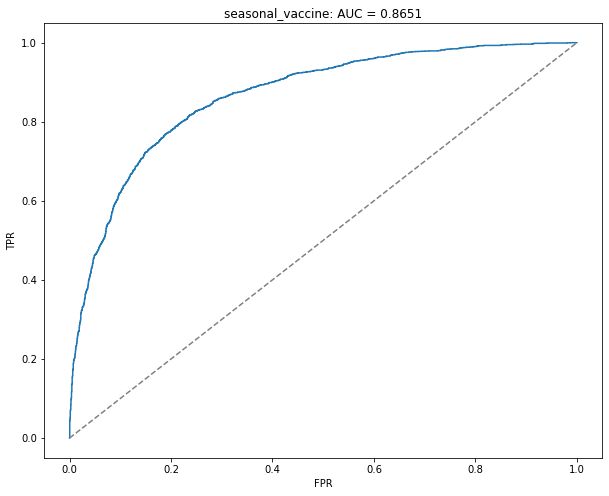

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_roc(
    y2_test, 
    sea_proba, 
    'seasonal_vaccine',
    ax=ax
)

In [31]:
tt = test.drop('respondent_id',axis=1)
test['h1n1_vaccine'] = h1n1_model.predict_proba(tt)[:,1]
test['seasonal_vaccine'] = sea_model.predict_proba(tt)[:,1]

In [32]:
sub = test[['respondent_id','h1n1_vaccine','seasonal_vaccine']].set_index('respondent_id')
sub.to_csv('submission.csv')

In [33]:
sub

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.100243,0.237694
26708,0.021651,0.022329
26709,0.175805,0.687902
26710,0.569718,0.908983
26711,0.256932,0.521036
...,...,...
53410,0.276521,0.503323
53411,0.183592,0.329698
53412,0.123771,0.217332


Analyze the catboost models

In [34]:
import shap
shap.initjs()

In [35]:
# visualize the h1n1 vaccine prediction's explanation
explainer_h1n1 = shap.TreeExplainer(h1n1_model)
shap_values_h1n1 = explainer_h1n1.shap_values(Pool(X_train, y1_train, cat_features=X_train.columns.to_list()))
shap.force_plot(explainer_h1n1.expected_value, shap_values_h1n1[0,:], X_train.iloc[0,:])

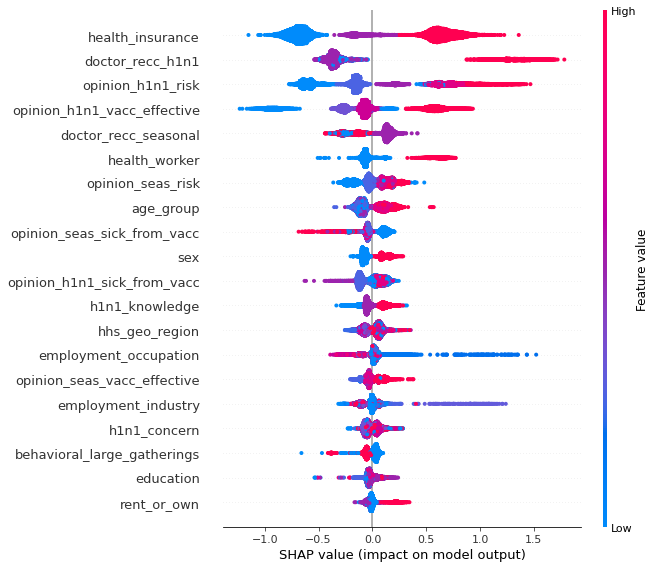

In [36]:
# summarize the effects of all the features to h1n1 vaccine prediction
shap.summary_plot(shap_values_h1n1, X_train)

Top 5 features in the h1n1 catboost model:
    
    a. Whether respondent has health insurance or not.
    b. Whether the h1n1 vaccine was recommended by doctor or not.
    c. Respondent's opinion about risk of getting sick with h1n1 without vaccine.
    d. Respondent's opinion about h1n1 vaccine effectiveness.
    e. Whether the seasonal flu vaccine was recommended by doctor or not.

In [37]:
# visualize the seasonal flu vaccine prediction's explanation
explainer_sea = shap.TreeExplainer(sea_model)
shap_values_sea = explainer_sea.shap_values(Pool(X_train, y2_train, cat_features=X_train.columns.to_list()))
shap.force_plot(explainer_sea.expected_value, shap_values_sea[0,:], X_train.iloc[0,:])

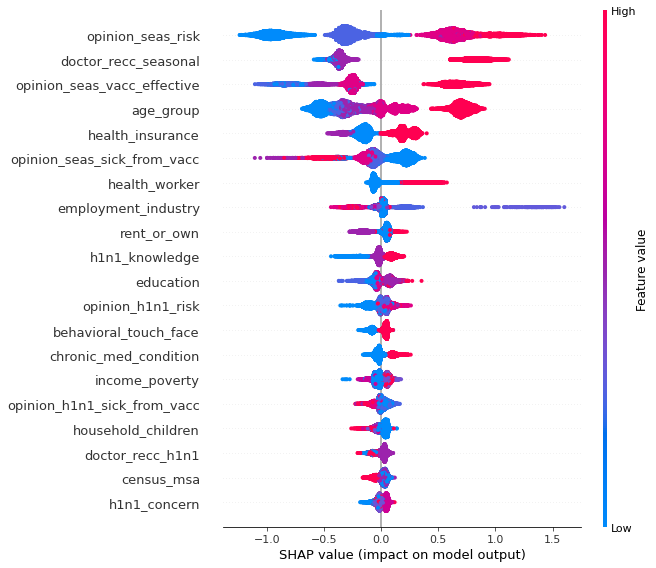

In [38]:
# summarize the effects of all the features to seasonal flu vaccine prediction
shap.summary_plot(shap_values_sea, X_train)

Top 5 features in the seasonal flu catboost model:
    
    a. Whether the seasonal flu vaccine was recommended by doctor or not.
    b. Respondent's opinion about risk of getting sick with seasonal flu without vaccine
    c. Respondent's opinion about seasonal flu vaccine effectiveness.
    d. Age.
    e. Whether respondent has health insurance or not.